In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as ks
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Bidirectional, Lambda, Input
from tensorflow.keras.models import Model
plt.style.use('default')
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('sp500.csv')
print(df.shape)
df.head()

(2790, 5)


Date    Close     Open     High      Low
0   2021/8/3  4423.15  4392.74  4423.79  4373.00
1   2021/8/2  4387.11  4406.86  4422.18  4384.81
2  2021/7/30  4395.26  4395.12  4412.25  4389.65
3  2021/7/29  4419.15  4403.59  4429.97  4403.59
4  2021/7/28  4400.65  4402.95  4415.47  4387.01

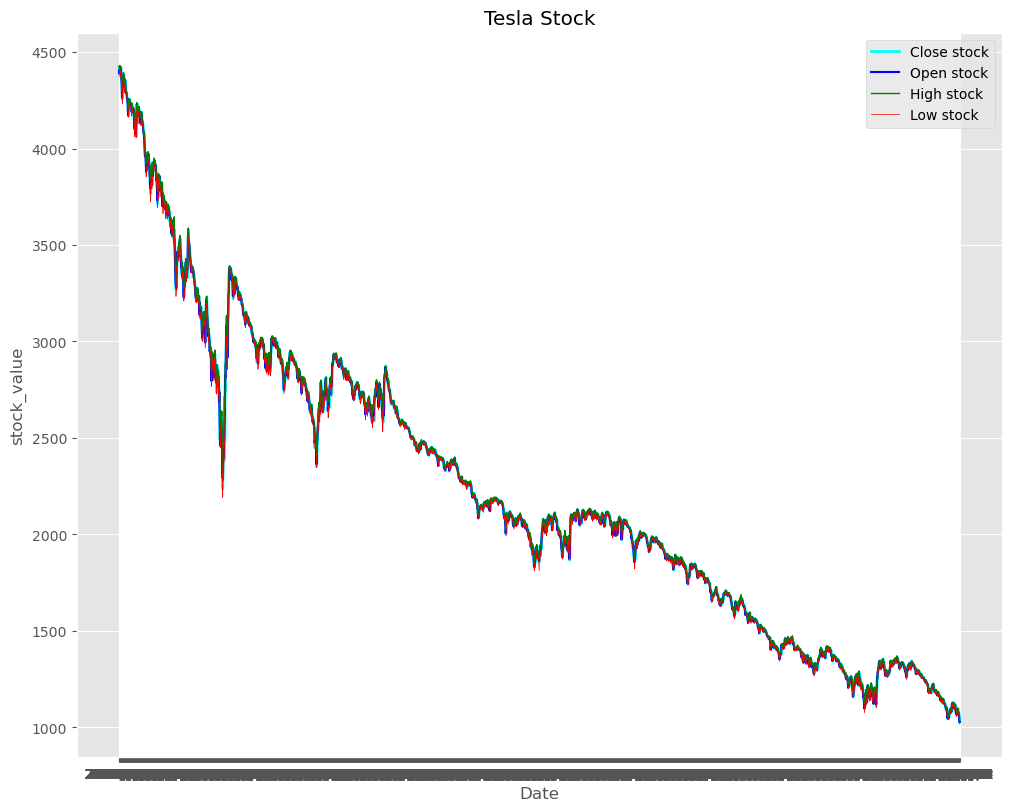

In [3]:
plt.figure(figsize=(10, 8), constrained_layout=True)
c = ['cyan', 'blue', 'green', 'red']
y = ['Close', 'Open', 'High', 'Low']
l = 2.0
for j, c in zip(y, c):
  plt.plot(df['Date'], df[j], color=c, linewidth=l, label=f'{j} stock')
  plt.title('Tesla Stock')
  plt.xlabel('Date')
  plt.ylabel('stock_value')
  plt.legend()
  l -=0.5

plt.show()

In [4]:
from PyEMD import CEEMDAN, Visualisation

In [5]:
close = df[['Close']].values

In [6]:
close

array([[ 23.889999],
       [ 23.83    ],
       [ 21.959999],
       ...,
       [640.809998],
       [650.570007],
       [780.      ]])

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
close_norm = scaler.fit_transform(close)
close_norm

array([[0.01058623],
       [0.01050772],
       [0.00806072],
       ...,
       [0.81786181],
       [0.83063335],
       [1.        ]])

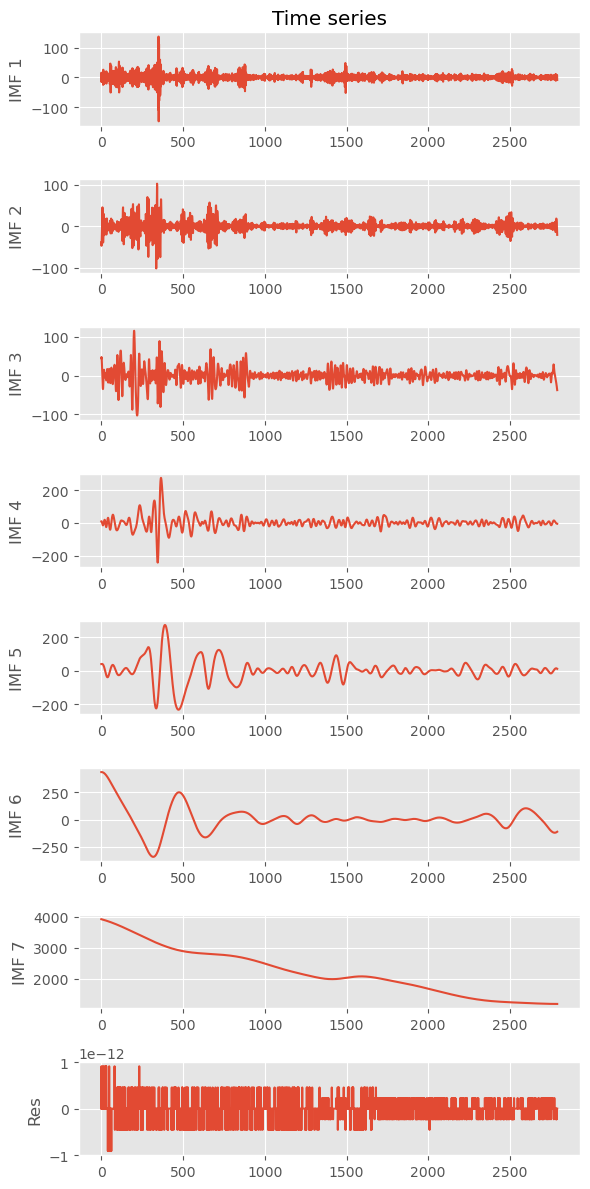

In [6]:
ceemdan = CEEMDAN()
ceemdan.ceemdan(close.reshape(-1))
imfs_close, res_close = ceemdan.get_imfs_and_residue()

t = np.arange(0, 2790, 1)
vis = Visualisation()
vis.plot_imfs(imfs=imfs_close, residue=res_close, t=t, include_residue=True)
# vis.plot_instant_freq(t, imfs=imfs)
vis.show()

In [11]:
imfs_close[1][2400:2440]

array([ -1.13749601,   0.59577737,   1.48986297,  -1.83562631,
        -4.68758346,  -2.33326495,   6.96532623,  15.12446972,
        15.26797543,   5.72340519,  -8.86732749, -21.81095523,
       -30.40376187, -34.92318589,  -7.13925342,  37.56693438])

In [7]:
# 取之前X_lag个数据来预测下一个数据
def time_slice(data,X_lag):
    sample = []
    label = []
    for k in range(len(data) - X_lag - 1):
        t = k + X_lag
        sample.append(data[k:t])
        label.append(data[t + 1])
    return sample,label


In [8]:
import numpy as np
import pandas as pd
import math
# import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import explained_variance_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [9]:
def create_model():
    model = Sequential()
    model.add(GRU(15, input_shape=(None,1)))
    model.add(Dense(1))
    model.summary()
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [10]:
def implement_GRU(X_train, y_train):
    param_grid = {'epochs': [200, 300], 
                              'batch_size': [8, 16]}
    
    model = KerasRegressor(build_fn=create_model)
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=0, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    print(grid_search.best_estimator_)
    print(grid_search.best_params_)
    
    
    
#     model = Sequential()
#     model.add(GRU(15, input_shape=(None,1)))
#     model.add(Dense(1))
#     model.summary()
#     model.compile(loss='mean_squared_error', optimizer='adam')
# #     model.compile(loss='mean_squared_error', optimizer='sgd')
#     model.fit(X_train, y_train, epochs=350, batch_size=16, verbose=0)
    
    return grid_search.best_estimator_

In [11]:
def split(sample, label, test_ratio):
    length = len(label)
    train_len = round((1-test_ratio)*length)
    X_train = sample[0:train_len]
    X_test = sample[train_len+1:length]
    y_train = label[0:train_len]
    y_test = label[train_len+1:length]
    
    return X_train, X_test, y_train, y_test
    

In [12]:
i = 1
svr = []
prediction = []
actual = []

for imf in imfs_close:
#     print('-'*45)
#     print('This is  ' + str(i)  + '  time(s)')
#     print('*'*45)
    
    # 生成time series dataset
    sample,label = time_slice(imf,30)
    
    # 数据集划分
#     X_train, X_test, y_train, y_test = train_test_split(sample, label, test_size=0.2, random_state=42)
    X_train, X_test, y_train, y_test = split(sample, label, 0.2)
    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.asarray(X_test)
    X_test = np.expand_dims(X_test, axis=2)
#     y_train = np.expand_dims(y_train, axis=3)
    
    tmp = implement_GRU(X_train, y_train)
    svr.append(tmp)
    actual.append(y_test)
    
    pre_tmp = tmp.predict(X_test)
    prediction.append(pre_tmp)
    
    i=i+1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 15)                810       
_________________________________________________________________
dense (Dense)                (None, 1)                 16        
Total params: 826
Trainable params: 826
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
221/221 [==============================] - 2s 8ms/step - loss: 80.9070
Epoch 2/200
221/221 [==============================] - 2s 7ms/step - loss: 79.9582
Epoch 3/200
221/221 [==============================] - 2s 7ms/step - loss: 79.3381
Epoch 4/200
221/221 [==============================] - 2s 7ms/step - loss: 78.9595
Epoch 5/200
221/221 [==============================] - 2s 7ms/step - loss: 78.6078
Epoch 6/200
221/221 [==============================] - 2s 7ms/step - loss: 78.3475
Epoch 7/200
221/221 [=

221/221 [==============================] - 2s 8ms/step - loss: 59.9942
Epoch 92/200
221/221 [==============================] - 2s 8ms/step - loss: 60.2635
Epoch 93/200
221/221 [==============================] - 2s 8ms/step - loss: 59.6419
Epoch 94/200
221/221 [==============================] - 2s 7ms/step - loss: 59.6885
Epoch 95/200
221/221 [==============================] - 2s 8ms/step - loss: 59.8769
Epoch 96/200
221/221 [==============================] - 2s 7ms/step - loss: 60.0596
Epoch 97/200
221/221 [==============================] - 2s 8ms/step - loss: 59.2037
Epoch 98/200
221/221 [==============================] - 2s 8ms/step - loss: 58.9704
Epoch 99/200
221/221 [==============================] - 2s 8ms/step - loss: 59.2221
Epoch 100/200
221/221 [==============================] - 2s 8ms/step - loss: 58.7732
Epoch 101/200
221/221 [==============================] - 2s 8ms/step - loss: 58.9330
Epoch 102/200
221/221 [==============================] - 2s 7ms/step - loss: 59.2420
Ep

221/221 [==============================] - 2s 8ms/step - loss: 51.5158
Epoch 188/200
221/221 [==============================] - 2s 7ms/step - loss: 51.5096
Epoch 189/200
221/221 [==============================] - 2s 8ms/step - loss: 52.1811
Epoch 190/200
221/221 [==============================] - 2s 8ms/step - loss: 51.5902
Epoch 191/200
221/221 [==============================] - 2s 8ms/step - loss: 51.1345
Epoch 192/200
221/221 [==============================] - 2s 8ms/step - loss: 55.7965
Epoch 193/200
221/221 [==============================] - ETA: 0s - loss: 52.91 - 2s 7ms/step - loss: 52.6355
Epoch 194/200
221/221 [==============================] - 2s 7ms/step - loss: 52.9017
Epoch 195/200
221/221 [==============================] - 2s 8ms/step - loss: 53.9915
Epoch 196/200
221/221 [==============================] - 2s 8ms/step - loss: 51.2431
Epoch 197/200
221/221 [==============================] - 2s 7ms/step - loss: 51.1458
Epoch 198/200
221/221 [==============================] 

221/221 [==============================] - 2s 7ms/step - loss: 161.0076
Epoch 77/200
221/221 [==============================] - 2s 7ms/step - loss: 160.8214
Epoch 78/200
221/221 [==============================] - 2s 7ms/step - loss: 160.6370
Epoch 79/200
221/221 [==============================] - 2s 7ms/step - loss: 160.5747
Epoch 80/200
221/221 [==============================] - 2s 7ms/step - loss: 159.8888
Epoch 81/200
221/221 [==============================] - 2s 7ms/step - loss: 159.3182
Epoch 82/200
221/221 [==============================] - 2s 7ms/step - loss: 159.3013
Epoch 83/200
221/221 [==============================] - 2s 8ms/step - loss: 159.1048
Epoch 84/200
221/221 [==============================] - 2s 8ms/step - loss: 158.8556
Epoch 85/200
221/221 [==============================] - 2s 7ms/step - loss: 158.6640
Epoch 86/200
221/221 [==============================] - 2s 7ms/step - loss: 158.2216
Epoch 87/200
221/221 [==============================] - 2s 7ms/step - loss: 15

221/221 [==============================] - 2s 7ms/step - loss: 143.4454
Epoch 172/200
221/221 [==============================] - 2s 7ms/step - loss: 143.1721
Epoch 173/200
221/221 [==============================] - 2s 7ms/step - loss: 142.9119
Epoch 174/200
221/221 [==============================] - 2s 7ms/step - loss: 142.2308
Epoch 175/200
221/221 [==============================] - 2s 7ms/step - loss: 142.6969
Epoch 176/200
221/221 [==============================] - 2s 7ms/step - loss: 144.7655
Epoch 177/200
221/221 [==============================] - 2s 7ms/step - loss: 142.4837
Epoch 178/200
221/221 [==============================] - 2s 7ms/step - loss: 143.2906
Epoch 179/200
221/221 [==============================] - 2s 7ms/step - loss: 145.6108
Epoch 180/200
221/221 [==============================] - 2s 7ms/step - loss: 144.1169
Epoch 181/200
221/221 [==============================] - 2s 7ms/step - loss: 141.9276
Epoch 182/200
221/221 [==============================] - 2s 7ms/step

221/221 [==============================] - 2s 7ms/step - loss: 195.2488
Epoch 61/200
221/221 [==============================] - 2s 8ms/step - loss: 195.0889
Epoch 62/200
221/221 [==============================] - 2s 8ms/step - loss: 194.7983
Epoch 63/200
221/221 [==============================] - 2s 8ms/step - loss: 194.6371
Epoch 64/200
221/221 [==============================] - 2s 8ms/step - loss: 194.0070
Epoch 65/200
221/221 [==============================] - 2s 8ms/step - loss: 193.5800
Epoch 66/200
221/221 [==============================] - 2s 7ms/step - loss: 193.1983
Epoch 67/200
221/221 [==============================] - 2s 9ms/step - loss: 193.6970
Epoch 68/200
221/221 [==============================] - 2s 8ms/step - loss: 193.7507
Epoch 69/200
221/221 [==============================] - 2s 8ms/step - loss: 192.5664
Epoch 70/200
221/221 [==============================] - 2s 8ms/step - loss: 192.6106
Epoch 71/200
221/221 [==============================] - 2s 8ms/step - loss: 19

221/221 [==============================] - 2s 8ms/step - loss: 176.0305
Epoch 156/200
221/221 [==============================] - 2s 8ms/step - loss: 178.8205
Epoch 157/200
221/221 [==============================] - 2s 7ms/step - loss: 178.4668
Epoch 158/200
221/221 [==============================] - 2s 7ms/step - loss: 182.8199
Epoch 159/200
221/221 [==============================] - 2s 7ms/step - loss: 177.4016
Epoch 160/200
221/221 [==============================] - 2s 7ms/step - loss: 179.2727
Epoch 161/200
221/221 [==============================] - 2s 7ms/step - loss: 179.6626
Epoch 162/200
221/221 [==============================] - 2s 8ms/step - loss: 176.7561
Epoch 163/200
221/221 [==============================] - 2s 7ms/step - loss: 176.5112
Epoch 164/200
221/221 [==============================] - 2s 7ms/step - loss: 176.1246
Epoch 165/200
221/221 [==============================] - 2s 7ms/step - loss: 178.7242
Epoch 166/200
221/221 [==============================] - 2s 7ms/step

221/221 [==============================] - 2s 8ms/step - loss: 186.5112
Epoch 44/200
221/221 [==============================] - 2s 8ms/step - loss: 186.3615
Epoch 45/200
221/221 [==============================] - 2s 8ms/step - loss: 186.1881
Epoch 46/200
221/221 [==============================] - 2s 7ms/step - loss: 185.8348
Epoch 47/200
221/221 [==============================] - 2s 8ms/step - loss: 185.6182
Epoch 48/200
221/221 [==============================] - 2s 8ms/step - loss: 185.5896
Epoch 49/200
221/221 [==============================] - 2s 7ms/step - loss: 185.2000
Epoch 50/200
221/221 [==============================] - 2s 8ms/step - loss: 185.0560
Epoch 51/200
221/221 [==============================] - 2s 8ms/step - loss: 184.7470
Epoch 52/200
221/221 [==============================] - 2s 7ms/step - loss: 184.4371
Epoch 53/200
221/221 [==============================] - 2s 8ms/step - loss: 184.1659
Epoch 54/200
221/221 [==============================] - 2s 8ms/step - loss: 18

221/221 [==============================] - 2s 7ms/step - loss: 160.5535
Epoch 140/200
221/221 [==============================] - 2s 7ms/step - loss: 159.9982
Epoch 141/200
221/221 [==============================] - 2s 7ms/step - loss: 160.4105
Epoch 142/200
221/221 [==============================] - 2s 7ms/step - loss: 160.1181
Epoch 143/200
221/221 [==============================] - 2s 7ms/step - loss: 159.7718
Epoch 144/200
221/221 [==============================] - 2s 7ms/step - loss: 160.6630
Epoch 145/200
221/221 [==============================] - 2s 7ms/step - loss: 161.1086
Epoch 146/200
221/221 [==============================] - 2s 7ms/step - loss: 159.6068
Epoch 147/200
221/221 [==============================] - 2s 7ms/step - loss: 158.1645
Epoch 148/200
221/221 [==============================] - 2s 7ms/step - loss: 158.4546
Epoch 149/200
221/221 [==============================] - 2s 7ms/step - loss: 158.3893
Epoch 150/200
221/221 [==============================] - 2s 7ms/step

221/221 [==============================] - 2s 7ms/step - loss: 205.9286
Epoch 28/200
221/221 [==============================] - 2s 7ms/step - loss: 205.6895
Epoch 29/200
221/221 [==============================] - 2s 7ms/step - loss: 205.4575
Epoch 30/200
221/221 [==============================] - 2s 7ms/step - loss: 205.2575
Epoch 31/200
221/221 [==============================] - 2s 7ms/step - loss: 205.0212
Epoch 32/200
221/221 [==============================] - 2s 7ms/step - loss: 204.7857
Epoch 33/200
221/221 [==============================] - 2s 7ms/step - loss: 204.5098
Epoch 34/200
221/221 [==============================] - 2s 7ms/step - loss: 204.2587
Epoch 35/200
221/221 [==============================] - 2s 7ms/step - loss: 204.0169
Epoch 36/200
221/221 [==============================] - 2s 7ms/step - loss: 203.7189
Epoch 37/200
221/221 [==============================] - 2s 7ms/step - loss: 203.4279
Epoch 38/200
221/221 [==============================] - 2s 7ms/step - loss: 20

221/221 [==============================] - 2s 7ms/step - loss: 179.6428
Epoch 124/200
221/221 [==============================] - 2s 7ms/step - loss: 181.0428
Epoch 125/200
221/221 [==============================] - 2s 7ms/step - loss: 181.4586
Epoch 126/200
221/221 [==============================] - 2s 7ms/step - loss: 179.8188
Epoch 127/200
221/221 [==============================] - 2s 7ms/step - loss: 178.6116
Epoch 128/200
221/221 [==============================] - 2s 7ms/step - loss: 179.5007
Epoch 129/200
221/221 [==============================] - 2s 7ms/step - loss: 178.9661
Epoch 130/200
221/221 [==============================] - 2s 7ms/step - loss: 179.3423
Epoch 131/200
221/221 [==============================] - 2s 7ms/step - loss: 179.3001
Epoch 132/200
221/221 [==============================] - 2s 7ms/step - loss: 183.7762
Epoch 133/200
221/221 [==============================] - 2s 7ms/step - loss: 182.3454
Epoch 134/200
221/221 [==============================] - 2s 7ms/step

221/221 [==============================] - 2s 8ms/step - loss: 77.9705
Epoch 12/300
221/221 [==============================] - 2s 7ms/step - loss: 77.7652
Epoch 13/300
221/221 [==============================] - 2s 8ms/step - loss: 77.5536
Epoch 14/300
221/221 [==============================] - 2s 8ms/step - loss: 77.2899
Epoch 15/300
221/221 [==============================] - 2s 7ms/step - loss: 77.1227
Epoch 16/300
221/221 [==============================] - 2s 7ms/step - loss: 76.9152
Epoch 17/300
221/221 [==============================] - 2s 8ms/step - loss: 76.6914
Epoch 18/300
221/221 [==============================] - 2s 7ms/step - loss: 76.4168
Epoch 19/300
221/221 [==============================] - 2s 7ms/step - loss: 76.2172
Epoch 20/300
221/221 [==============================] - 2s 8ms/step - loss: 75.9958
Epoch 21/300
221/221 [==============================] - 2s 8ms/step - loss: 75.7428
Epoch 22/300
221/221 [==============================] - 2s 7ms/step - loss: 75.7462
Epoch

221/221 [==============================] - 2s 7ms/step - loss: 58.5883
Epoch 109/300
221/221 [==============================] - 2s 7ms/step - loss: 58.2093
Epoch 110/300
221/221 [==============================] - 2s 7ms/step - loss: 58.6091
Epoch 111/300
221/221 [==============================] - 2s 7ms/step - loss: 58.5232
Epoch 112/300
221/221 [==============================] - 2s 7ms/step - loss: 57.9979
Epoch 113/300
221/221 [==============================] - 2s 7ms/step - loss: 58.4080
Epoch 114/300
221/221 [==============================] - 2s 7ms/step - loss: 58.1113
Epoch 115/300
221/221 [==============================] - 2s 7ms/step - loss: 57.5957
Epoch 116/300
221/221 [==============================] - 2s 7ms/step - loss: 61.0474
Epoch 117/300
221/221 [==============================] - 2s 7ms/step - loss: 65.1247
Epoch 118/300
221/221 [==============================] - 2s 7ms/step - loss: 61.4292
Epoch 119/300
221/221 [==============================] - 2s 7ms/step - loss: 60

221/221 [==============================] - 2s 7ms/step - loss: 51.9174
Epoch 205/300
221/221 [==============================] - 2s 7ms/step - loss: 52.0460
Epoch 206/300
221/221 [==============================] - 2s 7ms/step - loss: 51.3608
Epoch 207/300
221/221 [==============================] - 2s 7ms/step - loss: 50.6538
Epoch 208/300
221/221 [==============================] - 2s 7ms/step - loss: 51.1850
Epoch 209/300
221/221 [==============================] - 2s 7ms/step - loss: 50.8071
Epoch 210/300
221/221 [==============================] - 2s 7ms/step - loss: 50.9418
Epoch 211/300
221/221 [==============================] - 2s 7ms/step - loss: 51.5154
Epoch 212/300
221/221 [==============================] - 2s 7ms/step - loss: 52.2478
Epoch 213/300
221/221 [==============================] - 2s 7ms/step - loss: 50.9580
Epoch 214/300
221/221 [==============================] - 2s 7ms/step - loss: 53.4763
Epoch 215/300
221/221 [==============================] - 1s 7ms/step - loss: 51

221/221 [==============================] - 2s 7ms/step - loss: 65.3609
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 15)                810       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 16        
Total params: 826
Trainable params: 826
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
221/221 [==============================] - 2s 8ms/step - loss: 176.9842
Epoch 2/300
221/221 [==============================] - 2s 7ms/step - loss: 176.6100
Epoch 3/300
221/221 [==============================] - 2s 7ms/step - loss: 176.2329
Epoch 4/300
221/221 [==============================] - 2s 7ms/step - loss: 176.0324
Epoch 5/300
221/221 [==============================] - 2s 7ms/step - loss: 175.8998
Epoch 6/300
221/221 [======

221/221 [==============================] - 2s 7ms/step - loss: 166.7582
Epoch 90/300
221/221 [==============================] - 2s 7ms/step - loss: 166.5530
Epoch 91/300
221/221 [==============================] - 2s 7ms/step - loss: 166.0780
Epoch 92/300
221/221 [==============================] - 2s 7ms/step - loss: 166.2290
Epoch 93/300
221/221 [==============================] - 2s 7ms/step - loss: 165.9939
Epoch 94/300
221/221 [==============================] - 2s 7ms/step - loss: 165.6819
Epoch 95/300
221/221 [==============================] - 2s 7ms/step - loss: 165.5950
Epoch 96/300
221/221 [==============================] - 2s 7ms/step - loss: 165.3004
Epoch 97/300
221/221 [==============================] - 2s 7ms/step - loss: 165.2228
Epoch 98/300
221/221 [==============================] - 2s 7ms/step - loss: 164.9896
Epoch 99/300
221/221 [==============================] - 2s 7ms/step - loss: 164.7686
Epoch 100/300
221/221 [==============================] - 2s 7ms/step - loss: 1

221/221 [==============================] - 2s 7ms/step - loss: 161.7229
Epoch 185/300
221/221 [==============================] - 2s 7ms/step - loss: 158.8027
Epoch 186/300
221/221 [==============================] - 2s 7ms/step - loss: 156.4872
Epoch 187/300
221/221 [==============================] - 2s 7ms/step - loss: 156.1143
Epoch 188/300
221/221 [==============================] - 2s 7ms/step - loss: 156.9679
Epoch 189/300
221/221 [==============================] - 2s 7ms/step - loss: 159.5145
Epoch 190/300
221/221 [==============================] - 2s 7ms/step - loss: 158.0880
Epoch 191/300
221/221 [==============================] - 2s 7ms/step - loss: 157.6488
Epoch 192/300
221/221 [==============================] - 2s 7ms/step - loss: 156.2769
Epoch 193/300
221/221 [==============================] - 2s 7ms/step - loss: 155.9550
Epoch 194/300
221/221 [==============================] - 2s 7ms/step - loss: 156.5173
Epoch 195/300
221/221 [==============================] - 2s 7ms/step

221/221 [==============================] - 2s 7ms/step - loss: 151.7202
Epoch 280/300
221/221 [==============================] - 2s 7ms/step - loss: 152.3209
Epoch 281/300
221/221 [==============================] - 2s 7ms/step - loss: 151.8691
Epoch 282/300
221/221 [==============================] - 2s 7ms/step - loss: 154.5905
Epoch 283/300
221/221 [==============================] - 2s 7ms/step - loss: 155.5043
Epoch 284/300
221/221 [==============================] - 2s 7ms/step - loss: 158.6279
Epoch 285/300
221/221 [==============================] - 2s 7ms/step - loss: 163.8623
Epoch 286/300
221/221 [==============================] - 2s 7ms/step - loss: 160.9177
Epoch 287/300
221/221 [==============================] - 2s 7ms/step - loss: 159.9066
Epoch 288/300
221/221 [==============================] - 2s 7ms/step - loss: 159.4049
Epoch 289/300
221/221 [==============================] - 2s 7ms/step - loss: 158.8935
Epoch 290/300
221/221 [==============================] - 2s 7ms/step

221/221 [==============================] - 2s 7ms/step - loss: 194.5502
Epoch 69/300
221/221 [==============================] - 2s 7ms/step - loss: 193.8723
Epoch 70/300
221/221 [==============================] - 2s 7ms/step - loss: 193.5488
Epoch 71/300
221/221 [==============================] - 2s 7ms/step - loss: 194.4550
Epoch 72/300
221/221 [==============================] - 2s 7ms/step - loss: 193.0350
Epoch 73/300
221/221 [==============================] - 2s 7ms/step - loss: 192.5442
Epoch 74/300
221/221 [==============================] - 2s 7ms/step - loss: 192.2113
Epoch 75/300
221/221 [==============================] - 2s 7ms/step - loss: 191.7182
Epoch 76/300
221/221 [==============================] - 2s 7ms/step - loss: 191.1806
Epoch 77/300
221/221 [==============================] - 2s 7ms/step - loss: 190.6827
Epoch 78/300
221/221 [==============================] - 2s 7ms/step - loss: 190.7480
Epoch 79/300
221/221 [==============================] - 2s 7ms/step - loss: 19

221/221 [==============================] - 2s 7ms/step - loss: 178.0237
Epoch 164/300
221/221 [==============================] - 2s 7ms/step - loss: 178.1299
Epoch 165/300
221/221 [==============================] - 2s 7ms/step - loss: 176.7337
Epoch 166/300
221/221 [==============================] - 2s 7ms/step - loss: 177.5598
Epoch 167/300
221/221 [==============================] - 2s 7ms/step - loss: 176.6748
Epoch 168/300
221/221 [==============================] - 2s 7ms/step - loss: 175.9080
Epoch 169/300
221/221 [==============================] - 2s 7ms/step - loss: 176.8415
Epoch 170/300
221/221 [==============================] - 2s 7ms/step - loss: 176.6809
Epoch 171/300
221/221 [==============================] - 2s 7ms/step - loss: 175.2428
Epoch 172/300
221/221 [==============================] - 2s 7ms/step - loss: 175.5256
Epoch 173/300
221/221 [==============================] - 2s 7ms/step - loss: 177.9687
Epoch 174/300
221/221 [==============================] - 2s 7ms/step

221/221 [==============================] - 2s 7ms/step - loss: 171.1560
Epoch 259/300
221/221 [==============================] - 2s 7ms/step - loss: 169.8840
Epoch 260/300
221/221 [==============================] - 2s 7ms/step - loss: 170.3292
Epoch 261/300
221/221 [==============================] - 2s 7ms/step - loss: 179.9581
Epoch 262/300
221/221 [==============================] - 2s 7ms/step - loss: 174.2695
Epoch 263/300
221/221 [==============================] - 2s 7ms/step - loss: 173.1448
Epoch 264/300
221/221 [==============================] - 2s 7ms/step - loss: 172.0636
Epoch 265/300
221/221 [==============================] - 2s 7ms/step - loss: 171.4034
Epoch 266/300
221/221 [==============================] - 2s 7ms/step - loss: 170.8764
Epoch 267/300
221/221 [==============================] - 2s 7ms/step - loss: 169.8618
Epoch 268/300
221/221 [==============================] - 2s 7ms/step - loss: 170.9188
Epoch 269/300
221/221 [==============================] - 2s 7ms/step

221/221 [==============================] - 2s 7ms/step - loss: 184.6762
Epoch 47/300
221/221 [==============================] - 2s 7ms/step - loss: 184.3888
Epoch 48/300
221/221 [==============================] - 2s 7ms/step - loss: 184.4110
Epoch 49/300
221/221 [==============================] - 2s 7ms/step - loss: 183.8710
Epoch 50/300
221/221 [==============================] - 2s 7ms/step - loss: 183.5851
Epoch 51/300
221/221 [==============================] - 2s 7ms/step - loss: 183.3441
Epoch 52/300
221/221 [==============================] - 2s 7ms/step - loss: 183.1820
Epoch 53/300
221/221 [==============================] - 2s 7ms/step - loss: 182.9609
Epoch 54/300
221/221 [==============================] - 2s 7ms/step - loss: 183.0995
Epoch 55/300
221/221 [==============================] - 2s 7ms/step - loss: 182.4263
Epoch 56/300
221/221 [==============================] - 2s 7ms/step - loss: 182.2747
Epoch 57/300
221/221 [==============================] - 2s 7ms/step - loss: 18

221/221 [==============================] - 2s 7ms/step - loss: 161.5039
Epoch 143/300
221/221 [==============================] - 2s 7ms/step - loss: 160.7095
Epoch 144/300
221/221 [==============================] - 2s 7ms/step - loss: 160.5595
Epoch 145/300
221/221 [==============================] - 2s 7ms/step - loss: 159.9571
Epoch 146/300
221/221 [==============================] - 2s 7ms/step - loss: 160.1990
Epoch 147/300
221/221 [==============================] - 2s 7ms/step - loss: 159.9819
Epoch 148/300
221/221 [==============================] - 2s 7ms/step - loss: 159.9976
Epoch 149/300
221/221 [==============================] - 2s 7ms/step - loss: 159.4752
Epoch 150/300
221/221 [==============================] - 2s 7ms/step - loss: 161.5155
Epoch 151/300
221/221 [==============================] - 2s 7ms/step - loss: 159.7079
Epoch 152/300
221/221 [==============================] - 2s 7ms/step - loss: 159.4758
Epoch 153/300
221/221 [==============================] - 2s 7ms/step

221/221 [==============================] - 2s 7ms/step - loss: 152.2435
Epoch 238/300
221/221 [==============================] - 2s 8ms/step - loss: 147.9674
Epoch 239/300
221/221 [==============================] - 2s 8ms/step - loss: 147.8229
Epoch 240/300
221/221 [==============================] - 2s 7ms/step - loss: 151.1828
Epoch 241/300
221/221 [==============================] - 2s 7ms/step - loss: 156.1356
Epoch 242/300
221/221 [==============================] - 2s 7ms/step - loss: 149.2919
Epoch 243/300
221/221 [==============================] - 2s 7ms/step - loss: 148.4338
Epoch 244/300
221/221 [==============================] - 2s 7ms/step - loss: 159.5235
Epoch 245/300
221/221 [==============================] - 2s 7ms/step - loss: 153.2247
Epoch 246/300
221/221 [==============================] - 2s 7ms/step - loss: 151.6814
Epoch 247/300
221/221 [==============================] - 2s 7ms/step - loss: 150.2203
Epoch 248/300
221/221 [==============================] - 2s 7ms/step

221/221 [==============================] - 2s 7ms/step - loss: 206.2803
Epoch 26/300
221/221 [==============================] - 2s 7ms/step - loss: 206.1397
Epoch 27/300
221/221 [==============================] - 2s 7ms/step - loss: 206.0489
Epoch 28/300
221/221 [==============================] - 2s 7ms/step - loss: 205.8689
Epoch 29/300
221/221 [==============================] - 2s 7ms/step - loss: 205.7336
Epoch 30/300
221/221 [==============================] - 2s 7ms/step - loss: 205.5932
Epoch 31/300
221/221 [==============================] - 2s 7ms/step - loss: 205.4106
Epoch 32/300
221/221 [==============================] - 2s 7ms/step - loss: 205.3284
Epoch 33/300
221/221 [==============================] - 2s 7ms/step - loss: 205.0421
Epoch 34/300
221/221 [==============================] - 2s 7ms/step - loss: 204.9254
Epoch 35/300
221/221 [==============================] - 2s 7ms/step - loss: 204.8860
Epoch 36/300
221/221 [==============================] - 2s 7ms/step - loss: 20

221/221 [==============================] - 2s 7ms/step - loss: 183.8804
Epoch 122/300
221/221 [==============================] - 2s 7ms/step - loss: 185.8971
Epoch 123/300
221/221 [==============================] - 2s 7ms/step - loss: 184.3280
Epoch 124/300
221/221 [==============================] - 2s 7ms/step - loss: 183.4542
Epoch 125/300
221/221 [==============================] - 2s 7ms/step - loss: 183.3304
Epoch 126/300
221/221 [==============================] - 2s 7ms/step - loss: 183.1891
Epoch 127/300
221/221 [==============================] - 2s 7ms/step - loss: 182.8401
Epoch 128/300
221/221 [==============================] - 2s 7ms/step - loss: 183.6609
Epoch 129/300
221/221 [==============================] - 2s 7ms/step - loss: 183.9048
Epoch 130/300
221/221 [==============================] - 2s 7ms/step - loss: 182.2228
Epoch 131/300
221/221 [==============================] - 2s 7ms/step - loss: 183.4460
Epoch 132/300
221/221 [==============================] - 2s 7ms/step

221/221 [==============================] - 2s 7ms/step - loss: 179.5356
Epoch 217/300
221/221 [==============================] - 2s 7ms/step - loss: 178.6765
Epoch 218/300
221/221 [==============================] - 1s 7ms/step - loss: 178.3155
Epoch 219/300
221/221 [==============================] - 1s 7ms/step - loss: 177.7262
Epoch 220/300
221/221 [==============================] - 2s 7ms/step - loss: 177.8532
Epoch 221/300
221/221 [==============================] - 2s 7ms/step - loss: 178.3609
Epoch 222/300
221/221 [==============================] - 2s 7ms/step - loss: 178.3479
Epoch 223/300
221/221 [==============================] - 2s 7ms/step - loss: 178.3970
Epoch 224/300
221/221 [==============================] - 2s 7ms/step - loss: 177.7701
Epoch 225/300
221/221 [==============================] - 2s 7ms/step - loss: 176.4922
Epoch 226/300
221/221 [==============================] - 2s 7ms/step - loss: 178.2802
Epoch 227/300
221/221 [==============================] - 1s 7ms/step

111/111 [==============================] - 1s 7ms/step - loss: 80.4367
Epoch 5/200
111/111 [==============================] - 1s 8ms/step - loss: 79.9594
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 79.6164
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 79.4133
Epoch 8/200
111/111 [==============================] - 1s 8ms/step - loss: 79.2058
Epoch 9/200
111/111 [==============================] - 1s 9ms/step - loss: 78.9985
Epoch 10/200
111/111 [==============================] - 1s 8ms/step - loss: 78.8225
Epoch 11/200
111/111 [==============================] - 1s 7ms/step - loss: 78.6623
Epoch 12/200
111/111 [==============================] - 1s 7ms/step - loss: 78.4576
Epoch 13/200
111/111 [==============================] - 1s 8ms/step - loss: 78.3171
Epoch 14/200
111/111 [==============================] - 1s 8ms/step - loss: 78.1114
Epoch 15/200
111/111 [==============================] - 1s 7ms/step - loss: 77.9412
Epoch 16/2

111/111 [==============================] - 1s 7ms/step - loss: 62.5407
Epoch 102/200
111/111 [==============================] - 1s 7ms/step - loss: 62.3676
Epoch 103/200
111/111 [==============================] - 1s 7ms/step - loss: 62.3579
Epoch 104/200
111/111 [==============================] - 1s 7ms/step - loss: 62.0957
Epoch 105/200
111/111 [==============================] - 1s 7ms/step - loss: 61.8914
Epoch 106/200
111/111 [==============================] - 1s 7ms/step - loss: 61.9728
Epoch 107/200
111/111 [==============================] - 1s 7ms/step - loss: 61.6663
Epoch 108/200
111/111 [==============================] - 1s 7ms/step - loss: 61.5752
Epoch 109/200
111/111 [==============================] - 1s 7ms/step - loss: 62.1059
Epoch 110/200
111/111 [==============================] - 1s 7ms/step - loss: 61.4913
Epoch 111/200
111/111 [==============================] - 1s 7ms/step - loss: 61.2656
Epoch 112/200
111/111 [==============================] - 1s 7ms/step - loss: 61

111/111 [==============================] - 1s 7ms/step - loss: 54.7768
Epoch 198/200
111/111 [==============================] - 1s 7ms/step - loss: 54.5084
Epoch 199/200
111/111 [==============================] - 1s 7ms/step - loss: 55.3284
Epoch 200/200
111/111 [==============================] - 1s 7ms/step - loss: 53.8762
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_11 (GRU)                 (None, 15)                810       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 16        
Total params: 826
Trainable params: 826
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
111/111 [==============================] - 1s 9ms/step - loss: 176.9461
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 176.6439
Epoch 3/200
111/111 [==

111/111 [==============================] - 1s 7ms/step - loss: 167.2264
Epoch 87/200
111/111 [==============================] - 1s 7ms/step - loss: 166.9476
Epoch 88/200
111/111 [==============================] - 1s 7ms/step - loss: 166.8691
Epoch 89/200
111/111 [==============================] - 1s 7ms/step - loss: 166.6221
Epoch 90/200
111/111 [==============================] - 1s 7ms/step - loss: 166.6267
Epoch 91/200
111/111 [==============================] - 1s 7ms/step - loss: 166.6076
Epoch 92/200
111/111 [==============================] - 1s 7ms/step - loss: 166.4138
Epoch 93/200
111/111 [==============================] - 1s 7ms/step - loss: 166.2371
Epoch 94/200
111/111 [==============================] - 1s 7ms/step - loss: 166.0267
Epoch 95/200
111/111 [==============================] - 1s 7ms/step - loss: 165.7677
Epoch 96/200
111/111 [==============================] - 1s 7ms/step - loss: 165.8540
Epoch 97/200
111/111 [==============================] - 1s 7ms/step - loss: 16

111/111 [==============================] - 1s 8ms/step - loss: 176.5675
Epoch 182/200
111/111 [==============================] - 1s 8ms/step - loss: 175.8794
Epoch 183/200
111/111 [==============================] - 1s 7ms/step - loss: 175.5748
Epoch 184/200
111/111 [==============================] - 1s 7ms/step - loss: 175.1396
Epoch 185/200
111/111 [==============================] - 1s 8ms/step - loss: 175.3831
Epoch 186/200
111/111 [==============================] - 1s 7ms/step - loss: 175.0420
Epoch 187/200
111/111 [==============================] - 1s 7ms/step - loss: 175.0292
Epoch 188/200
111/111 [==============================] - 1s 8ms/step - loss: 174.9396
Epoch 189/200
111/111 [==============================] - 1s 7ms/step - loss: 174.7653
Epoch 190/200
111/111 [==============================] - 1s 8ms/step - loss: 174.8988
Epoch 191/200
111/111 [==============================] - 1s 7ms/step - loss: 174.9802
Epoch 192/200
111/111 [==============================] - 1s 7ms/step

111/111 [==============================] - 1s 7ms/step - loss: 200.8173
Epoch 70/200
111/111 [==============================] - 1s 7ms/step - loss: 200.7489
Epoch 71/200
111/111 [==============================] - 1s 7ms/step - loss: 200.6085
Epoch 72/200
111/111 [==============================] - 1s 7ms/step - loss: 200.3528
Epoch 73/200
111/111 [==============================] - 1s 7ms/step - loss: 200.2905
Epoch 74/200
111/111 [==============================] - 1s 7ms/step - loss: 200.0320
Epoch 75/200
111/111 [==============================] - 1s 7ms/step - loss: 199.8757
Epoch 76/200
111/111 [==============================] - 1s 7ms/step - loss: 199.7883
Epoch 77/200
111/111 [==============================] - 1s 7ms/step - loss: 199.4602
Epoch 78/200
111/111 [==============================] - 1s 7ms/step - loss: 199.4207
Epoch 79/200
111/111 [==============================] - 1s 7ms/step - loss: 199.3312
Epoch 80/200
111/111 [==============================] - 1s 7ms/step - loss: 19

111/111 [==============================] - 1s 7ms/step - loss: 182.6274
Epoch 165/200
111/111 [==============================] - 1s 7ms/step - loss: 182.3410
Epoch 166/200
111/111 [==============================] - 1s 7ms/step - loss: 182.1659
Epoch 167/200
111/111 [==============================] - 1s 7ms/step - loss: 182.4668
Epoch 168/200
111/111 [==============================] - 1s 7ms/step - loss: 184.7327
Epoch 169/200
111/111 [==============================] - 1s 7ms/step - loss: 184.6376
Epoch 170/200
111/111 [==============================] - 1s 7ms/step - loss: 184.0317
Epoch 171/200
111/111 [==============================] - 1s 7ms/step - loss: 182.1096
Epoch 172/200
111/111 [==============================] - 1s 7ms/step - loss: 182.0684
Epoch 173/200
111/111 [==============================] - 1s 7ms/step - loss: 181.3883
Epoch 174/200
111/111 [==============================] - 1s 7ms/step - loss: 181.3041
Epoch 175/200
111/111 [==============================] - 1s 7ms/step

Epoch 53/200
111/111 [==============================] - 1s 7ms/step - loss: 184.5536
Epoch 54/200
111/111 [==============================] - 1s 7ms/step - loss: 184.3383
Epoch 55/200
111/111 [==============================] - 1s 8ms/step - loss: 184.1679
Epoch 56/200
111/111 [==============================] - 1s 7ms/step - loss: 183.9910
Epoch 57/200
111/111 [==============================] - 1s 7ms/step - loss: 183.5859
Epoch 58/200
111/111 [==============================] - 1s 7ms/step - loss: 183.4244
Epoch 59/200
111/111 [==============================] - 1s 7ms/step - loss: 183.2944
Epoch 60/200
111/111 [==============================] - 1s 7ms/step - loss: 182.9101
Epoch 61/200
111/111 [==============================] - 1s 7ms/step - loss: 182.7923
Epoch 62/200
111/111 [==============================] - 1s 7ms/step - loss: 182.4497
Epoch 63/200
111/111 [==============================] - 1s 8ms/step - loss: 182.1994
Epoch 64/200
111/111 [==============================] - 1s 7ms/st

111/111 [==============================] - 1s 7ms/step - loss: 166.8747
Epoch 149/200
111/111 [==============================] - 1s 7ms/step - loss: 166.4424
Epoch 150/200
111/111 [==============================] - 1s 7ms/step - loss: 166.6778
Epoch 151/200
111/111 [==============================] - 1s 7ms/step - loss: 166.3163
Epoch 152/200
111/111 [==============================] - 1s 7ms/step - loss: 166.3406
Epoch 153/200
111/111 [==============================] - 1s 7ms/step - loss: 166.1318
Epoch 154/200
111/111 [==============================] - 1s 7ms/step - loss: 166.0110
Epoch 155/200
111/111 [==============================] - 1s 7ms/step - loss: 165.9531
Epoch 156/200
111/111 [==============================] - 1s 7ms/step - loss: 166.0682
Epoch 157/200
111/111 [==============================] - 1s 7ms/step - loss: 165.9848
Epoch 158/200
111/111 [==============================] - 1s 7ms/step - loss: 165.9087
Epoch 159/200
111/111 [==============================] - 1s 7ms/step

111/111 [==============================] - 1s 7ms/step - loss: 206.3799
Epoch 37/200
111/111 [==============================] - 1s 7ms/step - loss: 206.2539
Epoch 38/200
111/111 [==============================] - 1s 7ms/step - loss: 206.2168
Epoch 39/200
111/111 [==============================] - 1s 7ms/step - loss: 205.9161
Epoch 40/200
111/111 [==============================] - 1s 7ms/step - loss: 205.8497
Epoch 41/200
111/111 [==============================] - 1s 7ms/step - loss: 205.7170
Epoch 42/200
111/111 [==============================] - 1s 7ms/step - loss: 205.5369
Epoch 43/200
111/111 [==============================] - 1s 7ms/step - loss: 205.3674
Epoch 44/200
111/111 [==============================] - 1s 7ms/step - loss: 205.1967
Epoch 45/200
111/111 [==============================] - 1s 7ms/step - loss: 205.1185
Epoch 46/200
111/111 [==============================] - 1s 7ms/step - loss: 205.0968
Epoch 47/200
111/111 [==============================] - 1s 7ms/step - loss: 20

111/111 [==============================] - 1s 8ms/step - loss: 188.6879
Epoch 133/200
111/111 [==============================] - 1s 8ms/step - loss: 188.2821
Epoch 134/200
111/111 [==============================] - 1s 8ms/step - loss: 188.4117
Epoch 135/200
111/111 [==============================] - 1s 8ms/step - loss: 188.0745
Epoch 136/200
111/111 [==============================] - 1s 7ms/step - loss: 188.2560
Epoch 137/200
111/111 [==============================] - 1s 7ms/step - loss: 187.7319
Epoch 138/200
111/111 [==============================] - 1s 7ms/step - loss: 187.6272
Epoch 139/200
111/111 [==============================] - 1s 7ms/step - loss: 187.1495
Epoch 140/200
111/111 [==============================] - 1s 8ms/step - loss: 186.9590
Epoch 141/200
111/111 [==============================] - 1s 7ms/step - loss: 187.0445
Epoch 142/200
111/111 [==============================] - 1s 7ms/step - loss: 187.1326
Epoch 143/200
111/111 [==============================] - 1s 7ms/step

111/111 [==============================] - 1s 7ms/step - loss: 77.5510
Epoch 21/300
111/111 [==============================] - 1s 7ms/step - loss: 77.4113
Epoch 22/300
111/111 [==============================] - 1s 8ms/step - loss: 77.3063
Epoch 23/300
111/111 [==============================] - 1s 7ms/step - loss: 77.1666
Epoch 24/300
111/111 [==============================] - 1s 7ms/step - loss: 77.0827
Epoch 25/300
111/111 [==============================] - 1s 7ms/step - loss: 76.9444
Epoch 26/300
111/111 [==============================] - 1s 7ms/step - loss: 76.8323
Epoch 27/300
111/111 [==============================] - 1s 7ms/step - loss: 76.7177
Epoch 28/300
111/111 [==============================] - 1s 8ms/step - loss: 76.6436
Epoch 29/300
111/111 [==============================] - 1s 7ms/step - loss: 76.5341
Epoch 30/300
111/111 [==============================] - 1s 7ms/step - loss: 76.4646
Epoch 31/300
111/111 [==============================] - 1s 8ms/step - loss: 76.3379
Epoch

111/111 [==============================] - 1s 7ms/step - loss: 63.3171
Epoch 118/300
111/111 [==============================] - 1s 7ms/step - loss: 63.2196
Epoch 119/300
111/111 [==============================] - 1s 7ms/step - loss: 63.0389
Epoch 120/300
111/111 [==============================] - 1s 7ms/step - loss: 63.0182
Epoch 121/300
111/111 [==============================] - 1s 7ms/step - loss: 62.7864
Epoch 122/300
111/111 [==============================] - 1s 7ms/step - loss: 62.5948
Epoch 123/300
111/111 [==============================] - 1s 7ms/step - loss: 62.4290
Epoch 124/300
111/111 [==============================] - 1s 7ms/step - loss: 62.2357
Epoch 125/300
111/111 [==============================] - 1s 7ms/step - loss: 62.7535
Epoch 126/300
111/111 [==============================] - 1s 7ms/step - loss: 62.3525
Epoch 127/300
111/111 [==============================] - 1s 7ms/step - loss: 61.7803
Epoch 128/300
111/111 [==============================] - 1s 7ms/step - loss: 61

111/111 [==============================] - 1s 7ms/step - loss: 53.4649
Epoch 214/300
111/111 [==============================] - 1s 7ms/step - loss: 54.9552
Epoch 215/300
111/111 [==============================] - 1s 7ms/step - loss: 54.1719
Epoch 216/300
111/111 [==============================] - 1s 7ms/step - loss: 53.9964
Epoch 217/300
111/111 [==============================] - 1s 7ms/step - loss: 54.7256
Epoch 218/300
111/111 [==============================] - 1s 7ms/step - loss: 53.4982
Epoch 219/300
111/111 [==============================] - 1s 7ms/step - loss: 52.9084
Epoch 220/300
111/111 [==============================] - 1s 7ms/step - loss: 57.4307
Epoch 221/300
111/111 [==============================] - 1s 7ms/step - loss: 62.2688
Epoch 222/300
111/111 [==============================] - 1s 7ms/step - loss: 55.6763
Epoch 223/300
111/111 [==============================] - 1s 7ms/step - loss: 53.6480
Epoch 224/300
111/111 [==============================] - 1s 7ms/step - loss: 53

111/111 [==============================] - 1s 8ms/step - loss: 176.2057
Epoch 3/300
111/111 [==============================] - 1s 7ms/step - loss: 176.0695
Epoch 4/300
111/111 [==============================] - 1s 7ms/step - loss: 175.9719
Epoch 5/300
111/111 [==============================] - 1s 8ms/step - loss: 175.8835
Epoch 6/300
111/111 [==============================] - 1s 7ms/step - loss: 175.8148
Epoch 7/300
111/111 [==============================] - 1s 7ms/step - loss: 175.6876
Epoch 8/300
111/111 [==============================] - 1s 7ms/step - loss: 175.6403
Epoch 9/300
111/111 [==============================] - 1s 7ms/step - loss: 175.5139
Epoch 10/300
111/111 [==============================] - ETA: 0s - loss: 174.158 - 1s 7ms/step - loss: 175.5268
Epoch 11/300
111/111 [==============================] - 1s 7ms/step - loss: 175.3675
Epoch 12/300
111/111 [==============================] - 1s 7ms/step - loss: 175.3141
Epoch 13/300
111/111 [==============================] - 1s 

111/111 [==============================] - 1s 7ms/step - loss: 165.7634
Epoch 99/300
111/111 [==============================] - 1s 7ms/step - loss: 165.7519
Epoch 100/300
111/111 [==============================] - 1s 7ms/step - loss: 165.6193
Epoch 101/300
111/111 [==============================] - 1s 7ms/step - loss: 165.3152
Epoch 102/300
111/111 [==============================] - 1s 7ms/step - loss: 165.2384
Epoch 103/300
111/111 [==============================] - 1s 7ms/step - loss: 165.3258
Epoch 104/300
111/111 [==============================] - 1s 7ms/step - loss: 165.1057
Epoch 105/300
111/111 [==============================] - 1s 7ms/step - loss: 164.8933
Epoch 106/300
111/111 [==============================] - 1s 7ms/step - loss: 164.9437
Epoch 107/300
111/111 [==============================] - 1s 7ms/step - loss: 164.7753
Epoch 108/300
111/111 [==============================] - 1s 7ms/step - loss: 164.6107
Epoch 109/300
111/111 [==============================] - 1s 7ms/step 

111/111 [==============================] - 1s 7ms/step - loss: 154.6436
Epoch 194/300
111/111 [==============================] - 1s 7ms/step - loss: 154.6171
Epoch 195/300
111/111 [==============================] - 1s 7ms/step - loss: 154.9581
Epoch 196/300
111/111 [==============================] - 1s 7ms/step - loss: 154.5606
Epoch 197/300
111/111 [==============================] - 1s 7ms/step - loss: 154.5585
Epoch 198/300
111/111 [==============================] - 1s 7ms/step - loss: 154.1983
Epoch 199/300
111/111 [==============================] - 1s 7ms/step - loss: 154.0784
Epoch 200/300
111/111 [==============================] - 1s 7ms/step - loss: 154.3010
Epoch 201/300
111/111 [==============================] - 1s 7ms/step - loss: 154.6906
Epoch 202/300
111/111 [==============================] - 1s 7ms/step - loss: 153.5839
Epoch 203/300
111/111 [==============================] - 1s 7ms/step - loss: 155.2144
Epoch 204/300
111/111 [==============================] - 1s 7ms/step

111/111 [==============================] - 1s 7ms/step - loss: 146.4380
Epoch 289/300
111/111 [==============================] - 1s 7ms/step - loss: 146.9959
Epoch 290/300
111/111 [==============================] - 1s 7ms/step - loss: 146.6879
Epoch 291/300
111/111 [==============================] - 1s 7ms/step - loss: 146.5271
Epoch 292/300
111/111 [==============================] - 1s 7ms/step - loss: 146.8868
Epoch 293/300
111/111 [==============================] - 1s 7ms/step - loss: 147.1703
Epoch 294/300
111/111 [==============================] - 1s 7ms/step - loss: 147.1565
Epoch 295/300
111/111 [==============================] - 1s 7ms/step - loss: 147.9874
Epoch 296/300
111/111 [==============================] - 1s 7ms/step - loss: 146.4949
Epoch 297/300
111/111 [==============================] - 1s 7ms/step - loss: 147.2797
Epoch 298/300
111/111 [==============================] - 1s 7ms/step - loss: 146.1784
Epoch 299/300
111/111 [==============================] - 1s 7ms/step

111/111 [==============================] - 1s 7ms/step - loss: 196.8661
Epoch 78/300
111/111 [==============================] - 1s 7ms/step - loss: 196.8823
Epoch 79/300
111/111 [==============================] - 1s 7ms/step - loss: 196.5932
Epoch 80/300
111/111 [==============================] - 1s 7ms/step - loss: 196.4628
Epoch 81/300
111/111 [==============================] - 1s 7ms/step - loss: 196.1116
Epoch 82/300
111/111 [==============================] - 1s 7ms/step - loss: 195.9910
Epoch 83/300
111/111 [==============================] - 1s 7ms/step - loss: 195.8606
Epoch 84/300
111/111 [==============================] - 1s 7ms/step - loss: 195.8340
Epoch 85/300
111/111 [==============================] - 1s 7ms/step - loss: 195.5666
Epoch 86/300
111/111 [==============================] - 1s 7ms/step - loss: 195.3426
Epoch 87/300
111/111 [==============================] - 1s 7ms/step - loss: 195.2792
Epoch 88/300
111/111 [==============================] - 1s 7ms/step - loss: 19

111/111 [==============================] - 1s 7ms/step - loss: 182.6736
Epoch 173/300
111/111 [==============================] - 1s 7ms/step - loss: 182.2837
Epoch 174/300
111/111 [==============================] - 1s 7ms/step - loss: 182.2226
Epoch 175/300
111/111 [==============================] - 1s 8ms/step - loss: 182.5705
Epoch 176/300
111/111 [==============================] - 1s 7ms/step - loss: 182.2341
Epoch 177/300
111/111 [==============================] - 1s 7ms/step - loss: 182.5848
Epoch 178/300
111/111 [==============================] - 1s 7ms/step - loss: 181.7886
Epoch 179/300
111/111 [==============================] - 1s 7ms/step - loss: 181.6538
Epoch 180/300
111/111 [==============================] - 1s 7ms/step - loss: 181.2008
Epoch 181/300
111/111 [==============================] - 1s 7ms/step - loss: 181.3314
Epoch 182/300
111/111 [==============================] - 1s 7ms/step - loss: 181.1002
Epoch 183/300
111/111 [==============================] - 1s 7ms/step

111/111 [==============================] - 1s 7ms/step - loss: 173.0858
Epoch 268/300
111/111 [==============================] - 1s 7ms/step - loss: 172.8710
Epoch 269/300
111/111 [==============================] - 1s 7ms/step - loss: 173.2101
Epoch 270/300
111/111 [==============================] - 1s 7ms/step - loss: 172.2826
Epoch 271/300
111/111 [==============================] - 1s 7ms/step - loss: 173.0470
Epoch 272/300
111/111 [==============================] - 1s 7ms/step - loss: 172.9687
Epoch 273/300
111/111 [==============================] - 1s 7ms/step - loss: 172.2085
Epoch 274/300
111/111 [==============================] - 1s 7ms/step - loss: 171.6427
Epoch 275/300
111/111 [==============================] - 1s 7ms/step - loss: 171.3630
Epoch 276/300
111/111 [==============================] - 1s 7ms/step - loss: 173.2850
Epoch 277/300
111/111 [==============================] - 1s 7ms/step - loss: 174.0308
Epoch 278/300
111/111 [==============================] - 1s 7ms/step

111/111 [==============================] - 1s 7ms/step - loss: 183.1488
Epoch 57/300
111/111 [==============================] - 1s 7ms/step - loss: 182.9083
Epoch 58/300
111/111 [==============================] - 1s 7ms/step - loss: 182.7501
Epoch 59/300
111/111 [==============================] - 1s 7ms/step - loss: 182.5963
Epoch 60/300
111/111 [==============================] - 1s 7ms/step - loss: 182.3015
Epoch 61/300
111/111 [==============================] - 1s 7ms/step - loss: 182.0791
Epoch 62/300
111/111 [==============================] - 1s 7ms/step - loss: 181.7944
Epoch 63/300
111/111 [==============================] - 1s 7ms/step - loss: 181.5867
Epoch 64/300
111/111 [==============================] - 1s 7ms/step - loss: 181.4108
Epoch 65/300
111/111 [==============================] - 1s 7ms/step - loss: 181.1949
Epoch 66/300
111/111 [==============================] - 1s 7ms/step - loss: 181.9782
Epoch 67/300
111/111 [==============================] - 1s 7ms/step - loss: 18

111/111 [==============================] - 1s 7ms/step - loss: 159.4565
Epoch 152/300
111/111 [==============================] - 1s 7ms/step - loss: 159.4673
Epoch 153/300
111/111 [==============================] - 1s 7ms/step - loss: 162.8899
Epoch 154/300
111/111 [==============================] - 1s 7ms/step - loss: 161.9712
Epoch 155/300
111/111 [==============================] - 1s 7ms/step - loss: 160.4156
Epoch 156/300
111/111 [==============================] - 1s 7ms/step - loss: 160.1073
Epoch 157/300
111/111 [==============================] - 1s 7ms/step - loss: 158.6332
Epoch 158/300
111/111 [==============================] - 1s 7ms/step - loss: 158.7271
Epoch 159/300
111/111 [==============================] - 1s 7ms/step - loss: 158.0474
Epoch 160/300
111/111 [==============================] - 1s 7ms/step - loss: 157.7778
Epoch 161/300
111/111 [==============================] - 1s 7ms/step - loss: 157.5068
Epoch 162/300
111/111 [==============================] - 1s 7ms/step

111/111 [==============================] - 1s 7ms/step - loss: 145.6645
Epoch 247/300
111/111 [==============================] - 1s 7ms/step - loss: 150.4677
Epoch 248/300
111/111 [==============================] - 1s 7ms/step - loss: 146.5436
Epoch 249/300
111/111 [==============================] - 1s 7ms/step - loss: 144.6196
Epoch 250/300
111/111 [==============================] - 1s 7ms/step - loss: 144.1698
Epoch 251/300
111/111 [==============================] - 1s 7ms/step - loss: 145.5064
Epoch 252/300
111/111 [==============================] - 1s 7ms/step - loss: 144.9845
Epoch 253/300
111/111 [==============================] - 1s 7ms/step - loss: 144.2554
Epoch 254/300
111/111 [==============================] - 1s 7ms/step - loss: 144.5358
Epoch 255/300
111/111 [==============================] - 1s 7ms/step - loss: 147.0588
Epoch 256/300
111/111 [==============================] - 1s 7ms/step - loss: 144.5923
Epoch 257/300
111/111 [==============================] - 1s 7ms/step

111/111 [==============================] - 1s 7ms/step - loss: 206.9782
Epoch 35/300
111/111 [==============================] - 1s 7ms/step - loss: 206.8838
Epoch 36/300
111/111 [==============================] - 1s 7ms/step - loss: 206.9054
Epoch 37/300
111/111 [==============================] - 1s 7ms/step - loss: 206.7061
Epoch 38/300
111/111 [==============================] - 1s 7ms/step - loss: 206.6664
Epoch 39/300
111/111 [==============================] - 1s 7ms/step - loss: 206.4866
Epoch 40/300
111/111 [==============================] - 1s 7ms/step - loss: 206.4808
Epoch 41/300
111/111 [==============================] - 1s 7ms/step - loss: 206.2974
Epoch 42/300
111/111 [==============================] - 1s 7ms/step - loss: 206.2888
Epoch 43/300
111/111 [==============================] - 1s 7ms/step - loss: 206.1467
Epoch 44/300
111/111 [==============================] - 1s 7ms/step - loss: 205.9909
Epoch 45/300
111/111 [==============================] - 1s 7ms/step - loss: 20

111/111 [==============================] - 1s 7ms/step - loss: 190.3770
Epoch 131/300
111/111 [==============================] - 1s 7ms/step - loss: 190.1688
Epoch 132/300
111/111 [==============================] - 1s 7ms/step - loss: 189.8340
Epoch 133/300
111/111 [==============================] - 1s 7ms/step - loss: 189.8158
Epoch 134/300
111/111 [==============================] - 1s 7ms/step - loss: 189.5189
Epoch 135/300
111/111 [==============================] - 1s 7ms/step - loss: 189.6357
Epoch 136/300
111/111 [==============================] - 1s 7ms/step - loss: 189.1484
Epoch 137/300
111/111 [==============================] - 1s 7ms/step - loss: 189.8906
Epoch 138/300
111/111 [==============================] - 1s 7ms/step - loss: 189.0265
Epoch 139/300
111/111 [==============================] - 1s 7ms/step - loss: 189.1685
Epoch 140/300
111/111 [==============================] - 1s 7ms/step - loss: 188.4202
Epoch 141/300
111/111 [==============================] - 1s 7ms/step

111/111 [==============================] - 1s 7ms/step - loss: 180.9843
Epoch 226/300
111/111 [==============================] - 1s 7ms/step - loss: 182.2544
Epoch 227/300
111/111 [==============================] - 1s 8ms/step - loss: 181.3003
Epoch 228/300
111/111 [==============================] - 1s 7ms/step - loss: 181.4141
Epoch 229/300
111/111 [==============================] - 1s 7ms/step - loss: 180.3556
Epoch 230/300
111/111 [==============================] - 1s 7ms/step - loss: 180.6638
Epoch 231/300
111/111 [==============================] - 1s 7ms/step - loss: 181.1647
Epoch 232/300
111/111 [==============================] - 1s 7ms/step - loss: 180.9050
Epoch 233/300
111/111 [==============================] - 1s 7ms/step - loss: 179.7153
Epoch 234/300
111/111 [==============================] - 1s 7ms/step - loss: 179.1219
Epoch 235/300
111/111 [==============================] - 1s 7ms/step - loss: 178.7667
Epoch 236/300
111/111 [==============================] - 1s 7ms/step

138/138 [==============================] - 1s 7ms/step - loss: 172.0081
Epoch 14/200
138/138 [==============================] - 1s 7ms/step - loss: 171.9700
Epoch 15/200
138/138 [==============================] - 1s 8ms/step - loss: 171.8707
Epoch 16/200
138/138 [==============================] - 1s 7ms/step - loss: 171.7036
Epoch 17/200
138/138 [==============================] - 1s 7ms/step - loss: 171.6475
Epoch 18/200
138/138 [==============================] - 1s 7ms/step - loss: 171.5883
Epoch 19/200
138/138 [==============================] - 1s 7ms/step - loss: 171.4980
Epoch 20/200
138/138 [==============================] - 1s 7ms/step - loss: 171.3293
Epoch 21/200
138/138 [==============================] - 1s 7ms/step - loss: 171.2786
Epoch 22/200
138/138 [==============================] - 1s 7ms/step - loss: 171.1135
Epoch 23/200
138/138 [==============================] - 1s 7ms/step - loss: 171.0604
Epoch 24/200
138/138 [==============================] - 1s 7ms/step - loss: 17

138/138 [==============================] - 1s 7ms/step - loss: 157.3684
Epoch 110/200
138/138 [==============================] - 1s 7ms/step - loss: 156.6349
Epoch 111/200
138/138 [==============================] - 1s 8ms/step - loss: 156.5701
Epoch 112/200
138/138 [==============================] - 1s 7ms/step - loss: 156.1805
Epoch 113/200
138/138 [==============================] - 1s 7ms/step - loss: 155.9745
Epoch 114/200
138/138 [==============================] - 1s 7ms/step - loss: 155.6677
Epoch 115/200
138/138 [==============================] - 1s 7ms/step - loss: 155.7119
Epoch 116/200
138/138 [==============================] - 1s 7ms/step - loss: 156.3114
Epoch 117/200
138/138 [==============================] - 1s 7ms/step - loss: 155.4080
Epoch 118/200
138/138 [==============================] - 1s 7ms/step - loss: 155.2717
Epoch 119/200
138/138 [==============================] - 1s 7ms/step - loss: 154.9344
Epoch 120/200
138/138 [==============================] - 1s 7ms/step

221/221 [==============================] - 2s 8ms/step - loss: 92.7916
Epoch 2/200
221/221 [==============================] - 2s 7ms/step - loss: 82.0263
Epoch 3/200
221/221 [==============================] - 2s 8ms/step - loss: 74.7906
Epoch 4/200
221/221 [==============================] - 2s 8ms/step - loss: 69.9920
Epoch 5/200
221/221 [==============================] - 2s 8ms/step - loss: 65.9312
Epoch 6/200
221/221 [==============================] - 2s 7ms/step - loss: 62.4105
Epoch 7/200
221/221 [==============================] - 2s 8ms/step - loss: 59.3226
Epoch 8/200
221/221 [==============================] - 2s 7ms/step - loss: 57.3334
Epoch 9/200
221/221 [==============================] - 2s 8ms/step - loss: 54.7183
Epoch 10/200
221/221 [==============================] - 2s 7ms/step - loss: 52.6100
Epoch 11/200
221/221 [==============================] - 2s 7ms/step - loss: 50.5206
Epoch 12/200
221/221 [==============================] - 2s 7ms/step - loss: 48.8353
Epoch 13/200


221/221 [==============================] - 2s 7ms/step - loss: 15.4575
Epoch 99/200
221/221 [==============================] - 2s 7ms/step - loss: 15.0431
Epoch 100/200
221/221 [==============================] - 2s 7ms/step - loss: 14.7621
Epoch 101/200
221/221 [==============================] - 2s 7ms/step - loss: 14.8231
Epoch 102/200
221/221 [==============================] - 2s 7ms/step - loss: 14.1741
Epoch 103/200
221/221 [==============================] - 2s 7ms/step - loss: 14.6781
Epoch 104/200
221/221 [==============================] - 2s 7ms/step - loss: 14.8976
Epoch 105/200
221/221 [==============================] - 2s 7ms/step - loss: 14.4823
Epoch 106/200
221/221 [==============================] - 2s 7ms/step - loss: 14.9462
Epoch 107/200
221/221 [==============================] - 2s 7ms/step - loss: 14.5303
Epoch 108/200
221/221 [==============================] - 2s 7ms/step - loss: 14.9354
Epoch 109/200
221/221 [==============================] - 2s 7ms/step - loss: 13.

221/221 [==============================] - 2s 7ms/step - loss: 10.2930
Epoch 195/200
221/221 [==============================] - 2s 7ms/step - loss: 9.6623
Epoch 196/200
221/221 [==============================] - 2s 7ms/step - loss: 9.5196
Epoch 197/200
221/221 [==============================] - 2s 7ms/step - loss: 9.8390
Epoch 198/200
221/221 [==============================] - 2s 7ms/step - loss: 10.6888
Epoch 199/200
221/221 [==============================] - 2s 7ms/step - loss: 10.9737
Epoch 200/200
221/221 [==============================] - 2s 7ms/step - loss: 13.3592
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_22 (GRU)                 (None, 15)                810       
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 16        
Total params: 826
Trainable params: 826
Non-trainable params: 0
_____

221/221 [==============================] - 2s 7ms/step - loss: 55.3886
Epoch 85/200
221/221 [==============================] - 2s 7ms/step - loss: 55.4932
Epoch 86/200
221/221 [==============================] - 2s 7ms/step - loss: 56.8905
Epoch 87/200
221/221 [==============================] - 2s 7ms/step - loss: 56.2764
Epoch 88/200
221/221 [==============================] - 2s 7ms/step - loss: 55.3276
Epoch 89/200
221/221 [==============================] - 2s 7ms/step - loss: 54.4687
Epoch 90/200
221/221 [==============================] - 2s 7ms/step - loss: 52.5920
Epoch 91/200
221/221 [==============================] - 2s 7ms/step - loss: 55.1469
Epoch 92/200
221/221 [==============================] - 2s 7ms/step - loss: 53.8110
Epoch 93/200
221/221 [==============================] - 2s 7ms/step - loss: 51.3671
Epoch 94/200
221/221 [==============================] - 2s 7ms/step - loss: 52.5913
Epoch 95/200
221/221 [==============================] - 2s 7ms/step - loss: 49.5465
Epoch

221/221 [==============================] - 2s 7ms/step - loss: 33.1868
Epoch 181/200
221/221 [==============================] - 2s 7ms/step - loss: 38.9653
Epoch 182/200
221/221 [==============================] - 2s 7ms/step - loss: 36.2102
Epoch 183/200
221/221 [==============================] - 2s 7ms/step - loss: 38.0002
Epoch 184/200
221/221 [==============================] - 2s 7ms/step - loss: 37.5271
Epoch 185/200
221/221 [==============================] - 2s 8ms/step - loss: 38.0749
Epoch 186/200
221/221 [==============================] - 2s 7ms/step - loss: 37.1324
Epoch 187/200
221/221 [==============================] - 2s 7ms/step - loss: 33.4335
Epoch 188/200
221/221 [==============================] - 2s 7ms/step - loss: 33.7460
Epoch 189/200
221/221 [==============================] - 2s 7ms/step - loss: 32.1510
Epoch 190/200
221/221 [==============================] - 2s 7ms/step - loss: 32.8546
Epoch 191/200
221/221 [==============================] - 2s 7ms/step - loss: 34

221/221 [==============================] - 2s 7ms/step - loss: 82.1019
Epoch 70/200
221/221 [==============================] - 2s 7ms/step - loss: 81.8652
Epoch 71/200
221/221 [==============================] - 2s 7ms/step - loss: 81.3588
Epoch 72/200
221/221 [==============================] - 2s 7ms/step - loss: 78.8586
Epoch 73/200
221/221 [==============================] - 2s 7ms/step - loss: 80.5196
Epoch 74/200
221/221 [==============================] - 2s 7ms/step - loss: 80.0582
Epoch 75/200
221/221 [==============================] - 2s 7ms/step - loss: 80.4051
Epoch 76/200
221/221 [==============================] - 2s 7ms/step - loss: 79.8932
Epoch 77/200
221/221 [==============================] - 2s 7ms/step - loss: 79.2614
Epoch 78/200
221/221 [==============================] - 2s 7ms/step - loss: 76.9121
Epoch 79/200
221/221 [==============================] - 2s 7ms/step - loss: 77.5538
Epoch 80/200
221/221 [==============================] - 2s 7ms/step - loss: 77.4770
Epoch

221/221 [==============================] - 2s 7ms/step - loss: 79.0308
Epoch 166/200
221/221 [==============================] - 2s 7ms/step - loss: 56.7117
Epoch 167/200
221/221 [==============================] - 2s 7ms/step - loss: 55.3330
Epoch 168/200
221/221 [==============================] - 2s 7ms/step - loss: 54.0731
Epoch 169/200
221/221 [==============================] - 2s 7ms/step - loss: 50.8266
Epoch 170/200
221/221 [==============================] - 2s 7ms/step - loss: 53.6665
Epoch 171/200
221/221 [==============================] - 2s 7ms/step - loss: 52.9207
Epoch 172/200
221/221 [==============================] - 2s 7ms/step - loss: 57.5092
Epoch 173/200
221/221 [==============================] - 2s 7ms/step - loss: 53.0589
Epoch 174/200
221/221 [==============================] - 2s 7ms/step - loss: 51.5050
Epoch 175/200
221/221 [==============================] - 2s 7ms/step - loss: 62.7041
Epoch 176/200
221/221 [==============================] - 2s 7ms/step - loss: 54

221/221 [==============================] - 2s 8ms/step - loss: 87.6368
Epoch 55/200
221/221 [==============================] - 2s 8ms/step - loss: 86.2002
Epoch 56/200
221/221 [==============================] - 2s 8ms/step - loss: 86.5085
Epoch 57/200
221/221 [==============================] - 2s 8ms/step - loss: 85.1863
Epoch 58/200
221/221 [==============================] - 2s 8ms/step - loss: 83.4126
Epoch 59/200
221/221 [==============================] - 2s 8ms/step - loss: 82.5477
Epoch 60/200
221/221 [==============================] - 2s 8ms/step - loss: 83.3448
Epoch 61/200
221/221 [==============================] - 2s 8ms/step - loss: 82.6170
Epoch 62/200
221/221 [==============================] - 2s 8ms/step - loss: 81.8591
Epoch 63/200
221/221 [==============================] - 2s 8ms/step - loss: 81.3869
Epoch 64/200
221/221 [==============================] - 2s 8ms/step - loss: 82.1437
Epoch 65/200
221/221 [==============================] - 2s 8ms/step - loss: 80.2280
Epoch

221/221 [==============================] - 2s 8ms/step - loss: 53.4070
Epoch 152/200
221/221 [==============================] - 2s 8ms/step - loss: 53.5672
Epoch 153/200
221/221 [==============================] - 2s 8ms/step - loss: 51.0028
Epoch 154/200
221/221 [==============================] - 2s 8ms/step - loss: 51.8796
Epoch 155/200
221/221 [==============================] - 2s 8ms/step - loss: 51.9344
Epoch 156/200
221/221 [==============================] - 2s 8ms/step - loss: 53.5848
Epoch 157/200
221/221 [==============================] - 2s 8ms/step - loss: 50.4136
Epoch 158/200
221/221 [==============================] - 2s 8ms/step - loss: 51.0544
Epoch 159/200
221/221 [==============================] - 2s 8ms/step - loss: 54.7148
Epoch 160/200
221/221 [==============================] - 2s 8ms/step - loss: 51.7278
Epoch 161/200
221/221 [==============================] - 2s 8ms/step - loss: 52.5584
Epoch 162/200
221/221 [==============================] - 2s 8ms/step - loss: 77

221/221 [==============================] - 2s 8ms/step - loss: 98.2002
Epoch 41/200
221/221 [==============================] - ETA: 0s - loss: 96.28 - 2s 8ms/step - loss: 95.9018
Epoch 42/200
221/221 [==============================] - 2s 8ms/step - loss: 95.5123
Epoch 43/200
221/221 [==============================] - 2s 8ms/step - loss: 94.7158
Epoch 44/200
221/221 [==============================] - 2s 8ms/step - loss: 92.4859
Epoch 45/200
221/221 [==============================] - 2s 8ms/step - loss: 92.3804
Epoch 46/200
221/221 [==============================] - 2s 8ms/step - loss: 90.5782
Epoch 47/200
221/221 [==============================] - 2s 8ms/step - loss: 89.6035
Epoch 48/200
221/221 [==============================] - 2s 8ms/step - loss: 89.0963
Epoch 49/200
221/221 [==============================] - 2s 8ms/step - loss: 88.4269
Epoch 50/200
221/221 [==============================] - 2s 8ms/step - loss: 90.3833
Epoch 51/200
221/221 [==============================] - 2s 8ms/st

Epoch 137/200
221/221 [==============================] - 2s 8ms/step - loss: 74.8918
Epoch 138/200
221/221 [==============================] - 2s 8ms/step - loss: 57.3105
Epoch 139/200
221/221 [==============================] - 2s 8ms/step - loss: 53.7373
Epoch 140/200
221/221 [==============================] - 2s 8ms/step - loss: 52.5029
Epoch 141/200
221/221 [==============================] - 2s 8ms/step - loss: 54.2759
Epoch 142/200
221/221 [==============================] - 2s 9ms/step - loss: 74.6047
Epoch 143/200
221/221 [==============================] - 2s 9ms/step - loss: 98.3860
Epoch 144/200
221/221 [==============================] - 2s 9ms/step - loss: 71.4060
Epoch 145/200
221/221 [==============================] - 2s 8ms/step - loss: 61.9873
Epoch 146/200
221/221 [==============================] - 2s 8ms/step - loss: 55.3778
Epoch 147/200
221/221 [==============================] - 2s 9ms/step - loss: 52.1892
Epoch 148/200
221/221 [==============================] - 2s 10ms/

221/221 [==============================] - 2s 9ms/step - loss: 33.0318
Epoch 27/300
221/221 [==============================] - 2s 9ms/step - loss: 31.8479
Epoch 28/300
221/221 [==============================] - 2s 9ms/step - loss: 31.2243
Epoch 29/300
221/221 [==============================] - 2s 9ms/step - loss: 31.5694
Epoch 30/300
221/221 [==============================] - 2s 9ms/step - loss: 30.3111
Epoch 31/300
221/221 [==============================] - 2s 9ms/step - loss: 29.8958
Epoch 32/300
221/221 [==============================] - 2s 9ms/step - loss: 29.1960
Epoch 33/300
221/221 [==============================] - 2s 9ms/step - loss: 28.6286
Epoch 34/300
221/221 [==============================] - 2s 9ms/step - loss: 28.2770
Epoch 35/300
221/221 [==============================] - 2s 9ms/step - loss: 27.7729
Epoch 36/300
221/221 [==============================] - 2s 9ms/step - loss: 26.9326
Epoch 37/300
221/221 [==============================] - 2s 9ms/step - loss: 26.7147
Epoch

221/221 [==============================] - 2s 9ms/step - loss: 12.3862
Epoch 124/300
221/221 [==============================] - 2s 9ms/step - loss: 12.7289
Epoch 125/300
221/221 [==============================] - 2s 9ms/step - loss: 12.2041
Epoch 126/300
221/221 [==============================] - 2s 9ms/step - loss: 11.9292
Epoch 127/300
221/221 [==============================] - 2s 9ms/step - loss: 12.1197
Epoch 128/300
221/221 [==============================] - 2s 9ms/step - loss: 12.0348
Epoch 129/300
221/221 [==============================] - 2s 9ms/step - loss: 11.8201
Epoch 130/300
221/221 [==============================] - 2s 9ms/step - loss: 12.1810
Epoch 131/300
221/221 [==============================] - 2s 9ms/step - loss: 13.6564
Epoch 132/300
221/221 [==============================] - 2s 9ms/step - loss: 11.5365
Epoch 133/300
221/221 [==============================] - 2s 9ms/step - loss: 12.2284
Epoch 134/300
221/221 [==============================] - 2s 9ms/step - loss: 11

Epoch 220/300
221/221 [==============================] - 1s 7ms/step - loss: 8.8456
Epoch 221/300
221/221 [==============================] - 1s 7ms/step - loss: 9.3464
Epoch 222/300
221/221 [==============================] - 1s 7ms/step - loss: 8.8482
Epoch 223/300
221/221 [==============================] - 1s 7ms/step - loss: 8.6668
Epoch 224/300
221/221 [==============================] - 1s 7ms/step - loss: 9.0041
Epoch 225/300
221/221 [==============================] - 1s 7ms/step - loss: 8.6351
Epoch 226/300
221/221 [==============================] - 1s 7ms/step - loss: 9.7467
Epoch 227/300
221/221 [==============================] - 1s 7ms/step - loss: 10.0666
Epoch 228/300
221/221 [==============================] - 1s 7ms/step - loss: 8.5601
Epoch 229/300
221/221 [==============================] - 1s 7ms/step - loss: 8.7258
Epoch 230/300
221/221 [==============================] - 1s 7ms/step - loss: 13.0172
Epoch 231/300
221/221 [==============================] - 1s 7ms/step - los

221/221 [==============================] - 2s 7ms/step - loss: 123.3272
Epoch 11/300
221/221 [==============================] - 2s 7ms/step - loss: 119.5903
Epoch 12/300
221/221 [==============================] - 2s 7ms/step - loss: 117.5360
Epoch 13/300
221/221 [==============================] - 1s 7ms/step - loss: 113.3767
Epoch 14/300
221/221 [==============================] - 1s 7ms/step - loss: 110.9567
Epoch 15/300
221/221 [==============================] - 1s 7ms/step - loss: 109.0298
Epoch 16/300
221/221 [==============================] - 2s 7ms/step - loss: 106.9786
Epoch 17/300
221/221 [==============================] - 1s 7ms/step - loss: 104.8546
Epoch 18/300
221/221 [==============================] - 1s 7ms/step - loss: 103.4529
Epoch 19/300
221/221 [==============================] - 1s 7ms/step - loss: 102.1918
Epoch 20/300
221/221 [==============================] - 1s 7ms/step - loss: 99.3146
Epoch 21/300
221/221 [==============================] - 1s 7ms/step - loss: 98.

221/221 [==============================] - 1s 7ms/step - loss: 50.3246
Epoch 108/300
221/221 [==============================] - 1s 7ms/step - loss: 51.2704
Epoch 109/300
221/221 [==============================] - 1s 7ms/step - loss: 51.0373
Epoch 110/300
221/221 [==============================] - 1s 7ms/step - loss: 49.0015
Epoch 111/300
221/221 [==============================] - 1s 7ms/step - loss: 50.1168
Epoch 112/300
221/221 [==============================] - 1s 7ms/step - loss: 51.2970
Epoch 113/300
221/221 [==============================] - 1s 7ms/step - loss: 50.1026
Epoch 114/300
221/221 [==============================] - 1s 7ms/step - loss: 50.1037
Epoch 115/300
221/221 [==============================] - 1s 7ms/step - loss: 49.7539
Epoch 116/300
221/221 [==============================] - 1s 7ms/step - loss: 49.7976
Epoch 117/300
221/221 [==============================] - 1s 7ms/step - loss: 48.5052
Epoch 118/300
221/221 [==============================] - 1s 7ms/step - loss: 48

221/221 [==============================] - 1s 7ms/step - loss: 35.7376
Epoch 204/300
221/221 [==============================] - 1s 7ms/step - loss: 37.4630
Epoch 205/300
221/221 [==============================] - 1s 7ms/step - loss: 40.1231
Epoch 206/300
221/221 [==============================] - 1s 7ms/step - loss: 49.6303
Epoch 207/300
221/221 [==============================] - 1s 7ms/step - loss: 44.9512
Epoch 208/300
221/221 [==============================] - 1s 7ms/step - loss: 35.7605
Epoch 209/300
221/221 [==============================] - 1s 7ms/step - loss: 34.3522
Epoch 210/300
221/221 [==============================] - 2s 7ms/step - loss: 34.3821
Epoch 211/300
221/221 [==============================] - 2s 7ms/step - loss: 38.1977
Epoch 212/300
221/221 [==============================] - 1s 7ms/step - loss: 34.6645
Epoch 213/300
221/221 [==============================] - 1s 7ms/step - loss: 36.8568
Epoch 214/300
221/221 [==============================] - 2s 7ms/step - loss: 37

221/221 [==============================] - 1s 7ms/step - loss: 84.1358
Epoch 300/300
221/221 [==============================] - 1s 7ms/step - loss: 71.7404
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_28 (GRU)                 (None, 15)                810       
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 16        
Total params: 826
Trainable params: 826
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
221/221 [==============================] - 2s 8ms/step - loss: 234.9683
Epoch 2/300
221/221 [==============================] - 2s 7ms/step - loss: 220.2189
Epoch 3/300
221/221 [==============================] - 2s 7ms/step - loss: 205.1947
Epoch 4/300
221/221 [==============================] - 2s 7ms/step - loss: 194.9081
Epoch 5/300
221/221 [====

221/221 [==============================] - 2s 7ms/step - loss: 63.9782
Epoch 90/300
221/221 [==============================] - 2s 7ms/step - loss: 64.4107
Epoch 91/300
221/221 [==============================] - 2s 7ms/step - loss: 64.2600
Epoch 92/300
221/221 [==============================] - 2s 7ms/step - loss: 62.8609
Epoch 93/300
221/221 [==============================] - 2s 7ms/step - loss: 64.2080
Epoch 94/300
221/221 [==============================] - 2s 7ms/step - loss: 68.7434
Epoch 95/300
221/221 [==============================] - 2s 7ms/step - loss: 64.7866
Epoch 96/300
221/221 [==============================] - 2s 7ms/step - loss: 62.3064
Epoch 97/300
221/221 [==============================] - 2s 7ms/step - loss: 63.8483
Epoch 98/300
221/221 [==============================] - 2s 7ms/step - loss: 61.8777
Epoch 99/300
221/221 [==============================] - 2s 7ms/step - loss: 61.2736
Epoch 100/300
221/221 [==============================] - 2s 7ms/step - loss: 63.9965
Epoc

221/221 [==============================] - 2s 7ms/step - loss: 41.9294
Epoch 186/300
221/221 [==============================] - 2s 7ms/step - loss: 47.8343
Epoch 187/300
221/221 [==============================] - 2s 7ms/step - loss: 42.6105
Epoch 188/300
221/221 [==============================] - 2s 7ms/step - loss: 63.5014
Epoch 189/300
221/221 [==============================] - 2s 7ms/step - loss: 45.0618
Epoch 190/300
221/221 [==============================] - 2s 7ms/step - loss: 39.6249
Epoch 191/300
221/221 [==============================] - 2s 7ms/step - loss: 40.2721
Epoch 192/300
221/221 [==============================] - 2s 7ms/step - loss: 38.6276
Epoch 193/300
221/221 [==============================] - 2s 7ms/step - loss: 39.9424
Epoch 194/300
221/221 [==============================] - 2s 7ms/step - loss: 41.1347
Epoch 195/300
221/221 [==============================] - 2s 7ms/step - loss: 41.1813
Epoch 196/300
221/221 [==============================] - 2s 7ms/step - loss: 50

221/221 [==============================] - 2s 7ms/step - loss: 29.7013
Epoch 282/300
221/221 [==============================] - 2s 7ms/step - loss: 30.3329
Epoch 283/300
221/221 [==============================] - 2s 7ms/step - loss: 31.9519
Epoch 284/300
221/221 [==============================] - 2s 7ms/step - loss: 28.1035
Epoch 285/300
221/221 [==============================] - 2s 7ms/step - loss: 38.3664
Epoch 286/300
221/221 [==============================] - 2s 7ms/step - loss: 35.3293
Epoch 287/300
221/221 [==============================] - 2s 7ms/step - loss: 34.2010
Epoch 288/300
221/221 [==============================] - 2s 7ms/step - loss: 28.9232
Epoch 289/300
221/221 [==============================] - 2s 7ms/step - loss: 31.6319
Epoch 290/300
221/221 [==============================] - 2s 7ms/step - loss: 27.9919
Epoch 291/300
221/221 [==============================] - 2s 7ms/step - loss: 28.6706
Epoch 292/300
221/221 [==============================] - 2s 7ms/step - loss: 28

221/221 [==============================] - 2s 7ms/step - loss: 73.5068
Epoch 71/300
221/221 [==============================] - 2s 7ms/step - loss: 70.8144
Epoch 72/300
221/221 [==============================] - 2s 7ms/step - loss: 77.4799
Epoch 73/300
221/221 [==============================] - 2s 7ms/step - loss: 72.3421
Epoch 74/300
221/221 [==============================] - 2s 7ms/step - loss: 71.8444
Epoch 75/300
221/221 [==============================] - 2s 7ms/step - loss: 72.1147
Epoch 76/300
221/221 [==============================] - 2s 7ms/step - loss: 75.4988
Epoch 77/300
221/221 [==============================] - 2s 7ms/step - loss: 71.5356
Epoch 78/300
221/221 [==============================] - 2s 7ms/step - loss: 69.9029
Epoch 79/300
221/221 [==============================] - 2s 7ms/step - loss: 70.5371
Epoch 80/300
221/221 [==============================] - 2s 7ms/step - loss: 70.1918
Epoch 81/300
221/221 [==============================] - 2s 7ms/step - loss: 71.1944
Epoch

221/221 [==============================] - 2s 7ms/step - loss: 53.4240
Epoch 167/300
221/221 [==============================] - 2s 7ms/step - loss: 73.9088
Epoch 168/300
221/221 [==============================] - 2s 7ms/step - loss: 56.9242
Epoch 169/300
221/221 [==============================] - 2s 7ms/step - loss: 52.1971
Epoch 170/300
221/221 [==============================] - 2s 7ms/step - loss: 52.4213
Epoch 171/300
221/221 [==============================] - 2s 7ms/step - loss: 53.4513
Epoch 172/300
221/221 [==============================] - 2s 7ms/step - loss: 51.8060
Epoch 173/300
221/221 [==============================] - 2s 7ms/step - loss: 51.8946
Epoch 174/300
221/221 [==============================] - 2s 7ms/step - loss: 53.5086
Epoch 175/300
221/221 [==============================] - 2s 7ms/step - loss: 61.7523
Epoch 176/300
221/221 [==============================] - 2s 7ms/step - loss: 53.1891
Epoch 177/300
221/221 [==============================] - 2s 7ms/step - loss: 54

221/221 [==============================] - 2s 7ms/step - loss: 44.8584
Epoch 263/300
221/221 [==============================] - 2s 7ms/step - loss: 41.0872
Epoch 264/300
221/221 [==============================] - 2s 7ms/step - loss: 46.2650
Epoch 265/300
221/221 [==============================] - 2s 7ms/step - loss: 43.3687
Epoch 266/300
221/221 [==============================] - 2s 7ms/step - loss: 52.3992
Epoch 267/300
221/221 [==============================] - 2s 7ms/step - loss: 45.1470
Epoch 268/300
221/221 [==============================] - 2s 7ms/step - loss: 39.5298
Epoch 269/300
221/221 [==============================] - 2s 7ms/step - loss: 39.9140
Epoch 270/300
221/221 [==============================] - 2s 7ms/step - loss: 39.9282
Epoch 271/300
221/221 [==============================] - 2s 7ms/step - loss: 42.7177
Epoch 272/300
221/221 [==============================] - 2s 7ms/step - loss: 41.6851
Epoch 273/300
221/221 [==============================] - 2s 7ms/step - loss: 46

221/221 [==============================] - 2s 7ms/step - loss: 91.9777
Epoch 52/300
221/221 [==============================] - 2s 7ms/step - loss: 90.2409
Epoch 53/300
221/221 [==============================] - 2s 7ms/step - loss: 88.3720
Epoch 54/300
221/221 [==============================] - 2s 7ms/step - loss: 87.7656
Epoch 55/300
221/221 [==============================] - 2s 7ms/step - loss: 86.8319
Epoch 56/300
221/221 [==============================] - 2s 7ms/step - loss: 88.2379
Epoch 57/300
221/221 [==============================] - 2s 7ms/step - loss: 89.5191
Epoch 58/300
221/221 [==============================] - 2s 7ms/step - loss: 84.9880
Epoch 59/300
221/221 [==============================] - 1s 7ms/step - loss: 83.1106
Epoch 60/300
221/221 [==============================] - 1s 7ms/step - loss: 83.9023
Epoch 61/300
221/221 [==============================] - 2s 7ms/step - loss: 82.7345
Epoch 62/300
221/221 [==============================] - 2s 7ms/step - loss: 81.3312
Epoch

221/221 [==============================] - 2s 7ms/step - loss: 73.4712
Epoch 149/300
221/221 [==============================] - 2s 7ms/step - loss: 56.2835
Epoch 150/300
221/221 [==============================] - 2s 7ms/step - loss: 51.5969
Epoch 151/300
221/221 [==============================] - 2s 7ms/step - loss: 50.7688
Epoch 152/300
221/221 [==============================] - 2s 7ms/step - loss: 49.3265
Epoch 153/300
221/221 [==============================] - 2s 7ms/step - loss: 52.0964
Epoch 154/300
221/221 [==============================] - 2s 7ms/step - loss: 50.1882
Epoch 155/300
221/221 [==============================] - 2s 7ms/step - loss: 49.4909
Epoch 156/300
221/221 [==============================] - 2s 7ms/step - loss: 49.3231
Epoch 157/300
221/221 [==============================] - 2s 7ms/step - loss: 48.4091
Epoch 158/300
221/221 [==============================] - 2s 7ms/step - loss: 48.5382
Epoch 159/300
221/221 [==============================] - 2s 7ms/step - loss: 52

221/221 [==============================] - 2s 7ms/step - loss: 41.5339
Epoch 245/300
221/221 [==============================] - 2s 7ms/step - loss: 39.7423
Epoch 246/300
221/221 [==============================] - 2s 7ms/step - loss: 40.2822
Epoch 247/300
221/221 [==============================] - 2s 7ms/step - loss: 41.5119
Epoch 248/300
221/221 [==============================] - 2s 7ms/step - loss: 77.5155
Epoch 249/300
221/221 [==============================] - 2s 7ms/step - loss: 46.6962
Epoch 250/300
221/221 [==============================] - 2s 7ms/step - loss: 46.4229
Epoch 251/300
221/221 [==============================] - 2s 7ms/step - loss: 58.7801
Epoch 252/300
221/221 [==============================] - 2s 7ms/step - loss: 44.9153
Epoch 253/300
221/221 [==============================] - 2s 7ms/step - loss: 47.9469
Epoch 254/300
221/221 [==============================] - 2s 7ms/step - loss: 63.7404
Epoch 255/300
221/221 [==============================] - 2s 7ms/step - loss: 43

111/111 [==============================] - 1s 7ms/step - loss: 37.7841
Epoch 34/200
111/111 [==============================] - 1s 7ms/step - loss: 37.2543
Epoch 35/200
111/111 [==============================] - 1s 7ms/step - loss: 36.5350
Epoch 36/200
111/111 [==============================] - 1s 7ms/step - loss: 36.1359
Epoch 37/200
111/111 [==============================] - 1s 7ms/step - loss: 35.5055
Epoch 38/200
111/111 [==============================] - 1s 7ms/step - loss: 35.8916
Epoch 39/200
111/111 [==============================] - 1s 7ms/step - loss: 34.7828
Epoch 40/200
111/111 [==============================] - 1s 7ms/step - loss: 34.2596
Epoch 41/200
111/111 [==============================] - 1s 7ms/step - loss: 34.1952
Epoch 42/200
111/111 [==============================] - 1s 7ms/step - loss: 33.4010
Epoch 43/200
111/111 [==============================] - 1s 7ms/step - loss: 33.2765
Epoch 44/200
111/111 [==============================] - 1s 7ms/step - loss: 32.6605
Epoch

111/111 [==============================] - 1s 7ms/step - loss: 17.2666
Epoch 130/200
111/111 [==============================] - 1s 7ms/step - loss: 16.1737
Epoch 131/200
111/111 [==============================] - 1s 7ms/step - loss: 16.1060
Epoch 132/200
111/111 [==============================] - 1s 7ms/step - loss: 15.8180
Epoch 133/200
111/111 [==============================] - 1s 7ms/step - loss: 17.1531
Epoch 134/200
111/111 [==============================] - 1s 7ms/step - loss: 16.2888
Epoch 135/200
111/111 [==============================] - 1s 7ms/step - loss: 15.7968
Epoch 136/200
111/111 [==============================] - 1s 7ms/step - loss: 15.6894
Epoch 137/200
111/111 [==============================] - 1s 7ms/step - loss: 15.8600
Epoch 138/200
111/111 [==============================] - 1s 7ms/step - loss: 16.4309
Epoch 139/200
111/111 [==============================] - 1s 7ms/step - loss: 16.5031
Epoch 140/200
111/111 [==============================] - 1s 7ms/step - loss: 15

111/111 [==============================] - 1s 7ms/step - loss: 117.1679
Epoch 19/200
111/111 [==============================] - 1s 7ms/step - loss: 115.3652
Epoch 20/200
111/111 [==============================] - 1s 7ms/step - loss: 112.9199
Epoch 21/200
111/111 [==============================] - 1s 7ms/step - loss: 110.9054
Epoch 22/200
111/111 [==============================] - 1s 7ms/step - loss: 110.6342
Epoch 23/200
111/111 [==============================] - 1s 7ms/step - loss: 108.1981
Epoch 24/200
111/111 [==============================] - 1s 7ms/step - loss: 106.5147
Epoch 25/200
111/111 [==============================] - 1s 7ms/step - loss: 105.1259
Epoch 26/200
111/111 [==============================] - 1s 7ms/step - loss: 103.8242
Epoch 27/200
111/111 [==============================] - 1s 7ms/step - loss: 102.8749
Epoch 28/200
111/111 [==============================] - 1s 7ms/step - loss: 100.3927
Epoch 29/200
111/111 [==============================] - 1s 7ms/step - loss: 98

111/111 [==============================] - 1s 7ms/step - loss: 53.4170
Epoch 116/200
111/111 [==============================] - 1s 7ms/step - loss: 53.5632
Epoch 117/200
111/111 [==============================] - 1s 7ms/step - loss: 56.4653
Epoch 118/200
111/111 [==============================] - 1s 7ms/step - loss: 56.8719
Epoch 119/200
111/111 [==============================] - 1s 7ms/step - loss: 54.4369
Epoch 120/200
111/111 [==============================] - 1s 7ms/step - loss: 54.5582
Epoch 121/200
111/111 [==============================] - 1s 7ms/step - loss: 52.9612
Epoch 122/200
111/111 [==============================] - 1s 7ms/step - loss: 51.5198
Epoch 123/200
111/111 [==============================] - 1s 7ms/step - loss: 53.4619
Epoch 124/200
111/111 [==============================] - 1s 7ms/step - loss: 52.2333
Epoch 125/200
111/111 [==============================] - 1s 7ms/step - loss: 52.0436
Epoch 126/200
111/111 [==============================] - 1s 7ms/step - loss: 53

111/111 [==============================] - 1s 7ms/step - loss: 209.0438
Epoch 5/200
111/111 [==============================] - 1s 8ms/step - loss: 201.3587
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 194.4740
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 188.8297
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 183.7014
Epoch 9/200
111/111 [==============================] - 1s 7ms/step - loss: 178.7012
Epoch 10/200
111/111 [==============================] - 1s 7ms/step - loss: 174.3794
Epoch 11/200
111/111 [==============================] - 1s 7ms/step - loss: 171.6422
Epoch 12/200
111/111 [==============================] - 1s 7ms/step - loss: 166.2943
Epoch 13/200
111/111 [==============================] - 1s 7ms/step - loss: 162.8651
Epoch 14/200
111/111 [==============================] - 1s 7ms/step - loss: 159.5603
Epoch 15/200
111/111 [==============================] - 1s 7ms/step - loss: 156.142

111/111 [==============================] - 1s 7ms/step - loss: 71.6879
Epoch 102/200
111/111 [==============================] - 1s 7ms/step - loss: 71.5273
Epoch 103/200
111/111 [==============================] - 1s 7ms/step - loss: 72.2850
Epoch 104/200
111/111 [==============================] - 1s 7ms/step - loss: 73.7077
Epoch 105/200
111/111 [==============================] - 1s 7ms/step - loss: 71.4820
Epoch 106/200
111/111 [==============================] - 1s 7ms/step - loss: 73.8832
Epoch 107/200
111/111 [==============================] - 1s 7ms/step - loss: 68.9476
Epoch 108/200
111/111 [==============================] - 1s 7ms/step - loss: 67.7302
Epoch 109/200
111/111 [==============================] - 1s 7ms/step - loss: 68.6977
Epoch 110/200
111/111 [==============================] - 1s 7ms/step - loss: 70.9018
Epoch 111/200
111/111 [==============================] - 1s 7ms/step - loss: 72.4412
Epoch 112/200
111/111 [==============================] - 1s 7ms/step - loss: 68

111/111 [==============================] - 1s 7ms/step - loss: 54.1284
Epoch 198/200
111/111 [==============================] - 1s 7ms/step - loss: 51.1530
Epoch 199/200
111/111 [==============================] - 1s 7ms/step - loss: 49.1925
Epoch 200/200
111/111 [==============================] - 1s 7ms/step - loss: 51.7067
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_34 (GRU)                 (None, 15)                810       
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 16        
Total params: 826
Trainable params: 826
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
111/111 [==============================] - 1s 8ms/step - loss: 226.8250
Epoch 2/200
111/111 [==============================] - 1s 8ms/step - loss: 220.0159
Epoch 3/200
111/111 [==

111/111 [==============================] - 1s 7ms/step - loss: 79.1432
Epoch 87/200
111/111 [==============================] - 1s 7ms/step - loss: 78.0739
Epoch 88/200
111/111 [==============================] - 1s 7ms/step - loss: 78.6581
Epoch 89/200
111/111 [==============================] - 1s 7ms/step - loss: 76.0774
Epoch 90/200
111/111 [==============================] - 1s 7ms/step - loss: 76.9951
Epoch 91/200
111/111 [==============================] - 1s 7ms/step - loss: 78.9491
Epoch 92/200
111/111 [==============================] - 1s 7ms/step - loss: 75.3509
Epoch 93/200
111/111 [==============================] - 1s 7ms/step - loss: 83.8004
Epoch 94/200
111/111 [==============================] - 1s 7ms/step - loss: 78.7157
Epoch 95/200
111/111 [==============================] - 1s 7ms/step - loss: 80.4013
Epoch 96/200
111/111 [==============================] - 1s 7ms/step - loss: 75.4568
Epoch 97/200
111/111 [==============================] - 1s 7ms/step - loss: 79.4296
Epoch

111/111 [==============================] - 1s 7ms/step - loss: 51.9428
Epoch 183/200
111/111 [==============================] - 1s 7ms/step - loss: 52.3306
Epoch 184/200
111/111 [==============================] - 1s 7ms/step - loss: 54.2387
Epoch 185/200
111/111 [==============================] - 1s 7ms/step - loss: 51.6847
Epoch 186/200
111/111 [==============================] - 1s 7ms/step - loss: 52.7007
Epoch 187/200
111/111 [==============================] - 1s 7ms/step - loss: 53.4241
Epoch 188/200
111/111 [==============================] - 1s 7ms/step - loss: 50.0434
Epoch 189/200
111/111 [==============================] - 1s 7ms/step - loss: 52.4202
Epoch 190/200
111/111 [==============================] - 1s 7ms/step - loss: 53.8892
Epoch 191/200
111/111 [==============================] - 1s 8ms/step - loss: 53.6745
Epoch 192/200
111/111 [==============================] - 1s 7ms/step - loss: 54.5380
Epoch 193/200
111/111 [==============================] - 1s 7ms/step - loss: 50

111/111 [==============================] - 1s 7ms/step - loss: 82.7247
Epoch 72/200
111/111 [==============================] - 1s 7ms/step - loss: 83.8189
Epoch 73/200
111/111 [==============================] - 1s 7ms/step - loss: 82.2306
Epoch 74/200
111/111 [==============================] - 1s 7ms/step - loss: 82.8765
Epoch 75/200
111/111 [==============================] - 1s 7ms/step - loss: 80.6224
Epoch 76/200
111/111 [==============================] - 1s 7ms/step - loss: 80.5766
Epoch 77/200
111/111 [==============================] - 1s 7ms/step - loss: 80.1970
Epoch 78/200
111/111 [==============================] - 1s 7ms/step - loss: 80.0213
Epoch 79/200
111/111 [==============================] - 1s 7ms/step - loss: 80.3328
Epoch 80/200
111/111 [==============================] - 1s 7ms/step - loss: 79.0599
Epoch 81/200
111/111 [==============================] - 1s 7ms/step - loss: 78.0427
Epoch 82/200
111/111 [==============================] - 1s 7ms/step - loss: 76.9854
Epoch

111/111 [==============================] - 1s 7ms/step - loss: 53.8698
Epoch 168/200
111/111 [==============================] - 1s 7ms/step - loss: 54.4590
Epoch 169/200
111/111 [==============================] - 1s 7ms/step - loss: 51.2909
Epoch 170/200
111/111 [==============================] - 1s 7ms/step - loss: 52.1878
Epoch 171/200
111/111 [==============================] - 1s 7ms/step - loss: 52.5868
Epoch 172/200
111/111 [==============================] - 1s 7ms/step - loss: 65.7296
Epoch 173/200
111/111 [==============================] - 1s 7ms/step - loss: 67.6490
Epoch 174/200
111/111 [==============================] - 1s 7ms/step - loss: 81.0118
Epoch 175/200
111/111 [==============================] - 1s 7ms/step - loss: 70.7452
Epoch 176/200
111/111 [==============================] - 1s 7ms/step - loss: 67.4973
Epoch 177/200
111/111 [==============================] - 1s 7ms/step - loss: 63.4127
Epoch 178/200
111/111 [==============================] - 1s 7ms/step - loss: 62

111/111 [==============================] - 1s 7ms/step - loss: 27.0793
Epoch 58/300
111/111 [==============================] - 1s 7ms/step - loss: 26.9222
Epoch 59/300
111/111 [==============================] - 1s 7ms/step - loss: 26.5486
Epoch 60/300
111/111 [==============================] - 1s 7ms/step - loss: 26.5138
Epoch 61/300
111/111 [==============================] - 1s 7ms/step - loss: 25.7264
Epoch 62/300
111/111 [==============================] - 1s 7ms/step - loss: 25.8400
Epoch 63/300
111/111 [==============================] - 1s 7ms/step - loss: 25.6265
Epoch 64/300
111/111 [==============================] - 1s 7ms/step - loss: 25.4460
Epoch 65/300
111/111 [==============================] - 1s 7ms/step - loss: 25.1918
Epoch 66/300
111/111 [==============================] - 1s 7ms/step - loss: 25.2093
Epoch 67/300
111/111 [==============================] - 1s 7ms/step - loss: 24.9601
Epoch 68/300
111/111 [==============================] - 1s 7ms/step - loss: 24.3504
Epoch

111/111 [==============================] - 1s 7ms/step - loss: 13.3750
Epoch 155/300
111/111 [==============================] - 1s 7ms/step - loss: 13.6039
Epoch 156/300
111/111 [==============================] - 1s 7ms/step - loss: 13.6360
Epoch 157/300
111/111 [==============================] - 1s 7ms/step - loss: 14.1010
Epoch 158/300
111/111 [==============================] - 1s 7ms/step - loss: 13.9312
Epoch 159/300
111/111 [==============================] - 1s 7ms/step - loss: 15.8783
Epoch 160/300
111/111 [==============================] - 1s 7ms/step - loss: 12.9557
Epoch 161/300
111/111 [==============================] - 1s 7ms/step - loss: 13.6152
Epoch 162/300
111/111 [==============================] - 1s 7ms/step - loss: 13.2707
Epoch 163/300
111/111 [==============================] - 1s 7ms/step - loss: 15.3695
Epoch 164/300
111/111 [==============================] - 1s 7ms/step - loss: 14.1004
Epoch 165/300
111/111 [==============================] - 1s 7ms/step - loss: 13

111/111 [==============================] - 1s 7ms/step - loss: 11.1109
Epoch 251/300
111/111 [==============================] - 1s 7ms/step - loss: 11.4893
Epoch 252/300
111/111 [==============================] - 1s 7ms/step - loss: 12.3101
Epoch 253/300
111/111 [==============================] - 1s 7ms/step - loss: 10.6417
Epoch 254/300
111/111 [==============================] - 1s 7ms/step - loss: 11.4090
Epoch 255/300
111/111 [==============================] - 1s 7ms/step - loss: 11.3945
Epoch 256/300
111/111 [==============================] - 1s 7ms/step - loss: 11.8612
Epoch 257/300
111/111 [==============================] - 1s 7ms/step - loss: 11.1735
Epoch 258/300
111/111 [==============================] - 1s 7ms/step - loss: 10.8865
Epoch 259/300
111/111 [==============================] - 1s 7ms/step - loss: 10.8523
Epoch 260/300
111/111 [==============================] - 1s 7ms/step - loss: 11.2925
Epoch 261/300
111/111 [==============================] - 1s 7ms/step - loss: 10

111/111 [==============================] - 1s 7ms/step - loss: 92.0633
Epoch 40/300
111/111 [==============================] - 1s 7ms/step - loss: 90.1425
Epoch 41/300
111/111 [==============================] - 1s 7ms/step - loss: 89.9387
Epoch 42/300
111/111 [==============================] - 1s 7ms/step - loss: 88.5173
Epoch 43/300
111/111 [==============================] - 1s 7ms/step - loss: 87.1772
Epoch 44/300
111/111 [==============================] - 1s 7ms/step - loss: 86.1549
Epoch 45/300
111/111 [==============================] - 1s 7ms/step - loss: 85.2664
Epoch 46/300
111/111 [==============================] - 1s 7ms/step - loss: 84.6156
Epoch 47/300
111/111 [==============================] - 1s 8ms/step - loss: 84.3521
Epoch 48/300
111/111 [==============================] - 1s 7ms/step - loss: 82.7981
Epoch 49/300
111/111 [==============================] - 1s 7ms/step - loss: 82.0418
Epoch 50/300
111/111 [==============================] - 1s 8ms/step - loss: 81.5236
Epoch

111/111 [==============================] - 1s 7ms/step - loss: 55.6680
Epoch 137/300
111/111 [==============================] - 1s 7ms/step - loss: 61.3949
Epoch 138/300
111/111 [==============================] - 1s 7ms/step - loss: 56.4865
Epoch 139/300
111/111 [==============================] - 1s 7ms/step - loss: 53.7562
Epoch 140/300
111/111 [==============================] - 1s 7ms/step - loss: 105.4560
Epoch 141/300
111/111 [==============================] - 1s 7ms/step - loss: 67.8518
Epoch 142/300
111/111 [==============================] - 1s 7ms/step - loss: 65.4790
Epoch 143/300
111/111 [==============================] - 1s 7ms/step - loss: 57.4787
Epoch 144/300
111/111 [==============================] - 1s 7ms/step - loss: 55.3215
Epoch 145/300
111/111 [==============================] - 1s 7ms/step - loss: 50.7792
Epoch 146/300
111/111 [==============================] - 1s 7ms/step - loss: 52.3569
Epoch 147/300
111/111 [==============================] - 1s 7ms/step - loss: 6

111/111 [==============================] - 1s 7ms/step - loss: 53.2576
Epoch 233/300
111/111 [==============================] - 1s 7ms/step - loss: 39.8565
Epoch 234/300
111/111 [==============================] - 1s 7ms/step - loss: 39.7091
Epoch 235/300
111/111 [==============================] - 1s 7ms/step - loss: 40.6741
Epoch 236/300
111/111 [==============================] - 1s 7ms/step - loss: 38.5495
Epoch 237/300
111/111 [==============================] - 1s 7ms/step - loss: 37.4444
Epoch 238/300
111/111 [==============================] - 1s 7ms/step - loss: 39.1327
Epoch 239/300
111/111 [==============================] - 1s 7ms/step - loss: 38.1155
Epoch 240/300
111/111 [==============================] - 1s 7ms/step - loss: 38.2198
Epoch 241/300
111/111 [==============================] - 1s 7ms/step - loss: 38.2409
Epoch 242/300
111/111 [==============================] - 1s 7ms/step - loss: 37.9762
Epoch 243/300
111/111 [==============================] - 1s 7ms/step - loss: 42

111/111 [==============================] - 1s 7ms/step - loss: 133.7857
Epoch 22/300
111/111 [==============================] - 1s 7ms/step - loss: 130.8496
Epoch 23/300
111/111 [==============================] - 1s 7ms/step - loss: 129.5137
Epoch 24/300
111/111 [==============================] - 1s 7ms/step - loss: 127.1775
Epoch 25/300
111/111 [==============================] - 1s 7ms/step - loss: 125.0188
Epoch 26/300
111/111 [==============================] - 1s 7ms/step - loss: 124.2136
Epoch 27/300
111/111 [==============================] - 1s 7ms/step - loss: 121.5898
Epoch 28/300
111/111 [==============================] - 1s 7ms/step - loss: 119.4861
Epoch 29/300
111/111 [==============================] - 1s 7ms/step - loss: 117.8942
Epoch 30/300
111/111 [==============================] - 1s 7ms/step - loss: 116.5510
Epoch 31/300
111/111 [==============================] - 1s 7ms/step - loss: 114.6713
Epoch 32/300
111/111 [==============================] - 1s 7ms/step - loss: 11

111/111 [==============================] - 1s 7ms/step - loss: 63.2571
Epoch 118/300
111/111 [==============================] - 1s 7ms/step - loss: 64.9072
Epoch 119/300
111/111 [==============================] - 1s 7ms/step - loss: 63.3837
Epoch 120/300
111/111 [==============================] - 1s 7ms/step - loss: 62.3711
Epoch 121/300
111/111 [==============================] - 1s 7ms/step - loss: 62.8901
Epoch 122/300
111/111 [==============================] - 1s 7ms/step - loss: 62.7822
Epoch 123/300
111/111 [==============================] - 1s 7ms/step - loss: 62.2079
Epoch 124/300
111/111 [==============================] - 1s 7ms/step - loss: 59.6080
Epoch 125/300
111/111 [==============================] - 1s 7ms/step - loss: 61.8659
Epoch 126/300
111/111 [==============================] - 1s 7ms/step - loss: 75.6425
Epoch 127/300
111/111 [==============================] - 1s 7ms/step - loss: 65.2754
Epoch 128/300
111/111 [==============================] - 1s 7ms/step - loss: 60

111/111 [==============================] - 1s 7ms/step - loss: 49.0739
Epoch 214/300
111/111 [==============================] - 1s 7ms/step - loss: 49.3409
Epoch 215/300
111/111 [==============================] - 1s 7ms/step - loss: 53.1053
Epoch 216/300
111/111 [==============================] - 1s 7ms/step - loss: 64.4614
Epoch 217/300
111/111 [==============================] - 1s 7ms/step - loss: 50.1603
Epoch 218/300
111/111 [==============================] - 1s 7ms/step - loss: 46.9530
Epoch 219/300
111/111 [==============================] - 1s 7ms/step - loss: 46.6935
Epoch 220/300
111/111 [==============================] - 1s 7ms/step - loss: 54.8175
Epoch 221/300
111/111 [==============================] - 1s 7ms/step - loss: 56.8423
Epoch 222/300
111/111 [==============================] - 1s 7ms/step - loss: 48.6413
Epoch 223/300
111/111 [==============================] - 1s 7ms/step - loss: 45.2429
Epoch 224/300
111/111 [==============================] - 1s 7ms/step - loss: 45

111/111 [==============================] - 1s 8ms/step - loss: 220.7571
Epoch 3/300
111/111 [==============================] - 1s 7ms/step - loss: 212.5913
Epoch 4/300
111/111 [==============================] - 1s 7ms/step - loss: 203.5275
Epoch 5/300
111/111 [==============================] - 1s 7ms/step - loss: 195.6765
Epoch 6/300
111/111 [==============================] - 1s 7ms/step - loss: 189.7790
Epoch 7/300
111/111 [==============================] - 1s 7ms/step - loss: 183.5457
Epoch 8/300
111/111 [==============================] - 1s 7ms/step - loss: 178.4052
Epoch 9/300
111/111 [==============================] - 1s 7ms/step - loss: 172.8926
Epoch 10/300
111/111 [==============================] - 1s 7ms/step - loss: 168.5630
Epoch 11/300
111/111 [==============================] - 1s 7ms/step - loss: 162.8943
Epoch 12/300
111/111 [==============================] - 1s 7ms/step - loss: 159.4707
Epoch 13/300
111/111 [==============================] - 1s 7ms/step - loss: 155.0080


111/111 [==============================] - 1s 7ms/step - loss: 66.5703
Epoch 100/300
111/111 [==============================] - 1s 7ms/step - loss: 63.5759
Epoch 101/300
111/111 [==============================] - 1s 7ms/step - loss: 64.9808
Epoch 102/300
111/111 [==============================] - 1s 7ms/step - loss: 62.2790
Epoch 103/300
111/111 [==============================] - 1s 7ms/step - loss: 63.0501
Epoch 104/300
111/111 [==============================] - 1s 7ms/step - loss: 67.5110
Epoch 105/300
111/111 [==============================] - 1s 7ms/step - loss: 63.1331
Epoch 106/300
111/111 [==============================] - 1s 7ms/step - loss: 63.2254
Epoch 107/300
111/111 [==============================] - 1s 7ms/step - loss: 61.8471
Epoch 108/300
111/111 [==============================] - 1s 7ms/step - loss: 61.0615
Epoch 109/300
111/111 [==============================] - 1s 7ms/step - loss: 58.8388
Epoch 110/300
111/111 [==============================] - 1s 7ms/step - loss: 62

111/111 [==============================] - 1s 7ms/step - loss: 48.4290
Epoch 196/300
111/111 [==============================] - 1s 7ms/step - loss: 48.4751
Epoch 197/300
111/111 [==============================] - 1s 7ms/step - loss: 59.4299
Epoch 198/300
111/111 [==============================] - 1s 7ms/step - loss: 51.5067
Epoch 199/300
111/111 [==============================] - 1s 7ms/step - loss: 56.1083
Epoch 200/300
111/111 [==============================] - 1s 7ms/step - loss: 49.5002
Epoch 201/300
111/111 [==============================] - 1s 7ms/step - loss: 48.0345
Epoch 202/300
111/111 [==============================] - 1s 7ms/step - loss: 48.5107
Epoch 203/300
111/111 [==============================] - 1s 7ms/step - loss: 49.6766
Epoch 204/300
111/111 [==============================] - 1s 7ms/step - loss: 48.6122
Epoch 205/300
111/111 [==============================] - 1s 7ms/step - loss: 47.6303
Epoch 206/300
111/111 [==============================] - 1s 7ms/step - loss: 48

111/111 [==============================] - 1s 7ms/step - loss: 40.3130
Epoch 292/300
111/111 [==============================] - 1s 7ms/step - loss: 50.3187
Epoch 293/300
111/111 [==============================] - 1s 7ms/step - loss: 45.4800
Epoch 294/300
111/111 [==============================] - 1s 7ms/step - loss: 42.7126
Epoch 295/300
111/111 [==============================] - 1s 7ms/step - loss: 46.2331
Epoch 296/300
111/111 [==============================] - 1s 7ms/step - loss: 54.8921
Epoch 297/300
111/111 [==============================] - 1s 7ms/step - loss: 90.0189
Epoch 298/300
111/111 [==============================] - 1s 7ms/step - loss: 73.4060
Epoch 299/300
111/111 [==============================] - 1s 7ms/step - loss: 57.4224
Epoch 300/300
111/111 [==============================] - 1s 7ms/step - loss: 50.7538
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_40 (G

111/111 [==============================] - 1s 7ms/step - loss: 83.8994
Epoch 81/300
111/111 [==============================] - 1s 7ms/step - loss: 82.6643
Epoch 82/300
111/111 [==============================] - 1s 7ms/step - loss: 82.0176
Epoch 83/300
111/111 [==============================] - 1s 7ms/step - loss: 82.3121
Epoch 84/300
111/111 [==============================] - 1s 7ms/step - loss: 80.4658
Epoch 85/300
111/111 [==============================] - 1s 7ms/step - loss: 87.1415
Epoch 86/300
111/111 [==============================] - 1s 7ms/step - loss: 84.0229
Epoch 87/300
111/111 [==============================] - 1s 7ms/step - loss: 81.2229
Epoch 88/300
111/111 [==============================] - 1s 7ms/step - loss: 79.4070
Epoch 89/300
111/111 [==============================] - 1s 7ms/step - loss: 79.9672
Epoch 90/300
111/111 [==============================] - 1s 7ms/step - loss: 78.2719
Epoch 91/300
111/111 [==============================] - 1s 7ms/step - loss: 79.1131
Epoch

111/111 [==============================] - 1s 7ms/step - loss: 60.1008
Epoch 177/300
111/111 [==============================] - 1s 7ms/step - loss: 55.6164
Epoch 178/300
111/111 [==============================] - 1s 7ms/step - loss: 58.3238
Epoch 179/300
111/111 [==============================] - 1s 7ms/step - loss: 55.4000
Epoch 180/300
111/111 [==============================] - 1s 7ms/step - loss: 56.4102
Epoch 181/300
111/111 [==============================] - 1s 7ms/step - loss: 57.4462
Epoch 182/300
111/111 [==============================] - 1s 7ms/step - loss: 57.5646
Epoch 183/300
111/111 [==============================] - 1s 7ms/step - loss: 54.9397
Epoch 184/300
111/111 [==============================] - 1s 7ms/step - loss: 56.6225
Epoch 185/300
111/111 [==============================] - 1s 7ms/step - loss: 60.2623
Epoch 186/300
111/111 [==============================] - 1s 7ms/step - loss: 57.2838
Epoch 187/300
111/111 [==============================] - 1s 7ms/step - loss: 55

111/111 [==============================] - 1s 7ms/step - loss: 44.0388
Epoch 273/300
111/111 [==============================] - 1s 7ms/step - loss: 42.2112
Epoch 274/300
111/111 [==============================] - 1s 7ms/step - loss: 44.6287
Epoch 275/300
111/111 [==============================] - 1s 7ms/step - loss: 43.8600
Epoch 276/300
111/111 [==============================] - 1s 7ms/step - loss: 42.3938
Epoch 277/300
111/111 [==============================] - 1s 7ms/step - loss: 44.6927
Epoch 278/300
111/111 [==============================] - 1s 7ms/step - loss: 43.2051
Epoch 279/300
111/111 [==============================] - 1s 7ms/step - loss: 92.3551
Epoch 280/300
111/111 [==============================] - 1s 7ms/step - loss: 70.8528
Epoch 281/300
111/111 [==============================] - 1s 7ms/step - loss: 47.5397
Epoch 282/300
111/111 [==============================] - 1s 7ms/step - loss: 43.9915
Epoch 283/300
111/111 [==============================] - 1s 7ms/step - loss: 41

276/276 [==============================] - 2s 7ms/step - loss: 62.7001
Epoch 62/300
276/276 [==============================] - 2s 7ms/step - loss: 59.7099
Epoch 63/300
276/276 [==============================] - 2s 7ms/step - loss: 60.0014
Epoch 64/300
276/276 [==============================] - 2s 7ms/step - loss: 58.8596
Epoch 65/300
276/276 [==============================] - 2s 7ms/step - loss: 60.1940
Epoch 66/300
276/276 [==============================] - 2s 7ms/step - loss: 58.4282
Epoch 67/300
276/276 [==============================] - 2s 7ms/step - loss: 61.0007
Epoch 68/300
276/276 [==============================] - 2s 7ms/step - loss: 61.0011
Epoch 69/300
276/276 [==============================] - 2s 7ms/step - loss: 58.5283
Epoch 70/300
276/276 [==============================] - 2s 7ms/step - loss: 58.0943
Epoch 71/300
276/276 [==============================] - 2s 7ms/step - loss: 57.1110
Epoch 72/300
276/276 [==============================] - 2s 7ms/step - loss: 57.0297
Epoch

Epoch 158/300
276/276 [==============================] - 2s 7ms/step - loss: 42.4409
Epoch 159/300
276/276 [==============================] - 2s 7ms/step - loss: 46.5023
Epoch 160/300
276/276 [==============================] - 2s 7ms/step - loss: 43.8846
Epoch 161/300
276/276 [==============================] - 2s 7ms/step - loss: 42.8972
Epoch 162/300
276/276 [==============================] - 2s 7ms/step - loss: 42.4595
Epoch 163/300
276/276 [==============================] - 2s 7ms/step - loss: 41.6545
Epoch 164/300
276/276 [==============================] - 2s 7ms/step - loss: 42.1308
Epoch 165/300
276/276 [==============================] - 2s 7ms/step - loss: 45.9149
Epoch 166/300
276/276 [==============================] - 2s 7ms/step - loss: 46.9204
Epoch 167/300
276/276 [==============================] - 2s 7ms/step - loss: 44.7479
Epoch 168/300
276/276 [==============================] - 2s 7ms/step - loss: 41.7793
Epoch 169/300
276/276 [==============================] - 2s 7ms/s

276/276 [==============================] - 2s 7ms/step - loss: 39.1839
Epoch 255/300
276/276 [==============================] - 2s 7ms/step - loss: 86.6649
Epoch 256/300
276/276 [==============================] - 2s 7ms/step - loss: 39.1324
Epoch 257/300
276/276 [==============================] - 2s 7ms/step - loss: 31.8936
Epoch 258/300
276/276 [==============================] - 2s 7ms/step - loss: 34.9586
Epoch 259/300
276/276 [==============================] - 2s 7ms/step - loss: 34.3655
Epoch 260/300
276/276 [==============================] - 2s 7ms/step - loss: 34.5043
Epoch 261/300
276/276 [==============================] - 2s 7ms/step - loss: 31.1029
Epoch 262/300
276/276 [==============================] - 2s 7ms/step - loss: 30.7144
Epoch 263/300
276/276 [==============================] - 2s 7ms/step - loss: 30.1403
Epoch 264/300
276/276 [==============================] - 2s 7ms/step - loss: 33.9619
Epoch 265/300
276/276 [==============================] - 2s 7ms/step - loss: 30

221/221 [==============================] - 2s 7ms/step - loss: 5.6168
Epoch 43/200
221/221 [==============================] - 2s 7ms/step - loss: 5.8610
Epoch 44/200
221/221 [==============================] - 2s 7ms/step - loss: 5.1038
Epoch 45/200
221/221 [==============================] - 2s 7ms/step - loss: 4.9235
Epoch 46/200
221/221 [==============================] - 2s 7ms/step - loss: 4.8477
Epoch 47/200
221/221 [==============================] - 2s 7ms/step - loss: 4.7132
Epoch 48/200
221/221 [==============================] - 2s 7ms/step - loss: 4.5012
Epoch 49/200
221/221 [==============================] - 2s 7ms/step - loss: 4.2742
Epoch 50/200
221/221 [==============================] - 2s 7ms/step - loss: 4.3471
Epoch 51/200
221/221 [==============================] - 2s 7ms/step - loss: 4.1143
Epoch 52/200
221/221 [==============================] - 2s 7ms/step - loss: 3.9349
Epoch 53/200
221/221 [==============================] - 2s 7ms/step - loss: 3.9508
Epoch 54/200
221/

221/221 [==============================] - 2s 7ms/step - loss: 1.4446
Epoch 141/200
221/221 [==============================] - 2s 7ms/step - loss: 1.7911
Epoch 142/200
221/221 [==============================] - 2s 7ms/step - loss: 1.5265
Epoch 143/200
221/221 [==============================] - 2s 7ms/step - loss: 1.5089
Epoch 144/200
221/221 [==============================] - 2s 7ms/step - loss: 1.4451
Epoch 145/200
221/221 [==============================] - 2s 7ms/step - loss: 1.4397
Epoch 146/200
221/221 [==============================] - 2s 7ms/step - loss: 1.3308
Epoch 147/200
221/221 [==============================] - 2s 7ms/step - loss: 1.5996
Epoch 148/200
221/221 [==============================] - 2s 7ms/step - loss: 1.5099
Epoch 149/200
221/221 [==============================] - 2s 7ms/step - loss: 1.4806
Epoch 150/200
221/221 [==============================] - 2s 7ms/step - loss: 1.5836
Epoch 151/200
221/221 [==============================] - 2s 7ms/step - loss: 1.6122
Epoch 

221/221 [==============================] - 2s 7ms/step - loss: 71.7549
Epoch 31/200
221/221 [==============================] - 2s 7ms/step - loss: 67.9319
Epoch 32/200
221/221 [==============================] - 2s 7ms/step - loss: 65.7297
Epoch 33/200
221/221 [==============================] - 2s 7ms/step - loss: 62.6928
Epoch 34/200
221/221 [==============================] - 2s 7ms/step - loss: 60.5787
Epoch 35/200
221/221 [==============================] - 2s 7ms/step - loss: 57.9825
Epoch 36/200
221/221 [==============================] - 2s 7ms/step - loss: 55.8631
Epoch 37/200
221/221 [==============================] - 2s 7ms/step - loss: 54.1673
Epoch 38/200
221/221 [==============================] - 2s 7ms/step - loss: 52.3971
Epoch 39/200
221/221 [==============================] - 2s 7ms/step - loss: 50.1596
Epoch 40/200
221/221 [==============================] - 2s 7ms/step - loss: 49.0026
Epoch 41/200
221/221 [==============================] - 2s 7ms/step - loss: 46.8771
Epoch

221/221 [==============================] - 2s 7ms/step - loss: 9.3529
Epoch 128/200
221/221 [==============================] - 2s 7ms/step - loss: 11.0142
Epoch 129/200
221/221 [==============================] - 2s 7ms/step - loss: 10.2563
Epoch 130/200
221/221 [==============================] - 2s 7ms/step - loss: 10.1917
Epoch 131/200
221/221 [==============================] - 2s 7ms/step - loss: 10.2700
Epoch 132/200
221/221 [==============================] - 2s 7ms/step - loss: 9.2943
Epoch 133/200
221/221 [==============================] - 2s 7ms/step - loss: 8.9327
Epoch 134/200
221/221 [==============================] - 2s 7ms/step - loss: 10.2249
Epoch 135/200
221/221 [==============================] - 2s 7ms/step - loss: 9.7972
Epoch 136/200
221/221 [==============================] - 2s 7ms/step - loss: 9.4999
Epoch 137/200
221/221 [==============================] - 2s 7ms/step - loss: 8.6731
Epoch 138/200
221/221 [==============================] - 2s 7ms/step - loss: 9.0655
E

221/221 [==============================] - 2s 7ms/step - loss: 122.4571
Epoch 18/200
221/221 [==============================] - 2s 7ms/step - loss: 116.2049
Epoch 19/200
221/221 [==============================] - 2s 7ms/step - loss: 108.9420
Epoch 20/200
221/221 [==============================] - 2s 7ms/step - loss: 103.3844
Epoch 21/200
221/221 [==============================] - 2s 7ms/step - loss: 97.5940
Epoch 22/200
221/221 [==============================] - 2s 7ms/step - loss: 91.8196
Epoch 23/200
221/221 [==============================] - 2s 7ms/step - loss: 87.4398
Epoch 24/200
221/221 [==============================] - 2s 7ms/step - loss: 84.1188
Epoch 25/200
221/221 [==============================] - 2s 7ms/step - loss: 80.8000
Epoch 26/200
221/221 [==============================] - 2s 7ms/step - loss: 76.5683
Epoch 27/200
221/221 [==============================] - 2s 7ms/step - loss: 72.6314
Epoch 28/200
221/221 [==============================] - 2s 7ms/step - loss: 70.5930
E

221/221 [==============================] - 2s 7ms/step - loss: 10.4914
Epoch 115/200
221/221 [==============================] - 2s 7ms/step - loss: 9.9339
Epoch 116/200
221/221 [==============================] - 2s 7ms/step - loss: 10.4437
Epoch 117/200
221/221 [==============================] - 2s 7ms/step - loss: 10.1752
Epoch 118/200
221/221 [==============================] - 2s 7ms/step - loss: 10.2821
Epoch 119/200
221/221 [==============================] - 2s 7ms/step - loss: 10.8290
Epoch 120/200
221/221 [==============================] - 2s 7ms/step - loss: 9.9576
Epoch 121/200
221/221 [==============================] - 2s 7ms/step - loss: 10.6851
Epoch 122/200
221/221 [==============================] - 2s 7ms/step - loss: 9.0268
Epoch 123/200
221/221 [==============================] - 2s 7ms/step - loss: 9.1815
Epoch 124/200
221/221 [==============================] - 2s 7ms/step - loss: 9.4466
Epoch 125/200
221/221 [==============================] - 2s 7ms/step - loss: 9.5553


221/221 [==============================] - 2s 7ms/step - loss: 351.5151
Epoch 4/200
221/221 [==============================] - 2s 7ms/step - loss: 316.9060
Epoch 5/200
221/221 [==============================] - 2s 7ms/step - loss: 287.5736
Epoch 6/200
221/221 [==============================] - 2s 7ms/step - loss: 263.8385
Epoch 7/200
221/221 [==============================] - 2s 7ms/step - loss: 243.9413
Epoch 8/200
221/221 [==============================] - 2s 7ms/step - loss: 226.2951
Epoch 9/200
221/221 [==============================] - 2s 7ms/step - loss: 210.3167
Epoch 10/200
221/221 [==============================] - 2s 7ms/step - loss: 196.1123
Epoch 11/200
221/221 [==============================] - 2s 7ms/step - loss: 182.6651
Epoch 12/200
221/221 [==============================] - 2s 7ms/step - loss: 170.6954
Epoch 13/200
221/221 [==============================] - 2s 7ms/step - loss: 159.4851
Epoch 14/200
221/221 [==============================] - 2s 7ms/step - loss: 149.4059

221/221 [==============================] - 2s 7ms/step - loss: 10.8016
Epoch 101/200
221/221 [==============================] - 2s 7ms/step - loss: 10.4644
Epoch 102/200
221/221 [==============================] - 2s 7ms/step - loss: 10.1498
Epoch 103/200
221/221 [==============================] - 2s 7ms/step - loss: 10.5658
Epoch 104/200
221/221 [==============================] - 2s 7ms/step - loss: 10.4277
Epoch 105/200
221/221 [==============================] - 2s 7ms/step - loss: 11.3846
Epoch 106/200
221/221 [==============================] - 2s 7ms/step - loss: 10.3234
Epoch 107/200
221/221 [==============================] - 2s 7ms/step - loss: 10.3384
Epoch 108/200
221/221 [==============================] - 2s 7ms/step - loss: 10.4479
Epoch 109/200
221/221 [==============================] - 2s 7ms/step - loss: 10.0037
Epoch 110/200
221/221 [==============================] - 2s 7ms/step - loss: 9.8642
Epoch 111/200
221/221 [==============================] - 2s 7ms/step - loss: 9.7

221/221 [==============================] - 2s 7ms/step - loss: 7.6558
Epoch 198/200
221/221 [==============================] - 2s 7ms/step - loss: 6.3800
Epoch 199/200
221/221 [==============================] - 2s 7ms/step - loss: 8.1203
Epoch 200/200
221/221 [==============================] - 2s 7ms/step - loss: 6.5745
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_46 (GRU)                 (None, 15)                810       
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 16        
Total params: 826
Trainable params: 826
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
221/221 [==============================] - 2s 7ms/step - loss: 462.9679
Epoch 2/200
221/221 [==============================] - 2s 7ms/step - loss: 406.9604
Epoch 3/200
221/221 [======

221/221 [==============================] - 2s 7ms/step - loss: 15.5331
Epoch 88/200
221/221 [==============================] - 2s 7ms/step - loss: 14.0194
Epoch 89/200
221/221 [==============================] - 2s 7ms/step - loss: 14.1125
Epoch 90/200
221/221 [==============================] - 2s 7ms/step - loss: 13.9792
Epoch 91/200
221/221 [==============================] - 2s 7ms/step - loss: 13.6683
Epoch 92/200
221/221 [==============================] - 2s 7ms/step - loss: 13.5123
Epoch 93/200
221/221 [==============================] - 2s 7ms/step - loss: 13.9708
Epoch 94/200
221/221 [==============================] - 2s 7ms/step - loss: 12.8102
Epoch 95/200
221/221 [==============================] - 2s 7ms/step - loss: 12.8781
Epoch 96/200
221/221 [==============================] - 2s 7ms/step - loss: 14.7215
Epoch 97/200
221/221 [==============================] - 2s 7ms/step - loss: 12.8678
Epoch 98/200
221/221 [==============================] - 2s 7ms/step - loss: 13.2821
Epoch

221/221 [==============================] - 2s 7ms/step - loss: 7.7890
Epoch 185/200
221/221 [==============================] - 2s 7ms/step - loss: 7.9356
Epoch 186/200
221/221 [==============================] - 2s 7ms/step - loss: 8.4111
Epoch 187/200
221/221 [==============================] - 2s 7ms/step - loss: 8.2343
Epoch 188/200
221/221 [==============================] - 2s 7ms/step - loss: 8.2666
Epoch 189/200
221/221 [==============================] - 2s 7ms/step - loss: 7.2186
Epoch 190/200
221/221 [==============================] - 2s 7ms/step - loss: 9.3213
Epoch 191/200
221/221 [==============================] - 2s 7ms/step - loss: 7.0084
Epoch 192/200
221/221 [==============================] - 2s 7ms/step - loss: 9.4924
Epoch 193/200
221/221 [==============================] - 2s 7ms/step - loss: 7.5995
Epoch 194/200
221/221 [==============================] - 2s 7ms/step - loss: 7.4155
Epoch 195/200
221/221 [==============================] - 2s 7ms/step - loss: 7.2328
Epoch 

221/221 [==============================] - 1s 7ms/step - loss: 2.2704
Epoch 75/300
221/221 [==============================] - 1s 7ms/step - loss: 2.3190
Epoch 76/300
221/221 [==============================] - 1s 7ms/step - loss: 2.2564
Epoch 77/300
221/221 [==============================] - 1s 7ms/step - loss: 2.2046
Epoch 78/300
221/221 [==============================] - 1s 7ms/step - loss: 2.0819
Epoch 79/300
221/221 [==============================] - 1s 7ms/step - loss: 2.0924
Epoch 80/300
221/221 [==============================] - 1s 7ms/step - loss: 2.0913
Epoch 81/300
221/221 [==============================] - 1s 7ms/step - loss: 2.1223
Epoch 82/300
221/221 [==============================] - 1s 7ms/step - loss: 2.0231
Epoch 83/300
221/221 [==============================] - 1s 7ms/step - loss: 1.9998
Epoch 84/300
221/221 [==============================] - 1s 7ms/step - loss: 1.9851
Epoch 85/300
221/221 [==============================] - 1s 7ms/step - loss: 1.8717
Epoch 86/300
221/

Epoch 172/300
221/221 [==============================] - 1s 7ms/step - loss: 1.2870
Epoch 173/300
221/221 [==============================] - 1s 7ms/step - loss: 1.3665
Epoch 174/300
221/221 [==============================] - 1s 7ms/step - loss: 1.3128
Epoch 175/300
221/221 [==============================] - 1s 7ms/step - loss: 1.4051
Epoch 176/300
221/221 [==============================] - 1s 7ms/step - loss: 1.2231
Epoch 177/300
221/221 [==============================] - 1s 7ms/step - loss: 1.3118
Epoch 178/300
221/221 [==============================] - 1s 7ms/step - loss: 1.3709
Epoch 179/300
221/221 [==============================] - 1s 7ms/step - loss: 1.3379
Epoch 180/300
221/221 [==============================] - 1s 7ms/step - loss: 1.4632
Epoch 181/300
221/221 [==============================] - 1s 7ms/step - loss: 1.3264
Epoch 182/300
221/221 [==============================] - 1s 7ms/step - loss: 1.3343
Epoch 183/300
221/221 [==============================] - 1s 7ms/step - loss:

221/221 [==============================] - 1s 7ms/step - loss: 1.4480
Epoch 270/300
221/221 [==============================] - 1s 7ms/step - loss: 1.1405
Epoch 271/300
221/221 [==============================] - 1s 7ms/step - loss: 1.2461
Epoch 272/300
221/221 [==============================] - 1s 7ms/step - loss: 1.0657
Epoch 273/300
221/221 [==============================] - 1s 7ms/step - loss: 1.0946
Epoch 274/300
221/221 [==============================] - 1s 7ms/step - loss: 1.1672
Epoch 275/300
221/221 [==============================] - 1s 7ms/step - loss: 1.1762
Epoch 276/300
221/221 [==============================] - 1s 7ms/step - loss: 1.1196
Epoch 277/300
221/221 [==============================] - 2s 7ms/step - loss: 1.2000
Epoch 278/300
221/221 [==============================] - 1s 7ms/step - loss: 1.2696
Epoch 279/300
221/221 [==============================] - 1s 7ms/step - loss: 1.0866
Epoch 280/300
221/221 [==============================] - 1s 7ms/step - loss: 1.0948
Epoch 

221/221 [==============================] - 2s 7ms/step - loss: 24.2761
Epoch 60/300
221/221 [==============================] - 2s 7ms/step - loss: 24.3528
Epoch 61/300
221/221 [==============================] - 2s 7ms/step - loss: 23.3482
Epoch 62/300
221/221 [==============================] - 2s 7ms/step - loss: 22.9678
Epoch 63/300
221/221 [==============================] - 2s 7ms/step - loss: 22.5098
Epoch 64/300
221/221 [==============================] - 2s 7ms/step - loss: 22.1046
Epoch 65/300
221/221 [==============================] - 2s 7ms/step - loss: 21.1889
Epoch 66/300
221/221 [==============================] - 2s 7ms/step - loss: 21.2943
Epoch 67/300
221/221 [==============================] - 2s 7ms/step - loss: 20.2829
Epoch 68/300
221/221 [==============================] - 2s 7ms/step - loss: 19.6841
Epoch 69/300
221/221 [==============================] - 2s 7ms/step - loss: 18.9024
Epoch 70/300
221/221 [==============================] - 2s 7ms/step - loss: 18.1028
Epoch

221/221 [==============================] - 2s 7ms/step - loss: 7.8750
Epoch 157/300
221/221 [==============================] - 2s 7ms/step - loss: 6.4663
Epoch 158/300
221/221 [==============================] - 2s 7ms/step - loss: 6.6841
Epoch 159/300
221/221 [==============================] - 2s 7ms/step - loss: 6.2355
Epoch 160/300
221/221 [==============================] - 2s 7ms/step - loss: 6.7271
Epoch 161/300
221/221 [==============================] - 2s 7ms/step - loss: 6.0781
Epoch 162/300
221/221 [==============================] - 2s 8ms/step - loss: 6.7013
Epoch 163/300
221/221 [==============================] - 2s 7ms/step - loss: 5.7488
Epoch 164/300
221/221 [==============================] - 2s 7ms/step - loss: 5.6888
Epoch 165/300
221/221 [==============================] - 2s 7ms/step - loss: 6.5337
Epoch 166/300
221/221 [==============================] - 2s 7ms/step - loss: 6.0184
Epoch 167/300
221/221 [==============================] - 2s 7ms/step - loss: 5.9737
Epoch 

221/221 [==============================] - 2s 7ms/step - loss: 6.0407
Epoch 254/300
221/221 [==============================] - 2s 7ms/step - loss: 6.4467
Epoch 255/300
221/221 [==============================] - 2s 7ms/step - loss: 3.4232
Epoch 256/300
221/221 [==============================] - 2s 7ms/step - loss: 3.6210
Epoch 257/300
221/221 [==============================] - 2s 7ms/step - loss: 3.0827
Epoch 258/300
221/221 [==============================] - 2s 7ms/step - loss: 4.1381
Epoch 259/300
221/221 [==============================] - 2s 7ms/step - loss: 3.4662
Epoch 260/300
221/221 [==============================] - 2s 7ms/step - loss: 3.3383
Epoch 261/300
221/221 [==============================] - 2s 7ms/step - loss: 3.8551
Epoch 262/300
221/221 [==============================] - 2s 7ms/step - loss: 4.1324
Epoch 263/300
221/221 [==============================] - 2s 7ms/step - loss: 4.4301
Epoch 264/300
221/221 [==============================] - 2s 7ms/step - loss: 4.1090
Epoch 

221/221 [==============================] - 2s 7ms/step - loss: 34.0306
Epoch 44/300
221/221 [==============================] - 2s 7ms/step - loss: 33.5370
Epoch 45/300
221/221 [==============================] - 2s 7ms/step - loss: 32.9289
Epoch 46/300
221/221 [==============================] - 2s 7ms/step - loss: 31.0883
Epoch 47/300
221/221 [==============================] - 2s 7ms/step - loss: 30.2639
Epoch 48/300
221/221 [==============================] - 2s 7ms/step - loss: 29.2196
Epoch 49/300
221/221 [==============================] - 2s 7ms/step - loss: 29.4762
Epoch 50/300
221/221 [==============================] - 2s 7ms/step - loss: 28.0315
Epoch 51/300
221/221 [==============================] - 2s 7ms/step - loss: 27.3217
Epoch 52/300
221/221 [==============================] - 2s 7ms/step - loss: 26.7361
Epoch 53/300
221/221 [==============================] - 2s 7ms/step - loss: 25.9428
Epoch 54/300
221/221 [==============================] - 2s 7ms/step - loss: 25.4352
Epoch

221/221 [==============================] - 2s 7ms/step - loss: 8.6677
Epoch 141/300
221/221 [==============================] - 2s 7ms/step - loss: 7.9575
Epoch 142/300
221/221 [==============================] - 2s 7ms/step - loss: 7.8228
Epoch 143/300
221/221 [==============================] - 2s 7ms/step - loss: 7.7895
Epoch 144/300
221/221 [==============================] - 2s 7ms/step - loss: 8.2039
Epoch 145/300
221/221 [==============================] - 2s 7ms/step - loss: 8.8445
Epoch 146/300
221/221 [==============================] - 2s 7ms/step - loss: 7.0029
Epoch 147/300
221/221 [==============================] - 2s 7ms/step - loss: 7.8868
Epoch 148/300
221/221 [==============================] - 2s 7ms/step - loss: 6.6527
Epoch 149/300
221/221 [==============================] - 2s 7ms/step - loss: 7.3827
Epoch 150/300
221/221 [==============================] - 2s 7ms/step - loss: 7.7304
Epoch 151/300
221/221 [==============================] - 2s 7ms/step - loss: 7.0464
Epoch 

221/221 [==============================] - 2s 7ms/step - loss: 5.2361
Epoch 238/300
221/221 [==============================] - 2s 7ms/step - loss: 6.4033
Epoch 239/300
221/221 [==============================] - 2s 7ms/step - loss: 6.0565
Epoch 240/300
221/221 [==============================] - 2s 7ms/step - loss: 5.1158
Epoch 241/300
221/221 [==============================] - 2s 7ms/step - loss: 5.4913
Epoch 242/300
221/221 [==============================] - 2s 7ms/step - loss: 6.0671
Epoch 243/300
221/221 [==============================] - 2s 7ms/step - loss: 7.0370
Epoch 244/300
221/221 [==============================] - 2s 7ms/step - loss: 5.6259
Epoch 245/300
221/221 [==============================] - 2s 7ms/step - loss: 6.6160
Epoch 246/300
221/221 [==============================] - 2s 7ms/step - loss: 6.2156
Epoch 247/300
221/221 [==============================] - 2s 7ms/step - loss: 5.6351
Epoch 248/300
221/221 [==============================] - 2s 7ms/step - loss: 4.0573
Epoch 

221/221 [==============================] - 2s 7ms/step - loss: 75.9198
Epoch 28/300
221/221 [==============================] - 2s 7ms/step - loss: 72.7057
Epoch 29/300
221/221 [==============================] - 2s 7ms/step - loss: 68.7093
Epoch 30/300
221/221 [==============================] - 2s 7ms/step - loss: 66.4213
Epoch 31/300
221/221 [==============================] - 2s 7ms/step - loss: 62.3227
Epoch 32/300
221/221 [==============================] - 2s 7ms/step - loss: 59.1859
Epoch 33/300
221/221 [==============================] - 2s 7ms/step - loss: 56.5483
Epoch 34/300
221/221 [==============================] - 2s 7ms/step - loss: 54.6284
Epoch 35/300
221/221 [==============================] - 2s 7ms/step - loss: 51.9200
Epoch 36/300
221/221 [==============================] - 2s 7ms/step - loss: 49.9438
Epoch 37/300
221/221 [==============================] - 2s 7ms/step - loss: 48.2279
Epoch 38/300
221/221 [==============================] - 2s 7ms/step - loss: 46.5200
Epoch

221/221 [==============================] - 2s 7ms/step - loss: 9.1159
Epoch 125/300
221/221 [==============================] - 2s 7ms/step - loss: 10.2874
Epoch 126/300
221/221 [==============================] - 2s 7ms/step - loss: 8.1308
Epoch 127/300
221/221 [==============================] - 2s 7ms/step - loss: 8.7611
Epoch 128/300
221/221 [==============================] - 2s 7ms/step - loss: 8.7246
Epoch 129/300
221/221 [==============================] - 2s 7ms/step - loss: 23.6326
Epoch 130/300
221/221 [==============================] - 2s 7ms/step - loss: 14.0934
Epoch 131/300
221/221 [==============================] - 2s 7ms/step - loss: 11.5772
Epoch 132/300
221/221 [==============================] - 2s 7ms/step - loss: 9.7577
Epoch 133/300
221/221 [==============================] - 2s 7ms/step - loss: 9.3054
Epoch 134/300
221/221 [==============================] - 2s 7ms/step - loss: 9.2947
Epoch 135/300
221/221 [==============================] - 2s 7ms/step - loss: 9.0816
Ep

221/221 [==============================] - 2s 7ms/step - loss: 5.7268
Epoch 222/300
221/221 [==============================] - 2s 7ms/step - loss: 4.6691
Epoch 223/300
221/221 [==============================] - 2s 7ms/step - loss: 5.5978
Epoch 224/300
221/221 [==============================] - 2s 7ms/step - loss: 5.0712
Epoch 225/300
221/221 [==============================] - 2s 7ms/step - loss: 5.7937
Epoch 226/300
221/221 [==============================] - 2s 7ms/step - loss: 4.8187
Epoch 227/300
221/221 [==============================] - 2s 7ms/step - loss: 5.0227
Epoch 228/300
221/221 [==============================] - 2s 7ms/step - loss: 5.1928
Epoch 229/300
221/221 [==============================] - 2s 7ms/step - loss: 5.4346
Epoch 230/300
221/221 [==============================] - 2s 7ms/step - loss: 4.8313
Epoch 231/300
221/221 [==============================] - 2s 7ms/step - loss: 4.9795
Epoch 232/300
221/221 [==============================] - 2s 7ms/step - loss: 5.1366
Epoch 

221/221 [==============================] - 2s 7ms/step - loss: 163.3746
Epoch 12/300
221/221 [==============================] - 2s 7ms/step - loss: 152.4001
Epoch 13/300
221/221 [==============================] - 2s 7ms/step - loss: 142.1942
Epoch 14/300
221/221 [==============================] - 2s 7ms/step - loss: 134.1368
Epoch 15/300
221/221 [==============================] - 2s 7ms/step - loss: 125.1580
Epoch 16/300
221/221 [==============================] - 2s 7ms/step - loss: 117.5181
Epoch 17/300
221/221 [==============================] - 2s 7ms/step - loss: 110.4406
Epoch 18/300
221/221 [==============================] - 2s 7ms/step - loss: 104.3075
Epoch 19/300
221/221 [==============================] - 2s 7ms/step - loss: 98.2623
Epoch 20/300
221/221 [==============================] - 2s 7ms/step - loss: 93.5481
Epoch 21/300
221/221 [==============================] - 2s 7ms/step - loss: 88.1539
Epoch 22/300
221/221 [==============================] - 2s 7ms/step - loss: 84.01

221/221 [==============================] - 2s 7ms/step - loss: 9.9300
Epoch 109/300
221/221 [==============================] - 2s 7ms/step - loss: 10.6366
Epoch 110/300
221/221 [==============================] - 2s 7ms/step - loss: 12.6767
Epoch 111/300
221/221 [==============================] - 2s 7ms/step - loss: 10.1400
Epoch 112/300
221/221 [==============================] - 2s 7ms/step - loss: 11.4986
Epoch 113/300
221/221 [==============================] - 2s 7ms/step - loss: 10.1549
Epoch 114/300
221/221 [==============================] - 2s 7ms/step - loss: 10.5574
Epoch 115/300
221/221 [==============================] - 2s 7ms/step - loss: 10.1278
Epoch 116/300
221/221 [==============================] - 2s 7ms/step - loss: 10.0241
Epoch 117/300
221/221 [==============================] - 2s 7ms/step - loss: 9.6970
Epoch 118/300
221/221 [==============================] - 2s 7ms/step - loss: 10.2845
Epoch 119/300
221/221 [==============================] - 2s 7ms/step - loss: 11.2

221/221 [==============================] - 2s 7ms/step - loss: 5.5991
Epoch 206/300
221/221 [==============================] - 2s 7ms/step - loss: 6.3328
Epoch 207/300
221/221 [==============================] - 2s 7ms/step - loss: 8.1275
Epoch 208/300
221/221 [==============================] - 2s 8ms/step - loss: 6.4613
Epoch 209/300
221/221 [==============================] - 2s 7ms/step - loss: 6.5264
Epoch 210/300
221/221 [==============================] - 2s 7ms/step - loss: 6.2014
Epoch 211/300
221/221 [==============================] - 2s 7ms/step - loss: 6.6495
Epoch 212/300
221/221 [==============================] - 2s 7ms/step - loss: 6.1965
Epoch 213/300
221/221 [==============================] - 2s 8ms/step - loss: 7.5118
Epoch 214/300
221/221 [==============================] - 2s 8ms/step - loss: 5.8906
Epoch 215/300
221/221 [==============================] - 2s 8ms/step - loss: 6.0355
Epoch 216/300
221/221 [==============================] - 2s 8ms/step - loss: 7.6566
Epoch 

111/111 [==============================] - 1s 7ms/step - loss: 206.1413
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 175.0349
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 149.1569
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 129.6568
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 114.7831
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 103.1751
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 93.4871
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 85.4592
Epoch 9/200
111/111 [==============================] - 1s 7ms/step - loss: 78.2983
Epoch 10/200
111/111 [==============================] - 1s 7ms/step - loss: 72.3377
Epoch 11/200
111/111 [==============================] - 1s 7ms/step - loss: 66.8487
Epoch 12/200
111/111 [==============================] - 1s 7ms/step - loss: 62.2142
Epoch 1

111/111 [==============================] - 1s 7ms/step - loss: 2.6356
Epoch 100/200
111/111 [==============================] - 1s 7ms/step - loss: 2.4920
Epoch 101/200
111/111 [==============================] - 1s 7ms/step - loss: 2.3751
Epoch 102/200
111/111 [==============================] - 1s 7ms/step - loss: 2.2967
Epoch 103/200
111/111 [==============================] - 1s 7ms/step - loss: 2.2696
Epoch 104/200
111/111 [==============================] - 1s 7ms/step - loss: 2.3594
Epoch 105/200
111/111 [==============================] - 1s 7ms/step - loss: 2.2801
Epoch 106/200
111/111 [==============================] - 1s 7ms/step - loss: 2.2850
Epoch 107/200
111/111 [==============================] - 1s 7ms/step - loss: 2.2676
Epoch 108/200
111/111 [==============================] - 1s 7ms/step - loss: 2.2204
Epoch 109/200
111/111 [==============================] - 1s 7ms/step - loss: 2.2240
Epoch 110/200
111/111 [==============================] - 1s 7ms/step - loss: 2.1900
Epoch 

111/111 [==============================] - 1s 7ms/step - loss: 1.3211
Epoch 197/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4693
Epoch 198/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3775
Epoch 199/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6915
Epoch 200/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3679
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_53 (GRU)                 (None, 15)                810       
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 16        
Total params: 826
Trainable params: 826
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
111/111 [==============================] - 1s 7ms/step - loss: 362.4134
Epoch 2/200
111/111 [======

111/111 [==============================] - 1s 7ms/step - loss: 24.7530
Epoch 87/200
111/111 [==============================] - 1s 7ms/step - loss: 24.3805
Epoch 88/200
111/111 [==============================] - 1s 7ms/step - loss: 25.7417
Epoch 89/200
111/111 [==============================] - 1s 7ms/step - loss: 23.3252
Epoch 90/200
111/111 [==============================] - 1s 7ms/step - loss: 22.9913
Epoch 91/200
111/111 [==============================] - 1s 7ms/step - loss: 23.0566
Epoch 92/200
111/111 [==============================] - 1s 7ms/step - loss: 21.9128
Epoch 93/200
111/111 [==============================] - 1s 7ms/step - loss: 21.9746
Epoch 94/200
111/111 [==============================] - 1s 7ms/step - loss: 21.6774
Epoch 95/200
111/111 [==============================] - 1s 7ms/step - loss: 21.3017
Epoch 96/200
111/111 [==============================] - 1s 7ms/step - loss: 20.8310
Epoch 97/200
111/111 [==============================] - 1s 7ms/step - loss: 20.5524
Epoch

111/111 [==============================] - 1s 7ms/step - loss: 6.6924
Epoch 184/200
111/111 [==============================] - 1s 7ms/step - loss: 7.8469
Epoch 185/200
111/111 [==============================] - 1s 7ms/step - loss: 6.5719
Epoch 186/200
111/111 [==============================] - 1s 7ms/step - loss: 6.0944
Epoch 187/200
111/111 [==============================] - 1s 7ms/step - loss: 6.4725
Epoch 188/200
111/111 [==============================] - 1s 7ms/step - loss: 6.5709
Epoch 189/200
111/111 [==============================] - 1s 7ms/step - loss: 7.2805
Epoch 190/200
111/111 [==============================] - 1s 7ms/step - loss: 6.8097
Epoch 191/200
111/111 [==============================] - 1s 7ms/step - loss: 7.2914
Epoch 192/200
111/111 [==============================] - 1s 7ms/step - loss: 6.7611
Epoch 193/200
111/111 [==============================] - 1s 7ms/step - loss: 6.5791
Epoch 194/200
111/111 [==============================] - 1s 7ms/step - loss: 5.8751
Epoch 

111/111 [==============================] - 1s 7ms/step - loss: 32.6791
Epoch 74/200
111/111 [==============================] - 1s 7ms/step - loss: 34.1385
Epoch 75/200
111/111 [==============================] - 1s 7ms/step - loss: 31.7452
Epoch 76/200
111/111 [==============================] - 1s 7ms/step - loss: 30.9648
Epoch 77/200
111/111 [==============================] - 1s 7ms/step - loss: 30.8581
Epoch 78/200
111/111 [==============================] - 1s 7ms/step - loss: 29.6169
Epoch 79/200
111/111 [==============================] - 1s 7ms/step - loss: 29.5345
Epoch 80/200
111/111 [==============================] - 1s 7ms/step - loss: 28.9832
Epoch 81/200
111/111 [==============================] - 1s 6ms/step - loss: 28.0948
Epoch 82/200
111/111 [==============================] - 1s 7ms/step - loss: 27.7378
Epoch 83/200
111/111 [==============================] - 1s 7ms/step - loss: 27.2759
Epoch 84/200
111/111 [==============================] - 1s 7ms/step - loss: 27.2014
Epoch

111/111 [==============================] - 1s 7ms/step - loss: 10.3250
Epoch 171/200
111/111 [==============================] - 1s 7ms/step - loss: 7.9650
Epoch 172/200
111/111 [==============================] - 1s 7ms/step - loss: 8.5138
Epoch 173/200
111/111 [==============================] - 1s 7ms/step - loss: 7.7492
Epoch 174/200
111/111 [==============================] - 1s 7ms/step - loss: 8.0496
Epoch 175/200
111/111 [==============================] - 1s 7ms/step - loss: 8.5340
Epoch 176/200
111/111 [==============================] - 1s 7ms/step - loss: 7.9209
Epoch 177/200
111/111 [==============================] - 1s 7ms/step - loss: 8.5074
Epoch 178/200
111/111 [==============================] - 1s 7ms/step - loss: 7.6021
Epoch 179/200
111/111 [==============================] - 1s 7ms/step - loss: 8.4785
Epoch 180/200
111/111 [==============================] - 1s 7ms/step - loss: 8.3412
Epoch 181/200
111/111 [==============================] - 1s 7ms/step - loss: 8.8272
Epoch

111/111 [==============================] - 1s 7ms/step - loss: 42.9813
Epoch 61/200
111/111 [==============================] - 1s 7ms/step - loss: 42.3196
Epoch 62/200
111/111 [==============================] - 1s 7ms/step - loss: 40.8978
Epoch 63/200
111/111 [==============================] - 1s 7ms/step - loss: 40.2626
Epoch 64/200
111/111 [==============================] - 1s 7ms/step - loss: 39.0433
Epoch 65/200
111/111 [==============================] - 1s 7ms/step - loss: 38.1592
Epoch 66/200
111/111 [==============================] - 1s 7ms/step - loss: 37.4614
Epoch 67/200
111/111 [==============================] - 1s 7ms/step - loss: 35.9435
Epoch 68/200
111/111 [==============================] - 1s 7ms/step - loss: 35.1352
Epoch 69/200
111/111 [==============================] - 1s 7ms/step - loss: 34.6582
Epoch 70/200
111/111 [==============================] - 1s 7ms/step - loss: 33.1224
Epoch 71/200
111/111 [==============================] - 1s 7ms/step - loss: 32.5439
Epoch

111/111 [==============================] - 1s 7ms/step - loss: 8.5733
Epoch 158/200
111/111 [==============================] - 1s 7ms/step - loss: 9.8232
Epoch 159/200
111/111 [==============================] - 1s 7ms/step - loss: 9.0307
Epoch 160/200
111/111 [==============================] - 1s 7ms/step - loss: 9.4117
Epoch 161/200
111/111 [==============================] - 1s 7ms/step - loss: 8.6623
Epoch 162/200
111/111 [==============================] - 1s 7ms/step - loss: 8.3724
Epoch 163/200
111/111 [==============================] - 1s 7ms/step - loss: 8.5059
Epoch 164/200
111/111 [==============================] - 1s 7ms/step - loss: 8.7638
Epoch 165/200
111/111 [==============================] - 1s 7ms/step - loss: 8.1639
Epoch 166/200
111/111 [==============================] - 1s 7ms/step - loss: 8.8387
Epoch 167/200
111/111 [==============================] - 1s 7ms/step - loss: 8.0331
Epoch 168/200
111/111 [==============================] - 1s 7ms/step - loss: 8.3713
Epoch 

111/111 [==============================] - 1s 7ms/step - loss: 65.8539
Epoch 47/200
111/111 [==============================] - 1s 7ms/step - loss: 63.6197
Epoch 48/200
111/111 [==============================] - 1s 7ms/step - loss: 62.0758
Epoch 49/200
111/111 [==============================] - 1s 7ms/step - loss: 60.0284
Epoch 50/200
111/111 [==============================] - 1s 7ms/step - loss: 58.0657
Epoch 51/200
111/111 [==============================] - 1s 7ms/step - loss: 56.6968
Epoch 52/200
111/111 [==============================] - 1s 7ms/step - loss: 54.8700
Epoch 53/200
111/111 [==============================] - 1s 7ms/step - loss: 52.8414
Epoch 54/200
111/111 [==============================] - 1s 7ms/step - loss: 51.6116
Epoch 55/200
111/111 [==============================] - 1s 7ms/step - loss: 50.4641
Epoch 56/200
111/111 [==============================] - 1s 7ms/step - loss: 48.5240
Epoch 57/200
111/111 [==============================] - 1s 7ms/step - loss: 47.0141
Epoch

111/111 [==============================] - 1s 7ms/step - loss: 10.5880
Epoch 144/200
111/111 [==============================] - 1s 7ms/step - loss: 10.0778
Epoch 145/200
111/111 [==============================] - 1s 7ms/step - loss: 10.1654
Epoch 146/200
111/111 [==============================] - 1s 7ms/step - loss: 10.0649
Epoch 147/200
111/111 [==============================] - 1s 7ms/step - loss: 10.0975
Epoch 148/200
111/111 [==============================] - 1s 7ms/step - loss: 10.8041
Epoch 149/200
111/111 [==============================] - 1s 7ms/step - loss: 10.0010
Epoch 150/200
111/111 [==============================] - 1s 7ms/step - loss: 10.2493
Epoch 151/200
111/111 [==============================] - 1s 7ms/step - loss: 9.4532
Epoch 152/200
111/111 [==============================] - 1s 7ms/step - loss: 9.5334
Epoch 153/200
111/111 [==============================] - 1s 7ms/step - loss: 9.8222
Epoch 154/200
111/111 [==============================] - 1s 7ms/step - loss: 9.134

111/111 [==============================] - 1s 7ms/step - loss: 20.9193
Epoch 34/300
111/111 [==============================] - 1s 7ms/step - loss: 20.3327
Epoch 35/300
111/111 [==============================] - 1s 7ms/step - loss: 19.3101
Epoch 36/300
111/111 [==============================] - 1s 7ms/step - loss: 18.7456
Epoch 37/300
111/111 [==============================] - 1s 7ms/step - loss: 17.9396
Epoch 38/300
111/111 [==============================] - 1s 7ms/step - loss: 17.0765
Epoch 39/300
111/111 [==============================] - 1s 7ms/step - loss: 16.5339
Epoch 40/300
111/111 [==============================] - 1s 7ms/step - loss: 15.9330
Epoch 41/300
111/111 [==============================] - 1s 7ms/step - loss: 15.4120
Epoch 42/300
111/111 [==============================] - 1s 7ms/step - loss: 14.8105
Epoch 43/300
111/111 [==============================] - 1s 7ms/step - loss: 14.2935
Epoch 44/300
111/111 [==============================] - 1s 7ms/step - loss: 13.7877
Epoch

Epoch 131/300
111/111 [==============================] - 1s 7ms/step - loss: 1.8930
Epoch 132/300
111/111 [==============================] - 1s 7ms/step - loss: 1.9391
Epoch 133/300
111/111 [==============================] - 1s 7ms/step - loss: 1.9476
Epoch 134/300
111/111 [==============================] - 1s 7ms/step - loss: 1.9248
Epoch 135/300
111/111 [==============================] - 1s 7ms/step - loss: 1.9211
Epoch 136/300
111/111 [==============================] - 1s 7ms/step - loss: 1.9572
Epoch 137/300
111/111 [==============================] - 1s 7ms/step - loss: 1.8749
Epoch 138/300
111/111 [==============================] - 1s 7ms/step - loss: 1.8372
Epoch 139/300
111/111 [==============================] - 1s 7ms/step - loss: 1.8467
Epoch 140/300
111/111 [==============================] - 1s 7ms/step - loss: 1.7713
Epoch 141/300
111/111 [==============================] - 1s 7ms/step - loss: 2.0877
Epoch 142/300
111/111 [==============================] - 1s 7ms/step - loss:

111/111 [==============================] - 1s 7ms/step - loss: 1.3290
Epoch 229/300
111/111 [==============================] - 1s 7ms/step - loss: 1.3021
Epoch 230/300
111/111 [==============================] - 1s 7ms/step - loss: 1.2655
Epoch 231/300
111/111 [==============================] - 1s 7ms/step - loss: 1.3814
Epoch 232/300
111/111 [==============================] - 1s 7ms/step - loss: 1.3695
Epoch 233/300
111/111 [==============================] - 1s 7ms/step - loss: 1.2308
Epoch 234/300
111/111 [==============================] - 1s 7ms/step - loss: 1.3264
Epoch 235/300
111/111 [==============================] - 1s 7ms/step - loss: 1.3085
Epoch 236/300
111/111 [==============================] - 1s 7ms/step - loss: 1.2679
Epoch 237/300
111/111 [==============================] - 1s 7ms/step - loss: 1.3450
Epoch 238/300
111/111 [==============================] - 1s 7ms/step - loss: 1.2594
Epoch 239/300
111/111 [==============================] - 1s 7ms/step - loss: 1.3525
Epoch 

111/111 [==============================] - 1s 7ms/step - loss: 153.4116
Epoch 19/300
111/111 [==============================] - 1s 7ms/step - loss: 147.6326
Epoch 20/300
111/111 [==============================] - 1s 7ms/step - loss: 142.5567
Epoch 21/300
111/111 [==============================] - 1s 7ms/step - loss: 137.2436
Epoch 22/300
111/111 [==============================] - 1s 7ms/step - loss: 132.7203
Epoch 23/300
111/111 [==============================] - 1s 7ms/step - loss: 127.8189
Epoch 24/300
111/111 [==============================] - 1s 7ms/step - loss: 124.0725
Epoch 25/300
111/111 [==============================] - 1s 7ms/step - loss: 119.9402
Epoch 26/300
111/111 [==============================] - 1s 7ms/step - loss: 115.8280
Epoch 27/300
111/111 [==============================] - 1s 7ms/step - loss: 112.0460
Epoch 28/300
111/111 [==============================] - 1s 7ms/step - loss: 107.7941
Epoch 29/300
111/111 [==============================] - 1s 7ms/step - loss: 10

111/111 [==============================] - 1s 7ms/step - loss: 16.6308
Epoch 116/300
111/111 [==============================] - 1s 7ms/step - loss: 16.3522
Epoch 117/300
111/111 [==============================] - 1s 7ms/step - loss: 16.1081
Epoch 118/300
111/111 [==============================] - 1s 7ms/step - loss: 16.1137
Epoch 119/300
111/111 [==============================] - 1s 7ms/step - loss: 15.7462
Epoch 120/300
111/111 [==============================] - 1s 7ms/step - loss: 15.8962
Epoch 121/300
111/111 [==============================] - 1s 7ms/step - loss: 15.2940
Epoch 122/300
111/111 [==============================] - ETA: 0s - loss: 15.31 - 1s 7ms/step - loss: 15.0851
Epoch 123/300
111/111 [==============================] - 1s 7ms/step - loss: 14.6657
Epoch 124/300
111/111 [==============================] - 1s 7ms/step - loss: 15.1287
Epoch 125/300
111/111 [==============================] - 1s 7ms/step - loss: 13.8204
Epoch 126/300
111/111 [==============================] 

111/111 [==============================] - 1s 7ms/step - loss: 7.9349
Epoch 212/300
111/111 [==============================] - 1s 7ms/step - loss: 7.2152
Epoch 213/300
111/111 [==============================] - 1s 7ms/step - loss: 7.1776
Epoch 214/300
111/111 [==============================] - 1s 7ms/step - loss: 6.9538
Epoch 215/300
111/111 [==============================] - 1s 7ms/step - loss: 7.5951
Epoch 216/300
111/111 [==============================] - 1s 7ms/step - loss: 6.9666
Epoch 217/300
111/111 [==============================] - 1s 7ms/step - loss: 7.0118
Epoch 218/300
111/111 [==============================] - 1s 7ms/step - loss: 6.8336
Epoch 219/300
111/111 [==============================] - 1s 7ms/step - loss: 6.6858
Epoch 220/300
111/111 [==============================] - 1s 7ms/step - loss: 8.4007
Epoch 221/300
111/111 [==============================] - 1s 7ms/step - loss: 7.2745
Epoch 222/300
111/111 [==============================] - 1s 7ms/step - loss: 7.5799
Epoch 

111/111 [==============================] - 1s 8ms/step - loss: 473.5320
Epoch 2/300
111/111 [==============================] - 1s 8ms/step - loss: 434.9865
Epoch 3/300
111/111 [==============================] - 1s 8ms/step - loss: 402.1843A: 0s - l
Epoch 4/300
111/111 [==============================] - 1s 8ms/step - loss: 374.2059
Epoch 5/300
111/111 [==============================] - 1s 8ms/step - loss: 349.2572
Epoch 6/300
111/111 [==============================] - 1s 7ms/step - loss: 327.8027
Epoch 7/300
111/111 [==============================] - 1s 7ms/step - loss: 308.8758
Epoch 8/300
111/111 [==============================] - 1s 7ms/step - loss: 292.4641
Epoch 9/300
111/111 [==============================] - 1s 7ms/step - loss: 278.0106
Epoch 10/300
111/111 [==============================] - 1s 7ms/step - loss: 264.4277
Epoch 11/300
111/111 [==============================] - 1s 7ms/step - loss: 251.5673
Epoch 12/300
111/111 [==============================] - 1s 7ms/step - loss: 2

111/111 [==============================] - 1s 7ms/step - loss: 20.3025
Epoch 99/300
111/111 [==============================] - 1s 7ms/step - loss: 19.9912
Epoch 100/300
111/111 [==============================] - 1s 7ms/step - loss: 20.3766
Epoch 101/300
111/111 [==============================] - 1s 7ms/step - loss: 19.4879
Epoch 102/300
111/111 [==============================] - 1s 7ms/step - loss: 20.3649
Epoch 103/300
111/111 [==============================] - 1s 7ms/step - loss: 18.7743
Epoch 104/300
111/111 [==============================] - 1s 7ms/step - loss: 18.9186
Epoch 105/300
111/111 [==============================] - 1s 7ms/step - loss: 18.6688
Epoch 106/300
111/111 [==============================] - 1s 7ms/step - loss: 18.6020
Epoch 107/300
111/111 [==============================] - 1s 7ms/step - loss: 17.7837
Epoch 108/300
111/111 [==============================] - 1s 7ms/step - loss: 18.1191
Epoch 109/300
111/111 [==============================] - 1s 7ms/step - loss: 17.

111/111 [==============================] - 1s 7ms/step - loss: 7.8113
Epoch 195/300
111/111 [==============================] - 1s 7ms/step - loss: 7.6083
Epoch 196/300
111/111 [==============================] - 1s 7ms/step - loss: 7.5377
Epoch 197/300
111/111 [==============================] - 1s 7ms/step - loss: 8.1895
Epoch 198/300
111/111 [==============================] - 1s 7ms/step - loss: 7.9742
Epoch 199/300
111/111 [==============================] - 1s 7ms/step - loss: 8.3517
Epoch 200/300
111/111 [==============================] - 1s 7ms/step - loss: 7.7190
Epoch 201/300
111/111 [==============================] - 1s 7ms/step - loss: 7.4971
Epoch 202/300
111/111 [==============================] - 1s 7ms/step - loss: 8.5371
Epoch 203/300
111/111 [==============================] - 1s 7ms/step - loss: 8.5327
Epoch 204/300
111/111 [==============================] - 1s 7ms/step - loss: 7.2307
Epoch 205/300
111/111 [==============================] - 1s 7ms/step - loss: 8.1556
Epoch 

111/111 [==============================] - 1s 7ms/step - loss: 4.5630
Epoch 292/300
111/111 [==============================] - 1s 7ms/step - loss: 4.9912
Epoch 293/300
111/111 [==============================] - 1s 7ms/step - loss: 4.7084
Epoch 294/300
111/111 [==============================] - 1s 7ms/step - loss: 5.7317
Epoch 295/300
111/111 [==============================] - 1s 7ms/step - loss: 5.0855
Epoch 296/300
111/111 [==============================] - 1s 7ms/step - loss: 5.5618
Epoch 297/300
111/111 [==============================] - 1s 7ms/step - loss: 5.4209
Epoch 298/300
111/111 [==============================] - 1s 7ms/step - loss: 4.4070
Epoch 299/300
111/111 [==============================] - 1s 7ms/step - loss: 5.6169
Epoch 300/300
111/111 [==============================] - 1s 7ms/step - loss: 5.0654
Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_60 (GRU)       

111/111 [==============================] - 1s 7ms/step - loss: 24.8998
Epoch 81/300
111/111 [==============================] - 1s 7ms/step - loss: 24.1330
Epoch 82/300
111/111 [==============================] - 1s 7ms/step - loss: 24.1243
Epoch 83/300
111/111 [==============================] - 1s 7ms/step - loss: 23.7036
Epoch 84/300
111/111 [==============================] - 1s 7ms/step - loss: 23.0723
Epoch 85/300
111/111 [==============================] - 1s 7ms/step - loss: 22.5526
Epoch 86/300
111/111 [==============================] - 1s 7ms/step - loss: 22.6576
Epoch 87/300
111/111 [==============================] - 1s 7ms/step - loss: 22.0573
Epoch 88/300
111/111 [==============================] - 1s 7ms/step - loss: 21.2897
Epoch 89/300
111/111 [==============================] - 1s 7ms/step - loss: 20.9439
Epoch 90/300
111/111 [==============================] - 1s 7ms/step - loss: 20.4336
Epoch 91/300
111/111 [==============================] - 1s 7ms/step - loss: 20.1967
Epoch

111/111 [==============================] - 1s 7ms/step - loss: 7.8724
Epoch 178/300
111/111 [==============================] - 1s 7ms/step - loss: 6.9191
Epoch 179/300
111/111 [==============================] - 1s 7ms/step - loss: 8.5993
Epoch 180/300
111/111 [==============================] - 1s 7ms/step - loss: 7.0043
Epoch 181/300
111/111 [==============================] - 1s 7ms/step - loss: 7.8591
Epoch 182/300
111/111 [==============================] - 1s 7ms/step - loss: 9.2983
Epoch 183/300
111/111 [==============================] - 1s 7ms/step - loss: 7.4787
Epoch 184/300
111/111 [==============================] - 1s 7ms/step - loss: 8.2135
Epoch 185/300
111/111 [==============================] - 1s 7ms/step - loss: 8.0535
Epoch 186/300
111/111 [==============================] - 1s 7ms/step - loss: 6.3984
Epoch 187/300
111/111 [==============================] - 1s 7ms/step - loss: 6.3780
Epoch 188/300
111/111 [==============================] - 1s 7ms/step - loss: 6.0649
Epoch 

111/111 [==============================] - 1s 7ms/step - loss: 4.1789
Epoch 275/300
111/111 [==============================] - 1s 7ms/step - loss: 4.4200
Epoch 276/300
111/111 [==============================] - 1s 7ms/step - loss: 4.0261
Epoch 277/300
111/111 [==============================] - 1s 7ms/step - loss: 3.5987
Epoch 278/300
111/111 [==============================] - 1s 7ms/step - loss: 4.4367
Epoch 279/300
111/111 [==============================] - 1s 7ms/step - loss: 3.8761
Epoch 280/300
111/111 [==============================] - 1s 7ms/step - loss: 4.3009
Epoch 281/300
111/111 [==============================] - 1s 8ms/step - loss: 5.1841
Epoch 282/300
111/111 [==============================] - 1s 7ms/step - loss: 3.9669
Epoch 283/300
111/111 [==============================] - 1s 7ms/step - loss: 4.0046
Epoch 284/300
111/111 [==============================] - 1s 7ms/step - loss: 3.9295
Epoch 285/300
111/111 [==============================] - 1s 7ms/step - loss: 4.2354
Epoch 

111/111 [==============================] - 1s 7ms/step - loss: 37.7398
Epoch 65/300
111/111 [==============================] - 1s 7ms/step - loss: 36.0771
Epoch 66/300
111/111 [==============================] - 1s 7ms/step - loss: 35.1864
Epoch 67/300
111/111 [==============================] - 1s 7ms/step - loss: 34.9338
Epoch 68/300
111/111 [==============================] - 1s 7ms/step - loss: 33.7333
Epoch 69/300
111/111 [==============================] - 1s 7ms/step - loss: 33.1613
Epoch 70/300
111/111 [==============================] - 1s 7ms/step - loss: 33.2696
Epoch 71/300
111/111 [==============================] - 1s 7ms/step - loss: 31.4490
Epoch 72/300
111/111 [==============================] - 1s 7ms/step - loss: 30.6129
Epoch 73/300
111/111 [==============================] - 1s 7ms/step - loss: 30.7642
Epoch 74/300
111/111 [==============================] - 1s 7ms/step - loss: 29.8234
Epoch 75/300
111/111 [==============================] - 1s 7ms/step - loss: 29.4067
Epoch

Epoch 161/300
111/111 [==============================] - 1s 7ms/step - loss: 10.2254
Epoch 162/300
111/111 [==============================] - 1s 7ms/step - loss: 9.6634
Epoch 163/300
111/111 [==============================] - 1s 7ms/step - loss: 9.6029
Epoch 164/300
111/111 [==============================] - 1s 7ms/step - loss: 9.6660
Epoch 165/300
111/111 [==============================] - 1s 7ms/step - loss: 10.4220
Epoch 166/300
111/111 [==============================] - 1s 7ms/step - loss: 10.9830
Epoch 167/300
111/111 [==============================] - 1s 7ms/step - loss: 10.4460
Epoch 168/300
111/111 [==============================] - 1s 7ms/step - loss: 10.0894
Epoch 169/300
111/111 [==============================] - 1s 7ms/step - loss: 10.8310
Epoch 170/300
111/111 [==============================] - 1s 7ms/step - loss: 10.7854
Epoch 171/300
111/111 [==============================] - 1s 7ms/step - loss: 9.5428
Epoch 172/300
111/111 [==============================] - 1s 7ms/step 

111/111 [==============================] - 1s 8ms/step - loss: 5.9836
Epoch 259/300
111/111 [==============================] - 1s 7ms/step - loss: 7.3005
Epoch 260/300
111/111 [==============================] - 1s 7ms/step - loss: 6.7417
Epoch 261/300
111/111 [==============================] - 1s 7ms/step - loss: 6.1745
Epoch 262/300
111/111 [==============================] - 1s 7ms/step - loss: 9.7064
Epoch 263/300
111/111 [==============================] - 1s 7ms/step - loss: 7.1111
Epoch 264/300
111/111 [==============================] - 1s 7ms/step - loss: 6.3758
Epoch 265/300
111/111 [==============================] - 1s 7ms/step - loss: 6.2090
Epoch 266/300
111/111 [==============================] - 1s 7ms/step - loss: 6.2998
Epoch 267/300
111/111 [==============================] - 1s 7ms/step - loss: 6.1697
Epoch 268/300
111/111 [==============================] - 1s 8ms/step - loss: 6.2717
Epoch 269/300
111/111 [==============================] - 1s 8ms/step - loss: 5.9868
Epoch 

138/138 [==============================] - 1s 7ms/step - loss: 45.0929
Epoch 49/300
138/138 [==============================] - 1s 7ms/step - loss: 44.0355
Epoch 50/300
138/138 [==============================] - 1s 7ms/step - loss: 42.3067
Epoch 51/300
138/138 [==============================] - 1s 7ms/step - loss: 41.0986
Epoch 52/300
138/138 [==============================] - 1s 7ms/step - loss: 39.6487
Epoch 53/300
138/138 [==============================] - 1s 7ms/step - loss: 38.3886
Epoch 54/300
138/138 [==============================] - 1s 7ms/step - loss: 37.5112
Epoch 55/300
138/138 [==============================] - 1s 7ms/step - loss: 36.1627
Epoch 56/300
138/138 [==============================] - 1s 7ms/step - loss: 35.6090
Epoch 57/300
138/138 [==============================] - 1s 7ms/step - loss: 34.4528
Epoch 58/300
138/138 [==============================] - 1s 7ms/step - loss: 33.1172
Epoch 59/300
138/138 [==============================] - 1s 7ms/step - loss: 32.5698
Epoch

138/138 [==============================] - 1s 7ms/step - loss: 7.5500
Epoch 146/300
138/138 [==============================] - 1s 7ms/step - loss: 7.1835
Epoch 147/300
138/138 [==============================] - 1s 7ms/step - loss: 8.0246
Epoch 148/300
138/138 [==============================] - 1s 7ms/step - loss: 8.7293
Epoch 149/300
138/138 [==============================] - 1s 7ms/step - loss: 7.2919
Epoch 150/300
138/138 [==============================] - 1s 7ms/step - loss: 8.4171
Epoch 151/300
138/138 [==============================] - 1s 7ms/step - loss: 7.3271
Epoch 152/300
138/138 [==============================] - 1s 7ms/step - loss: 7.2523
Epoch 153/300
138/138 [==============================] - 1s 7ms/step - loss: 7.6972
Epoch 154/300
138/138 [==============================] - 1s 7ms/step - loss: 6.9733
Epoch 155/300
138/138 [==============================] - 1s 7ms/step - loss: 7.4330
Epoch 156/300
138/138 [==============================] - 1s 7ms/step - loss: 7.8946
Epoch 

138/138 [==============================] - 1s 7ms/step - loss: 9.0689
Epoch 243/300
138/138 [==============================] - 1s 7ms/step - loss: 4.8596
Epoch 244/300
138/138 [==============================] - 1s 7ms/step - loss: 4.8891
Epoch 245/300
138/138 [==============================] - 1s 7ms/step - loss: 4.4117
Epoch 246/300
138/138 [==============================] - 1s 7ms/step - loss: 4.8175
Epoch 247/300
138/138 [==============================] - 1s 7ms/step - loss: 4.7469
Epoch 248/300
138/138 [==============================] - 1s 7ms/step - loss: 5.0405
Epoch 249/300
138/138 [==============================] - 1s 7ms/step - loss: 4.5527
Epoch 250/300
138/138 [==============================] - 1s 7ms/step - loss: 4.7832
Epoch 251/300
138/138 [==============================] - 1s 7ms/step - loss: 4.8334
Epoch 252/300
138/138 [==============================] - 1s 7ms/step - loss: 4.2782
Epoch 253/300
138/138 [==============================] - 1s 7ms/step - loss: 5.3894
Epoch 

221/221 [==============================] - 2s 7ms/step - loss: 12.7683
Epoch 31/200
221/221 [==============================] - 2s 7ms/step - loss: 11.6299
Epoch 32/200
221/221 [==============================] - 2s 7ms/step - loss: 10.5697
Epoch 33/200
221/221 [==============================] - 2s 7ms/step - loss: 9.6852
Epoch 34/200
221/221 [==============================] - 2s 7ms/step - loss: 8.7902
Epoch 35/200
221/221 [==============================] - 2s 7ms/step - loss: 7.9613
Epoch 36/200
221/221 [==============================] - 2s 7ms/step - loss: 7.3280
Epoch 37/200
221/221 [==============================] - 2s 7ms/step - loss: 6.6079
Epoch 38/200
221/221 [==============================] - 2s 7ms/step - loss: 6.0701
Epoch 39/200
221/221 [==============================] - 2s 7ms/step - loss: 5.6139
Epoch 40/200
221/221 [==============================] - 2s 7ms/step - loss: 5.1981
Epoch 41/200
221/221 [==============================] - 2s 7ms/step - loss: 4.7992
Epoch 42/200
2

221/221 [==============================] - 2s 7ms/step - loss: 0.1953
Epoch 129/200
221/221 [==============================] - 2s 7ms/step - loss: 0.1724
Epoch 130/200
221/221 [==============================] - 2s 7ms/step - loss: 0.2054
Epoch 131/200
221/221 [==============================] - 2s 7ms/step - loss: 0.1699
Epoch 132/200
221/221 [==============================] - 2s 7ms/step - loss: 0.1724
Epoch 133/200
221/221 [==============================] - 2s 7ms/step - loss: 0.1705
Epoch 134/200
221/221 [==============================] - 2s 7ms/step - loss: 0.1608
Epoch 135/200
221/221 [==============================] - 2s 7ms/step - loss: 0.1382
Epoch 136/200
221/221 [==============================] - 2s 7ms/step - loss: 0.1732
Epoch 137/200
221/221 [==============================] - 2s 7ms/step - loss: 0.2045
Epoch 138/200
221/221 [==============================] - 2s 7ms/step - loss: 0.4047
Epoch 139/200
221/221 [==============================] - 2s 7ms/step - loss: 0.1567
Epoch 

221/221 [==============================] - 2s 7ms/step - loss: 787.3935
Epoch 19/200
221/221 [==============================] - 1s 7ms/step - loss: 763.4327
Epoch 20/200
221/221 [==============================] - 2s 7ms/step - loss: 744.5229
Epoch 21/200
221/221 [==============================] - 2s 7ms/step - loss: 726.5836
Epoch 22/200
221/221 [==============================] - 2s 7ms/step - loss: 708.9122
Epoch 23/200
221/221 [==============================] - 2s 7ms/step - loss: 692.3246
Epoch 24/200
221/221 [==============================] - 2s 7ms/step - loss: 676.1576
Epoch 25/200
221/221 [==============================] - 2s 7ms/step - loss: 660.6979
Epoch 26/200
221/221 [==============================] - 2s 7ms/step - loss: 646.0159
Epoch 27/200
221/221 [==============================] - 2s 7ms/step - loss: 631.6963
Epoch 28/200
221/221 [==============================] - 2s 7ms/step - loss: 618.5773
Epoch 29/200
221/221 [==============================] - 2s 7ms/step - loss: 60

221/221 [==============================] - 2s 7ms/step - loss: 120.6659
Epoch 115/200
221/221 [==============================] - 2s 7ms/step - loss: 124.5569
Epoch 116/200
221/221 [==============================] - 2s 7ms/step - loss: 120.8080
Epoch 117/200
221/221 [==============================] - 2s 7ms/step - loss: 112.1623
Epoch 118/200
221/221 [==============================] - 2s 7ms/step - loss: 111.9283
Epoch 119/200
221/221 [==============================] - 2s 7ms/step - loss: 109.1976
Epoch 120/200
221/221 [==============================] - 2s 7ms/step - loss: 106.5115
Epoch 121/200
221/221 [==============================] - 2s 7ms/step - loss: 105.1902
Epoch 122/200
221/221 [==============================] - 2s 7ms/step - loss: 108.8816
Epoch 123/200
221/221 [==============================] - 2s 7ms/step - loss: 100.8670
Epoch 124/200
221/221 [==============================] - 2s 7ms/step - loss: 99.2377
Epoch 125/200
221/221 [==============================] - 2s 7ms/step 

221/221 [==============================] - 2s 7ms/step - loss: 1497.0408
Epoch 4/200
221/221 [==============================] - 2s 7ms/step - loss: 1407.5902
Epoch 5/200
221/221 [==============================] - 2s 7ms/step - loss: 1328.0157
Epoch 6/200
221/221 [==============================] - 2s 7ms/step - loss: 1259.5017
Epoch 7/200
221/221 [==============================] - 2s 7ms/step - loss: 1199.1301
Epoch 8/200
221/221 [==============================] - 2s 7ms/step - loss: 1145.3893
Epoch 9/200
221/221 [==============================] - 2s 7ms/step - loss: 1097.2324
Epoch 10/200
221/221 [==============================] - 2s 7ms/step - loss: 1050.8986
Epoch 11/200
221/221 [==============================] - 2s 7ms/step - loss: 1002.8547
Epoch 12/200
221/221 [==============================] - 2s 7ms/step - loss: 963.7688
Epoch 13/200
221/221 [==============================] - 2s 7ms/step - loss: 928.4327
Epoch 14/200
221/221 [==============================] - 2s 7ms/step - loss:

221/221 [==============================] - 2s 7ms/step - loss: 148.2432
Epoch 100/200
221/221 [==============================] - 2s 7ms/step - loss: 142.5533
Epoch 101/200
221/221 [==============================] - 2s 7ms/step - loss: 143.4486
Epoch 102/200
221/221 [==============================] - 2s 7ms/step - loss: 142.7200
Epoch 103/200
221/221 [==============================] - 2s 7ms/step - loss: 135.9136
Epoch 104/200
221/221 [==============================] - 2s 7ms/step - loss: 137.9297
Epoch 105/200
221/221 [==============================] - 2s 7ms/step - loss: 147.0848
Epoch 106/200
221/221 [==============================] - 2s 7ms/step - loss: 131.2973
Epoch 107/200
221/221 [==============================] - 2s 7ms/step - loss: 125.6699
Epoch 108/200
221/221 [==============================] - 2s 7ms/step - loss: 125.0318
Epoch 109/200
221/221 [==============================] - 2s 7ms/step - loss: 124.4237
Epoch 110/200
221/221 [==============================] - 2s 7ms/step

221/221 [==============================] - 2s 7ms/step - loss: 25.4241
Epoch 196/200
221/221 [==============================] - 2s 7ms/step - loss: 19.8737
Epoch 197/200
221/221 [==============================] - 2s 7ms/step - loss: 22.4674
Epoch 198/200
221/221 [==============================] - 2s 7ms/step - loss: 28.0061
Epoch 199/200
221/221 [==============================] - 2s 7ms/step - loss: 37.9643
Epoch 200/200
221/221 [==============================] - 2s 7ms/step - loss: 23.3122
Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_66 (GRU)                 (None, 15)                810       
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 16        
Total params: 826
Trainable params: 826
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
221/221 [

Epoch 84/200
221/221 [==============================] - 2s 7ms/step - loss: 197.2669
Epoch 85/200
221/221 [==============================] - 2s 7ms/step - loss: 192.6029
Epoch 86/200
221/221 [==============================] - 2s 7ms/step - loss: 189.7103
Epoch 87/200
221/221 [==============================] - 2s 7ms/step - loss: 185.5269
Epoch 88/200
221/221 [==============================] - 2s 7ms/step - loss: 181.4721
Epoch 89/200
221/221 [==============================] - 2s 7ms/step - loss: 179.8705
Epoch 90/200
221/221 [==============================] - 2s 7ms/step - loss: 176.6836
Epoch 91/200
221/221 [==============================] - 2s 7ms/step - loss: 170.9071
Epoch 92/200
221/221 [==============================] - 2s 7ms/step - loss: 169.1028
Epoch 93/200
221/221 [==============================] - 2s 7ms/step - loss: 166.2697
Epoch 94/200
221/221 [==============================] - 2s 7ms/step - loss: 165.7865
Epoch 95/200
221/221 [==============================] - 2s 7ms/st

221/221 [==============================] - 2s 7ms/step - loss: 34.5294
Epoch 181/200
221/221 [==============================] - 2s 7ms/step - loss: 31.9854
Epoch 182/200
221/221 [==============================] - 2s 7ms/step - loss: 31.7753
Epoch 183/200
221/221 [==============================] - 2s 7ms/step - loss: 30.4927
Epoch 184/200
221/221 [==============================] - 2s 7ms/step - loss: 27.6967
Epoch 185/200
221/221 [==============================] - 2s 7ms/step - loss: 34.2683
Epoch 186/200
221/221 [==============================] - 2s 7ms/step - loss: 39.0292
Epoch 187/200
221/221 [==============================] - 2s 7ms/step - loss: 41.8384
Epoch 188/200
221/221 [==============================] - 2s 7ms/step - loss: 36.5863
Epoch 189/200
221/221 [==============================] - 2s 7ms/step - loss: 30.9498
Epoch 190/200
221/221 [==============================] - 2s 7ms/step - loss: 41.4753
Epoch 191/200
221/221 [==============================] - 2s 7ms/step - loss: 34

221/221 [==============================] - 2s 7ms/step - loss: 255.4623
Epoch 70/200
221/221 [==============================] - 2s 7ms/step - loss: 250.7556
Epoch 71/200
221/221 [==============================] - 2s 7ms/step - loss: 246.8748
Epoch 72/200
221/221 [==============================] - 2s 7ms/step - loss: 242.6482
Epoch 73/200
221/221 [==============================] - 2s 7ms/step - loss: 237.4611
Epoch 74/200
221/221 [==============================] - 2s 7ms/step - loss: 233.5549
Epoch 75/200
221/221 [==============================] - 2s 7ms/step - loss: 228.6560
Epoch 76/200
221/221 [==============================] - 2s 7ms/step - loss: 224.2342
Epoch 77/200
221/221 [==============================] - 2s 7ms/step - loss: 220.6156
Epoch 78/200
221/221 [==============================] - 2s 7ms/step - loss: 219.4904
Epoch 79/200
221/221 [==============================] - 2s 7ms/step - loss: 215.1084
Epoch 80/200
221/221 [==============================] - 2s 7ms/step - loss: 21

221/221 [==============================] - 1s 6ms/step - loss: 39.0774
Epoch 166/200
221/221 [==============================] - 2s 7ms/step - loss: 50.1319
Epoch 167/200
221/221 [==============================] - 2s 7ms/step - loss: 43.1327
Epoch 168/200
221/221 [==============================] - 2s 7ms/step - loss: 41.8055
Epoch 169/200
221/221 [==============================] - 2s 7ms/step - loss: 40.6619
Epoch 170/200
221/221 [==============================] - 2s 7ms/step - loss: 35.1759
Epoch 171/200
221/221 [==============================] - 2s 7ms/step - loss: 49.0979
Epoch 172/200
221/221 [==============================] - 2s 7ms/step - loss: 37.8855
Epoch 173/200
221/221 [==============================] - 2s 7ms/step - loss: 42.3670
Epoch 174/200
221/221 [==============================] - 2s 7ms/step - loss: 38.0781
Epoch 175/200
221/221 [==============================] - 2s 7ms/step - loss: 36.5954
Epoch 176/200
221/221 [==============================] - 2s 7ms/step - loss: 34

221/221 [==============================] - 2s 7ms/step - loss: 2.0401
Epoch 56/300
221/221 [==============================] - 2s 7ms/step - loss: 1.6951
Epoch 57/300
221/221 [==============================] - 2s 7ms/step - loss: 1.6109
Epoch 58/300
221/221 [==============================] - 2s 7ms/step - loss: 1.6629
Epoch 59/300
221/221 [==============================] - 2s 7ms/step - loss: 1.5603
Epoch 60/300
221/221 [==============================] - 2s 7ms/step - loss: 1.3591
Epoch 61/300
221/221 [==============================] - 2s 7ms/step - loss: 1.3774
Epoch 62/300
221/221 [==============================] - 2s 7ms/step - loss: 1.3167
Epoch 63/300
221/221 [==============================] - 2s 7ms/step - loss: 1.2380
Epoch 64/300
221/221 [==============================] - 2s 7ms/step - loss: 1.2207
Epoch 65/300
221/221 [==============================] - 2s 7ms/step - loss: 1.1087
Epoch 66/300
221/221 [==============================] - 2s 7ms/step - loss: 1.1379
Epoch 67/300
221/

221/221 [==============================] - 1s 7ms/step - loss: 0.1806
Epoch 154/300
221/221 [==============================] - 1s 7ms/step - loss: 0.1683
Epoch 155/300
221/221 [==============================] - 1s 7ms/step - loss: 0.2383
Epoch 156/300
221/221 [==============================] - 1s 7ms/step - loss: 0.2254
Epoch 157/300
221/221 [==============================] - 1s 7ms/step - loss: 0.2771
Epoch 158/300
221/221 [==============================] - 1s 7ms/step - loss: 0.2014
Epoch 159/300
221/221 [==============================] - 1s 7ms/step - loss: 0.3128
Epoch 160/300
221/221 [==============================] - 1s 7ms/step - loss: 0.2076
Epoch 161/300
221/221 [==============================] - 1s 7ms/step - loss: 0.3133
Epoch 162/300
221/221 [==============================] - 1s 7ms/step - loss: 0.1605
Epoch 163/300
221/221 [==============================] - 1s 7ms/step - loss: 0.2029
Epoch 164/300
221/221 [==============================] - 1s 7ms/step - loss: 0.2317
Epoch 

221/221 [==============================] - 1s 7ms/step - loss: 0.1118
Epoch 251/300
221/221 [==============================] - 1s 7ms/step - loss: 0.2090
Epoch 252/300
221/221 [==============================] - 2s 7ms/step - loss: 0.1491
Epoch 253/300
221/221 [==============================] - 2s 7ms/step - loss: 0.1117
Epoch 254/300
221/221 [==============================] - 1s 7ms/step - loss: 0.1522
Epoch 255/300
221/221 [==============================] - 1s 7ms/step - loss: 0.1259
Epoch 256/300
221/221 [==============================] - 1s 7ms/step - loss: 0.1920
Epoch 257/300
221/221 [==============================] - 1s 7ms/step - loss: 0.1139
Epoch 258/300
221/221 [==============================] - 1s 7ms/step - loss: 0.1560
Epoch 259/300
221/221 [==============================] - 1s 7ms/step - loss: 0.1828
Epoch 260/300
221/221 [==============================] - 1s 7ms/step - loss: 0.1195
Epoch 261/300
221/221 [==============================] - 1s 7ms/step - loss: 0.1249
Epoch 

221/221 [==============================] - 2s 7ms/step - loss: 485.2420
Epoch 40/300
221/221 [==============================] - 2s 7ms/step - loss: 475.4231
Epoch 41/300
221/221 [==============================] - 2s 7ms/step - loss: 466.5513
Epoch 42/300
221/221 [==============================] - 2s 7ms/step - loss: 457.3041
Epoch 43/300
221/221 [==============================] - 2s 7ms/step - loss: 448.0685
Epoch 44/300
221/221 [==============================] - 2s 7ms/step - loss: 439.2538
Epoch 45/300
221/221 [==============================] - 2s 7ms/step - loss: 431.1130
Epoch 46/300
221/221 [==============================] - 2s 7ms/step - loss: 422.8505
Epoch 47/300
221/221 [==============================] - 2s 7ms/step - loss: 414.7348
Epoch 48/300
221/221 [==============================] - 2s 7ms/step - loss: 402.7995
Epoch 49/300
221/221 [==============================] - 2s 7ms/step - loss: 393.4719
Epoch 50/300
221/221 [==============================] - 2s 7ms/step - loss: 38

221/221 [==============================] - 2s 7ms/step - loss: 83.5993
Epoch 136/300
221/221 [==============================] - 2s 7ms/step - loss: 84.6060
Epoch 137/300
221/221 [==============================] - 2s 7ms/step - loss: 79.2335
Epoch 138/300
221/221 [==============================] - 2s 7ms/step - loss: 76.9906
Epoch 139/300
221/221 [==============================] - 2s 7ms/step - loss: 75.8341
Epoch 140/300
221/221 [==============================] - 2s 7ms/step - loss: 78.5762
Epoch 141/300
221/221 [==============================] - 2s 7ms/step - loss: 76.3023
Epoch 142/300
221/221 [==============================] - 2s 7ms/step - loss: 71.7276
Epoch 143/300
221/221 [==============================] - 2s 7ms/step - loss: 72.1410
Epoch 144/300
221/221 [==============================] - 2s 7ms/step - loss: 71.1700
Epoch 145/300
221/221 [==============================] - 2s 7ms/step - loss: 71.3084
Epoch 146/300
221/221 [==============================] - 2s 7ms/step - loss: 68

221/221 [==============================] - 2s 7ms/step - loss: 15.0785
Epoch 232/300
221/221 [==============================] - 2s 7ms/step - loss: 17.4001
Epoch 233/300
221/221 [==============================] - 2s 7ms/step - loss: 20.7235
Epoch 234/300
221/221 [==============================] - 2s 7ms/step - loss: 38.6000
Epoch 235/300
221/221 [==============================] - 2s 7ms/step - loss: 20.5437
Epoch 236/300
221/221 [==============================] - 2s 7ms/step - loss: 16.6104
Epoch 237/300
221/221 [==============================] - 2s 7ms/step - loss: 15.2501
Epoch 238/300
221/221 [==============================] - 2s 7ms/step - loss: 13.1818
Epoch 239/300
221/221 [==============================] - 2s 7ms/step - loss: 11.1685
Epoch 240/300
221/221 [==============================] - 2s 7ms/step - loss: 17.3442
Epoch 241/300
221/221 [==============================] - 2s 7ms/step - loss: 38.3065
Epoch 242/300
221/221 [==============================] - 2s 7ms/step - loss: 30

221/221 [==============================] - 2s 7ms/step - loss: 734.6555
Epoch 21/300
221/221 [==============================] - 2s 7ms/step - loss: 713.2355
Epoch 22/300
221/221 [==============================] - 2s 7ms/step - loss: 693.0461
Epoch 23/300
221/221 [==============================] - 2s 7ms/step - loss: 674.2284
Epoch 24/300
221/221 [==============================] - 2s 7ms/step - loss: 656.4119
Epoch 25/300
221/221 [==============================] - 2s 7ms/step - loss: 639.2200
Epoch 26/300
221/221 [==============================] - 2s 7ms/step - loss: 623.3137
Epoch 27/300
221/221 [==============================] - 2s 7ms/step - loss: 608.4012
Epoch 28/300
221/221 [==============================] - 2s 7ms/step - loss: 593.4451
Epoch 29/300
221/221 [==============================] - 2s 7ms/step - loss: 579.4849
Epoch 30/300
221/221 [==============================] - 2s 7ms/step - loss: 565.8204
Epoch 31/300
221/221 [==============================] - 2s 7ms/step - loss: 55

221/221 [==============================] - 2s 7ms/step - loss: 112.8511
Epoch 117/300
221/221 [==============================] - 2s 7ms/step - loss: 113.0004
Epoch 118/300
221/221 [==============================] - 2s 7ms/step - loss: 107.5940
Epoch 119/300
221/221 [==============================] - 2s 7ms/step - loss: 102.8898
Epoch 120/300
221/221 [==============================] - 2s 7ms/step - loss: 102.9428
Epoch 121/300
221/221 [==============================] - 2s 7ms/step - loss: 104.7379
Epoch 122/300
221/221 [==============================] - 2s 7ms/step - loss: 100.0143
Epoch 123/300
221/221 [==============================] - 2s 7ms/step - loss: 95.2352
Epoch 124/300
221/221 [==============================] - 2s 7ms/step - loss: 98.7080
Epoch 125/300
221/221 [==============================] - 2s 7ms/step - loss: 95.8950
Epoch 126/300
221/221 [==============================] - 2s 7ms/step - loss: 89.9819
Epoch 127/300
221/221 [==============================] - 2s 7ms/step - l

221/221 [==============================] - 1s 7ms/step - loss: 16.2048
Epoch 213/300
221/221 [==============================] - 1s 7ms/step - loss: 20.5459
Epoch 214/300
221/221 [==============================] - 1s 7ms/step - loss: 29.5272
Epoch 215/300
221/221 [==============================] - 1s 7ms/step - loss: 18.4320
Epoch 216/300
221/221 [==============================] - 1s 7ms/step - loss: 20.1755
Epoch 217/300
221/221 [==============================] - 1s 7ms/step - loss: 17.3470
Epoch 218/300
221/221 [==============================] - 1s 7ms/step - loss: 41.6345
Epoch 219/300
221/221 [==============================] - 1s 7ms/step - loss: 25.2960
Epoch 220/300
221/221 [==============================] - 1s 7ms/step - loss: 13.9019
Epoch 221/300
221/221 [==============================] - 1s 7ms/step - loss: 48.5812
Epoch 222/300
221/221 [==============================] - 1s 7ms/step - loss: 42.8619
Epoch 223/300
221/221 [==============================] - 1s 7ms/step - loss: 17

221/221 [==============================] - 2s 7ms/step - loss: 1710.0842
Epoch 2/300
221/221 [==============================] - 2s 7ms/step - loss: 1579.5287
Epoch 3/300
221/221 [==============================] - 2s 7ms/step - loss: 1486.9967
Epoch 4/300
221/221 [==============================] - 2s 7ms/step - loss: 1400.8076
Epoch 5/300
221/221 [==============================] - 2s 7ms/step - loss: 1319.4675
Epoch 6/300
221/221 [==============================] - 2s 7ms/step - loss: 1251.0109
Epoch 7/300
221/221 [==============================] - 2s 7ms/step - loss: 1191.2305
Epoch 8/300
221/221 [==============================] - 2s 7ms/step - loss: 1137.4279
Epoch 9/300
221/221 [==============================] - 2s 7ms/step - loss: 1089.1630
Epoch 10/300
221/221 [==============================] - 2s 7ms/step - loss: 1045.5092
Epoch 11/300
221/221 [==============================] - 2s 7ms/step - loss: 1005.5195
Epoch 12/300
221/221 [==============================] - 2s 7ms/step - loss:

221/221 [==============================] - 2s 7ms/step - loss: 158.7040
Epoch 98/300
221/221 [==============================] - 2s 7ms/step - loss: 158.8800
Epoch 99/300
221/221 [==============================] - 2s 7ms/step - loss: 152.3738
Epoch 100/300
221/221 [==============================] - 2s 7ms/step - loss: 150.2788
Epoch 101/300
221/221 [==============================] - 2s 7ms/step - loss: 145.7301
Epoch 102/300
221/221 [==============================] - 2s 7ms/step - loss: 143.9120
Epoch 103/300
221/221 [==============================] - 2s 7ms/step - loss: 140.7976
Epoch 104/300
221/221 [==============================] - 2s 7ms/step - loss: 140.0901
Epoch 105/300
221/221 [==============================] - 2s 7ms/step - loss: 138.1144
Epoch 106/300
221/221 [==============================] - 2s 7ms/step - loss: 135.7396
Epoch 107/300
221/221 [==============================] - 2s 7ms/step - loss: 132.1616
Epoch 108/300
221/221 [==============================] - 2s 7ms/step -

221/221 [==============================] - 2s 7ms/step - loss: 30.1735
Epoch 194/300
221/221 [==============================] - 2s 7ms/step - loss: 23.8011
Epoch 195/300
221/221 [==============================] - 2s 7ms/step - loss: 27.8761
Epoch 196/300
221/221 [==============================] - 2s 7ms/step - loss: 21.0611
Epoch 197/300
221/221 [==============================] - 2s 7ms/step - loss: 23.6252
Epoch 198/300
221/221 [==============================] - 2s 7ms/step - loss: 22.9122
Epoch 199/300
221/221 [==============================] - 2s 7ms/step - loss: 20.0118
Epoch 200/300
221/221 [==============================] - 2s 7ms/step - loss: 20.0992
Epoch 201/300
221/221 [==============================] - 2s 7ms/step - loss: 19.0502
Epoch 202/300
221/221 [==============================] - 2s 7ms/step - loss: 44.1180
Epoch 203/300
221/221 [==============================] - 2s 7ms/step - loss: 29.1480
Epoch 204/300
221/221 [==============================] - 2s 7ms/step - loss: 24

221/221 [==============================] - 2s 7ms/step - loss: 12.5575
Epoch 290/300
221/221 [==============================] - 2s 7ms/step - loss: 12.1234
Epoch 291/300
221/221 [==============================] - 2s 7ms/step - loss: 13.1499
Epoch 292/300
221/221 [==============================] - 2s 7ms/step - loss: 12.8911
Epoch 293/300
221/221 [==============================] - 2s 7ms/step - loss: 19.7525
Epoch 294/300
221/221 [==============================] - 2s 7ms/step - loss: 13.5276
Epoch 295/300
221/221 [==============================] - 2s 7ms/step - loss: 16.3756
Epoch 296/300
221/221 [==============================] - 2s 7ms/step - loss: 10.8245
Epoch 297/300
221/221 [==============================] - 2s 7ms/step - loss: 13.2354
Epoch 298/300
221/221 [==============================] - 2s 7ms/step - loss: 11.1478
Epoch 299/300
221/221 [==============================] - 2s 7ms/step - loss: 9.9125
Epoch 300/300
221/221 [==============================] - 2s 7ms/step - loss: 13.

221/221 [==============================] - 2s 7ms/step - loss: 225.4435
Epoch 79/300
221/221 [==============================] - 2s 7ms/step - loss: 221.3247
Epoch 80/300
221/221 [==============================] - 2s 7ms/step - loss: 218.8940
Epoch 81/300
221/221 [==============================] - 2s 7ms/step - loss: 215.2314
Epoch 82/300
221/221 [==============================] - 2s 7ms/step - loss: 211.7260
Epoch 83/300
221/221 [==============================] - 2s 7ms/step - loss: 207.1024
Epoch 84/300
221/221 [==============================] - 2s 7ms/step - loss: 201.8182
Epoch 85/300
221/221 [==============================] - 2s 7ms/step - loss: 199.7554
Epoch 86/300
221/221 [==============================] - 2s 7ms/step - loss: 196.3999
Epoch 87/300
221/221 [==============================] - 2s 7ms/step - loss: 191.9258
Epoch 88/300
221/221 [==============================] - 2s 7ms/step - loss: 187.9834
Epoch 89/300
221/221 [==============================] - 2s 7ms/step - loss: 18

221/221 [==============================] - 2s 7ms/step - loss: 31.3257
Epoch 175/300
221/221 [==============================] - 2s 7ms/step - loss: 37.7723
Epoch 176/300
221/221 [==============================] - 2s 7ms/step - loss: 31.4420
Epoch 177/300
221/221 [==============================] - 2s 7ms/step - loss: 34.7609
Epoch 178/300
221/221 [==============================] - 2s 7ms/step - loss: 30.3262
Epoch 179/300
221/221 [==============================] - 2s 7ms/step - loss: 28.6294
Epoch 180/300
221/221 [==============================] - 2s 7ms/step - loss: 31.6441
Epoch 181/300
221/221 [==============================] - 2s 7ms/step - loss: 29.4613
Epoch 182/300
221/221 [==============================] - 2s 7ms/step - loss: 29.3373
Epoch 183/300
221/221 [==============================] - 2s 7ms/step - loss: 27.2680
Epoch 184/300
221/221 [==============================] - 2s 7ms/step - loss: 24.6884
Epoch 185/300
221/221 [==============================] - 2s 7ms/step - loss: 25

221/221 [==============================] - 1s 7ms/step - loss: 17.7309
Epoch 271/300
221/221 [==============================] - 2s 7ms/step - loss: 11.3394
Epoch 272/300
221/221 [==============================] - 2s 7ms/step - loss: 19.8743
Epoch 273/300
221/221 [==============================] - 2s 7ms/step - loss: 14.0417
Epoch 274/300
221/221 [==============================] - 2s 7ms/step - loss: 8.0781
Epoch 275/300
221/221 [==============================] - 2s 7ms/step - loss: 12.8153
Epoch 276/300
221/221 [==============================] - 2s 7ms/step - loss: 11.7485
Epoch 277/300
221/221 [==============================] - 2s 7ms/step - loss: 13.5822
Epoch 278/300
221/221 [==============================] - 2s 7ms/step - loss: 17.2390
Epoch 279/300
221/221 [==============================] - 2s 7ms/step - loss: 11.5772
Epoch 280/300
221/221 [==============================] - 2s 7ms/step - loss: 9.6547
Epoch 281/300
221/221 [==============================] - 2s 7ms/step - loss: 7.67

111/111 [==============================] - 1s 7ms/step - loss: 8.3195
Epoch 61/200
111/111 [==============================] - 1s 7ms/step - loss: 7.8009
Epoch 62/200
111/111 [==============================] - 1s 7ms/step - loss: 7.3313
Epoch 63/200
111/111 [==============================] - 1s 7ms/step - loss: 7.0389
Epoch 64/200
111/111 [==============================] - 1s 7ms/step - loss: 6.7061
Epoch 65/200
111/111 [==============================] - 1s 7ms/step - loss: 6.2266
Epoch 66/200
111/111 [==============================] - 1s 7ms/step - loss: 5.9068
Epoch 67/200
111/111 [==============================] - 1s 7ms/step - loss: 5.5887
Epoch 68/200
111/111 [==============================] - 1s 7ms/step - loss: 5.2557
Epoch 69/200
111/111 [==============================] - 1s 7ms/step - loss: 5.0955
Epoch 70/200
111/111 [==============================] - 1s 7ms/step - loss: 4.8621
Epoch 71/200
111/111 [==============================] - 1s 7ms/step - loss: 4.6308
Epoch 72/200
111/

111/111 [==============================] - 1s 7ms/step - loss: 0.2001
Epoch 159/200
111/111 [==============================] - 1s 7ms/step - loss: 0.2875
Epoch 160/200
111/111 [==============================] - 1s 7ms/step - loss: 0.4649
Epoch 161/200
111/111 [==============================] - 1s 7ms/step - loss: 0.1849
Epoch 162/200
111/111 [==============================] - 1s 7ms/step - loss: 0.1860
Epoch 163/200
111/111 [==============================] - 1s 7ms/step - loss: 0.1978
Epoch 164/200
111/111 [==============================] - 1s 7ms/step - loss: 0.1937
Epoch 165/200
111/111 [==============================] - 1s 7ms/step - loss: 0.2074
Epoch 166/200
111/111 [==============================] - 1s 7ms/step - loss: 0.2039
Epoch 167/200
111/111 [==============================] - 1s 7ms/step - loss: 0.2079
Epoch 168/200
111/111 [==============================] - 1s 7ms/step - loss: 0.1975
Epoch 169/200
111/111 [==============================] - 1s 7ms/step - loss: 0.2526
Epoch 

111/111 [==============================] - 1s 7ms/step - loss: 635.7582
Epoch 48/200
111/111 [==============================] - 1s 7ms/step - loss: 626.7535
Epoch 49/200
111/111 [==============================] - 1s 7ms/step - loss: 617.9202
Epoch 50/200
111/111 [==============================] - 1s 7ms/step - loss: 610.0383
Epoch 51/200
111/111 [==============================] - 1s 7ms/step - loss: 601.0570
Epoch 52/200
111/111 [==============================] - 1s 7ms/step - loss: 592.3022
Epoch 53/200
111/111 [==============================] - 1s 7ms/step - loss: 583.9591
Epoch 54/200
111/111 [==============================] - 1s 7ms/step - loss: 576.0247
Epoch 55/200
111/111 [==============================] - 1s 7ms/step - loss: 567.8956
Epoch 56/200
111/111 [==============================] - ETA: 0s - loss: 566.804 - 1s 7ms/step - loss: 560.1231
Epoch 57/200
111/111 [==============================] - 1s 7ms/step - loss: 552.6660
Epoch 58/200
111/111 [==============================

111/111 [==============================] - 1s 7ms/step - loss: 194.0859
Epoch 143/200
111/111 [==============================] - 1s 7ms/step - loss: 190.3508
Epoch 144/200
111/111 [==============================] - 1s 7ms/step - loss: 187.2770
Epoch 145/200
111/111 [==============================] - 1s 7ms/step - loss: 184.5640
Epoch 146/200
111/111 [==============================] - 1s 7ms/step - loss: 180.8435
Epoch 147/200
111/111 [==============================] - 1s 7ms/step - loss: 179.8224
Epoch 148/200
111/111 [==============================] - 1s 8ms/step - loss: 178.0029
Epoch 149/200
111/111 [==============================] - 1s 7ms/step - loss: 176.9023
Epoch 150/200
111/111 [==============================] - 1s 7ms/step - loss: 172.4229
Epoch 151/200
111/111 [==============================] - 1s 7ms/step - loss: 170.1848
Epoch 152/200
111/111 [==============================] - 1s 7ms/step - loss: 168.2773
Epoch 153/200
111/111 [==============================] - 1s 7ms/step

111/111 [==============================] - 1s 7ms/step - loss: 786.0624
Epoch 31/200
111/111 [==============================] - 1s 7ms/step - loss: 771.3298
Epoch 32/200
111/111 [==============================] - 1s 7ms/step - loss: 755.6534
Epoch 33/200
111/111 [==============================] - 1s 7ms/step - loss: 740.7651
Epoch 34/200
111/111 [==============================] - 1s 7ms/step - loss: 727.2506
Epoch 35/200
111/111 [==============================] - 1s 7ms/step - loss: 714.5731
Epoch 36/200
111/111 [==============================] - 1s 7ms/step - loss: 702.2610
Epoch 37/200
111/111 [==============================] - 1s 7ms/step - loss: 690.2568
Epoch 38/200
111/111 [==============================] - 1s 7ms/step - loss: 678.7451
Epoch 39/200
111/111 [==============================] - 1s 7ms/step - loss: 667.2250
Epoch 40/200
111/111 [==============================] - 1s 7ms/step - loss: 656.6291
Epoch 41/200
111/111 [==============================] - 1s 7ms/step - loss: 64

111/111 [==============================] - 1s 7ms/step - loss: 217.3536
Epoch 126/200
111/111 [==============================] - 1s 8ms/step - loss: 215.0757
Epoch 127/200
111/111 [==============================] - 1s 7ms/step - loss: 212.3772
Epoch 128/200
111/111 [==============================] - 1s 7ms/step - loss: 211.5813
Epoch 129/200
111/111 [==============================] - 1s 7ms/step - loss: 208.6000
Epoch 130/200
111/111 [==============================] - 1s 7ms/step - loss: 204.5819
Epoch 131/200
111/111 [==============================] - 1s 7ms/step - loss: 201.6549
Epoch 132/200
111/111 [==============================] - 1s 7ms/step - loss: 198.9282
Epoch 133/200
111/111 [==============================] - 1s 7ms/step - loss: 197.4033
Epoch 134/200
111/111 [==============================] - 1s 7ms/step - loss: 195.5241
Epoch 135/200
111/111 [==============================] - 1s 7ms/step - loss: 191.7546
Epoch 136/200
111/111 [==============================] - 1s 7ms/step

111/111 [==============================] - 1s 7ms/step - loss: 1140.9480
Epoch 14/200
111/111 [==============================] - 1s 7ms/step - loss: 1109.5374
Epoch 15/200
111/111 [==============================] - 1s 7ms/step - loss: 1080.6021
Epoch 16/200
111/111 [==============================] - 1s 7ms/step - loss: 1053.4246
Epoch 17/200
111/111 [==============================] - 1s 7ms/step - loss: 1027.8127
Epoch 18/200
111/111 [==============================] - 1s 7ms/step - loss: 1003.7147
Epoch 19/200
111/111 [==============================] - 1s 7ms/step - loss: 980.4783
Epoch 20/200
111/111 [==============================] - 1s 7ms/step - loss: 958.9351
Epoch 21/200
111/111 [==============================] - 1s 7ms/step - loss: 937.0702
Epoch 22/200
111/111 [==============================] - 1s 7ms/step - loss: 916.4037
Epoch 23/200
111/111 [==============================] - ETA: 0s - loss: 914.734 - 1s 7ms/step - loss: 896.5957
Epoch 24/200
111/111 [========================

111/111 [==============================] - 1s 7ms/step - loss: 261.7903
Epoch 110/200
111/111 [==============================] - 1s 7ms/step - loss: 259.3102
Epoch 111/200
111/111 [==============================] - 1s 7ms/step - loss: 255.7246
Epoch 112/200
111/111 [==============================] - 1s 7ms/step - loss: 252.8930
Epoch 113/200
111/111 [==============================] - 1s 7ms/step - loss: 250.4488
Epoch 114/200
111/111 [==============================] - 1s 7ms/step - loss: 246.5710
Epoch 115/200
111/111 [==============================] - 1s 7ms/step - loss: 244.7583
Epoch 116/200
111/111 [==============================] - 1s 7ms/step - loss: 241.6820
Epoch 117/200
111/111 [==============================] - 1s 7ms/step - loss: 238.6558
Epoch 118/200
111/111 [==============================] - 1s 7ms/step - loss: 235.6983
Epoch 119/200
111/111 [==============================] - 1s 7ms/step - loss: 233.0985
Epoch 120/200
111/111 [==============================] - 1s 7ms/step

111/111 [==============================] - 1s 8ms/step - loss: 1774.2200
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 1686.3438
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1634.3645
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1582.3461
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1527.7828
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1473.5560
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1424.0615
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1379.8512
Epoch 9/200
111/111 [==============================] - 1s 7ms/step - loss: 1339.8485
Epoch 10/200
111/111 [==============================] - 1s 7ms/step - loss: 1297.2206
Epoch 11/200
111/111 [==============================] - 1s 7ms/step - loss: 1260.6534
Epoch 12/200
111/111 [==============================] - 1s 7ms/step - loss:

111/111 [==============================] - 1s 7ms/step - loss: 320.0318
Epoch 98/200
111/111 [==============================] - 1s 7ms/step - loss: 316.1244
Epoch 99/200
111/111 [==============================] - 1s 7ms/step - loss: 312.3465
Epoch 100/200
111/111 [==============================] - 1s 7ms/step - loss: 308.7243
Epoch 101/200
111/111 [==============================] - 1s 7ms/step - loss: 305.3775
Epoch 102/200
111/111 [==============================] - 1s 7ms/step - loss: 301.7622
Epoch 103/200
111/111 [==============================] - 1s 7ms/step - loss: 298.6771
Epoch 104/200
111/111 [==============================] - 1s 7ms/step - loss: 295.1704
Epoch 105/200
111/111 [==============================] - 1s 7ms/step - loss: 291.9167
Epoch 106/200
111/111 [==============================] - 1s 7ms/step - loss: 288.4054
Epoch 107/200
111/111 [==============================] - 1s 7ms/step - loss: 285.3836
Epoch 108/200
111/111 [==============================] - 1s 7ms/step -

111/111 [==============================] - 1s 7ms/step - loss: 98.0218
Epoch 193/200
111/111 [==============================] - 1s 7ms/step - loss: 96.5788
Epoch 194/200
111/111 [==============================] - 1s 7ms/step - loss: 95.0307
Epoch 195/200
111/111 [==============================] - 1s 7ms/step - loss: 94.1852
Epoch 196/200
111/111 [==============================] - 1s 7ms/step - loss: 95.1710
Epoch 197/200
111/111 [==============================] - 1s 7ms/step - loss: 92.2780
Epoch 198/200
111/111 [==============================] - 1s 7ms/step - loss: 94.8755
Epoch 199/200
111/111 [==============================] - 1s 7ms/step - loss: 89.9352
Epoch 200/200
111/111 [==============================] - 1s 7ms/step - loss: 88.4274
Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_78 (GRU)                 (None, 15)                810       
____________________________

111/111 [==============================] - 1s 7ms/step - loss: 2.6209
Epoch 83/300
111/111 [==============================] - 1s 7ms/step - loss: 2.5268
Epoch 84/300
111/111 [==============================] - 1s 7ms/step - loss: 2.4291
Epoch 85/300
111/111 [==============================] - 1s 7ms/step - loss: 2.2829
Epoch 86/300
111/111 [==============================] - 1s 7ms/step - loss: 2.2156
Epoch 87/300
111/111 [==============================] - 1s 7ms/step - loss: 2.1108
Epoch 88/300
111/111 [==============================] - 1s 7ms/step - loss: 2.0126
Epoch 89/300
111/111 [==============================] - 1s 7ms/step - loss: 1.8660
Epoch 90/300
111/111 [==============================] - 1s 7ms/step - loss: 1.8084
Epoch 91/300
111/111 [==============================] - 1s 7ms/step - loss: 1.8427
Epoch 92/300
111/111 [==============================] - 1s 7ms/step - loss: 1.5745
Epoch 93/300
111/111 [==============================] - 1s 7ms/step - loss: 1.5390
Epoch 94/300
111/

111/111 [==============================] - 1s 7ms/step - loss: 0.1854
Epoch 180/300
111/111 [==============================] - 1s 7ms/step - loss: 0.1634
Epoch 181/300
111/111 [==============================] - 1s 7ms/step - loss: 0.1965
Epoch 182/300
111/111 [==============================] - 1s 7ms/step - loss: 0.1816
Epoch 183/300
111/111 [==============================] - 1s 7ms/step - loss: 0.1652
Epoch 184/300
111/111 [==============================] - 1s 7ms/step - loss: 0.2472
Epoch 185/300
111/111 [==============================] - 1s 7ms/step - loss: 0.1782
Epoch 186/300
111/111 [==============================] - 1s 7ms/step - loss: 0.1819
Epoch 187/300
111/111 [==============================] - 1s 7ms/step - loss: 0.1941
Epoch 188/300
111/111 [==============================] - 1s 7ms/step - loss: 0.2045
Epoch 189/300
111/111 [==============================] - 1s 7ms/step - loss: 0.1435
Epoch 190/300
111/111 [==============================] - 1s 7ms/step - loss: 0.1613
Epoch 

111/111 [==============================] - 1s 7ms/step - loss: 0.1514
Epoch 277/300
111/111 [==============================] - 1s 7ms/step - loss: 0.0974
Epoch 278/300
111/111 [==============================] - 1s 7ms/step - loss: 0.1550
Epoch 279/300
111/111 [==============================] - 1s 7ms/step - loss: 0.1291
Epoch 280/300
111/111 [==============================] - 1s 7ms/step - loss: 0.1295
Epoch 281/300
111/111 [==============================] - 1s 7ms/step - loss: 0.1607
Epoch 282/300
111/111 [==============================] - 1s 7ms/step - loss: 0.0953
Epoch 283/300
111/111 [==============================] - 1s 7ms/step - loss: 0.0955
Epoch 284/300
111/111 [==============================] - 1s 7ms/step - loss: 0.0927
Epoch 285/300
111/111 [==============================] - 1s 7ms/step - loss: 0.0943
Epoch 286/300
111/111 [==============================] - 1s 7ms/step - loss: 0.0956
Epoch 287/300
111/111 [==============================] - 1s 7ms/step - loss: 0.1018
Epoch 

111/111 [==============================] - 1s 7ms/step - loss: 464.1489
Epoch 66/300
111/111 [==============================] - 1s 7ms/step - loss: 458.0876
Epoch 67/300
111/111 [==============================] - 1s 7ms/step - loss: 452.3513
Epoch 68/300
111/111 [==============================] - 1s 7ms/step - loss: 446.1566
Epoch 69/300
111/111 [==============================] - 1s 7ms/step - loss: 440.1618
Epoch 70/300
111/111 [==============================] - 1s 7ms/step - loss: 434.4382
Epoch 71/300
111/111 [==============================] - 1s 7ms/step - loss: 429.3735
Epoch 72/300
111/111 [==============================] - 1s 7ms/step - loss: 423.9250
Epoch 73/300
111/111 [==============================] - 1s 7ms/step - loss: 418.0300
Epoch 74/300
111/111 [==============================] - 1s 7ms/step - loss: 412.5507
Epoch 75/300
111/111 [==============================] - 1s 7ms/step - loss: 407.2307
Epoch 76/300
111/111 [==============================] - 1s 7ms/step - loss: 40

111/111 [==============================] - 1s 7ms/step - loss: 141.8346
Epoch 161/300
111/111 [==============================] - 1s 7ms/step - loss: 141.0465
Epoch 162/300
111/111 [==============================] - 1s 7ms/step - loss: 139.3311
Epoch 163/300
111/111 [==============================] - 1s 7ms/step - loss: 136.9435
Epoch 164/300
111/111 [==============================] - 1s 7ms/step - loss: 140.7292
Epoch 165/300
111/111 [==============================] - 1s 7ms/step - loss: 134.6599
Epoch 166/300
111/111 [==============================] - 1s 7ms/step - loss: 131.6630
Epoch 167/300
111/111 [==============================] - 1s 7ms/step - loss: 129.7084
Epoch 168/300
111/111 [==============================] - 1s 7ms/step - loss: 128.9465
Epoch 169/300
111/111 [==============================] - 1s 7ms/step - loss: 126.5743
Epoch 170/300
111/111 [==============================] - 1s 7ms/step - loss: 124.7401
Epoch 171/300
111/111 [==============================] - 1s 7ms/step

111/111 [==============================] - 1s 7ms/step - loss: 37.5569
Epoch 257/300
111/111 [==============================] - 1s 7ms/step - loss: 37.1489
Epoch 258/300
111/111 [==============================] - 1s 7ms/step - loss: 36.2853
Epoch 259/300
111/111 [==============================] - 1s 7ms/step - loss: 41.7074
Epoch 260/300
111/111 [==============================] - 1s 7ms/step - loss: 38.0839
Epoch 261/300
111/111 [==============================] - 1s 7ms/step - loss: 35.2631
Epoch 262/300
111/111 [==============================] - 1s 7ms/step - loss: 35.4543
Epoch 263/300
111/111 [==============================] - 1s 7ms/step - loss: 34.3330
Epoch 264/300
111/111 [==============================] - 1s 7ms/step - loss: 35.0677
Epoch 265/300
111/111 [==============================] - 1s 7ms/step - loss: 33.9980
Epoch 266/300
111/111 [==============================] - 1s 7ms/step - loss: 39.2527
Epoch 267/300
111/111 [==============================] - 1s 7ms/step - loss: 31

111/111 [==============================] - 1s 7ms/step - loss: 607.5603
Epoch 46/300
111/111 [==============================] - 1s 7ms/step - loss: 598.3689
Epoch 47/300
111/111 [==============================] - 1s 7ms/step - loss: 588.5283
Epoch 48/300
111/111 [==============================] - 1s 7ms/step - loss: 579.8000
Epoch 49/300
111/111 [==============================] - 1s 7ms/step - loss: 571.3339
Epoch 50/300
111/111 [==============================] - 1s 7ms/step - loss: 563.5019
Epoch 51/300
111/111 [==============================] - 1s 7ms/step - loss: 555.4299
Epoch 52/300
111/111 [==============================] - 1s 7ms/step - loss: 547.4930
Epoch 53/300
111/111 [==============================] - 1s 7ms/step - loss: 539.6726
Epoch 54/300
111/111 [==============================] - 1s 7ms/step - loss: 532.3032
Epoch 55/300
111/111 [==============================] - 1s 7ms/step - loss: 524.6552
Epoch 56/300
111/111 [==============================] - 1s 7ms/step - loss: 51

111/111 [==============================] - 1s 7ms/step - loss: 184.1396
Epoch 142/300
111/111 [==============================] - 1s 7ms/step - loss: 181.0003
Epoch 143/300
111/111 [==============================] - 1s 7ms/step - loss: 180.6763
Epoch 144/300
111/111 [==============================] - 1s 7ms/step - loss: 177.5924
Epoch 145/300
111/111 [==============================] - 1s 7ms/step - loss: 178.0537
Epoch 146/300
111/111 [==============================] - 1s 7ms/step - loss: 172.0061
Epoch 147/300
111/111 [==============================] - 1s 7ms/step - loss: 169.5386
Epoch 148/300
111/111 [==============================] - 1s 7ms/step - loss: 169.6731
Epoch 149/300
111/111 [==============================] - 1s 7ms/step - loss: 167.6925
Epoch 150/300
111/111 [==============================] - 1s 7ms/step - loss: 163.2883
Epoch 151/300
111/111 [==============================] - 1s 7ms/step - loss: 161.0369
Epoch 152/300
111/111 [==============================] - 1s 7ms/step

Epoch 237/300
111/111 [==============================] - 1s 7ms/step - loss: 50.7580
Epoch 238/300
111/111 [==============================] - 1s 7ms/step - loss: 51.1762
Epoch 239/300
111/111 [==============================] - 1s 7ms/step - loss: 51.4981
Epoch 240/300
111/111 [==============================] - 1s 7ms/step - loss: 50.2715
Epoch 241/300
111/111 [==============================] - 1s 7ms/step - loss: 47.7311
Epoch 242/300
111/111 [==============================] - 1s 7ms/step - loss: 48.7293
Epoch 243/300
111/111 [==============================] - 1s 7ms/step - loss: 50.1516
Epoch 244/300
111/111 [==============================] - 1s 7ms/step - loss: 45.7290
Epoch 245/300
111/111 [==============================] - 1s 7ms/step - loss: 50.3875
Epoch 246/300
111/111 [==============================] - 1s 7ms/step - loss: 42.5414
Epoch 247/300
111/111 [==============================] - 1s 7ms/step - loss: 43.5893
Epoch 248/300
111/111 [==============================] - 1s 7ms/s

111/111 [==============================] - 1s 7ms/step - loss: 826.7219
Epoch 27/300
111/111 [==============================] - 1s 7ms/step - loss: 811.0690
Epoch 28/300
111/111 [==============================] - 1s 7ms/step - loss: 795.8401
Epoch 29/300
111/111 [==============================] - 1s 7ms/step - loss: 780.8109
Epoch 30/300
111/111 [==============================] - 1s 7ms/step - loss: 766.4474
Epoch 31/300
111/111 [==============================] - 1s 7ms/step - loss: 752.8315
Epoch 32/300
111/111 [==============================] - 1s 7ms/step - loss: 739.3856
Epoch 33/300
111/111 [==============================] - 1s 7ms/step - loss: 726.3543
Epoch 34/300
111/111 [==============================] - 1s 7ms/step - loss: 713.9122
Epoch 35/300
111/111 [==============================] - 1s 7ms/step - loss: 701.8844
Epoch 36/300
111/111 [==============================] - 1s 7ms/step - loss: 689.8068
Epoch 37/300
111/111 [==============================] - 1s 7ms/step - loss: 67

111/111 [==============================] - 1s 7ms/step - loss: 225.4489
Epoch 123/300
111/111 [==============================] - 1s 7ms/step - loss: 222.8660
Epoch 124/300
111/111 [==============================] - 1s 7ms/step - loss: 221.7317
Epoch 125/300
111/111 [==============================] - 1s 7ms/step - loss: 217.6868
Epoch 126/300
111/111 [==============================] - 1s 7ms/step - loss: 214.4455
Epoch 127/300
111/111 [==============================] - 1s 7ms/step - loss: 212.5516
Epoch 128/300
111/111 [==============================] - 1s 7ms/step - loss: 211.9067
Epoch 129/300
111/111 [==============================] - 1s 7ms/step - loss: 208.3972
Epoch 130/300
111/111 [==============================] - 1s 7ms/step - loss: 204.5902
Epoch 131/300
111/111 [==============================] - 1s 7ms/step - loss: 201.7723
Epoch 132/300
111/111 [==============================] - 1s 7ms/step - loss: 199.1010
Epoch 133/300
111/111 [==============================] - 1s 7ms/step

111/111 [==============================] - 1s 7ms/step - loss: 65.0847
Epoch 218/300
111/111 [==============================] - 1s 7ms/step - loss: 66.0456
Epoch 219/300
111/111 [==============================] - 1s 7ms/step - loss: 62.5828
Epoch 220/300
111/111 [==============================] - 1s 7ms/step - loss: 76.3762
Epoch 221/300
111/111 [==============================] - 1s 7ms/step - loss: 62.4432
Epoch 222/300
111/111 [==============================] - 1s 7ms/step - loss: 59.6648
Epoch 223/300
111/111 [==============================] - 1s 7ms/step - loss: 60.2145
Epoch 224/300
111/111 [==============================] - 1s 7ms/step - loss: 58.0341
Epoch 225/300
111/111 [==============================] - 1s 7ms/step - loss: 57.6397
Epoch 226/300
111/111 [==============================] - 1s 7ms/step - loss: 55.7581
Epoch 227/300
111/111 [==============================] - 1s 7ms/step - loss: 59.6369
Epoch 228/300
111/111 [==============================] - 1s 7ms/step - loss: 62

111/111 [==============================] - 1s 7ms/step - loss: 1421.4220
Epoch 7/300
111/111 [==============================] - 1s 7ms/step - loss: 1366.9191
Epoch 8/300
111/111 [==============================] - 1s 7ms/step - loss: 1322.1487
Epoch 9/300
111/111 [==============================] - 1s 7ms/step - loss: 1281.9098
Epoch 10/300
111/111 [==============================] - 1s 7ms/step - loss: 1244.3044
Epoch 11/300
111/111 [==============================] - 1s 7ms/step - loss: 1207.1188
Epoch 12/300
111/111 [==============================] - 1s 7ms/step - loss: 1172.3127
Epoch 13/300
111/111 [==============================] - 1s 7ms/step - loss: 1139.4633
Epoch 14/300
111/111 [==============================] - 1s 7ms/step - loss: 1107.9326
Epoch 15/300
111/111 [==============================] - 1s 7ms/step - loss: 1078.5431
Epoch 16/300
111/111 [==============================] - 1s 7ms/step - loss: 1051.2827
Epoch 17/300
111/111 [==============================] - 1s 7ms/step - 

111/111 [==============================] - 1s 7ms/step - loss: 283.5215
Epoch 103/300
111/111 [==============================] - 1s 7ms/step - loss: 279.7531
Epoch 104/300
111/111 [==============================] - 1s 7ms/step - loss: 275.8310
Epoch 105/300
111/111 [==============================] - 1s 7ms/step - loss: 273.0255
Epoch 106/300
111/111 [==============================] - 1s 7ms/step - loss: 269.7256
Epoch 107/300
111/111 [==============================] - 1s 7ms/step - loss: 266.2819
Epoch 108/300
111/111 [==============================] - 1s 7ms/step - loss: 263.4814
Epoch 109/300
111/111 [==============================] - 1s 7ms/step - loss: 259.7984
Epoch 110/300
111/111 [==============================] - 1s 7ms/step - loss: 257.1570
Epoch 111/300
111/111 [==============================] - 1s 7ms/step - loss: 254.3246
Epoch 112/300
111/111 [==============================] - 1s 7ms/step - loss: 251.1442
Epoch 113/300
111/111 [==============================] - 1s 7ms/step

111/111 [==============================] - 1s 7ms/step - loss: 84.8855
Epoch 198/300
111/111 [==============================] - 1s 7ms/step - loss: 86.5492
Epoch 199/300
111/111 [==============================] - 1s 7ms/step - loss: 83.8293
Epoch 200/300
111/111 [==============================] - 1s 7ms/step - loss: 81.7732
Epoch 201/300
111/111 [==============================] - 1s 7ms/step - loss: 86.6840
Epoch 202/300
111/111 [==============================] - 1s 7ms/step - loss: 80.3305
Epoch 203/300
111/111 [==============================] - 1s 7ms/step - loss: 79.8150
Epoch 204/300
111/111 [==============================] - 1s 7ms/step - loss: 77.4191
Epoch 205/300
111/111 [==============================] - 1s 7ms/step - loss: 75.2873
Epoch 206/300
111/111 [==============================] - 1s 7ms/step - loss: 74.7532
Epoch 207/300
111/111 [==============================] - 1s 7ms/step - loss: 73.3766
Epoch 208/300
111/111 [==============================] - 1s 7ms/step - loss: 77

111/111 [==============================] - 1s 7ms/step - loss: 45.6417
Epoch 294/300
111/111 [==============================] - 1s 7ms/step - loss: 23.1379
Epoch 295/300
111/111 [==============================] - 1s 7ms/step - loss: 21.0116
Epoch 296/300
111/111 [==============================] - 1s 7ms/step - loss: 22.9034
Epoch 297/300
111/111 [==============================] - 1s 7ms/step - loss: 22.4475
Epoch 298/300
111/111 [==============================] - 1s 7ms/step - loss: 19.5093
Epoch 299/300
111/111 [==============================] - 1s 7ms/step - loss: 20.6302
Epoch 300/300
111/111 [==============================] - 1s 7ms/step - loss: 35.3185
Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_83 (GRU)                 (None, 15)                810       
_________________________________________________________________
dense_83 (Dense)             (None, 1)         

276/276 [==============================] - 2s 7ms/step - loss: 128.8500
Epoch 83/300
276/276 [==============================] - 2s 7ms/step - loss: 124.5363
Epoch 84/300
276/276 [==============================] - 2s 7ms/step - loss: 123.5894
Epoch 85/300
276/276 [==============================] - 2s 7ms/step - loss: 121.1950
Epoch 86/300
276/276 [==============================] - 2s 7ms/step - loss: 118.5907
Epoch 87/300
276/276 [==============================] - 2s 7ms/step - loss: 115.9673
Epoch 88/300
276/276 [==============================] - 2s 7ms/step - loss: 113.1669
Epoch 89/300
276/276 [==============================] - 2s 7ms/step - loss: 114.6851
Epoch 90/300
276/276 [==============================] - 2s 7ms/step - loss: 108.7958
Epoch 91/300
276/276 [==============================] - 2s 7ms/step - loss: 106.3120
Epoch 92/300
276/276 [==============================] - 2s 7ms/step - loss: 111.9572
Epoch 93/300
276/276 [==============================] - 2s 7ms/step - loss: 10

276/276 [==============================] - 2s 7ms/step - loss: 15.7044
Epoch 179/300
276/276 [==============================] - 2s 7ms/step - loss: 17.8181
Epoch 180/300
276/276 [==============================] - 2s 7ms/step - loss: 16.4442
Epoch 181/300
276/276 [==============================] - 2s 7ms/step - loss: 13.8756
Epoch 182/300
276/276 [==============================] - 2s 7ms/step - loss: 34.6985
Epoch 183/300
276/276 [==============================] - 2s 7ms/step - loss: 27.7515
Epoch 184/300
276/276 [==============================] - 2s 7ms/step - loss: 23.0103
Epoch 185/300
276/276 [==============================] - 2s 7ms/step - loss: 23.4942
Epoch 186/300
276/276 [==============================] - 2s 7ms/step - loss: 13.4797
Epoch 187/300
276/276 [==============================] - 2s 7ms/step - loss: 26.5895
Epoch 188/300
276/276 [==============================] - 2s 7ms/step - loss: 21.5713
Epoch 189/300
276/276 [==============================] - 2s 7ms/step - loss: 22

276/276 [==============================] - 2s 7ms/step - loss: 6.2589
Epoch 275/300
276/276 [==============================] - 2s 7ms/step - loss: 4.2708
Epoch 276/300
276/276 [==============================] - 2s 7ms/step - loss: 3.5304
Epoch 277/300
276/276 [==============================] - 2s 7ms/step - loss: 4.3951
Epoch 278/300
276/276 [==============================] - 2s 7ms/step - loss: 3.7006
Epoch 279/300
276/276 [==============================] - 2s 7ms/step - loss: 4.1458
Epoch 280/300
276/276 [==============================] - 2s 7ms/step - loss: 7.2342
Epoch 281/300
276/276 [==============================] - 2s 7ms/step - loss: 4.1269
Epoch 282/300
276/276 [==============================] - 2s 7ms/step - loss: 3.5208
Epoch 283/300
276/276 [==============================] - 2s 7ms/step - loss: 3.7658
Epoch 284/300
276/276 [==============================] - 2s 7ms/step - loss: 31.2008
Epoch 285/300
276/276 [==============================] - 2s 7ms/step - loss: 25.0650
Epoc

221/221 [==============================] - 2s 7ms/step - loss: 153.1228
Epoch 63/200
221/221 [==============================] - 2s 7ms/step - loss: 148.7806
Epoch 64/200
221/221 [==============================] - 2s 7ms/step - loss: 144.0494
Epoch 65/200
221/221 [==============================] - 2s 7ms/step - loss: 139.8708
Epoch 66/200
221/221 [==============================] - 2s 7ms/step - loss: 135.8056
Epoch 67/200
221/221 [==============================] - 2s 7ms/step - loss: 132.0102
Epoch 68/200
221/221 [==============================] - 2s 7ms/step - loss: 128.1084
Epoch 69/200
221/221 [==============================] - 2s 7ms/step - loss: 124.3741
Epoch 70/200
221/221 [==============================] - 2s 7ms/step - loss: 120.8103
Epoch 71/200
221/221 [==============================] - 2s 7ms/step - loss: 117.2650
Epoch 72/200
221/221 [==============================] - 2s 7ms/step - loss: 113.7117
Epoch 73/200
221/221 [==============================] - 2s 7ms/step - loss: 11

Epoch 159/200
221/221 [==============================] - 2s 7ms/step - loss: 13.1471
Epoch 160/200
221/221 [==============================] - 2s 7ms/step - loss: 12.5130
Epoch 161/200
221/221 [==============================] - 2s 7ms/step - loss: 12.1035
Epoch 162/200
221/221 [==============================] - 2s 7ms/step - loss: 11.6884
Epoch 163/200
221/221 [==============================] - 2s 7ms/step - loss: 10.8530
Epoch 164/200
221/221 [==============================] - 2s 7ms/step - loss: 10.2011
Epoch 165/200
221/221 [==============================] - 2s 7ms/step - loss: 9.8472
Epoch 166/200
221/221 [==============================] - 2s 7ms/step - loss: 10.0778
Epoch 167/200
221/221 [==============================] - 2s 7ms/step - loss: 9.0495
Epoch 168/200
221/221 [==============================] - 2s 7ms/step - loss: 8.0908
Epoch 169/200
221/221 [==============================] - 2s 7ms/step - loss: 7.8046
Epoch 170/200
221/221 [==============================] - 2s 7ms/step 

221/221 [==============================] - 2s 7ms/step - loss: 837.9303
Epoch 49/200
221/221 [==============================] - 2s 7ms/step - loss: 813.3463
Epoch 50/200
221/221 [==============================] - 2s 7ms/step - loss: 787.1481
Epoch 51/200
221/221 [==============================] - 2s 7ms/step - loss: 764.2075
Epoch 52/200
221/221 [==============================] - 2s 7ms/step - loss: 739.8953
Epoch 53/200
221/221 [==============================] - 2s 7ms/step - loss: 717.1880
Epoch 54/200
221/221 [==============================] - 2s 7ms/step - loss: 694.6019
Epoch 55/200
221/221 [==============================] - 2s 7ms/step - loss: 672.3220
Epoch 56/200
221/221 [==============================] - 2s 7ms/step - loss: 650.6110
Epoch 57/200
221/221 [==============================] - 2s 7ms/step - loss: 630.8565
Epoch 58/200
221/221 [==============================] - 2s 7ms/step - loss: 609.9118
Epoch 59/200
221/221 [==============================] - 2s 7ms/step - loss: 59

221/221 [==============================] - 2s 7ms/step - loss: 14.2676
Epoch 145/200
221/221 [==============================] - 2s 7ms/step - loss: 12.7277
Epoch 146/200
221/221 [==============================] - 2s 7ms/step - loss: 13.1321
Epoch 147/200
221/221 [==============================] - 2s 7ms/step - loss: 13.3159
Epoch 148/200
221/221 [==============================] - 2s 7ms/step - loss: 11.6748
Epoch 149/200
221/221 [==============================] - 2s 7ms/step - loss: 20.9694
Epoch 150/200
221/221 [==============================] - 2s 7ms/step - loss: 20.5610
Epoch 151/200
221/221 [==============================] - 2s 7ms/step - loss: 19.1563
Epoch 152/200
221/221 [==============================] - 2s 7ms/step - loss: 16.4686
Epoch 153/200
221/221 [==============================] - 2s 7ms/step - loss: 15.5119
Epoch 154/200
221/221 [==============================] - 2s 7ms/step - loss: 19.0949
Epoch 155/200
221/221 [==============================] - 2s 7ms/step - loss: 19

221/221 [==============================] - 2s 7ms/step - loss: 1554.2257
Epoch 34/200
221/221 [==============================] - 2s 7ms/step - loss: 1496.5497
Epoch 35/200
221/221 [==============================] - 2s 7ms/step - loss: 1442.0721
Epoch 36/200
221/221 [==============================] - 2s 7ms/step - loss: 1388.4575
Epoch 37/200
221/221 [==============================] - 2s 7ms/step - loss: 1338.3635
Epoch 38/200
221/221 [==============================] - 2s 7ms/step - loss: 1289.5179
Epoch 39/200
221/221 [==============================] - 2s 7ms/step - loss: 1243.0337
Epoch 40/200
221/221 [==============================] - 2s 7ms/step - loss: 1198.6257
Epoch 41/200
221/221 [==============================] - 2s 7ms/step - loss: 1155.9337
Epoch 42/200
221/221 [==============================] - 2s 7ms/step - loss: 1114.8925
Epoch 43/200
221/221 [==============================] - 2s 7ms/step - loss: 1075.7343
Epoch 44/200
221/221 [==============================] - 2s 7ms/step

221/221 [==============================] - 2s 7ms/step - loss: 22.4947
Epoch 130/200
221/221 [==============================] - 2s 7ms/step - loss: 20.7236
Epoch 131/200
221/221 [==============================] - 2s 7ms/step - loss: 18.6453
Epoch 132/200
221/221 [==============================] - 2s 7ms/step - loss: 20.6256
Epoch 133/200
221/221 [==============================] - 2s 7ms/step - loss: 17.6557
Epoch 134/200
221/221 [==============================] - 2s 7ms/step - loss: 15.8575
Epoch 135/200
221/221 [==============================] - 2s 7ms/step - loss: 14.9341
Epoch 136/200
221/221 [==============================] - 2s 7ms/step - loss: 16.3877
Epoch 137/200
221/221 [==============================] - 2s 7ms/step - loss: 14.1380
Epoch 138/200
221/221 [==============================] - 2s 7ms/step - loss: 13.1378
Epoch 139/200
221/221 [==============================] - 2s 7ms/step - loss: 12.7305
Epoch 140/200
221/221 [==============================] - 2s 7ms/step - loss: 18

221/221 [==============================] - 2s 7ms/step - loss: 2724.0908
Epoch 19/200
221/221 [==============================] - 2s 7ms/step - loss: 2619.0447
Epoch 20/200
221/221 [==============================] - 2s 7ms/step - loss: 2517.5986
Epoch 21/200
221/221 [==============================] - 2s 7ms/step - loss: 2420.3594
Epoch 22/200
221/221 [==============================] - 2s 7ms/step - loss: 2327.5310
Epoch 23/200
221/221 [==============================] - 2s 7ms/step - loss: 2237.9895
Epoch 24/200
221/221 [==============================] - 2s 7ms/step - loss: 2152.4360
Epoch 25/200
221/221 [==============================] - 2s 7ms/step - loss: 2069.6106
Epoch 26/200
221/221 [==============================] - 2s 7ms/step - loss: 1990.9147
Epoch 27/200
221/221 [==============================] - 2s 7ms/step - loss: 1914.8979
Epoch 28/200
221/221 [==============================] - 2s 7ms/step - loss: 1842.0260
Epoch 29/200
221/221 [==============================] - 2s 7ms/step

221/221 [==============================] - 2s 7ms/step - loss: 41.1652
Epoch 115/200
221/221 [==============================] - 2s 7ms/step - loss: 38.9059
Epoch 116/200
221/221 [==============================] - 2s 7ms/step - loss: 38.5886
Epoch 117/200
221/221 [==============================] - 2s 7ms/step - loss: 35.5602
Epoch 118/200
221/221 [==============================] - 2s 7ms/step - loss: 33.4705
Epoch 119/200
221/221 [==============================] - 2s 7ms/step - loss: 31.6574
Epoch 120/200
221/221 [==============================] - 1s 6ms/step - loss: 29.3325
Epoch 121/200
221/221 [==============================] - 1s 7ms/step - loss: 29.5867
Epoch 122/200
221/221 [==============================] - 2s 7ms/step - loss: 28.4124
Epoch 123/200
221/221 [==============================] - 2s 7ms/step - loss: 27.4776
Epoch 124/200
221/221 [==============================] - 2s 7ms/step - loss: 25.2521
Epoch 125/200
221/221 [==============================] - 2s 7ms/step - loss: 25

221/221 [==============================] - 2s 7ms/step - loss: 5306.0044
Epoch 4/200
221/221 [==============================] - 2s 7ms/step - loss: 5060.3398
Epoch 5/200
221/221 [==============================] - 2s 7ms/step - loss: 4837.6274
Epoch 6/200
221/221 [==============================] - 2s 7ms/step - loss: 4592.3320
Epoch 7/200
221/221 [==============================] - 2s 7ms/step - loss: 4363.7188
Epoch 8/200
221/221 [==============================] - 2s 7ms/step - loss: 4171.2466
Epoch 9/200
221/221 [==============================] - 2s 7ms/step - loss: 3992.9819
Epoch 10/200
221/221 [==============================] - 2s 7ms/step - loss: 3826.5693
Epoch 11/200
221/221 [==============================] - 2s 7ms/step - loss: 3669.6455
Epoch 12/200
221/221 [==============================] - 2s 7ms/step - loss: 3520.9348
Epoch 13/200
221/221 [==============================] - 2s 7ms/step - loss: 3380.2441
Epoch 14/200
221/221 [==============================] - 2s 7ms/step - los

221/221 [==============================] - 2s 7ms/step - loss: 92.6199
Epoch 100/200
221/221 [==============================] - 2s 7ms/step - loss: 85.2919
Epoch 101/200
221/221 [==============================] - 2s 7ms/step - loss: 80.0797
Epoch 102/200
221/221 [==============================] - 2s 7ms/step - loss: 76.2124
Epoch 103/200
221/221 [==============================] - 2s 7ms/step - loss: 71.7649
Epoch 104/200
221/221 [==============================] - 2s 7ms/step - loss: 68.2487
Epoch 105/200
221/221 [==============================] - 2s 7ms/step - loss: 66.7707
Epoch 106/200
221/221 [==============================] - 2s 7ms/step - loss: 62.1584
Epoch 107/200
221/221 [==============================] - 2s 7ms/step - loss: 58.3236
Epoch 108/200
221/221 [==============================] - 2s 7ms/step - loss: 55.1885
Epoch 109/200
221/221 [==============================] - 2s 7ms/step - loss: 53.2072
Epoch 110/200
221/221 [==============================] - 2s 7ms/step - loss: 51

221/221 [==============================] - 2s 7ms/step - loss: 2.6344
Epoch 197/200
221/221 [==============================] - 2s 7ms/step - loss: 2.7552
Epoch 198/200
221/221 [==============================] - 2s 7ms/step - loss: 1.8464
Epoch 199/200
221/221 [==============================] - 2s 7ms/step - loss: 2.2605
Epoch 200/200
221/221 [==============================] - 2s 7ms/step - loss: 3.4525
Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_89 (GRU)                 (None, 15)                810       
_________________________________________________________________
dense_89 (Dense)             (None, 1)                 16        
Total params: 826
Trainable params: 826
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
221/221 [==============================] - 2s 7ms/step - loss: 2559.1265
Epoch 2/300
221/221 [=====

221/221 [==============================] - 2s 7ms/step - loss: 77.2211
Epoch 86/300
221/221 [==============================] - 2s 7ms/step - loss: 74.7310
Epoch 87/300
221/221 [==============================] - 2s 7ms/step - loss: 72.4309
Epoch 88/300
221/221 [==============================] - 2s 7ms/step - loss: 69.9421
Epoch 89/300
221/221 [==============================] - 2s 7ms/step - loss: 68.1144
Epoch 90/300
221/221 [==============================] - 2s 7ms/step - loss: 65.9969
Epoch 91/300
221/221 [==============================] - 2s 7ms/step - loss: 63.3567
Epoch 92/300
221/221 [==============================] - 2s 7ms/step - loss: 61.3631
Epoch 93/300
221/221 [==============================] - 2s 7ms/step - loss: 63.6835
Epoch 94/300
221/221 [==============================] - 2s 7ms/step - loss: 57.9484
Epoch 95/300
221/221 [==============================] - 2s 7ms/step - loss: 55.6577
Epoch 96/300
221/221 [==============================] - 2s 7ms/step - loss: 53.7106
Epoch

221/221 [==============================] - 2s 7ms/step - loss: 17.4009
Epoch 183/300
221/221 [==============================] - 2s 7ms/step - loss: 16.7342
Epoch 184/300
221/221 [==============================] - 2s 7ms/step - loss: 16.1710
Epoch 185/300
221/221 [==============================] - 2s 7ms/step - loss: 18.6239
Epoch 186/300
221/221 [==============================] - 2s 7ms/step - loss: 10.4213
Epoch 187/300
221/221 [==============================] - 2s 7ms/step - loss: 6.3894
Epoch 188/300
221/221 [==============================] - 2s 7ms/step - loss: 5.9908
Epoch 189/300
221/221 [==============================] - 2s 7ms/step - loss: 5.5583
Epoch 190/300
221/221 [==============================] - 2s 7ms/step - loss: 5.4741
Epoch 191/300
221/221 [==============================] - 2s 7ms/step - loss: 5.5667
Epoch 192/300
221/221 [==============================] - 2s 7ms/step - loss: 5.0047
Epoch 193/300
221/221 [==============================] - 2s 7ms/step - loss: 4.7134
E

221/221 [==============================] - 2s 7ms/step - loss: 0.3431
Epoch 280/300
221/221 [==============================] - 2s 7ms/step - loss: 0.3498
Epoch 281/300
221/221 [==============================] - 2s 7ms/step - loss: 0.2141
Epoch 282/300
221/221 [==============================] - 2s 7ms/step - loss: 0.7531
Epoch 283/300
221/221 [==============================] - 2s 8ms/step - loss: 0.5728
Epoch 284/300
221/221 [==============================] - 2s 7ms/step - loss: 0.5054
Epoch 285/300
221/221 [==============================] - 2s 7ms/step - loss: 0.4315
Epoch 286/300
221/221 [==============================] - 2s 7ms/step - loss: 0.2333
Epoch 287/300
221/221 [==============================] - 2s 7ms/step - loss: 0.2637
Epoch 288/300
221/221 [==============================] - 2s 7ms/step - loss: 0.2230
Epoch 289/300
221/221 [==============================] - 2s 7ms/step - loss: 0.1939
Epoch 290/300
221/221 [==============================] - 2s 7ms/step - loss: 0.5612
Epoch 

221/221 [==============================] - 1s 6ms/step - loss: 465.6141
Epoch 68/300
221/221 [==============================] - 1s 6ms/step - loss: 450.1035
Epoch 69/300
221/221 [==============================] - 1s 6ms/step - loss: 434.4134
Epoch 70/300
221/221 [==============================] - 1s 6ms/step - loss: 420.1599
Epoch 71/300
221/221 [==============================] - 1s 6ms/step - loss: 405.6549
Epoch 72/300
221/221 [==============================] - 1s 6ms/step - loss: 391.2755
Epoch 73/300
221/221 [==============================] - 1s 7ms/step - loss: 377.5022
Epoch 74/300
221/221 [==============================] - 1s 6ms/step - loss: 364.0944
Epoch 75/300
221/221 [==============================] - 1s 6ms/step - loss: 351.8520
Epoch 76/300
221/221 [==============================] - 1s 6ms/step - loss: 339.6453
Epoch 77/300
221/221 [==============================] - 1s 6ms/step - loss: 327.6825
Epoch 78/300
221/221 [==============================] - 1s 6ms/step - loss: 31

221/221 [==============================] - 1s 6ms/step - loss: 7.9489
Epoch 164/300
221/221 [==============================] - 1s 6ms/step - loss: 6.9618
Epoch 165/300
221/221 [==============================] - 1s 6ms/step - loss: 7.5096
Epoch 166/300
221/221 [==============================] - 1s 6ms/step - loss: 5.6558
Epoch 167/300
221/221 [==============================] - 1s 6ms/step - loss: 5.8884
Epoch 168/300
221/221 [==============================] - 1s 6ms/step - loss: 5.1312
Epoch 169/300
221/221 [==============================] - 1s 6ms/step - loss: 6.2505
Epoch 170/300
221/221 [==============================] - 1s 6ms/step - loss: 5.6195
Epoch 171/300
221/221 [==============================] - 1s 6ms/step - loss: 4.2857
Epoch 172/300
221/221 [==============================] - 1s 6ms/step - loss: 6.6168
Epoch 173/300
221/221 [==============================] - 1s 6ms/step - loss: 5.5170
Epoch 174/300
221/221 [==============================] - 1s 6ms/step - loss: 4.0681
Epoch 

221/221 [==============================] - 1s 6ms/step - loss: 0.8596
Epoch 261/300
221/221 [==============================] - 1s 6ms/step - loss: 0.7840
Epoch 262/300
221/221 [==============================] - 1s 6ms/step - loss: 1.6371
Epoch 263/300
221/221 [==============================] - 1s 6ms/step - loss: 0.9869
Epoch 264/300
221/221 [==============================] - 1s 6ms/step - loss: 0.9513
Epoch 265/300
221/221 [==============================] - 1s 6ms/step - loss: 66.0639
Epoch 266/300
221/221 [==============================] - 1s 6ms/step - loss: 23.7841
Epoch 267/300
221/221 [==============================] - 1s 6ms/step - loss: 7.2592
Epoch 268/300
221/221 [==============================] - 1s 6ms/step - loss: 5.2667
Epoch 269/300
221/221 [==============================] - 1s 6ms/step - loss: 4.5770
Epoch 270/300
221/221 [==============================] - 1s 6ms/step - loss: 3.7504
Epoch 271/300
221/221 [==============================] - 1s 6ms/step - loss: 3.5110
Epoc

221/221 [==============================] - 1s 6ms/step - loss: 839.6914
Epoch 50/300
221/221 [==============================] - 1s 6ms/step - loss: 810.1028
Epoch 51/300
221/221 [==============================] - 2s 9ms/step - loss: 781.0915A: 0s - loss
Epoch 52/300
221/221 [==============================] - 2s 7ms/step - loss: 751.9988
Epoch 53/300
221/221 [==============================] - 2s 7ms/step - loss: 725.0693
Epoch 54/300
221/221 [==============================] - 2s 7ms/step - loss: 699.2372
Epoch 55/300
221/221 [==============================] - 2s 7ms/step - loss: 673.0573
Epoch 56/300
221/221 [==============================] - 1s 7ms/step - loss: 648.2496
Epoch 57/300
221/221 [==============================] - 1s 6ms/step - loss: 624.6268
Epoch 58/300
221/221 [==============================] - 1s 6ms/step - loss: 601.3714
Epoch 59/300
221/221 [==============================] - 1s 6ms/step - loss: 578.3821
Epoch 60/300
221/221 [==============================] - 1s 6ms/ste

221/221 [==============================] - 1s 6ms/step - loss: 8.7355
Epoch 146/300
221/221 [==============================] - 1s 6ms/step - loss: 8.3542
Epoch 147/300
221/221 [==============================] - 1s 6ms/step - loss: 8.7643
Epoch 148/300
221/221 [==============================] - 1s 6ms/step - loss: 8.1590
Epoch 149/300
221/221 [==============================] - 1s 6ms/step - loss: 15.0119
Epoch 150/300
221/221 [==============================] - 1s 6ms/step - loss: 8.6230
Epoch 151/300
221/221 [==============================] - 1s 6ms/step - loss: 7.4539
Epoch 152/300
221/221 [==============================] - 1s 6ms/step - loss: 6.4082
Epoch 153/300
221/221 [==============================] - 1s 6ms/step - loss: 5.8077
Epoch 154/300
221/221 [==============================] - 1s 6ms/step - loss: 5.6407
Epoch 155/300
221/221 [==============================] - 1s 6ms/step - loss: 6.4133
Epoch 156/300
221/221 [==============================] - 1s 6ms/step - loss: 9.6217
Epoch

221/221 [==============================] - 1s 6ms/step - loss: 1.6659
Epoch 243/300
221/221 [==============================] - 1s 6ms/step - loss: 1.5341
Epoch 244/300
221/221 [==============================] - 1s 6ms/step - loss: 1.3898
Epoch 245/300
221/221 [==============================] - 1s 6ms/step - loss: 2.2582
Epoch 246/300
221/221 [==============================] - 1s 6ms/step - loss: 60.9511
Epoch 247/300
221/221 [==============================] - 1s 6ms/step - loss: 8.7763
Epoch 248/300
221/221 [==============================] - 1s 6ms/step - loss: 6.7618
Epoch 249/300
221/221 [==============================] - 1s 6ms/step - loss: 5.4882
Epoch 250/300
221/221 [==============================] - 1s 6ms/step - loss: 5.1531
Epoch 251/300
221/221 [==============================] - 1s 6ms/step - loss: 4.4754
Epoch 252/300
221/221 [==============================] - 1s 6ms/step - loss: 3.7823
Epoch 253/300
221/221 [==============================] - 1s 6ms/step - loss: 3.7036
Epoch

221/221 [==============================] - 1s 6ms/step - loss: 1684.1052
Epoch 32/300
221/221 [==============================] - 1s 6ms/step - loss: 1620.7520
Epoch 33/300
221/221 [==============================] - 1s 6ms/step - loss: 1560.1349
Epoch 34/300
221/221 [==============================] - 1s 6ms/step - loss: 1501.7688
Epoch 35/300
221/221 [==============================] - 1s 6ms/step - loss: 1445.9922
Epoch 36/300
221/221 [==============================] - 1s 6ms/step - loss: 1392.9161
Epoch 37/300
221/221 [==============================] - 1s 6ms/step - loss: 1342.0221
Epoch 38/300
221/221 [==============================] - 1s 6ms/step - loss: 1293.2896
Epoch 39/300
221/221 [==============================] - 1s 6ms/step - loss: 1246.6434
Epoch 40/300
221/221 [==============================] - 1s 6ms/step - loss: 1201.9115
Epoch 41/300
221/221 [==============================] - 1s 6ms/step - loss: 1159.0360
Epoch 42/300
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 21.7504
Epoch 128/300
221/221 [==============================] - 1s 6ms/step - loss: 22.2802
Epoch 129/300
221/221 [==============================] - 1s 6ms/step - loss: 25.5228
Epoch 130/300
221/221 [==============================] - 1s 6ms/step - loss: 21.3206
Epoch 131/300
221/221 [==============================] - 1s 6ms/step - loss: 17.6672
Epoch 132/300
221/221 [==============================] - 1s 6ms/step - loss: 17.6343
Epoch 133/300
221/221 [==============================] - 1s 6ms/step - loss: 18.2519
Epoch 134/300
221/221 [==============================] - 1s 6ms/step - loss: 15.3373
Epoch 135/300
221/221 [==============================] - 1s 6ms/step - loss: 15.5903
Epoch 136/300
221/221 [==============================] - 1s 6ms/step - loss: 14.2512
Epoch 137/300
221/221 [==============================] - 1s 6ms/step - loss: 44.5333
Epoch 138/300
221/221 [==============================] - 1s 6ms/step - loss: 15

221/221 [==============================] - 1s 6ms/step - loss: 1.0617
Epoch 225/300
221/221 [==============================] - 1s 6ms/step - loss: 0.9897
Epoch 226/300
221/221 [==============================] - 1s 7ms/step - loss: 0.8138
Epoch 227/300
221/221 [==============================] - 2s 7ms/step - loss: 10.1384
Epoch 228/300
221/221 [==============================] - 1s 6ms/step - loss: 1.8845
Epoch 229/300
221/221 [==============================] - 1s 6ms/step - loss: 1.1380
Epoch 230/300
221/221 [==============================] - 1s 6ms/step - loss: 0.8970
Epoch 231/300
221/221 [==============================] - 1s 6ms/step - loss: 0.7889
Epoch 232/300
221/221 [==============================] - 1s 6ms/step - loss: 0.8987
Epoch 233/300
221/221 [==============================] - 1s 6ms/step - loss: 0.7910
Epoch 234/300
221/221 [==============================] - 1s 6ms/step - loss: 0.7646
Epoch 235/300
221/221 [==============================] - 1s 6ms/step - loss: 1.1771
Epoch

221/221 [==============================] - 1s 6ms/step - loss: 3400.4978
Epoch 14/300
221/221 [==============================] - 1s 6ms/step - loss: 3259.8845
Epoch 15/300
221/221 [==============================] - 1s 6ms/step - loss: 3125.9819
Epoch 16/300
221/221 [==============================] - 1s 6ms/step - loss: 2998.8923
Epoch 17/300
221/221 [==============================] - 1s 6ms/step - loss: 2878.9756
Epoch 18/300
221/221 [==============================] - 1s 6ms/step - loss: 2764.0198
Epoch 19/300
221/221 [==============================] - 1s 6ms/step - loss: 2654.3154
Epoch 20/300
221/221 [==============================] - 1s 6ms/step - loss: 2549.0640
Epoch 21/300
221/221 [==============================] - 1s 6ms/step - loss: 2448.4309
Epoch 22/300
221/221 [==============================] - 1s 6ms/step - loss: 2351.9543
Epoch 23/300
221/221 [==============================] - 1s 6ms/step - loss: 2259.1248
Epoch 24/300
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 54.0812
Epoch 110/300
221/221 [==============================] - 1s 6ms/step - loss: 50.9597
Epoch 111/300
221/221 [==============================] - 1s 6ms/step - loss: 48.9506
Epoch 112/300
221/221 [==============================] - 1s 6ms/step - loss: 45.6437
Epoch 113/300
221/221 [==============================] - 1s 6ms/step - loss: 43.1734
Epoch 114/300
221/221 [==============================] - 1s 6ms/step - loss: 40.6139
Epoch 115/300
221/221 [==============================] - 1s 6ms/step - loss: 38.9032
Epoch 116/300
221/221 [==============================] - 1s 6ms/step - loss: 49.2703
Epoch 117/300
221/221 [==============================] - 1s 7ms/step - loss: 53.5403
Epoch 118/300
221/221 [==============================] - 1s 6ms/step - loss: 45.8161
Epoch 119/300
221/221 [==============================] - 1s 6ms/step - loss: 43.5570
Epoch 120/300
221/221 [==============================] - 1s 6ms/step - loss: 32

221/221 [==============================] - 1s 6ms/step - loss: 1.4565
Epoch 206/300
221/221 [==============================] - 1s 6ms/step - loss: 1.5610
Epoch 207/300
221/221 [==============================] - 1s 6ms/step - loss: 1.0175
Epoch 208/300
221/221 [==============================] - 1s 6ms/step - loss: 1.5747
Epoch 209/300
221/221 [==============================] - 1s 6ms/step - loss: 1.2663
Epoch 210/300
221/221 [==============================] - 1s 6ms/step - loss: 0.9868
Epoch 211/300
221/221 [==============================] - 1s 6ms/step - loss: 1.1064
Epoch 212/300
221/221 [==============================] - 1s 6ms/step - loss: 1.5881
Epoch 213/300
221/221 [==============================] - 1s 6ms/step - loss: 1.1327
Epoch 214/300
221/221 [==============================] - 1s 6ms/step - loss: 1.1118
Epoch 215/300
221/221 [==============================] - 1s 6ms/step - loss: 1.1114
Epoch 216/300
221/221 [==============================] - 1s 6ms/step - loss: 1.3921
Epoch 

111/111 [==============================] - 1s 7ms/step - loss: 2657.9209
Epoch 2/200
111/111 [==============================] - 1s 6ms/step - loss: 2467.2893
Epoch 3/200
111/111 [==============================] - 1s 6ms/step - loss: 2316.5227
Epoch 4/200
111/111 [==============================] - 1s 6ms/step - loss: 2225.3420
Epoch 5/200
111/111 [==============================] - 1s 6ms/step - loss: 2134.4253
Epoch 6/200
111/111 [==============================] - 1s 6ms/step - loss: 2053.2065
Epoch 7/200
111/111 [==============================] - 1s 6ms/step - loss: 1983.5825
Epoch 8/200
111/111 [==============================] - 1s 6ms/step - loss: 1919.0007
Epoch 9/200
111/111 [==============================] - 1s 6ms/step - loss: 1858.8094
Epoch 10/200
111/111 [==============================] - 1s 6ms/step - loss: 1801.9254
Epoch 11/200
111/111 [==============================] - 1s 6ms/step - loss: 1744.4313
Epoch 12/200
111/111 [==============================] - 1s 6ms/step - loss:

111/111 [==============================] - 1s 7ms/step - loss: 183.9994
Epoch 98/200
111/111 [==============================] - 1s 7ms/step - loss: 180.3303
Epoch 99/200
111/111 [==============================] - 1s 6ms/step - loss: 176.9569
Epoch 100/200
111/111 [==============================] - 1s 6ms/step - loss: 173.4576
Epoch 101/200
111/111 [==============================] - 1s 7ms/step - loss: 170.0795
Epoch 102/200
111/111 [==============================] - 1s 6ms/step - loss: 166.8043
Epoch 103/200
111/111 [==============================] - 1s 6ms/step - loss: 163.5295
Epoch 104/200
111/111 [==============================] - 1s 6ms/step - loss: 160.3513
Epoch 105/200
111/111 [==============================] - 1s 6ms/step - loss: 157.3912
Epoch 106/200
111/111 [==============================] - 1s 6ms/step - loss: 154.4020
Epoch 107/200
111/111 [==============================] - 1s 6ms/step - loss: 151.5392
Epoch 108/200
111/111 [==============================] - 1s 6ms/step -

111/111 [==============================] - 1s 6ms/step - loss: 21.9293
Epoch 194/200
111/111 [==============================] - 1s 6ms/step - loss: 21.2535
Epoch 195/200
111/111 [==============================] - 1s 6ms/step - loss: 20.6354
Epoch 196/200
111/111 [==============================] - 1s 6ms/step - loss: 20.1414
Epoch 197/200
111/111 [==============================] - 1s 6ms/step - loss: 19.5090
Epoch 198/200
111/111 [==============================] - 1s 6ms/step - loss: 18.9608
Epoch 199/200
111/111 [==============================] - 1s 6ms/step - loss: 18.4119
Epoch 200/200
111/111 [==============================] - 1s 6ms/step - loss: 17.9353
Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_95 (GRU)                 (None, 15)                810       
_________________________________________________________________
dense_95 (Dense)             (None, 1)         

111/111 [==============================] - 1s 6ms/step - loss: 872.0826
Epoch 82/200
111/111 [==============================] - 1s 6ms/step - loss: 856.2499
Epoch 83/200
111/111 [==============================] - 1s 6ms/step - loss: 840.3480
Epoch 84/200
111/111 [==============================] - 1s 6ms/step - loss: 825.0256
Epoch 85/200
111/111 [==============================] - 1s 7ms/step - loss: 810.0041
Epoch 86/200
111/111 [==============================] - 1s 6ms/step - loss: 795.3942
Epoch 87/200
111/111 [==============================] - 1s 6ms/step - loss: 780.7125
Epoch 88/200
111/111 [==============================] - 1s 6ms/step - loss: 766.3266
Epoch 89/200
111/111 [==============================] - 1s 6ms/step - loss: 752.1273
Epoch 90/200
111/111 [==============================] - 1s 6ms/step - loss: 737.6904
Epoch 91/200
111/111 [==============================] - 1s 6ms/step - loss: 723.9590
Epoch 92/200
111/111 [==============================] - 1s 6ms/step - loss: 71

111/111 [==============================] - 1s 6ms/step - loss: 97.0932
Epoch 177/200
111/111 [==============================] - 1s 6ms/step - loss: 94.3533
Epoch 178/200
111/111 [==============================] - 1s 6ms/step - loss: 91.5722
Epoch 179/200
111/111 [==============================] - 1s 6ms/step - loss: 88.7002
Epoch 180/200
111/111 [==============================] - 1s 6ms/step - loss: 85.8603
Epoch 181/200
111/111 [==============================] - 1s 6ms/step - loss: 83.6877
Epoch 182/200
111/111 [==============================] - 1s 6ms/step - loss: 81.5488
Epoch 183/200
111/111 [==============================] - 1s 6ms/step - loss: 78.7124
Epoch 184/200
111/111 [==============================] - 1s 6ms/step - loss: 75.6724
Epoch 185/200
111/111 [==============================] - 1s 6ms/step - loss: 74.8977
Epoch 186/200
111/111 [==============================] - 1s 6ms/step - loss: 71.0141
Epoch 187/200
111/111 [==============================] - 1s 6ms/step - loss: 69

111/111 [==============================] - 1s 5ms/step - loss: 1395.1876
Epoch 65/200
111/111 [==============================] - 1s 6ms/step - loss: 1366.5863
Epoch 66/200
111/111 [==============================] - 1s 6ms/step - loss: 1338.2941
Epoch 67/200
111/111 [==============================] - 1s 6ms/step - loss: 1311.6278
Epoch 68/200
111/111 [==============================] - 1s 6ms/step - loss: 1284.0746
Epoch 69/200
111/111 [==============================] - 1s 6ms/step - loss: 1257.1287
Epoch 70/200
111/111 [==============================] - 1s 6ms/step - loss: 1231.9707
Epoch 71/200
111/111 [==============================] - 1s 6ms/step - loss: 1207.1763
Epoch 72/200
111/111 [==============================] - 1s 6ms/step - loss: 1182.5049
Epoch 73/200
111/111 [==============================] - 1s 6ms/step - loss: 1158.1354
Epoch 74/200
111/111 [==============================] - 1s 6ms/step - loss: 1133.4382
Epoch 75/200
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 6ms/step - loss: 137.5181
Epoch 160/200
111/111 [==============================] - 1s 6ms/step - loss: 132.6265
Epoch 161/200
111/111 [==============================] - 1s 6ms/step - loss: 127.9026
Epoch 162/200
111/111 [==============================] - 1s 6ms/step - loss: 124.1431
Epoch 163/200
111/111 [==============================] - 1s 6ms/step - loss: 120.4521
Epoch 164/200
111/111 [==============================] - 1s 6ms/step - loss: 116.6246
Epoch 165/200
111/111 [==============================] - 1s 6ms/step - loss: 115.2203
Epoch 166/200
111/111 [==============================] - 1s 6ms/step - loss: 109.0858
Epoch 167/200
111/111 [==============================] - 1s 5ms/step - loss: 106.6221
Epoch 168/200
111/111 [==============================] - 1s 6ms/step - loss: 103.3403
Epoch 169/200
111/111 [==============================] - 1s 6ms/step - loss: 99.4944
Epoch 170/200
111/111 [==============================] - 1s 6ms/step 

111/111 [==============================] - 1s 6ms/step - loss: 1992.8751
Epoch 48/200
111/111 [==============================] - 1s 6ms/step - loss: 1950.6498
Epoch 49/200
111/111 [==============================] - 1s 6ms/step - loss: 1908.8534
Epoch 50/200
111/111 [==============================] - 1s 6ms/step - loss: 1868.3469
Epoch 51/200
111/111 [==============================] - 1s 6ms/step - loss: 1829.2252
Epoch 52/200
111/111 [==============================] - 1s 7ms/step - loss: 1790.0225
Epoch 53/200
111/111 [==============================] - 1s 6ms/step - loss: 1752.1106
Epoch 54/200
111/111 [==============================] - 1s 6ms/step - loss: 1715.0576
Epoch 55/200
111/111 [==============================] - 1s 6ms/step - loss: 1678.2974
Epoch 56/200
111/111 [==============================] - 1s 6ms/step - loss: 1642.9834
Epoch 57/200
111/111 [==============================] - 1s 6ms/step - loss: 1608.1798
Epoch 58/200
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 6ms/step - loss: 226.9212
Epoch 143/200
111/111 [==============================] - 1s 6ms/step - loss: 219.9266
Epoch 144/200
111/111 [==============================] - 1s 6ms/step - loss: 214.0313
Epoch 145/200
111/111 [==============================] - 1s 6ms/step - loss: 207.6557
Epoch 146/200
111/111 [==============================] - 1s 6ms/step - loss: 202.0782
Epoch 147/200
111/111 [==============================] - 1s 6ms/step - loss: 195.7400
Epoch 148/200
111/111 [==============================] - 1s 6ms/step - loss: 190.3585
Epoch 149/200
111/111 [==============================] - 1s 6ms/step - loss: 184.6319
Epoch 150/200
111/111 [==============================] - 1s 6ms/step - loss: 179.3023
Epoch 151/200
111/111 [==============================] - 1s 6ms/step - loss: 173.5952
Epoch 152/200
111/111 [==============================] - 1s 6ms/step - loss: 168.9826
Epoch 153/200
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 6ms/step - loss: 2988.8013
Epoch 31/200
111/111 [==============================] - 1s 6ms/step - loss: 2922.1057
Epoch 32/200
111/111 [==============================] - 1s 6ms/step - loss: 2857.6423
Epoch 33/200
111/111 [==============================] - 1s 6ms/step - loss: 2794.3699
Epoch 34/200
111/111 [==============================] - 1s 6ms/step - loss: 2733.2126
Epoch 35/200
111/111 [==============================] - 1s 6ms/step - loss: 2673.4688
Epoch 36/200
111/111 [==============================] - 1s 6ms/step - loss: 2615.5063
Epoch 37/200
111/111 [==============================] - 1s 6ms/step - loss: 2558.2107
Epoch 38/200
111/111 [==============================] - 1s 6ms/step - loss: 2502.4292
Epoch 39/200
111/111 [==============================] - 1s 6ms/step - loss: 2447.5906
Epoch 40/200
111/111 [==============================] - 1s 6ms/step - loss: 2394.4375
Epoch 41/200
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 6ms/step - loss: 375.6021
Epoch 126/200
111/111 [==============================] - 1s 6ms/step - loss: 364.4785
Epoch 127/200
111/111 [==============================] - 1s 6ms/step - loss: 355.1578
Epoch 128/200
111/111 [==============================] - 1s 6ms/step - loss: 346.0124
Epoch 129/200
111/111 [==============================] - 1s 6ms/step - loss: 337.2689
Epoch 130/200
111/111 [==============================] - 1s 5ms/step - loss: 328.6608
Epoch 131/200
111/111 [==============================] - 1s 6ms/step - loss: 320.0821
Epoch 132/200
111/111 [==============================] - 1s 6ms/step - loss: 311.6353
Epoch 133/200
111/111 [==============================] - 1s 6ms/step - loss: 303.2580
Epoch 134/200
111/111 [==============================] - 1s 6ms/step - loss: 295.0833
Epoch 135/200
111/111 [==============================] - 1s 6ms/step - loss: 287.3113
Epoch 136/200
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 6ms/step - loss: 1687.9281
Epoch 14/300
111/111 [==============================] - 1s 6ms/step - loss: 1627.3359
Epoch 15/300
111/111 [==============================] - 1s 6ms/step - loss: 1576.9751
Epoch 16/300
111/111 [==============================] - 1s 6ms/step - loss: 1517.5082
Epoch 17/300
111/111 [==============================] - 1s 6ms/step - loss: 1461.0450
Epoch 18/300
111/111 [==============================] - 1s 6ms/step - loss: 1416.6470
Epoch 19/300
111/111 [==============================] - 1s 6ms/step - loss: 1374.2185
Epoch 20/300
111/111 [==============================] - 1s 6ms/step - loss: 1333.3639
Epoch 21/300
111/111 [==============================] - 1s 6ms/step - loss: 1293.7535
Epoch 22/300
111/111 [==============================] - 1s 6ms/step - loss: 1256.3868
Epoch 23/300
111/111 [==============================] - 1s 6ms/step - loss: 1220.0807
Epoch 24/300
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 6ms/step - loss: 153.8908A: 0s - loss
Epoch 109/300
111/111 [==============================] - 1s 6ms/step - loss: 150.9955
Epoch 110/300
111/111 [==============================] - 1s 6ms/step - loss: 148.5191
Epoch 111/300
111/111 [==============================] - 1s 6ms/step - loss: 145.3253
Epoch 112/300
111/111 [==============================] - 1s 6ms/step - loss: 142.6277
Epoch 113/300
111/111 [==============================] - 1s 6ms/step - loss: 139.9518
Epoch 114/300
111/111 [==============================] - 1s 6ms/step - loss: 137.2496
Epoch 115/300
111/111 [==============================] - 1s 6ms/step - loss: 134.6591
Epoch 116/300
111/111 [==============================] - 1s 6ms/step - loss: 132.1104
Epoch 117/300
111/111 [==============================] - 1s 6ms/step - loss: 129.5013
Epoch 118/300
111/111 [==============================] - 1s 6ms/step - loss: 127.0657
Epoch 119/300
111/111 [==============================] -

111/111 [==============================] - 1s 6ms/step - loss: 16.2751
Epoch 205/300
111/111 [==============================] - 1s 6ms/step - loss: 16.0681
Epoch 206/300
111/111 [==============================] - 1s 6ms/step - loss: 15.2022
Epoch 207/300
111/111 [==============================] - 1s 6ms/step - loss: 15.0883
Epoch 208/300
111/111 [==============================] - 1s 6ms/step - loss: 14.3393
Epoch 209/300
111/111 [==============================] - 1s 6ms/step - loss: 13.8111
Epoch 210/300
111/111 [==============================] - 1s 6ms/step - loss: 13.3788
Epoch 211/300
111/111 [==============================] - 1s 6ms/step - loss: 12.9447
Epoch 212/300
111/111 [==============================] - 1s 6ms/step - loss: 12.6577
Epoch 213/300
111/111 [==============================] - 1s 6ms/step - loss: 12.5197
Epoch 214/300
111/111 [==============================] - 1s 6ms/step - loss: 12.6836
Epoch 215/300
111/111 [==============================] - 1s 6ms/step - loss: 11

111/111 [==============================] - 1s 6ms/step - loss: 3987.0405
Epoch 2/300
111/111 [==============================] - 1s 6ms/step - loss: 3844.2637
Epoch 3/300
111/111 [==============================] - 1s 6ms/step - loss: 3732.5342
Epoch 4/300
111/111 [==============================] - 1s 6ms/step - loss: 3642.6938
Epoch 5/300
111/111 [==============================] - 1s 6ms/step - loss: 3552.5667
Epoch 6/300
111/111 [==============================] - 1s 6ms/step - loss: 3475.4646
Epoch 7/300
111/111 [==============================] - 1s 6ms/step - loss: 3403.1013
Epoch 8/300
111/111 [==============================] - 1s 6ms/step - loss: 3335.1965
Epoch 9/300
111/111 [==============================] - 1s 6ms/step - loss: 3270.0706
Epoch 10/300
111/111 [==============================] - 1s 6ms/step - loss: 3205.9700
Epoch 11/300
111/111 [==============================] - 1s 6ms/step - loss: 3129.2966
Epoch 12/300
111/111 [==============================] - 1s 6ms/step - loss:

111/111 [==============================] - 1s 6ms/step - loss: 666.6906
Epoch 97/300
111/111 [==============================] - 1s 6ms/step - loss: 653.8594
Epoch 98/300
111/111 [==============================] - 1s 6ms/step - loss: 641.1436
Epoch 99/300
111/111 [==============================] - 1s 6ms/step - loss: 628.9457
Epoch 100/300
111/111 [==============================] - 1s 6ms/step - loss: 620.8519
Epoch 101/300
111/111 [==============================] - 1s 6ms/step - loss: 605.3221
Epoch 102/300
111/111 [==============================] - 1s 6ms/step - loss: 593.4277
Epoch 103/300
111/111 [==============================] - 1s 6ms/step - loss: 582.1602
Epoch 104/300
111/111 [==============================] - 1s 6ms/step - loss: 570.5974
Epoch 105/300
111/111 [==============================] - 1s 6ms/step - loss: 558.9290
Epoch 106/300
111/111 [==============================] - 1s 6ms/step - loss: 547.4990
Epoch 107/300
111/111 [==============================] - 1s 6ms/step - 

111/111 [==============================] - 1s 6ms/step - loss: 62.1709
Epoch 192/300
111/111 [==============================] - 1s 6ms/step - loss: 60.7500
Epoch 193/300
111/111 [==============================] - 1s 6ms/step - loss: 60.7266
Epoch 194/300
111/111 [==============================] - 1s 6ms/step - loss: 59.8183
Epoch 195/300
111/111 [==============================] - 1s 6ms/step - loss: 55.5813
Epoch 196/300
111/111 [==============================] - 1s 6ms/step - loss: 52.8681
Epoch 197/300
111/111 [==============================] - 1s 6ms/step - loss: 52.0503
Epoch 198/300
111/111 [==============================] - 1s 6ms/step - loss: 49.7313
Epoch 199/300
111/111 [==============================] - 1s 6ms/step - loss: 49.0578
Epoch 200/300
111/111 [==============================] - 1s 6ms/step - loss: 48.2532
Epoch 201/300
111/111 [==============================] - 1s 6ms/step - loss: 45.9451
Epoch 202/300
111/111 [==============================] - 1s 6ms/step - loss: 44

111/111 [==============================] - 1s 6ms/step - loss: 4.7215
Epoch 289/300
111/111 [==============================] - 1s 6ms/step - loss: 2.6454
Epoch 290/300
111/111 [==============================] - 1s 6ms/step - loss: 3.5264
Epoch 291/300
111/111 [==============================] - 1s 6ms/step - loss: 3.0240
Epoch 292/300
111/111 [==============================] - 1s 6ms/step - loss: 2.8377
Epoch 293/300
111/111 [==============================] - 1s 6ms/step - loss: 1.8319A: 0s - lo
Epoch 294/300
111/111 [==============================] - 1s 6ms/step - loss: 1.7652
Epoch 295/300
111/111 [==============================] - 1s 6ms/step - loss: 2.2192
Epoch 296/300
111/111 [==============================] - 1s 6ms/step - loss: 1.9812
Epoch 297/300
111/111 [==============================] - 1s 6ms/step - loss: 2.6710
Epoch 298/300
111/111 [==============================] - 1s 6ms/step - loss: 1.6693
Epoch 299/300
111/111 [==============================] - 1s 6ms/step - loss: 1.6

111/111 [==============================] - 1s 6ms/step - loss: 1110.2032
Epoch 77/300
111/111 [==============================] - 1s 6ms/step - loss: 1087.6943
Epoch 78/300
111/111 [==============================] - 1s 6ms/step - loss: 1065.7960
Epoch 79/300
111/111 [==============================] - 1s 7ms/step - loss: 1043.5702
Epoch 80/300
111/111 [==============================] - 1s 5ms/step - loss: 1022.4171
Epoch 81/300
111/111 [==============================] - 1s 6ms/step - loss: 1001.5195
Epoch 82/300
111/111 [==============================] - 1s 6ms/step - loss: 981.2701
Epoch 83/300
111/111 [==============================] - 1s 6ms/step - loss: 960.2465
Epoch 84/300
111/111 [==============================] - 1s 6ms/step - loss: 940.6746
Epoch 85/300
111/111 [==============================] - 1s 6ms/step - loss: 921.5204
Epoch 86/300
111/111 [==============================] - 1s 6ms/step - loss: 902.7418
Epoch 87/300
111/111 [==============================] - 1s 6ms/step - lo

111/111 [==============================] - 1s 6ms/step - loss: 94.9055
Epoch 172/300
111/111 [==============================] - 1s 6ms/step - loss: 91.3450
Epoch 173/300
111/111 [==============================] - 1s 6ms/step - loss: 88.7681
Epoch 174/300
111/111 [==============================] - 1s 5ms/step - loss: 85.7346
Epoch 175/300
111/111 [==============================] - 1s 6ms/step - loss: 83.3197
Epoch 176/300
111/111 [==============================] - 1s 6ms/step - loss: 80.7307
Epoch 177/300
111/111 [==============================] - 1s 6ms/step - loss: 78.3288
Epoch 178/300
111/111 [==============================] - 1s 6ms/step - loss: 75.8890
Epoch 179/300
111/111 [==============================] - 1s 6ms/step - loss: 72.7173
Epoch 180/300
111/111 [==============================] - 1s 6ms/step - loss: 72.2871
Epoch 181/300
111/111 [==============================] - 1s 6ms/step - loss: 70.0557
Epoch 182/300
111/111 [==============================] - 1s 5ms/step - loss: 66

111/111 [==============================] - 1s 6ms/step - loss: 4.0365
Epoch 268/300
111/111 [==============================] - 1s 5ms/step - loss: 3.9121
Epoch 269/300
111/111 [==============================] - 1s 6ms/step - loss: 3.7388
Epoch 270/300
111/111 [==============================] - 1s 6ms/step - loss: 3.2404
Epoch 271/300
111/111 [==============================] - 1s 6ms/step - loss: 3.1623
Epoch 272/300
111/111 [==============================] - 1s 5ms/step - loss: 3.2012
Epoch 273/300
111/111 [==============================] - 1s 6ms/step - loss: 3.2811
Epoch 274/300
111/111 [==============================] - 1s 5ms/step - loss: 3.5997
Epoch 275/300
111/111 [==============================] - 1s 6ms/step - loss: 3.2863
Epoch 276/300
111/111 [==============================] - 1s 6ms/step - loss: 2.8476
Epoch 277/300
111/111 [==============================] - 1s 6ms/step - loss: 4.5972
Epoch 278/300
111/111 [==============================] - 1s 5ms/step - loss: 13.2640
Epoch

111/111 [==============================] - 1s 6ms/step - loss: 1657.8438
Epoch 57/300
111/111 [==============================] - 1s 6ms/step - loss: 1622.8683
Epoch 58/300
111/111 [==============================] - 1s 6ms/step - loss: 1588.3711
Epoch 59/300
111/111 [==============================] - 1s 6ms/step - loss: 1555.3542
Epoch 60/300
111/111 [==============================] - 1s 6ms/step - loss: 1522.3051
Epoch 61/300
111/111 [==============================] - 1s 6ms/step - loss: 1490.5308
Epoch 62/300
111/111 [==============================] - 1s 6ms/step - loss: 1459.2092
Epoch 63/300
111/111 [==============================] - 1s 6ms/step - loss: 1428.2760
Epoch 64/300
111/111 [==============================] - 1s 6ms/step - loss: 1398.7787
Epoch 65/300
111/111 [==============================] - 1s 6ms/step - loss: 1369.9185
Epoch 66/300
111/111 [==============================] - 1s 6ms/step - loss: 1341.6232
Epoch 67/300
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 6ms/step - loss: 175.6599
Epoch 152/300
111/111 [==============================] - 1s 6ms/step - loss: 170.0557
Epoch 153/300
111/111 [==============================] - 1s 6ms/step - loss: 165.9508
Epoch 154/300
111/111 [==============================] - 1s 6ms/step - loss: 160.4704
Epoch 155/300
111/111 [==============================] - 1s 6ms/step - loss: 155.1662
Epoch 156/300
111/111 [==============================] - 1s 6ms/step - loss: 150.7915
Epoch 157/300
111/111 [==============================] - 1s 6ms/step - loss: 146.6373
Epoch 158/300
111/111 [==============================] - 1s 6ms/step - loss: 142.1674
Epoch 159/300
111/111 [==============================] - 1s 6ms/step - loss: 138.2676
Epoch 160/300
111/111 [==============================] - 1s 6ms/step - loss: 132.7609
Epoch 161/300
111/111 [==============================] - 1s 6ms/step - loss: 130.5001
Epoch 162/300
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 6ms/step - loss: 8.1567
Epoch 248/300
111/111 [==============================] - 1s 6ms/step - loss: 7.7637
Epoch 249/300
111/111 [==============================] - 1s 6ms/step - loss: 8.6983
Epoch 250/300
111/111 [==============================] - 1s 6ms/step - loss: 7.9240
Epoch 251/300
111/111 [==============================] - 1s 6ms/step - loss: 6.8055
Epoch 252/300
111/111 [==============================] - 1s 6ms/step - loss: 7.2222
Epoch 253/300
111/111 [==============================] - 1s 6ms/step - loss: 6.4421
Epoch 254/300
111/111 [==============================] - 1s 6ms/step - loss: 7.8367
Epoch 255/300
111/111 [==============================] - 1s 6ms/step - loss: 6.8285
Epoch 256/300
111/111 [==============================] - 1s 6ms/step - loss: 5.9716
Epoch 257/300
111/111 [==============================] - 1s 6ms/step - loss: 5.8415
Epoch 258/300
111/111 [==============================] - 1s 6ms/step - loss: 5.7956
Epoch 

111/111 [==============================] - 1s 6ms/step - loss: 2647.7512
Epoch 37/300
111/111 [==============================] - 1s 6ms/step - loss: 2590.2449
Epoch 38/300
111/111 [==============================] - 1s 6ms/step - loss: 2534.0515
Epoch 39/300
111/111 [==============================] - 1s 6ms/step - loss: 2479.2351
Epoch 40/300
111/111 [==============================] - 1s 6ms/step - loss: 2425.8181
Epoch 41/300
111/111 [==============================] - 1s 6ms/step - loss: 2373.2839
Epoch 42/300
111/111 [==============================] - 1s 6ms/step - loss: 2321.5874
Epoch 43/300
111/111 [==============================] - 1s 6ms/step - loss: 2271.9927
Epoch 44/300
111/111 [==============================] - 1s 6ms/step - loss: 2222.4810
Epoch 45/300
111/111 [==============================] - 1s 5ms/step - loss: 2174.6406
Epoch 46/300
111/111 [==============================] - 1s 6ms/step - loss: 2127.7258
Epoch 47/300
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 6ms/step - loss: 325.9268
Epoch 132/300
111/111 [==============================] - 1s 6ms/step - loss: 315.9889
Epoch 133/300
111/111 [==============================] - 1s 6ms/step - loss: 307.2374
Epoch 134/300
111/111 [==============================] - 1s 6ms/step - loss: 298.6805
Epoch 135/300
111/111 [==============================] - 1s 6ms/step - loss: 291.3513
Epoch 136/300
111/111 [==============================] - 1s 6ms/step - loss: 283.5053
Epoch 137/300
111/111 [==============================] - 1s 6ms/step - loss: 274.9175
Epoch 138/300
111/111 [==============================] - 1s 6ms/step - loss: 267.0612
Epoch 139/300
111/111 [==============================] - 1s 6ms/step - loss: 259.8668
Epoch 140/300
111/111 [==============================] - 1s 6ms/step - loss: 253.7449
Epoch 141/300
111/111 [==============================] - 1s 6ms/step - loss: 245.5436
Epoch 142/300
111/111 [==============================] - 1s 5ms/step

111/111 [==============================] - 1s 6ms/step - loss: 15.2262
Epoch 228/300
111/111 [==============================] - 1s 5ms/step - loss: 14.4830
Epoch 229/300
111/111 [==============================] - 1s 6ms/step - loss: 14.3912
Epoch 230/300
111/111 [==============================] - 1s 5ms/step - loss: 14.1114
Epoch 231/300
111/111 [==============================] - 1s 6ms/step - loss: 23.5880
Epoch 232/300
111/111 [==============================] - 1s 6ms/step - loss: 15.6976
Epoch 233/300
111/111 [==============================] - 1s 6ms/step - loss: 13.7910
Epoch 234/300
111/111 [==============================] - 1s 6ms/step - loss: 11.7882
Epoch 235/300
111/111 [==============================] - 1s 6ms/step - loss: 11.3040
Epoch 236/300
111/111 [==============================] - 1s 6ms/step - loss: 11.0123
Epoch 237/300
111/111 [==============================] - 1s 6ms/step - loss: 11.1100
Epoch 238/300
111/111 [==============================] - 1s 6ms/step - loss: 10

276/276 [==============================] - 2s 6ms/step - loss: 2077.2708
Epoch 17/200
276/276 [==============================] - 2s 6ms/step - loss: 1978.7916
Epoch 18/200
276/276 [==============================] - 2s 6ms/step - loss: 1885.4886
Epoch 19/200
276/276 [==============================] - 2s 6ms/step - loss: 1796.8090
Epoch 20/200
276/276 [==============================] - 2s 6ms/step - loss: 1713.2996
Epoch 21/200
276/276 [==============================] - 2s 5ms/step - loss: 1634.2130
Epoch 22/200
276/276 [==============================] - 2s 6ms/step - loss: 1558.9707
Epoch 23/200
276/276 [==============================] - 2s 6ms/step - loss: 1487.5103
Epoch 24/200
276/276 [==============================] - 2s 6ms/step - loss: 1419.6704
Epoch 25/200
276/276 [==============================] - 2s 5ms/step - loss: 1356.1892
Epoch 26/200
276/276 [==============================] - 2s 6ms/step - loss: 1296.2577
Epoch 27/200
276/276 [==============================] - 2s 6ms/step

276/276 [==============================] - 2s 6ms/step - loss: 14.5858
Epoch 113/200
276/276 [==============================] - 2s 6ms/step - loss: 13.1364
Epoch 114/200
276/276 [==============================] - 2s 5ms/step - loss: 12.1524
Epoch 115/200
276/276 [==============================] - 2s 6ms/step - loss: 11.3103
Epoch 116/200
276/276 [==============================] - 2s 6ms/step - loss: 10.9897
Epoch 117/200
276/276 [==============================] - 2s 6ms/step - loss: 10.4741
Epoch 118/200
276/276 [==============================] - 2s 6ms/step - loss: 11.1003
Epoch 119/200
276/276 [==============================] - 2s 6ms/step - loss: 9.2686
Epoch 120/200
276/276 [==============================] - 2s 5ms/step - loss: 8.9320
Epoch 121/200
276/276 [==============================] - 2s 6ms/step - loss: 8.2745
Epoch 122/200
276/276 [==============================] - 2s 6ms/step - loss: 8.2207
Epoch 123/200
276/276 [==============================] - 2s 6ms/step - loss: 7.5167

221/221 [==============================] - 1s 6ms/step - loss: 3320.1113
Epoch 2/200
221/221 [==============================] - 1s 6ms/step - loss: 3023.1355
Epoch 3/200
221/221 [==============================] - 1s 6ms/step - loss: 2817.9526
Epoch 4/200
221/221 [==============================] - 1s 6ms/step - loss: 2663.2551
Epoch 5/200
221/221 [==============================] - 2s 8ms/step - loss: 2534.3333
Epoch 6/200
221/221 [==============================] - 1s 6ms/step - loss: 2419.6543
Epoch 7/200
221/221 [==============================] - 1s 5ms/step - loss: 2316.4067
Epoch 8/200
221/221 [==============================] - 1s 6ms/step - loss: 2221.1797
Epoch 9/200
221/221 [==============================] - 1s 6ms/step - loss: 2132.2522
Epoch 10/200
221/221 [==============================] - 1s 6ms/step - loss: 2049.6968
Epoch 11/200
221/221 [==============================] - 1s 6ms/step - loss: 1972.5184
Epoch 12/200
221/221 [==============================] - 1s 6ms/step - loss:

221/221 [==============================] - 1s 6ms/step - loss: 77.2486
Epoch 98/200
221/221 [==============================] - 1s 6ms/step - loss: 74.0695
Epoch 99/200
221/221 [==============================] - 1s 6ms/step - loss: 71.1656
Epoch 100/200
221/221 [==============================] - 1s 6ms/step - loss: 68.5008
Epoch 101/200
221/221 [==============================] - 1s 6ms/step - loss: 66.9065
Epoch 102/200
221/221 [==============================] - 1s 6ms/step - loss: 62.8391
Epoch 103/200
221/221 [==============================] - 1s 6ms/step - loss: 60.2122
Epoch 104/200
221/221 [==============================] - 1s 6ms/step - loss: 57.7019
Epoch 105/200
221/221 [==============================] - 1s 6ms/step - loss: 55.2084
Epoch 106/200
221/221 [==============================] - 1s 6ms/step - loss: 52.8442
Epoch 107/200
221/221 [==============================] - 1s 6ms/step - loss: 50.5859
Epoch 108/200
221/221 [==============================] - 1s 6ms/step - loss: 49.5

221/221 [==============================] - 1s 6ms/step - loss: 4.9158
Epoch 194/200
221/221 [==============================] - 1s 6ms/step - loss: 4.6346
Epoch 195/200
221/221 [==============================] - 1s 6ms/step - loss: 4.3890
Epoch 196/200
221/221 [==============================] - 1s 6ms/step - loss: 4.1451
Epoch 197/200
221/221 [==============================] - 1s 6ms/step - loss: 3.8829
Epoch 198/200
221/221 [==============================] - 1s 6ms/step - loss: 3.6667
Epoch 199/200
221/221 [==============================] - 1s 6ms/step - loss: 3.4389
Epoch 200/200
221/221 [==============================] - 1s 6ms/step - loss: 3.2287
Model: "sequential_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_106 (GRU)                (None, 15)                810       
_________________________________________________________________
dense_106 (Dense)            (None, 1)                

221/221 [==============================] - 1s 6ms/step - loss: 1467.0697
Epoch 82/200
221/221 [==============================] - 1s 6ms/step - loss: 1418.4674
Epoch 83/200
221/221 [==============================] - 1s 6ms/step - loss: 1372.9567
Epoch 84/200
221/221 [==============================] - 1s 6ms/step - loss: 1327.6686
Epoch 85/200
221/221 [==============================] - 1s 6ms/step - loss: 1288.2917
Epoch 86/200
221/221 [==============================] - 1s 6ms/step - loss: 1244.5490
Epoch 87/200
221/221 [==============================] - 1s 6ms/step - loss: 1202.3507
Epoch 88/200
221/221 [==============================] - 1s 6ms/step - loss: 1161.8789
Epoch 89/200
221/221 [==============================] - 1s 6ms/step - loss: 1123.5276
Epoch 90/200
221/221 [==============================] - 1s 6ms/step - loss: 1086.3849
Epoch 91/200
221/221 [==============================] - 1s 6ms/step - loss: 1051.9601
Epoch 92/200
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 28.0444
Epoch 177/200
221/221 [==============================] - 1s 6ms/step - loss: 27.5134
Epoch 178/200
221/221 [==============================] - 1s 6ms/step - loss: 26.2022
Epoch 179/200
221/221 [==============================] - 1s 6ms/step - loss: 1088.4626
Epoch 180/200
221/221 [==============================] - 1s 6ms/step - loss: 1753.8007
Epoch 181/200
221/221 [==============================] - 1s 6ms/step - loss: 1309.2825
Epoch 182/200
221/221 [==============================] - 1s 6ms/step - loss: 993.8712
Epoch 183/200
221/221 [==============================] - 1s 6ms/step - loss: 941.5998
Epoch 184/200
221/221 [==============================] - 1s 6ms/step - loss: 714.1870
Epoch 185/200
221/221 [==============================] - 1s 6ms/step - loss: 493.2858
Epoch 186/200
221/221 [==============================] - 1s 6ms/step - loss: 476.7299
Epoch 187/200
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 2345.6204
Epoch 65/200
221/221 [==============================] - 1s 6ms/step - loss: 2271.4482
Epoch 66/200
221/221 [==============================] - 1s 6ms/step - loss: 2198.6013
Epoch 67/200
221/221 [==============================] - 1s 6ms/step - loss: 2127.9304
Epoch 68/200
221/221 [==============================] - 1s 6ms/step - loss: 2059.1917
Epoch 69/200
221/221 [==============================] - 1s 6ms/step - loss: 1992.5491
Epoch 70/200
221/221 [==============================] - 1s 6ms/step - loss: 1926.9001
Epoch 71/200
221/221 [==============================] - 1s 6ms/step - loss: 1862.8965
Epoch 72/200
221/221 [==============================] - 1s 6ms/step - loss: 1800.6428
Epoch 73/200
221/221 [==============================] - 1s 6ms/step - loss: 1740.1162
Epoch 74/200
221/221 [==============================] - 1s 6ms/step - loss: 1681.2665
Epoch 75/200
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 55.0663
Epoch 160/200
221/221 [==============================] - 1s 6ms/step - loss: 42.5942
Epoch 161/200
221/221 [==============================] - 1s 6ms/step - loss: 41.5140
Epoch 162/200
221/221 [==============================] - 1s 6ms/step - loss: 39.1276
Epoch 163/200
221/221 [==============================] - 1s 6ms/step - loss: 36.7437
Epoch 164/200
221/221 [==============================] - 1s 6ms/step - loss: 48.3202
Epoch 165/200
221/221 [==============================] - 1s 6ms/step - loss: 38.2808
Epoch 166/200
221/221 [==============================] - 1s 6ms/step - loss: 33.9806
Epoch 167/200
221/221 [==============================] - 1s 6ms/step - loss: 31.5656
Epoch 168/200
221/221 [==============================] - 1s 6ms/step - loss: 30.1049
Epoch 169/200
221/221 [==============================] - 1s 6ms/step - loss: 28.6560
Epoch 170/200
221/221 [==============================] - 1s 6ms/step - loss: 27

221/221 [==============================] - 1s 6ms/step - loss: 4038.8159
Epoch 48/200
221/221 [==============================] - 1s 6ms/step - loss: 3918.5637
Epoch 49/200
221/221 [==============================] - 1s 6ms/step - loss: 3801.7361
Epoch 50/200
221/221 [==============================] - 1s 6ms/step - loss: 3687.9368
Epoch 51/200
221/221 [==============================] - 1s 6ms/step - loss: 3577.5210
Epoch 52/200
221/221 [==============================] - 1s 6ms/step - loss: 3470.5107
Epoch 53/200
221/221 [==============================] - 1s 6ms/step - loss: 3363.7708
Epoch 54/200
221/221 [==============================] - 1s 6ms/step - loss: 3262.2734
Epoch 55/200
221/221 [==============================] - 1s 6ms/step - loss: 3162.3101
Epoch 56/200
221/221 [==============================] - 1s 6ms/step - loss: 3065.2266
Epoch 57/200
221/221 [==============================] - 1s 6ms/step - loss: 2969.9524
Epoch 58/200
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 106.3325
Epoch 143/200
221/221 [==============================] - 1s 6ms/step - loss: 101.1915
Epoch 144/200
221/221 [==============================] - 1s 6ms/step - loss: 137.0390
Epoch 145/200
221/221 [==============================] - 1s 6ms/step - loss: 95.4944
Epoch 146/200
221/221 [==============================] - 1s 6ms/step - loss: 101.0282
Epoch 147/200
221/221 [==============================] - 1s 6ms/step - loss: 83.9544
Epoch 148/200
221/221 [==============================] - 1s 6ms/step - loss: 79.7248
Epoch 149/200
221/221 [==============================] - 1s 6ms/step - loss: 75.9714
Epoch 150/200
221/221 [==============================] - 1s 6ms/step - loss: 72.7924
Epoch 151/200
221/221 [==============================] - 1s 6ms/step - loss: 69.3902
Epoch 152/200
221/221 [==============================] - 1s 6ms/step - loss: 65.8799
Epoch 153/200
221/221 [==============================] - 1s 6ms/step - loss

221/221 [==============================] - 1s 6ms/step - loss: 6662.3857
Epoch 31/200
221/221 [==============================] - 1s 6ms/step - loss: 6477.6206
Epoch 32/200
221/221 [==============================] - 1s 6ms/step - loss: 6296.2495
Epoch 33/200
221/221 [==============================] - 1s 6ms/step - loss: 6118.5957
Epoch 34/200
221/221 [==============================] - 1s 6ms/step - loss: 5944.6636
Epoch 35/200
221/221 [==============================] - 1s 6ms/step - loss: 5774.8271
Epoch 36/200
221/221 [==============================] - 1s 6ms/step - loss: 5609.0635
Epoch 37/200
221/221 [==============================] - 1s 6ms/step - loss: 5448.0493
Epoch 38/200
221/221 [==============================] - 1s 6ms/step - loss: 5291.7192
Epoch 39/200
221/221 [==============================] - 1s 6ms/step - loss: 5139.1113
Epoch 40/200
221/221 [==============================] - 1s 6ms/step - loss: 4989.6250
Epoch 41/200
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 242.3726
Epoch 126/200
221/221 [==============================] - 1s 6ms/step - loss: 233.0226
Epoch 127/200
221/221 [==============================] - 1s 6ms/step - loss: 222.0727
Epoch 128/200
221/221 [==============================] - 1s 6ms/step - loss: 211.5365
Epoch 129/200
221/221 [==============================] - 1s 6ms/step - loss: 227.3018
Epoch 130/200
221/221 [==============================] - 1s 6ms/step - loss: 195.4600
Epoch 131/200
221/221 [==============================] - 1s 6ms/step - loss: 185.2804
Epoch 132/200
221/221 [==============================] - 1s 6ms/step - loss: 175.8806
Epoch 133/200
221/221 [==============================] - 1s 6ms/step - loss: 167.4465
Epoch 134/200
221/221 [==============================] - 1s 6ms/step - loss: 159.9343
Epoch 135/200
221/221 [==============================] - 1s 6ms/step - loss: 155.9731
Epoch 136/200
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 1726.7683
Epoch 15/300
221/221 [==============================] - 1s 6ms/step - loss: 1665.4655
Epoch 16/300
221/221 [==============================] - 1s 6ms/step - loss: 1606.6772
Epoch 17/300
221/221 [==============================] - 1s 6ms/step - loss: 1550.0244
Epoch 18/300
221/221 [==============================] - 1s 6ms/step - loss: 1495.4248
Epoch 19/300
221/221 [==============================] - 1s 6ms/step - loss: 1443.0159
Epoch 20/300
221/221 [==============================] - 1s 6ms/step - loss: 1393.0447
Epoch 21/300
221/221 [==============================] - 1s 6ms/step - loss: 1344.4199
Epoch 22/300
221/221 [==============================] - 1s 6ms/step - loss: 1297.8751
Epoch 23/300
221/221 [==============================] - 1s 6ms/step - loss: 1252.8044
Epoch 24/300
221/221 [==============================] - 1s 6ms/step - loss: 1209.3427
Epoch 25/300
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 43.1676
Epoch 111/300
221/221 [==============================] - 1s 6ms/step - loss: 41.1809
Epoch 112/300
221/221 [==============================] - 1s 6ms/step - loss: 39.3334
Epoch 113/300
221/221 [==============================] - 1s 6ms/step - loss: 37.6035
Epoch 114/300
221/221 [==============================] - 1s 6ms/step - loss: 35.8868
Epoch 115/300
221/221 [==============================] - 1s 6ms/step - loss: 34.2358
Epoch 116/300
221/221 [==============================] - 1s 6ms/step - loss: 32.3853
Epoch 117/300
221/221 [==============================] - 1s 6ms/step - loss: 31.2029
Epoch 118/300
221/221 [==============================] - 1s 6ms/step - loss: 29.8135
Epoch 119/300
221/221 [==============================] - 1s 6ms/step - loss: 28.2012
Epoch 120/300
221/221 [==============================] - 1s 6ms/step - loss: 26.9293
Epoch 121/300
221/221 [==============================] - 1s 6ms/step - loss: 25

221/221 [==============================] - 1s 6ms/step - loss: 0.3514
Epoch 208/300
221/221 [==============================] - 1s 6ms/step - loss: 0.3682
Epoch 209/300
221/221 [==============================] - 1s 6ms/step - loss: 0.5205
Epoch 210/300
221/221 [==============================] - 1s 6ms/step - loss: 0.1585
Epoch 211/300
221/221 [==============================] - 1s 6ms/step - loss: 0.2608
Epoch 212/300
221/221 [==============================] - 1s 6ms/step - loss: 9.5078
Epoch 213/300
221/221 [==============================] - 1s 6ms/step - loss: 1.6903
Epoch 214/300
221/221 [==============================] - 1s 6ms/step - loss: 1.6807
Epoch 215/300
221/221 [==============================] - 1s 6ms/step - loss: 1.4509
Epoch 216/300
221/221 [==============================] - 1s 6ms/step - loss: 1.6202
Epoch 217/300
221/221 [==============================] - 1s 6ms/step - loss: 1.3217
Epoch 218/300
221/221 [==============================] - 1s 6ms/step - loss: 1.1021
Epoch 

221/221 [==============================] - 1s 7ms/step - loss: 12154.0400
Epoch 2/300
221/221 [==============================] - 1s 6ms/step - loss: 11623.8984
Epoch 3/300
221/221 [==============================] - 1s 6ms/step - loss: 11230.8271
Epoch 4/300
221/221 [==============================] - 1s 6ms/step - loss: 10945.1738
Epoch 5/300
221/221 [==============================] - 1s 6ms/step - loss: 10678.4688
Epoch 6/300
221/221 [==============================] - 1s 6ms/step - loss: 10405.0625
Epoch 7/300
221/221 [==============================] - 1s 6ms/step - loss: 10164.1016
Epoch 8/300
221/221 [==============================] - 1s 6ms/step - loss: 9934.0449
Epoch 9/300
221/221 [==============================] - 1s 6ms/step - loss: 9713.3486
Epoch 10/300
221/221 [==============================] - 1s 6ms/step - loss: 9499.8154
Epoch 11/300
221/221 [==============================] - 1s 6ms/step - loss: 9291.7441
Epoch 12/300
221/221 [==============================] - 1s 6ms/step 

221/221 [==============================] - 1s 6ms/step - loss: 865.8627
Epoch 97/300
221/221 [==============================] - 1s 6ms/step - loss: 835.1880
Epoch 98/300
221/221 [==============================] - 1s 6ms/step - loss: 805.3683
Epoch 99/300
221/221 [==============================] - 1s 6ms/step - loss: 776.9156
Epoch 100/300
221/221 [==============================] - 1s 6ms/step - loss: 751.8997
Epoch 101/300
221/221 [==============================] - 1s 6ms/step - loss: 724.3105
Epoch 102/300
221/221 [==============================] - 1s 6ms/step - loss: 709.3556
Epoch 103/300
221/221 [==============================] - 1s 6ms/step - loss: 671.8629
Epoch 104/300
221/221 [==============================] - 1s 6ms/step - loss: 646.9014
Epoch 105/300
221/221 [==============================] - 1s 7ms/step - loss: 622.3146
Epoch 106/300
221/221 [==============================] - 1s 6ms/step - loss: 599.2897
Epoch 107/300
221/221 [==============================] - 1s 6ms/step - 

Epoch 192/300
221/221 [==============================] - 1s 6ms/step - loss: 148.4454
Epoch 193/300
221/221 [==============================] - 1s 6ms/step - loss: 130.1522
Epoch 194/300
221/221 [==============================] - 1s 6ms/step - loss: 125.0360
Epoch 195/300
221/221 [==============================] - 1s 6ms/step - loss: 124.5349
Epoch 196/300
221/221 [==============================] - 1s 6ms/step - loss: 118.2108
Epoch 197/300
221/221 [==============================] - 1s 6ms/step - loss: 98.5960
Epoch 198/300
221/221 [==============================] - 1s 6ms/step - loss: 56.5865
Epoch 199/300
221/221 [==============================] - 1s 6ms/step - loss: 53.2608
Epoch 200/300
221/221 [==============================] - 1s 6ms/step - loss: 44.7048
Epoch 201/300
221/221 [==============================] - 1s 6ms/step - loss: 33.4970
Epoch 202/300
221/221 [==============================] - 1s 6ms/step - loss: 57.4356
Epoch 203/300
221/221 [==============================] - 1s 

221/221 [==============================] - 1s 6ms/step - loss: 0.9550
Epoch 289/300
221/221 [==============================] - 1s 6ms/step - loss: 3.4181
Epoch 290/300
221/221 [==============================] - 1s 6ms/step - loss: 1.7298
Epoch 291/300
221/221 [==============================] - 1s 6ms/step - loss: 1.0327
Epoch 292/300
221/221 [==============================] - 1s 6ms/step - loss: 0.7507
Epoch 293/300
221/221 [==============================] - 1s 6ms/step - loss: 0.8438
Epoch 294/300
221/221 [==============================] - 1s 6ms/step - loss: 2.0500
Epoch 295/300
221/221 [==============================] - 1s 6ms/step - loss: 1.3253
Epoch 296/300
221/221 [==============================] - 1s 6ms/step - loss: 0.7443
Epoch 297/300
221/221 [==============================] - 1s 6ms/step - loss: 1.4413
Epoch 298/300
221/221 [==============================] - 1s 6ms/step - loss: 1.9750
Epoch 299/300
221/221 [==============================] - 1s 6ms/step - loss: 0.5480
Epoch 

221/221 [==============================] - 1s 6ms/step - loss: 1576.0171
Epoch 77/300
221/221 [==============================] - 1s 6ms/step - loss: 1526.4147
Epoch 78/300
221/221 [==============================] - 1s 6ms/step - loss: 1470.2803
Epoch 79/300
221/221 [==============================] - 1s 6ms/step - loss: 1418.5819
Epoch 80/300
221/221 [==============================] - 1s 6ms/step - loss: 1369.5439
Epoch 81/300
221/221 [==============================] - 1s 6ms/step - loss: 1322.0358
Epoch 82/300
221/221 [==============================] - 1s 6ms/step - loss: 1275.4926
Epoch 83/300
221/221 [==============================] - 1s 6ms/step - loss: 1232.7241
Epoch 84/300
221/221 [==============================] - 1s 6ms/step - loss: 1187.9775
Epoch 85/300
221/221 [==============================] - 1s 6ms/step - loss: 1145.4359
Epoch 86/300
221/221 [==============================] - 1s 6ms/step - loss: 1104.2061
Epoch 87/300
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 26.2189
Epoch 172/300
221/221 [==============================] - 1s 6ms/step - loss: 24.9622
Epoch 173/300
221/221 [==============================] - 1s 6ms/step - loss: 23.7115
Epoch 174/300
221/221 [==============================] - 1s 6ms/step - loss: 23.9501
Epoch 175/300
221/221 [==============================] - 1s 6ms/step - loss: 22.1571
Epoch 176/300
221/221 [==============================] - 1s 6ms/step - loss: 21.3608
Epoch 177/300
221/221 [==============================] - 1s 6ms/step - loss: 19.9914
Epoch 178/300
221/221 [==============================] - 1s 6ms/step - loss: 20.7139
Epoch 179/300
221/221 [==============================] - 1s 6ms/step - loss: 18.2966
Epoch 180/300
221/221 [==============================] - 1s 6ms/step - loss: 18.2635
Epoch 181/300
221/221 [==============================] - 1s 6ms/step - loss: 18.6158
Epoch 182/300
221/221 [==============================] - 1s 6ms/step - loss: 16

221/221 [==============================] - 1s 6ms/step - loss: 24.2793
Epoch 267/300
221/221 [==============================] - 1s 6ms/step - loss: 22.6628
Epoch 268/300
221/221 [==============================] - 1s 6ms/step - loss: 21.8344
Epoch 269/300
221/221 [==============================] - 1s 6ms/step - loss: 20.6379
Epoch 270/300
221/221 [==============================] - 1s 6ms/step - loss: 19.2213
Epoch 271/300
221/221 [==============================] - 1s 6ms/step - loss: 18.9045
Epoch 272/300
221/221 [==============================] - 1s 6ms/step - loss: 16.9761
Epoch 273/300
221/221 [==============================] - 1s 6ms/step - loss: 16.6221
Epoch 274/300
221/221 [==============================] - 1s 6ms/step - loss: 14.7645
Epoch 275/300
221/221 [==============================] - 1s 6ms/step - loss: 14.3893
Epoch 276/300
221/221 [==============================] - 1s 6ms/step - loss: 13.1687
Epoch 277/300
221/221 [==============================] - 1s 6ms/step - loss: 11

221/221 [==============================] - 1s 6ms/step - loss: 3208.8098
Epoch 55/300
221/221 [==============================] - 1s 6ms/step - loss: 3110.3298
Epoch 56/300
221/221 [==============================] - 1s 6ms/step - loss: 3014.8108
Epoch 57/300
221/221 [==============================] - 1s 6ms/step - loss: 2922.2246
Epoch 58/300
221/221 [==============================] - 1s 7ms/step - loss: 2832.6257
Epoch 59/300
221/221 [==============================] - 1s 6ms/step - loss: 2745.1011
Epoch 60/300
221/221 [==============================] - 1s 6ms/step - loss: 2660.2820
Epoch 61/300
221/221 [==============================] - 1s 6ms/step - loss: 2579.9739
Epoch 62/300
221/221 [==============================] - 1s 6ms/step - loss: 2497.9702
Epoch 63/300
221/221 [==============================] - 1s 6ms/step - loss: 2420.0444
Epoch 64/300
221/221 [==============================] - 1s 6ms/step - loss: 2343.8657
Epoch 65/300
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 73.3839
Epoch 150/300
221/221 [==============================] - 1s 6ms/step - loss: 70.2560
Epoch 151/300
221/221 [==============================] - 1s 6ms/step - loss: 66.1607
Epoch 152/300
221/221 [==============================] - 1s 6ms/step - loss: 64.6960
Epoch 153/300
221/221 [==============================] - 1s 6ms/step - loss: 61.3051
Epoch 154/300
221/221 [==============================] - 1s 6ms/step - loss: 57.2415
Epoch 155/300
221/221 [==============================] - 1s 6ms/step - loss: 54.3644
Epoch 156/300
221/221 [==============================] - 1s 6ms/step - loss: 51.5448
Epoch 157/300
221/221 [==============================] - 1s 6ms/step - loss: 54.0891
Epoch 158/300
221/221 [==============================] - 1s 6ms/step - loss: 47.9004
Epoch 159/300
221/221 [==============================] - 1s 6ms/step - loss: 44.4902
Epoch 160/300
221/221 [==============================] - 1s 6ms/step - loss: 43

221/221 [==============================] - 1s 6ms/step - loss: 13.9946
Epoch 246/300
221/221 [==============================] - 1s 6ms/step - loss: 13.6996
Epoch 247/300
221/221 [==============================] - 1s 6ms/step - loss: 13.2757
Epoch 248/300
221/221 [==============================] - 1s 6ms/step - loss: 12.6943
Epoch 249/300
221/221 [==============================] - 1s 6ms/step - loss: 12.0520
Epoch 250/300
221/221 [==============================] - 1s 6ms/step - loss: 13.4740
Epoch 251/300
221/221 [==============================] - 1s 6ms/step - loss: 12.7620
Epoch 252/300
221/221 [==============================] - 1s 6ms/step - loss: 10.8313
Epoch 253/300
221/221 [==============================] - 1s 6ms/step - loss: 10.3922
Epoch 254/300
221/221 [==============================] - 1s 6ms/step - loss: 10.4553
Epoch 255/300
221/221 [==============================] - 1s 6ms/step - loss: 10.1196
Epoch 256/300
221/221 [==============================] - 1s 6ms/step - loss: 9.

221/221 [==============================] - 1s 6ms/step - loss: 6204.4390
Epoch 34/300
221/221 [==============================] - 1s 6ms/step - loss: 6031.3994
Epoch 35/300
221/221 [==============================] - 1s 6ms/step - loss: 5861.2632
Epoch 36/300
221/221 [==============================] - 1s 6ms/step - loss: 5696.2812
Epoch 37/300
221/221 [==============================] - 1s 6ms/step - loss: 5533.3877
Epoch 38/300
221/221 [==============================] - 1s 6ms/step - loss: 5374.2007
Epoch 39/300
221/221 [==============================] - 1s 6ms/step - loss: 5220.0752
Epoch 40/300
221/221 [==============================] - 1s 6ms/step - loss: 5069.0591
Epoch 41/300
221/221 [==============================] - 1s 6ms/step - loss: 4922.0273
Epoch 42/300
221/221 [==============================] - 1s 6ms/step - loss: 4778.5859
Epoch 43/300
221/221 [==============================] - 1s 7ms/step - loss: 4639.8560
Epoch 44/300
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 388.9913
Epoch 129/300
221/221 [==============================] - 1s 6ms/step - loss: 373.5334
Epoch 130/300
221/221 [==============================] - 1s 6ms/step - loss: 273.1327
Epoch 131/300
221/221 [==============================] - 1s 6ms/step - loss: 259.3918
Epoch 132/300
221/221 [==============================] - 1s 6ms/step - loss: 248.1515
Epoch 133/300
221/221 [==============================] - 1s 6ms/step - loss: 238.3877
Epoch 134/300
221/221 [==============================] - 1s 6ms/step - loss: 229.3724
Epoch 135/300
221/221 [==============================] - 1s 6ms/step - loss: 219.8995
Epoch 136/300
221/221 [==============================] - 1s 6ms/step - loss: 211.2288
Epoch 137/300
221/221 [==============================] - 1s 6ms/step - loss: 205.5958
Epoch 138/300
221/221 [==============================] - 1s 6ms/step - loss: 195.2105
Epoch 139/300
221/221 [==============================] - 1s 6ms/step

221/221 [==============================] - 1s 6ms/step - loss: 9.2248
Epoch 225/300
221/221 [==============================] - 1s 6ms/step - loss: 90.1327
Epoch 226/300
221/221 [==============================] - 1s 6ms/step - loss: 75.5506
Epoch 227/300
221/221 [==============================] - 1s 6ms/step - loss: 67.9198
Epoch 228/300
221/221 [==============================] - 1s 6ms/step - loss: 62.0611
Epoch 229/300
221/221 [==============================] - 1s 6ms/step - loss: 57.7964
Epoch 230/300
221/221 [==============================] - 1s 7ms/step - loss: 54.2584
Epoch 231/300
221/221 [==============================] - 1s 7ms/step - loss: 50.5382
Epoch 232/300
221/221 [==============================] - 1s 6ms/step - loss: 47.0663
Epoch 233/300
221/221 [==============================] - 1s 6ms/step - loss: 43.9806
Epoch 234/300
221/221 [==============================] - 1s 6ms/step - loss: 41.7078
Epoch 235/300
221/221 [==============================] - 1s 6ms/step - loss: 92.

111/111 [==============================] - 1s 6ms/step - loss: 2247.0308
Epoch 14/200
111/111 [==============================] - 1s 6ms/step - loss: 2197.5701
Epoch 15/200
111/111 [==============================] - 1s 7ms/step - loss: 2149.6948
Epoch 16/200
111/111 [==============================] - 1s 6ms/step - loss: 2103.5376
Epoch 17/200
111/111 [==============================] - 1s 6ms/step - loss: 2058.5222
Epoch 18/200
111/111 [==============================] - 1s 6ms/step - loss: 2015.0490
Epoch 19/200
111/111 [==============================] - 1s 6ms/step - loss: 1972.6237
Epoch 20/200
111/111 [==============================] - 1s 6ms/step - loss: 1931.6803
Epoch 21/200
111/111 [==============================] - 1s 6ms/step - loss: 1892.0767
Epoch 22/200
111/111 [==============================] - 1s 7ms/step - loss: 1853.4497
Epoch 23/200
111/111 [==============================] - 1s 6ms/step - loss: 1815.8323
Epoch 24/200
111/111 [==============================] - 1s 6ms/step

Epoch 109/200
111/111 [==============================] - 1s 6ms/step - loss: 286.0786
Epoch 110/200
111/111 [==============================] - 1s 7ms/step - loss: 279.5722
Epoch 111/200
111/111 [==============================] - 1s 6ms/step - loss: 272.4623
Epoch 112/200
111/111 [==============================] - 1s 7ms/step - loss: 266.0115
Epoch 113/200
111/111 [==============================] - 1s 7ms/step - loss: 259.4962
Epoch 114/200
111/111 [==============================] - 1s 7ms/step - loss: 253.4250
Epoch 115/200
111/111 [==============================] - 1s 7ms/step - loss: 247.0121
Epoch 116/200
111/111 [==============================] - 1s 7ms/step - loss: 241.0243
Epoch 117/200
111/111 [==============================] - 1s 7ms/step - loss: 235.0736
Epoch 118/200
111/111 [==============================] - 1s 7ms/step - loss: 229.3487
Epoch 119/200
111/111 [==============================] - 1s 7ms/step - loss: 223.7122
Epoch 120/200
111/111 [==============================]

111/111 [==============================] - 1s 7ms/step - loss: 12181.6963
Epoch 2/200
111/111 [==============================] - 1s 6ms/step - loss: 11967.8857
Epoch 3/200
111/111 [==============================] - 1s 6ms/step - loss: 11747.0771
Epoch 4/200
111/111 [==============================] - 1s 6ms/step - loss: 11537.9873
Epoch 5/200
111/111 [==============================] - 1s 6ms/step - loss: 11351.1709
Epoch 6/200
111/111 [==============================] - 1s 6ms/step - loss: 11187.4492
Epoch 7/200
111/111 [==============================] - 1s 6ms/step - loss: 11037.4697
Epoch 8/200
111/111 [==============================] - 1s 6ms/step - loss: 10892.1328
Epoch 9/200
111/111 [==============================] - 1s 6ms/step - loss: 10738.8613
Epoch 10/200
111/111 [==============================] - 1s 6ms/step - loss: 10590.1621
Epoch 11/200
111/111 [==============================] - 1s 6ms/step - loss: 10451.3691
Epoch 12/200
111/111 [==============================] - 1s 6ms/s

111/111 [==============================] - 1s 6ms/step - loss: 3334.3533
Epoch 97/200
111/111 [==============================] - 1s 6ms/step - loss: 3283.1206
Epoch 98/200
111/111 [==============================] - 1s 6ms/step - loss: 3232.2954
Epoch 99/200
111/111 [==============================] - 1s 6ms/step - loss: 3181.6946
Epoch 100/200
111/111 [==============================] - 1s 6ms/step - loss: 3139.3660
Epoch 101/200
111/111 [==============================] - 1s 6ms/step - loss: 3083.9243
Epoch 102/200
111/111 [==============================] - 1s 6ms/step - loss: 3035.6152
Epoch 103/200
111/111 [==============================] - 1s 6ms/step - loss: 2989.5710
Epoch 104/200
111/111 [==============================] - 1s 6ms/step - loss: 2942.0134
Epoch 105/200
111/111 [==============================] - 1s 6ms/step - loss: 2895.1685
Epoch 106/200
111/111 [==============================] - 1s 6ms/step - loss: 2849.4644
Epoch 107/200
111/111 [==============================] - 1s 

111/111 [==============================] - 1s 6ms/step - loss: 571.2646
Epoch 191/200
111/111 [==============================] - 1s 6ms/step - loss: 558.8711
Epoch 192/200
111/111 [==============================] - 1s 6ms/step - loss: 546.4489
Epoch 193/200
111/111 [==============================] - 1s 6ms/step - loss: 534.3014
Epoch 194/200
111/111 [==============================] - 1s 6ms/step - loss: 522.7774
Epoch 195/200
111/111 [==============================] - 1s 6ms/step - loss: 509.5109
Epoch 196/200
111/111 [==============================] - 1s 6ms/step - loss: 498.4489
Epoch 197/200
111/111 [==============================] - 1s 6ms/step - loss: 486.9159
Epoch 198/200
111/111 [==============================] - 1s 6ms/step - loss: 475.3405
Epoch 199/200
111/111 [==============================] - 1s 6ms/step - loss: 464.1053
Epoch 200/200
111/111 [==============================] - 1s 6ms/step - loss: 453.4865
Model: "sequential_117"
____________________________________________

111/111 [==============================] - 1s 6ms/step - loss: 4645.5278
Epoch 79/200
111/111 [==============================] - 1s 6ms/step - loss: 4570.2295
Epoch 80/200
111/111 [==============================] - 1s 6ms/step - loss: 4495.9980
Epoch 81/200
111/111 [==============================] - 1s 6ms/step - loss: 4423.1958
Epoch 82/200
111/111 [==============================] - 1s 6ms/step - loss: 4351.3896
Epoch 83/200
111/111 [==============================] - 1s 6ms/step - loss: 4280.0908
Epoch 84/200
111/111 [==============================] - 1s 6ms/step - loss: 4209.6284
Epoch 85/200
111/111 [==============================] - 1s 6ms/step - loss: 4140.6670
Epoch 86/200
111/111 [==============================] - 1s 6ms/step - loss: 4072.9580
Epoch 87/200
111/111 [==============================] - 1s 6ms/step - loss: 4005.6638
Epoch 88/200
111/111 [==============================] - 1s 6ms/step - loss: 3939.2498
Epoch 89/200
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 6ms/step - loss: 794.7557
Epoch 173/200
111/111 [==============================] - 1s 6ms/step - loss: 778.1609
Epoch 174/200
111/111 [==============================] - 1s 6ms/step - loss: 760.9335
Epoch 175/200
111/111 [==============================] - 1s 6ms/step - loss: 743.7665
Epoch 176/200
111/111 [==============================] - 1s 6ms/step - loss: 727.4225
Epoch 177/200
111/111 [==============================] - 1s 6ms/step - loss: 711.6935
Epoch 178/200
111/111 [==============================] - 1s 6ms/step - loss: 696.3576
Epoch 179/200
111/111 [==============================] - 1s 6ms/step - loss: 681.1188
Epoch 180/200
111/111 [==============================] - 1s 6ms/step - loss: 665.6583
Epoch 181/200
111/111 [==============================] - 1s 6ms/step - loss: 650.7068
Epoch 182/200
111/111 [==============================] - 1s 6ms/step - loss: 637.3938
Epoch 183/200
111/111 [==============================] - 1s 6ms/step

Epoch 60/200
111/111 [==============================] - 1s 6ms/step - loss: 6158.1479
Epoch 61/200
111/111 [==============================] - 1s 6ms/step - loss: 6069.4746
Epoch 62/200
111/111 [==============================] - 1s 6ms/step - loss: 5970.8799
Epoch 63/200
111/111 [==============================] - 1s 6ms/step - loss: 5878.5415
Epoch 64/200
111/111 [==============================] - 1s 6ms/step - loss: 5787.8228
Epoch 65/200
111/111 [==============================] - 1s 6ms/step - loss: 5698.2422
Epoch 66/200
111/111 [==============================] - 1s 6ms/step - loss: 5609.9922
Epoch 67/200
111/111 [==============================] - 1s 6ms/step - loss: 5522.4858
Epoch 68/200
111/111 [==============================] - 1s 6ms/step - loss: 5436.5405
Epoch 69/200
111/111 [==============================] - 1s 6ms/step - loss: 5351.5767
Epoch 70/200
111/111 [==============================] - 1s 6ms/step - loss: 5267.4824
Epoch 71/200
111/111 [==============================] 

111/111 [==============================] - 1s 6ms/step - loss: 1161.4679
Epoch 155/200
111/111 [==============================] - 1s 6ms/step - loss: 1137.5348
Epoch 156/200
111/111 [==============================] - 1s 6ms/step - loss: 1113.6237
Epoch 157/200
111/111 [==============================] - 1s 6ms/step - loss: 1090.7524
Epoch 158/200
111/111 [==============================] - 1s 6ms/step - loss: 1068.8157
Epoch 159/200
111/111 [==============================] - 1s 6ms/step - loss: 1045.6262
Epoch 160/200
111/111 [==============================] - 1s 6ms/step - loss: 1023.7761
Epoch 161/200
111/111 [==============================] - 1s 7ms/step - loss: 1002.1431
Epoch 162/200
111/111 [==============================] - 1s 6ms/step - loss: 980.9932
Epoch 163/200
111/111 [==============================] - 1s 6ms/step - loss: 960.8956
Epoch 164/200
111/111 [==============================] - 1s 6ms/step - loss: 940.4662
Epoch 165/200
111/111 [==============================] - 1s 

Epoch 42/200
111/111 [==============================] - 1s 6ms/step - loss: 8029.4116
Epoch 43/200
111/111 [==============================] - 1s 6ms/step - loss: 7913.2319
Epoch 44/200
111/111 [==============================] - 1s 6ms/step - loss: 7798.2866
Epoch 45/200
111/111 [==============================] - 1s 6ms/step - loss: 7684.2080
Epoch 46/200
111/111 [==============================] - 1s 6ms/step - loss: 7571.3438
Epoch 47/200
111/111 [==============================] - 1s 6ms/step - loss: 7459.9209
Epoch 48/200
111/111 [==============================] - 1s 6ms/step - loss: 7350.4038
Epoch 49/200
111/111 [==============================] - 1s 6ms/step - loss: 7241.4873
Epoch 50/200
111/111 [==============================] - 1s 6ms/step - loss: 7135.0151
Epoch 51/200
111/111 [==============================] - 1s 6ms/step - loss: 7028.8584
Epoch 52/200
111/111 [==============================] - 1s 6ms/step - loss: 6924.4619
Epoch 53/200
111/111 [==============================] 

111/111 [==============================] - 1s 6ms/step - loss: 1661.7587
Epoch 137/200
111/111 [==============================] - 1s 6ms/step - loss: 1629.4441
Epoch 138/200
111/111 [==============================] - 1s 6ms/step - loss: 1598.1383
Epoch 139/200
111/111 [==============================] - 1s 6ms/step - loss: 1567.3608
Epoch 140/200
111/111 [==============================] - 1s 6ms/step - loss: 1536.9086
Epoch 141/200
111/111 [==============================] - 1s 6ms/step - loss: 1506.4657
Epoch 142/200
111/111 [==============================] - 1s 6ms/step - loss: 1477.1372
Epoch 143/200
111/111 [==============================] - 1s 6ms/step - loss: 1448.3263
Epoch 144/200
111/111 [==============================] - 1s 6ms/step - loss: 1419.5886
Epoch 145/200
111/111 [==============================] - 1s 6ms/step - loss: 1390.9686
Epoch 146/200
111/111 [==============================] - 1s 6ms/step - loss: 1364.4698
Epoch 147/200
111/111 [==============================] - 

111/111 [==============================] - 1s 6ms/step - loss: 1818.5842
Epoch 24/300
111/111 [==============================] - 1s 7ms/step - loss: 1782.2535
Epoch 25/300
111/111 [==============================] - 1s 7ms/step - loss: 1746.6880
Epoch 26/300
111/111 [==============================] - 1s 6ms/step - loss: 1711.7871
Epoch 27/300
111/111 [==============================] - 1s 6ms/step - loss: 1677.7397
Epoch 28/300
111/111 [==============================] - 1s 6ms/step - loss: 1644.7211
Epoch 29/300
111/111 [==============================] - 1s 6ms/step - loss: 1612.2931
Epoch 30/300
111/111 [==============================] - 1s 7ms/step - loss: 1580.3219
Epoch 31/300
111/111 [==============================] - 1s 6ms/step - loss: 1548.9908
Epoch 32/300
111/111 [==============================] - 1s 6ms/step - loss: 1518.5864
Epoch 33/300
111/111 [==============================] - 1s 7ms/step - loss: 1488.2693
Epoch 34/300
111/111 [==============================] - 1s 7ms/step

111/111 [==============================] - 1s 7ms/step - loss: 230.9521
Epoch 119/300
111/111 [==============================] - 1s 6ms/step - loss: 225.0463
Epoch 120/300
111/111 [==============================] - 1s 7ms/step - loss: 219.3305
Epoch 121/300
111/111 [==============================] - 1s 6ms/step - loss: 214.0535
Epoch 122/300
111/111 [==============================] - 1s 7ms/step - loss: 208.8116
Epoch 123/300
111/111 [==============================] - 1s 6ms/step - loss: 203.5394
Epoch 124/300
111/111 [==============================] - 1s 6ms/step - loss: 198.6672
Epoch 125/300
111/111 [==============================] - 1s 6ms/step - loss: 193.8198
Epoch 126/300
111/111 [==============================] - 1s 6ms/step - loss: 189.0582
Epoch 127/300
111/111 [==============================] - 1s 6ms/step - loss: 184.4465
Epoch 128/300
111/111 [==============================] - 1s 7ms/step - loss: 179.9512
Epoch 129/300
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 7ms/step - loss: 15.3279
Epoch 215/300
111/111 [==============================] - 1s 6ms/step - loss: 14.6650
Epoch 216/300
111/111 [==============================] - 1s 6ms/step - loss: 14.0456
Epoch 217/300
111/111 [==============================] - 1s 6ms/step - loss: 13.6507
Epoch 218/300
111/111 [==============================] - 1s 6ms/step - loss: 12.8807
Epoch 219/300
111/111 [==============================] - 1s 7ms/step - loss: 12.3187
Epoch 220/300
111/111 [==============================] - 1s 6ms/step - loss: 12.2903
Epoch 221/300
111/111 [==============================] - 1s 6ms/step - loss: 12.1465
Epoch 222/300
111/111 [==============================] - 1s 6ms/step - loss: 11.1572
Epoch 223/300
111/111 [==============================] - 1s 6ms/step - loss: 10.4629
Epoch 224/300
111/111 [==============================] - 1s 7ms/step - loss: 10.0181
Epoch 225/300
111/111 [==============================] - 1s 6ms/step - loss: 9.

111/111 [==============================] - 1s 6ms/step - loss: 11572.2617
Epoch 5/300
111/111 [==============================] - 1s 6ms/step - loss: 11385.8770
Epoch 6/300
111/111 [==============================] - 1s 6ms/step - loss: 11204.6221
Epoch 7/300
111/111 [==============================] - 1s 6ms/step - loss: 11043.1289
Epoch 8/300
111/111 [==============================] - 1s 6ms/step - loss: 10895.5664
Epoch 9/300
111/111 [==============================] - 1s 7ms/step - loss: 10754.4951
Epoch 10/300
111/111 [==============================] - 1s 6ms/step - loss: 10619.2539
Epoch 11/300
111/111 [==============================] - 1s 7ms/step - loss: 10484.2695
Epoch 12/300
111/111 [==============================] - 1s 7ms/step - loss: 10330.0371
Epoch 13/300
111/111 [==============================] - 1s 7ms/step - loss: 10197.8516
Epoch 14/300
111/111 [==============================] - 1s 7ms/step - loss: 10068.1230
Epoch 15/300
111/111 [==============================] - 1s 7m

111/111 [==============================] - 1s 6ms/step - loss: 3181.6150
Epoch 100/300
111/111 [==============================] - 1s 6ms/step - loss: 3132.1865
Epoch 101/300
111/111 [==============================] - 1s 6ms/step - loss: 3082.7622
Epoch 102/300
111/111 [==============================] - 1s 6ms/step - loss: 3033.9802
Epoch 103/300
111/111 [==============================] - 1s 6ms/step - loss: 2985.2795
Epoch 104/300
111/111 [==============================] - 1s 6ms/step - loss: 2938.2080
Epoch 105/300
111/111 [==============================] - 1s 6ms/step - loss: 2891.4600
Epoch 106/300
111/111 [==============================] - 1s 6ms/step - loss: 2844.7720
Epoch 107/300
111/111 [==============================] - 1s 6ms/step - loss: 2801.4014
Epoch 108/300
111/111 [==============================] - 1s 7ms/step - loss: 2754.0374
Epoch 109/300
111/111 [==============================] - 1s 7ms/step - loss: 2709.7034
Epoch 110/300
111/111 [==============================] - 

111/111 [==============================] - 1s 6ms/step - loss: 536.1306
Epoch 194/300
111/111 [==============================] - 1s 6ms/step - loss: 523.8019
Epoch 195/300
111/111 [==============================] - 1s 7ms/step - loss: 511.8376
Epoch 196/300
111/111 [==============================] - 1s 6ms/step - loss: 500.5354
Epoch 197/300
111/111 [==============================] - 1s 6ms/step - loss: 489.1065
Epoch 198/300
111/111 [==============================] - 1s 6ms/step - loss: 477.5847
Epoch 199/300
111/111 [==============================] - 1s 6ms/step - loss: 465.9885
Epoch 200/300
111/111 [==============================] - 1s 6ms/step - loss: 454.9877
Epoch 201/300
111/111 [==============================] - 1s 6ms/step - loss: 445.1097
Epoch 202/300
111/111 [==============================] - 1s 7ms/step - loss: 435.1031
Epoch 203/300
111/111 [==============================] - 1s 6ms/step - loss: 426.7829
Epoch 204/300
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 6ms/step - loss: 39.1524
Epoch 289/300
111/111 [==============================] - 1s 6ms/step - loss: 38.1656
Epoch 290/300
111/111 [==============================] - 1s 6ms/step - loss: 36.2915
Epoch 291/300
111/111 [==============================] - 1s 6ms/step - loss: 34.7145
Epoch 292/300
111/111 [==============================] - 1s 7ms/step - loss: 33.4433
Epoch 293/300
111/111 [==============================] - 1s 7ms/step - loss: 32.8754
Epoch 294/300
111/111 [==============================] - 1s 7ms/step - loss: 31.8691
Epoch 295/300
111/111 [==============================] - 1s 6ms/step - loss: 30.7367
Epoch 296/300
111/111 [==============================] - 1s 6ms/step - loss: 30.2642
Epoch 297/300
111/111 [==============================] - 1s 6ms/step - loss: 29.3396
Epoch 298/300
111/111 [==============================] - 1s 7ms/step - loss: 28.9893
Epoch 299/300
111/111 [==============================] - 1s 6ms/step - loss: 27

111/111 [==============================] - 1s 6ms/step - loss: 4747.2261
Epoch 77/300
111/111 [==============================] - 1s 6ms/step - loss: 4670.3662
Epoch 78/300
111/111 [==============================] - 1s 7ms/step - loss: 4595.1660
Epoch 79/300
111/111 [==============================] - 1s 7ms/step - loss: 4520.8003
Epoch 80/300
111/111 [==============================] - 1s 6ms/step - loss: 4447.5679
Epoch 81/300
111/111 [==============================] - 1s 7ms/step - loss: 4375.5952
Epoch 82/300
111/111 [==============================] - 1s 7ms/step - loss: 4304.5962
Epoch 83/300
111/111 [==============================] - 1s 7ms/step - loss: 4233.9854
Epoch 84/300
111/111 [==============================] - 1s 7ms/step - loss: 4164.7236
Epoch 85/300
111/111 [==============================] - 1s 6ms/step - loss: 4095.8330
Epoch 86/300
111/111 [==============================] - 1s 6ms/step - loss: 4028.3748
Epoch 87/300
111/111 [==============================] - 1s 7ms/step

111/111 [==============================] - 1s 6ms/step - loss: 816.8259
Epoch 171/300
111/111 [==============================] - 1s 7ms/step - loss: 799.1497
Epoch 172/300
111/111 [==============================] - 1s 7ms/step - loss: 781.9155
Epoch 173/300
111/111 [==============================] - 1s 7ms/step - loss: 765.0785
Epoch 174/300
111/111 [==============================] - 1s 7ms/step - loss: 748.8009
Epoch 175/300
111/111 [==============================] - 1s 7ms/step - loss: 733.0134
Epoch 176/300
111/111 [==============================] - 1s 7ms/step - loss: 716.7822
Epoch 177/300
111/111 [==============================] - 1s 7ms/step - loss: 701.4019
Epoch 178/300
111/111 [==============================] - 1s 7ms/step - loss: 686.3389
Epoch 179/300
111/111 [==============================] - 1s 7ms/step - loss: 670.6224
Epoch 180/300
111/111 [==============================] - 1s 6ms/step - loss: 656.3938
Epoch 181/300
111/111 [==============================] - 1s 7ms/step

111/111 [==============================] - 1s 7ms/step - loss: 63.4653
Epoch 266/300
111/111 [==============================] - 1s 7ms/step - loss: 61.9403
Epoch 267/300
111/111 [==============================] - 1s 7ms/step - loss: 59.5719
Epoch 268/300
111/111 [==============================] - 1s 7ms/step - loss: 57.5889
Epoch 269/300
111/111 [==============================] - 1s 7ms/step - loss: 55.7931
Epoch 270/300
111/111 [==============================] - 1s 7ms/step - loss: 54.2338
Epoch 271/300
111/111 [==============================] - 1s 7ms/step - loss: 78.7381
Epoch 272/300
111/111 [==============================] - 1s 7ms/step - loss: 234.4455
Epoch 273/300
111/111 [==============================] - 1s 7ms/step - loss: 158.5322
Epoch 274/300
111/111 [==============================] - 1s 7ms/step - loss: 153.0359
Epoch 275/300
111/111 [==============================] - 1s 6ms/step - loss: 148.6778
Epoch 276/300
111/111 [==============================] - 1s 7ms/step - loss

111/111 [==============================] - 1s 7ms/step - loss: 6859.1079
Epoch 54/300
111/111 [==============================] - 1s 7ms/step - loss: 6756.3799
Epoch 55/300
111/111 [==============================] - 1s 7ms/step - loss: 6654.6172
Epoch 56/300
111/111 [==============================] - 1s 7ms/step - loss: 6553.3320
Epoch 57/300
111/111 [==============================] - 1s 6ms/step - loss: 6454.4463
Epoch 58/300
111/111 [==============================] - 1s 7ms/step - loss: 6357.1924
Epoch 59/300
111/111 [==============================] - 1s 7ms/step - loss: 6260.9336
Epoch 60/300
111/111 [==============================] - 1s 7ms/step - loss: 6165.9883
Epoch 61/300
111/111 [==============================] - 1s 7ms/step - loss: 6071.4170
Epoch 62/300
111/111 [==============================] - 1s 7ms/step - loss: 5978.5850
Epoch 63/300
111/111 [==============================] - 1s 7ms/step - loss: 5886.3682
Epoch 64/300
111/111 [==============================] - 1s 6ms/step

111/111 [==============================] - 1s 7ms/step - loss: 1340.0774
Epoch 148/300
111/111 [==============================] - 1s 7ms/step - loss: 1313.5924
Epoch 149/300
111/111 [==============================] - 1s 6ms/step - loss: 1286.9424
Epoch 150/300
111/111 [==============================] - 1s 7ms/step - loss: 1261.1039
Epoch 151/300
111/111 [==============================] - 1s 7ms/step - loss: 1235.8311
Epoch 152/300
111/111 [==============================] - 1s 7ms/step - loss: 1210.3883
Epoch 153/300
111/111 [==============================] - 1s 7ms/step - loss: 1185.6686
Epoch 154/300
111/111 [==============================] - 1s 7ms/step - loss: 1162.3872
Epoch 155/300
111/111 [==============================] - 1s 7ms/step - loss: 1137.5134
Epoch 156/300
111/111 [==============================] - 1s 6ms/step - loss: 1114.1729
Epoch 157/300
111/111 [==============================] - 1s 7ms/step - loss: 1091.4529
Epoch 158/300
111/111 [==============================] - 

111/111 [==============================] - 1s 7ms/step - loss: 134.0946
Epoch 243/300
111/111 [==============================] - 1s 7ms/step - loss: 129.8820
Epoch 244/300
111/111 [==============================] - 1s 6ms/step - loss: 126.0784
Epoch 245/300
111/111 [==============================] - 1s 6ms/step - loss: 122.6067
Epoch 246/300
111/111 [==============================] - 1s 8ms/step - loss: 118.1739
Epoch 247/300
111/111 [==============================] - 1s 7ms/step - loss: 114.7709
Epoch 248/300
111/111 [==============================] - 1s 7ms/step - loss: 111.1534
Epoch 249/300
111/111 [==============================] - 1s 7ms/step - loss: 108.3439
Epoch 250/300
111/111 [==============================] - 1s 7ms/step - loss: 108.3403
Epoch 251/300
111/111 [==============================] - 1s 7ms/step - loss: 102.1729
Epoch 252/300
111/111 [==============================] - 1s 7ms/step - loss: 100.1175
Epoch 253/300
111/111 [==============================] - 1s 7ms/step

111/111 [==============================] - 1s 7ms/step - loss: 9573.2119
Epoch 31/300
111/111 [==============================] - 1s 7ms/step - loss: 9437.4893
Epoch 32/300
111/111 [==============================] - 1s 7ms/step - loss: 9303.0547
Epoch 33/300
111/111 [==============================] - 1s 7ms/step - loss: 9171.3848
Epoch 34/300
111/111 [==============================] - 1s 7ms/step - loss: 9040.9131
Epoch 35/300
111/111 [==============================] - 1s 7ms/step - loss: 8911.6465
Epoch 36/300
111/111 [==============================] - 1s 7ms/step - loss: 8782.7500
Epoch 37/300
111/111 [==============================] - 1s 7ms/step - loss: 8656.1406
Epoch 38/300
111/111 [==============================] - 1s 7ms/step - loss: 8530.4346
Epoch 39/300
111/111 [==============================] - 1s 7ms/step - loss: 8407.9775
Epoch 40/300
111/111 [==============================] - 1s 7ms/step - loss: 8286.3779
Epoch 41/300
111/111 [==============================] - 1s 7ms/step

111/111 [==============================] - 1s 7ms/step - loss: 2046.5884
Epoch 126/300
111/111 [==============================] - 1s 6ms/step - loss: 2008.5988
Epoch 127/300
111/111 [==============================] - 1s 7ms/step - loss: 1972.1393
Epoch 128/300
111/111 [==============================] - 1s 6ms/step - loss: 1934.5251
Epoch 129/300
111/111 [==============================] - 1s 6ms/step - loss: 1898.5466
Epoch 130/300
111/111 [==============================] - 1s 6ms/step - loss: 1862.7697
Epoch 131/300
111/111 [==============================] - 1s 7ms/step - loss: 1827.0532
Epoch 132/300
111/111 [==============================] - 1s 7ms/step - loss: 1792.3203
Epoch 133/300
111/111 [==============================] - 1s 6ms/step - loss: 1757.6372
Epoch 134/300
111/111 [==============================] - 1s 6ms/step - loss: 1724.2703
Epoch 135/300
111/111 [==============================] - 1s 7ms/step - loss: 1691.3120
Epoch 136/300
111/111 [==============================] - 

111/111 [==============================] - 1s 6ms/step - loss: 314.5579
Epoch 221/300
111/111 [==============================] - 1s 6ms/step - loss: 305.9451
Epoch 222/300
111/111 [==============================] - 1s 7ms/step - loss: 297.7806
Epoch 223/300
111/111 [==============================] - 1s 6ms/step - loss: 290.3413
Epoch 224/300
111/111 [==============================] - 1s 6ms/step - loss: 282.4615
Epoch 225/300
111/111 [==============================] - 1s 6ms/step - loss: 275.1603
Epoch 226/300
111/111 [==============================] - 1s 6ms/step - loss: 267.4376
Epoch 227/300
111/111 [==============================] - 1s 6ms/step - loss: 259.9875
Epoch 228/300
111/111 [==============================] - 1s 6ms/step - loss: 253.1347
Epoch 229/300
111/111 [==============================] - 1s 6ms/step - loss: 246.3242
Epoch 230/300
111/111 [==============================] - 1s 6ms/step - loss: 239.8606
Epoch 231/300
111/111 [==============================] - 1s 7ms/step

276/276 [==============================] - 2s 6ms/step - loss: 9182.7285
Epoch 9/300
276/276 [==============================] - 2s 6ms/step - loss: 8885.4512
Epoch 10/300
276/276 [==============================] - 2s 6ms/step - loss: 8599.4619
Epoch 11/300
276/276 [==============================] - 2s 6ms/step - loss: 8323.6104
Epoch 12/300
276/276 [==============================] - 2s 6ms/step - loss: 8057.2368
Epoch 13/300
276/276 [==============================] - 2s 6ms/step - loss: 7799.4463
Epoch 14/300
276/276 [==============================] - 2s 6ms/step - loss: 7549.7944
Epoch 15/300
276/276 [==============================] - 2s 6ms/step - loss: 7308.7925
Epoch 16/300
276/276 [==============================] - 2s 6ms/step - loss: 7076.0239
Epoch 17/300
276/276 [==============================] - 2s 7ms/step - loss: 6850.6284
Epoch 18/300
276/276 [==============================] - 2s 6ms/step - loss: 6633.4717
Epoch 19/300
276/276 [==============================] - 2s 6ms/step 

276/276 [==============================] - 2s 6ms/step - loss: 257.9366
Epoch 104/300
276/276 [==============================] - 2s 6ms/step - loss: 211.9102
Epoch 105/300
276/276 [==============================] - 2s 6ms/step - loss: 199.3571
Epoch 106/300
276/276 [==============================] - 2s 6ms/step - loss: 188.5374
Epoch 107/300
276/276 [==============================] - 2s 6ms/step - loss: 179.3195
Epoch 108/300
276/276 [==============================] - 2s 6ms/step - loss: 170.3571
Epoch 109/300
276/276 [==============================] - 2s 6ms/step - loss: 160.8450
Epoch 110/300
276/276 [==============================] - 2s 6ms/step - loss: 153.1308
Epoch 111/300
276/276 [==============================] - 2s 6ms/step - loss: 144.2489
Epoch 112/300
276/276 [==============================] - 2s 6ms/step - loss: 136.3517
Epoch 113/300
276/276 [==============================] - 2s 6ms/step - loss: 129.3564
Epoch 114/300
276/276 [==============================] - 2s 6ms/step

276/276 [==============================] - 2s 6ms/step - loss: 66.5086
Epoch 199/300
276/276 [==============================] - 2s 6ms/step - loss: 41.6578
Epoch 200/300
276/276 [==============================] - 2s 6ms/step - loss: 21.8100
Epoch 201/300
276/276 [==============================] - 2s 6ms/step - loss: 14.8170
Epoch 202/300
276/276 [==============================] - 2s 6ms/step - loss: 15.8342
Epoch 203/300
276/276 [==============================] - 2s 6ms/step - loss: 13.3576
Epoch 204/300
276/276 [==============================] - 2s 6ms/step - loss: 12.2853
Epoch 205/300
276/276 [==============================] - 2s 6ms/step - loss: 11.2470
Epoch 206/300
276/276 [==============================] - 2s 6ms/step - loss: 10.4588
Epoch 207/300
276/276 [==============================] - 2s 6ms/step - loss: 10.6401
Epoch 208/300
276/276 [==============================] - 2s 6ms/step - loss: 9.2468
Epoch 209/300
276/276 [==============================] - 2s 6ms/step - loss: 8.7

Epoch 295/300
276/276 [==============================] - 2s 6ms/step - loss: 125.0549
Epoch 296/300
276/276 [==============================] - 2s 6ms/step - loss: 78.3033
Epoch 297/300
276/276 [==============================] - 2s 6ms/step - loss: 62.5420
Epoch 298/300
276/276 [==============================] - 2s 6ms/step - loss: 60.3366
Epoch 299/300
276/276 [==============================] - 2s 6ms/step - loss: 57.2801
Epoch 300/300
276/276 [==============================] - 2s 6ms/step - loss: 54.8969
{'batch_size': 8, 'epochs': 300}
Model: "sequential_126"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_126 (GRU)                (None, 15)                810       
_________________________________________________________________
dense_126 (Dense)            (None, 1)                 16        
Total params: 826
Trainable params: 826
Non-trainable params: 0
______________________________________

221/221 [==============================] - 1s 6ms/step - loss: 4473468.5000
Epoch 80/200
221/221 [==============================] - 1s 6ms/step - loss: 4467101.5000
Epoch 81/200
221/221 [==============================] - 1s 6ms/step - loss: 4460734.5000
Epoch 82/200
221/221 [==============================] - 1s 6ms/step - loss: 4454381.0000
Epoch 83/200
221/221 [==============================] - 1s 6ms/step - loss: 4448027.5000
Epoch 84/200
221/221 [==============================] - 1s 6ms/step - loss: 4441677.5000
Epoch 85/200
221/221 [==============================] - 1s 6ms/step - loss: 4435331.5000
Epoch 86/200
221/221 [==============================] - 1s 6ms/step - loss: 4428990.5000
Epoch 87/200
221/221 [==============================] - 1s 6ms/step - loss: 4422656.5000
Epoch 88/200
221/221 [==============================] - 1s 6ms/step - loss: 4416326.0000
Epoch 89/200
221/221 [==============================] - 1s 6ms/step - loss: 4410003.5000
Epoch 90/200
221/221 [============

221/221 [==============================] - 1s 6ms/step - loss: 3913552.0000
Epoch 171/200
221/221 [==============================] - 1s 6ms/step - loss: 3907618.2500
Epoch 172/200
221/221 [==============================] - 1s 6ms/step - loss: 3901689.2500
Epoch 173/200
221/221 [==============================] - 1s 6ms/step - loss: 3895768.5000
Epoch 174/200
221/221 [==============================] - 1s 6ms/step - loss: 3889850.5000
Epoch 175/200
221/221 [==============================] - 1s 6ms/step - loss: 3883938.0000
Epoch 176/200
221/221 [==============================] - 1s 6ms/step - loss: 3878028.7500
Epoch 177/200
221/221 [==============================] - 1s 7ms/step - loss: 3872122.5000
Epoch 178/200
221/221 [==============================] - 1s 6ms/step - loss: 3866220.5000
Epoch 179/200
221/221 [==============================] - 1s 6ms/step - loss: 3860324.5000
Epoch 180/200
221/221 [==============================] - 1s 6ms/step - loss: 3854430.5000
Epoch 181/200
221/221 [=

221/221 [==============================] - 1s 6ms/step - loss: 5274638.0000A:
Epoch 56/200
221/221 [==============================] - 1s 6ms/step - loss: 5263117.0000
Epoch 57/200
221/221 [==============================] - 1s 6ms/step - loss: 5251610.0000
Epoch 58/200
221/221 [==============================] - 1s 6ms/step - loss: 5240109.0000
Epoch 59/200
221/221 [==============================] - 1s 6ms/step - loss: 5228621.0000
Epoch 60/200
221/221 [==============================] - 1s 6ms/step - loss: 5217152.5000
Epoch 61/200
221/221 [==============================] - 1s 6ms/step - loss: 5205694.5000
Epoch 62/200
221/221 [==============================] - 1s 6ms/step - loss: 5194253.0000
Epoch 63/200
221/221 [==============================] - 1s 6ms/step - loss: 5182825.5000
Epoch 64/200
221/221 [==============================] - 1s 6ms/step - loss: 5171413.0000
Epoch 65/200
221/221 [==============================] - 1s 6ms/step - loss: 5160018.5000
Epoch 66/200
221/221 [==========

221/221 [==============================] - 1s 6ms/step - loss: 4283435.0000
Epoch 147/200
221/221 [==============================] - 1s 6ms/step - loss: 4273182.0000
Epoch 148/200
221/221 [==============================] - 1s 6ms/step - loss: 4262954.5000
Epoch 149/200
221/221 [==============================] - 1s 6ms/step - loss: 4252736.5000
Epoch 150/200
221/221 [==============================] - 1s 6ms/step - loss: 4242532.5000
Epoch 151/200
221/221 [==============================] - 1s 6ms/step - loss: 4232341.0000
Epoch 152/200
221/221 [==============================] - 1s 6ms/step - loss: 4222164.0000
Epoch 153/200
221/221 [==============================] - 1s 6ms/step - loss: 4212000.0000
Epoch 154/200
221/221 [==============================] - 1s 6ms/step - loss: 4201850.5000
Epoch 155/200
221/221 [==============================] - 1s 6ms/step - loss: 4191720.2500
Epoch 156/200
221/221 [==============================] - 1s 6ms/step - loss: 4181598.0000
Epoch 157/200
221/221 [=

221/221 [==============================] - 1s 6ms/step - loss: 6276111.5000
Epoch 31/200
221/221 [==============================] - 1s 6ms/step - loss: 6267667.5000
Epoch 32/200
221/221 [==============================] - 1s 6ms/step - loss: 6259231.5000
Epoch 33/200
221/221 [==============================] - 1s 6ms/step - loss: 6250793.5000
Epoch 34/200
221/221 [==============================] - 1s 6ms/step - loss: 6242366.5000
Epoch 35/200
221/221 [==============================] - 1s 6ms/step - loss: 6233948.5000
Epoch 36/200
221/221 [==============================] - 1s 6ms/step - loss: 6225532.5000
Epoch 37/200
221/221 [==============================] - 1s 6ms/step - loss: 6217124.5000
Epoch 38/200
221/221 [==============================] - 1s 6ms/step - loss: 6208721.5000
Epoch 39/200
221/221 [==============================] - 1s 6ms/step - loss: 6200320.0000
Epoch 40/200
221/221 [==============================] - 1s 6ms/step - loss: 6191927.0000
Epoch 41/200
221/221 [============

Epoch 122/200
221/221 [==============================] - 1s 6ms/step - loss: 5525250.0000
Epoch 123/200
221/221 [==============================] - 1s 6ms/step - loss: 5517379.5000
Epoch 124/200
221/221 [==============================] - 1s 6ms/step - loss: 5509515.0000
Epoch 125/200
221/221 [==============================] - 1s 6ms/step - loss: 5501657.5000
Epoch 126/200
221/221 [==============================] - 1s 6ms/step - loss: 5493804.5000
Epoch 127/200
221/221 [==============================] - 1s 6ms/step - loss: 5485954.0000
Epoch 128/200
221/221 [==============================] - 1s 6ms/step - loss: 5478114.5000
Epoch 129/200
221/221 [==============================] - 1s 6ms/step - loss: 5470282.0000
Epoch 130/200
221/221 [==============================] - 1s 6ms/step - loss: 5462453.0000
Epoch 131/200
221/221 [==============================] - 1s 6ms/step - loss: 5454624.0000
Epoch 132/200
221/221 [==============================] - 1s 6ms/step - loss: 5446809.0000
Epoch 133/

Epoch 6/200
221/221 [==============================] - 1s 6ms/step - loss: 6776993.0000
Epoch 7/200
221/221 [==============================] - 1s 7ms/step - loss: 6767039.0000
Epoch 8/200
221/221 [==============================] - 1s 7ms/step - loss: 6757088.0000
Epoch 9/200
221/221 [==============================] - 1s 7ms/step - loss: 6747150.5000
Epoch 10/200
221/221 [==============================] - 1s 6ms/step - loss: 6737229.5000
Epoch 11/200
221/221 [==============================] - 1s 6ms/step - loss: 6727317.0000
Epoch 12/200
221/221 [==============================] - 1s 6ms/step - loss: 6717410.5000
Epoch 13/200
221/221 [==============================] - 1s 6ms/step - loss: 6707514.5000
Epoch 14/200
221/221 [==============================] - 1s 6ms/step - loss: 6697622.0000
Epoch 15/200
221/221 [==============================] - 1s 6ms/step - loss: 6687752.5000
Epoch 16/200
221/221 [==============================] - 1s 6ms/step - loss: 6677882.5000
Epoch 17/200
221/221 [===

221/221 [==============================] - 1s 6ms/step - loss: 5895661.0000
Epoch 99/200
221/221 [==============================] - 1s 6ms/step - loss: 5886449.5000
Epoch 100/200
221/221 [==============================] - 1s 6ms/step - loss: 5877243.5000
Epoch 101/200
221/221 [==============================] - 1s 6ms/step - loss: 5868045.5000
Epoch 102/200
221/221 [==============================] - 1s 6ms/step - loss: 5858857.0000
Epoch 103/200
221/221 [==============================] - 1s 6ms/step - loss: 5849673.5000
Epoch 104/200
221/221 [==============================] - 1s 6ms/step - loss: 5840499.5000
Epoch 105/200
221/221 [==============================] - 1s 6ms/step - loss: 5831333.5000
Epoch 106/200
221/221 [==============================] - 1s 6ms/step - loss: 5822164.0000
Epoch 107/200
221/221 [==============================] - 1s 6ms/step - loss: 5813013.0000
Epoch 108/200
221/221 [==============================] - 1s 6ms/step - loss: 5803873.5000
Epoch 109/200
221/221 [==

221/221 [==============================] - 1s 6ms/step - loss: 5089566.5000
Epoch 190/200
221/221 [==============================] - 1s 6ms/step - loss: 5081073.5000
Epoch 191/200
221/221 [==============================] - 1s 6ms/step - loss: 5072587.5000
Epoch 192/200
221/221 [==============================] - 1s 6ms/step - loss: 5064114.5000
Epoch 193/200
221/221 [==============================] - 1s 6ms/step - loss: 5055644.5000
Epoch 194/200
221/221 [==============================] - 1s 6ms/step - loss: 5047176.5000
Epoch 195/200
221/221 [==============================] - 1s 6ms/step - loss: 5038721.5000
Epoch 196/200
221/221 [==============================] - 1s 6ms/step - loss: 5030272.5000
Epoch 197/200
221/221 [==============================] - 1s 6ms/step - loss: 5021828.0000
Epoch 198/200
221/221 [==============================] - 1s 6ms/step - loss: 5013394.5000
Epoch 199/200
221/221 [==============================] - 1s 6ms/step - loss: 5004968.0000
Epoch 200/200
221/221 [=

221/221 [==============================] - 1s 6ms/step - loss: 6492653.0000
Epoch 75/200
221/221 [==============================] - 1s 6ms/step - loss: 6483910.5000
Epoch 76/200
221/221 [==============================] - 1s 6ms/step - loss: 6475172.0000
Epoch 77/200
221/221 [==============================] - 1s 6ms/step - loss: 6466437.5000
Epoch 78/200
221/221 [==============================] - 1s 6ms/step - loss: 6457708.0000
Epoch 79/200
221/221 [==============================] - 1s 6ms/step - loss: 6448987.5000
Epoch 80/200
221/221 [==============================] - 1s 6ms/step - loss: 6440273.0000
Epoch 81/200
221/221 [==============================] - 1s 6ms/step - loss: 6431563.5000
Epoch 82/200
221/221 [==============================] - 1s 6ms/step - loss: 6422864.5000
Epoch 83/200
221/221 [==============================] - 1s 6ms/step - loss: 6414169.0000
Epoch 84/200
221/221 [==============================] - 1s 6ms/step - loss: 6405484.0000
Epoch 85/200
221/221 [============

221/221 [==============================] - 1s 6ms/step - loss: 5722322.0000
Epoch 166/200
221/221 [==============================] - 1s 6ms/step - loss: 5714140.5000
Epoch 167/200
221/221 [==============================] - 1s 6ms/step - loss: 5705967.5000A: 
Epoch 168/200
221/221 [==============================] - 1s 6ms/step - loss: 5697801.5000
Epoch 169/200
221/221 [==============================] - 1s 6ms/step - loss: 5689639.0000
Epoch 170/200
221/221 [==============================] - 1s 6ms/step - loss: 5681485.0000
Epoch 171/200
221/221 [==============================] - 1s 6ms/step - loss: 5673334.0000
Epoch 172/200
221/221 [==============================] - 1s 6ms/step - loss: 5665196.0000
Epoch 173/200
221/221 [==============================] - 1s 6ms/step - loss: 5657063.5000
Epoch 174/200
221/221 [==============================] - 1s 6ms/step - loss: 5648939.5000
Epoch 175/200
221/221 [==============================] - 1s 6ms/step - loss: 5640815.5000
Epoch 176/200
221/221

Epoch 50/300
221/221 [==============================] - 1s 7ms/step - loss: 4473042.5000
Epoch 51/300
221/221 [==============================] - 1s 7ms/step - loss: 4463061.0000
Epoch 52/300
221/221 [==============================] - 1s 7ms/step - loss: 4453089.5000
Epoch 53/300
221/221 [==============================] - 1s 7ms/step - loss: 4443126.0000
Epoch 54/300
221/221 [==============================] - 1s 7ms/step - loss: 4433183.0000
Epoch 55/300
221/221 [==============================] - 1s 7ms/step - loss: 4423246.5000
Epoch 56/300
221/221 [==============================] - 1s 7ms/step - loss: 4413319.5000
Epoch 57/300
221/221 [==============================] - 1s 6ms/step - loss: 4403403.5000
Epoch 58/300
221/221 [==============================] - 1s 6ms/step - loss: 4393500.5000
Epoch 59/300
221/221 [==============================] - 1s 6ms/step - loss: 4383608.0000
Epoch 60/300
221/221 [==============================] - 1s 7ms/step - loss: 4373730.5000
Epoch 61/300
221/221 

221/221 [==============================] - 1s 6ms/step - loss: 3612567.0000
Epoch 142/300
221/221 [==============================] - 1s 6ms/step - loss: 3603650.2500
Epoch 143/300
221/221 [==============================] - 1s 6ms/step - loss: 3594747.0000
Epoch 144/300
221/221 [==============================] - 1s 6ms/step - loss: 3585859.7500
Epoch 145/300
221/221 [==============================] - 1s 6ms/step - loss: 3576980.5000
Epoch 146/300
221/221 [==============================] - 1s 6ms/step - loss: 3568109.7500
Epoch 147/300
221/221 [==============================] - 1s 7ms/step - loss: 3559250.5000
Epoch 148/300
221/221 [==============================] - 1s 7ms/step - loss: 3550407.5000
Epoch 149/300
221/221 [==============================] - 1s 6ms/step - loss: 3541573.0000
Epoch 150/300
221/221 [==============================] - 1s 6ms/step - loss: 3532754.5000
Epoch 151/300
221/221 [==============================] - 1s 6ms/step - loss: 3523942.7500
Epoch 152/300
221/221 [=

221/221 [==============================] - 1s 6ms/step - loss: 2849339.2500
Epoch 233/300
221/221 [==============================] - 1s 6ms/step - loss: 2841494.0000
Epoch 234/300
221/221 [==============================] - 1s 6ms/step - loss: 2833661.2500
Epoch 235/300
221/221 [==============================] - 1s 6ms/step - loss: 2825838.7500
Epoch 236/300
221/221 [==============================] - 1s 6ms/step - loss: 2818025.7500
Epoch 237/300
221/221 [==============================] - 1s 6ms/step - loss: 2810229.7500
Epoch 238/300
221/221 [==============================] - 1s 6ms/step - loss: 2802443.2500
Epoch 239/300
221/221 [==============================] - 1s 6ms/step - loss: 2794666.5000
Epoch 240/300
221/221 [==============================] - 1s 6ms/step - loss: 2786903.5000
Epoch 241/300
221/221 [==============================] - 1s 6ms/step - loss: 2779151.7500
Epoch 242/300
221/221 [==============================] - 1s 6ms/step - loss: 2771410.2500
Epoch 243/300
221/221 [=

221/221 [==============================] - 1s 7ms/step - loss: 5807622.5000
Epoch 17/300
221/221 [==============================] - 1s 7ms/step - loss: 5800518.5000
Epoch 18/300
221/221 [==============================] - 1s 7ms/step - loss: 5793419.5000
Epoch 19/300
221/221 [==============================] - 1s 7ms/step - loss: 5786324.5000
Epoch 20/300
221/221 [==============================] - 1s 7ms/step - loss: 5779235.0000
Epoch 21/300
221/221 [==============================] - 1s 7ms/step - loss: 5772145.5000
Epoch 22/300
221/221 [==============================] - 1s 6ms/step - loss: 5765065.0000
Epoch 23/300
221/221 [==============================] - 1s 7ms/step - loss: 5757994.0000
Epoch 24/300
221/221 [==============================] - 1s 7ms/step - loss: 5750928.0000
Epoch 25/300
221/221 [==============================] - 1s 7ms/step - loss: 5743863.5000
Epoch 26/300
221/221 [==============================] - 1s 7ms/step - loss: 5736800.0000
Epoch 27/300
221/221 [============

221/221 [==============================] - 1s 6ms/step - loss: 5173983.5000
Epoch 109/300
221/221 [==============================] - 1s 6ms/step - loss: 5167318.5000
Epoch 110/300
221/221 [==============================] - 1s 6ms/step - loss: 5160654.5000
Epoch 111/300
221/221 [==============================] - 1s 6ms/step - loss: 5153997.0000
Epoch 112/300
221/221 [==============================] - 1s 6ms/step - loss: 5147347.5000
Epoch 113/300
221/221 [==============================] - 1s 6ms/step - loss: 5140707.0000
Epoch 114/300
221/221 [==============================] - 1s 6ms/step - loss: 5134065.5000
Epoch 115/300
221/221 [==============================] - 1s 6ms/step - loss: 5127424.0000
Epoch 116/300
221/221 [==============================] - 1s 6ms/step - loss: 5120791.0000
Epoch 117/300
221/221 [==============================] - 1s 6ms/step - loss: 5114160.5000
Epoch 118/300
221/221 [==============================] - 1s 6ms/step - loss: 5107531.0000
Epoch 119/300
221/221 [=

221/221 [==============================] - 1s 6ms/step - loss: 4586956.0000
Epoch 200/300
221/221 [==============================] - 1s 6ms/step - loss: 4580729.0000
Epoch 201/300
221/221 [==============================] - 1s 6ms/step - loss: 4574502.5000
Epoch 202/300
221/221 [==============================] - 1s 6ms/step - loss: 4568279.0000
Epoch 203/300
221/221 [==============================] - 1s 6ms/step - loss: 4562058.0000
Epoch 204/300
221/221 [==============================] - 1s 6ms/step - loss: 4555843.5000
Epoch 205/300
221/221 [==============================] - 1s 6ms/step - loss: 4549632.5000
Epoch 206/300
221/221 [==============================] - 1s 6ms/step - loss: 4543430.5000
Epoch 207/300
221/221 [==============================] - 1s 6ms/step - loss: 4537225.0000
Epoch 208/300
221/221 [==============================] - 1s 6ms/step - loss: 4531028.5000
Epoch 209/300
221/221 [==============================] - 1s 6ms/step - loss: 4524832.5000
Epoch 210/300
221/221 [=

221/221 [==============================] - 1s 6ms/step - loss: 4039372.7500
Epoch 291/300
221/221 [==============================] - 1s 6ms/step - loss: 4033576.2500
Epoch 292/300
221/221 [==============================] - 1s 6ms/step - loss: 4027779.2500
Epoch 293/300
221/221 [==============================] - 1s 6ms/step - loss: 4021988.0000
Epoch 294/300
221/221 [==============================] - 1s 6ms/step - loss: 4016204.2500
Epoch 295/300
221/221 [==============================] - 1s 6ms/step - loss: 4010424.2500
Epoch 296/300
221/221 [==============================] - 1s 6ms/step - loss: 4004646.7500
Epoch 297/300
221/221 [==============================] - 1s 6ms/step - loss: 3998873.7500
Epoch 298/300
221/221 [==============================] - 1s 6ms/step - loss: 3993111.0000
Epoch 299/300
221/221 [==============================] - 1s 6ms/step - loss: 3987351.7500
Epoch 300/300
221/221 [==============================] - 1s 6ms/step - loss: 3981597.7500
Model: "sequential_133"


221/221 [==============================] - 1s 6ms/step - loss: 5752943.5000
Epoch 76/300
221/221 [==============================] - 1s 6ms/step - loss: 5742891.0000
Epoch 77/300
221/221 [==============================] - 1s 6ms/step - loss: 5732845.5000
Epoch 78/300
221/221 [==============================] - 1s 6ms/step - loss: 5722808.0000
Epoch 79/300
221/221 [==============================] - 1s 6ms/step - loss: 5712789.5000
Epoch 80/300
221/221 [==============================] - 1s 6ms/step - loss: 5702775.0000
Epoch 81/300
221/221 [==============================] - 1s 6ms/step - loss: 5692767.5000
Epoch 82/300
221/221 [==============================] - 1s 6ms/step - loss: 5682763.5000
Epoch 83/300
221/221 [==============================] - 1s 6ms/step - loss: 5672771.0000
Epoch 84/300
221/221 [==============================] - 1s 6ms/step - loss: 5662789.5000
Epoch 85/300
221/221 [==============================] - 1s 6ms/step - loss: 5652819.0000
Epoch 86/300
221/221 [============

221/221 [==============================] - 1s 6ms/step - loss: 4877861.5000
Epoch 167/300
221/221 [==============================] - 1s 6ms/step - loss: 4868691.0000
Epoch 168/300
221/221 [==============================] - 1s 6ms/step - loss: 4859530.5000
Epoch 169/300
221/221 [==============================] - 1s 6ms/step - loss: 4850385.5000
Epoch 170/300
221/221 [==============================] - 1s 6ms/step - loss: 4841246.0000
Epoch 171/300
221/221 [==============================] - 1s 6ms/step - loss: 4832119.0000
Epoch 172/300
221/221 [==============================] - 1s 6ms/step - loss: 4822999.0000
Epoch 173/300
221/221 [==============================] - 1s 6ms/step - loss: 4813888.0000
Epoch 174/300
221/221 [==============================] - 1s 6ms/step - loss: 4804790.5000
Epoch 175/300
221/221 [==============================] - 1s 6ms/step - loss: 4795698.0000
Epoch 176/300
221/221 [==============================] - 1s 6ms/step - loss: 4786613.0000
Epoch 177/300
221/221 [=

221/221 [==============================] - 1s 6ms/step - loss: 4083172.0000
Epoch 258/300
221/221 [==============================] - 1s 6ms/step - loss: 4074890.2500
Epoch 259/300
221/221 [==============================] - 1s 6ms/step - loss: 4066608.5000
Epoch 260/300
221/221 [==============================] - 1s 6ms/step - loss: 4058345.0000
Epoch 261/300
221/221 [==============================] - 1s 6ms/step - loss: 4050095.5000
Epoch 262/300
221/221 [==============================] - 1s 6ms/step - loss: 4041846.2500
Epoch 263/300
221/221 [==============================] - 1s 6ms/step - loss: 4033607.0000
Epoch 264/300
221/221 [==============================] - 1s 6ms/step - loss: 4025375.2500
Epoch 265/300
221/221 [==============================] - 1s 6ms/step - loss: 4017155.0000A
Epoch 266/300
221/221 [==============================] - 1s 6ms/step - loss: 4008942.0000
Epoch 267/300
221/221 [==============================] - 1s 6ms/step - loss: 4000743.7500
Epoch 268/300
221/221 [

221/221 [==============================] - 1s 6ms/step - loss: 6475415.0000
Epoch 42/300
221/221 [==============================] - 1s 6ms/step - loss: 6466793.0000
Epoch 43/300
221/221 [==============================] - 1s 6ms/step - loss: 6458178.0000
Epoch 44/300
221/221 [==============================] - 1s 6ms/step - loss: 6449567.0000
Epoch 45/300
221/221 [==============================] - 1s 6ms/step - loss: 6440973.0000
Epoch 46/300
221/221 [==============================] - 1s 6ms/step - loss: 6432373.5000
Epoch 47/300
221/221 [==============================] - 1s 6ms/step - loss: 6423787.0000
Epoch 48/300
221/221 [==============================] - 1s 7ms/step - loss: 6415201.5000
Epoch 49/300
221/221 [==============================] - 1s 6ms/step - loss: 6406623.5000
Epoch 50/300
221/221 [==============================] - 1s 6ms/step - loss: 6398049.5000
Epoch 51/300
221/221 [==============================] - 1s 6ms/step - loss: 6389479.5000
Epoch 52/300
221/221 [============

221/221 [==============================] - 1s 6ms/step - loss: 5716338.5000
Epoch 133/300
221/221 [==============================] - 1s 6ms/step - loss: 5708283.5000
Epoch 134/300
221/221 [==============================] - 1s 6ms/step - loss: 5700233.0000
Epoch 135/300
221/221 [==============================] - 1s 6ms/step - loss: 5692191.0000
Epoch 136/300
221/221 [==============================] - 1s 6ms/step - loss: 5684158.5000
Epoch 137/300
221/221 [==============================] - 1s 6ms/step - loss: 5676127.0000
Epoch 138/300
221/221 [==============================] - 1s 6ms/step - loss: 5668108.0000
Epoch 139/300
221/221 [==============================] - 1s 6ms/step - loss: 5660087.0000
Epoch 140/300
221/221 [==============================] - 1s 6ms/step - loss: 5652076.0000
Epoch 141/300
221/221 [==============================] - 1s 6ms/step - loss: 5644075.0000
Epoch 142/300
221/221 [==============================] - 1s 6ms/step - loss: 5636074.0000
Epoch 143/300
221/221 [=

221/221 [==============================] - 1s 6ms/step - loss: 5016346.5000
Epoch 223/300
221/221 [==============================] - 1s 6ms/step - loss: 5008851.0000
Epoch 224/300
221/221 [==============================] - 1s 6ms/step - loss: 5001368.0000
Epoch 225/300
221/221 [==============================] - 1s 6ms/step - loss: 4993885.0000
Epoch 226/300
221/221 [==============================] - 1s 6ms/step - loss: 4986407.0000
Epoch 227/300
221/221 [==============================] - 1s 6ms/step - loss: 4978935.0000
Epoch 228/300
221/221 [==============================] - 1s 6ms/step - loss: 4971474.0000
Epoch 229/300
221/221 [==============================] - 1s 6ms/step - loss: 4964011.0000
Epoch 230/300
221/221 [==============================] - 1s 6ms/step - loss: 4956559.0000
Epoch 231/300
221/221 [==============================] - 1s 6ms/step - loss: 4949115.0000
Epoch 232/300
221/221 [==============================] - 1s 6ms/step - loss: 4941680.0000
Epoch 233/300
221/221 [=

221/221 [==============================] - 1s 6ms/step - loss: 7105103.0000
Epoch 7/300
221/221 [==============================] - 1s 6ms/step - loss: 7093628.0000
Epoch 8/300
221/221 [==============================] - 1s 6ms/step - loss: 7082159.5000
Epoch 9/300
221/221 [==============================] - 1s 6ms/step - loss: 7070710.0000
Epoch 10/300
221/221 [==============================] - 1s 6ms/step - loss: 7059266.5000
Epoch 11/300
221/221 [==============================] - 1s 6ms/step - loss: 7047833.5000
Epoch 12/300
221/221 [==============================] - 1s 6ms/step - loss: 7036420.0000
Epoch 13/300
221/221 [==============================] - 1s 6ms/step - loss: 7025012.5000
Epoch 14/300
221/221 [==============================] - 1s 6ms/step - loss: 7013617.0000
Epoch 15/300
221/221 [==============================] - 1s 6ms/step - loss: 7002238.5000
Epoch 16/300
221/221 [==============================] - 1s 6ms/step - loss: 6990869.0000
Epoch 17/300
221/221 [===============

221/221 [==============================] - 1s 6ms/step - loss: 6091862.0000
Epoch 99/300
221/221 [==============================] - 1s 6ms/step - loss: 6081300.0000
Epoch 100/300
221/221 [==============================] - 1s 6ms/step - loss: 6070748.5000
Epoch 101/300
221/221 [==============================] - 1s 6ms/step - loss: 6060215.0000
Epoch 102/300
221/221 [==============================] - 1s 6ms/step - loss: 6049680.5000
Epoch 103/300
221/221 [==============================] - 1s 6ms/step - loss: 6039159.0000
Epoch 104/300
221/221 [==============================] - 1s 6ms/step - loss: 6028649.0000
Epoch 105/300
221/221 [==============================] - 1s 6ms/step - loss: 6018153.5000
Epoch 106/300
221/221 [==============================] - 1s 6ms/step - loss: 6007667.5000
Epoch 107/300
221/221 [==============================] - 1s 6ms/step - loss: 5997190.0000
Epoch 108/300
221/221 [==============================] - 1s 6ms/step - loss: 5986719.5000
Epoch 109/300
221/221 [==

221/221 [==============================] - 1s 6ms/step - loss: 5170796.0000
Epoch 190/300
221/221 [==============================] - 1s 6ms/step - loss: 5161115.0000
Epoch 191/300
221/221 [==============================] - 1s 6ms/step - loss: 5151447.0000
Epoch 192/300
221/221 [==============================] - 1s 6ms/step - loss: 5141795.5000
Epoch 193/300
221/221 [==============================] - 1s 6ms/step - loss: 5132153.5000
Epoch 194/300
221/221 [==============================] - 1s 6ms/step - loss: 5122519.5000
Epoch 195/300
221/221 [==============================] - 1s 6ms/step - loss: 5112893.5000
Epoch 196/300
221/221 [==============================] - 1s 6ms/step - loss: 5103277.5000
Epoch 197/300
221/221 [==============================] - 1s 6ms/step - loss: 5093670.0000
Epoch 198/300
221/221 [==============================] - 1s 6ms/step - loss: 5084072.0000
Epoch 199/300
221/221 [==============================] - 1s 6ms/step - loss: 5074489.5000
Epoch 200/300
221/221 [=

221/221 [==============================] - 1s 6ms/step - loss: 4330247.0000
Epoch 281/300
221/221 [==============================] - 1s 6ms/step - loss: 4321453.0000
Epoch 282/300
221/221 [==============================] - 1s 6ms/step - loss: 4312674.5000
Epoch 283/300
221/221 [==============================] - 1s 6ms/step - loss: 4303908.0000
Epoch 284/300
221/221 [==============================] - 1s 6ms/step - loss: 4295148.5000
Epoch 285/300
221/221 [==============================] - 1s 6ms/step - loss: 4286398.0000
Epoch 286/300
221/221 [==============================] - 1s 6ms/step - loss: 4277654.0000
Epoch 287/300
221/221 [==============================] - 1s 6ms/step - loss: 4268919.0000
Epoch 288/300
221/221 [==============================] - 1s 6ms/step - loss: 4260196.5000
Epoch 289/300
221/221 [==============================] - 1s 6ms/step - loss: 4251485.5000
Epoch 290/300
221/221 [==============================] - 1s 6ms/step - loss: 4242783.5000
Epoch 291/300
221/221 [=

111/111 [==============================] - 1s 7ms/step - loss: 4677232.0000
Epoch 66/200
111/111 [==============================] - 1s 7ms/step - loss: 4672553.0000
Epoch 67/200
111/111 [==============================] - 1s 6ms/step - loss: 4667881.0000
Epoch 68/200
111/111 [==============================] - 1s 7ms/step - loss: 4663206.5000
Epoch 69/200
111/111 [==============================] - 1s 6ms/step - loss: 4658537.0000
Epoch 70/200
111/111 [==============================] - 1s 7ms/step - loss: 4653868.5000
Epoch 71/200
111/111 [==============================] - 1s 6ms/step - loss: 4649202.0000
Epoch 72/200
111/111 [==============================] - 1s 6ms/step - loss: 4644538.0000
Epoch 73/200
111/111 [==============================] - 1s 6ms/step - loss: 4639874.0000
Epoch 74/200
111/111 [==============================] - 1s 7ms/step - loss: 4635218.0000
Epoch 75/200
111/111 [==============================] - 1s 7ms/step - loss: 4630562.0000
Epoch 76/200
111/111 [============

111/111 [==============================] - 1s 7ms/step - loss: 4261668.0000
Epoch 157/200
111/111 [==============================] - 1s 7ms/step - loss: 4257209.0000
Epoch 158/200
111/111 [==============================] - 1s 6ms/step - loss: 4252758.0000
Epoch 159/200
111/111 [==============================] - 1s 7ms/step - loss: 4248306.0000
Epoch 160/200
111/111 [==============================] - 1s 7ms/step - loss: 4243860.5000
Epoch 161/200
111/111 [==============================] - 1s 7ms/step - loss: 4239419.5000
Epoch 162/200
111/111 [==============================] - 1s 7ms/step - loss: 4234980.5000
Epoch 163/200
111/111 [==============================] - 1s 7ms/step - loss: 4230542.5000
Epoch 164/200
111/111 [==============================] - 1s 6ms/step - loss: 4226105.0000
Epoch 165/200
111/111 [==============================] - 1s 7ms/step - loss: 4221670.5000
Epoch 166/200
111/111 [==============================] - 1s 7ms/step - loss: 4217238.5000
Epoch 167/200
111/111 [=

111/111 [==============================] - 1s 7ms/step - loss: 5737624.0000
Epoch 41/200
111/111 [==============================] - 1s 7ms/step - loss: 5733058.0000
Epoch 42/200
111/111 [==============================] - 1s 7ms/step - loss: 5728490.5000
Epoch 43/200
111/111 [==============================] - 1s 7ms/step - loss: 5723927.5000
Epoch 44/200
111/111 [==============================] - 1s 7ms/step - loss: 5719365.5000
Epoch 45/200
111/111 [==============================] - 1s 7ms/step - loss: 5714801.5000
Epoch 46/200
111/111 [==============================] - 1s 7ms/step - loss: 5710246.0000
Epoch 47/200
111/111 [==============================] - 1s 7ms/step - loss: 5705693.0000
Epoch 48/200
111/111 [==============================] - 1s 7ms/step - loss: 5701138.5000
Epoch 49/200
111/111 [==============================] - 1s 7ms/step - loss: 5696584.5000
Epoch 50/200
111/111 [==============================] - 1s 7ms/step - loss: 5692031.0000
Epoch 51/200
111/111 [============

111/111 [==============================] - 1s 7ms/step - loss: 5330263.0000
Epoch 132/200
111/111 [==============================] - 1s 7ms/step - loss: 5325874.5000
Epoch 133/200
111/111 [==============================] - 1s 7ms/step - loss: 5321490.5000
Epoch 134/200
111/111 [==============================] - 1s 7ms/step - loss: 5317111.0000
Epoch 135/200
111/111 [==============================] - 1s 7ms/step - loss: 5312729.0000
Epoch 136/200
111/111 [==============================] - 1s 6ms/step - loss: 5308352.0000
Epoch 137/200
111/111 [==============================] - 1s 6ms/step - loss: 5303970.5000
Epoch 138/200
111/111 [==============================] - 1s 7ms/step - loss: 5299594.0000
Epoch 139/200
111/111 [==============================] - 1s 6ms/step - loss: 5295225.5000
Epoch 140/200
111/111 [==============================] - 1s 6ms/step - loss: 5290860.5000
Epoch 141/200
111/111 [==============================] - 1s 7ms/step - loss: 5286496.0000
Epoch 142/200
111/111 [=

111/111 [==============================] - 1s 7ms/step - loss: 6482453.5000
Epoch 16/200
111/111 [==============================] - 1s 7ms/step - loss: 6478663.0000
Epoch 17/200
111/111 [==============================] - 1s 6ms/step - loss: 6474870.5000
Epoch 18/200
111/111 [==============================] - 1s 7ms/step - loss: 6471079.5000
Epoch 19/200
111/111 [==============================] - 1s 6ms/step - loss: 6467291.0000
Epoch 20/200
111/111 [==============================] - 1s 6ms/step - loss: 6463500.0000
Epoch 21/200
111/111 [==============================] - 1s 6ms/step - loss: 6459712.5000
Epoch 22/200
111/111 [==============================] - 1s 6ms/step - loss: 6455925.0000
Epoch 23/200
111/111 [==============================] - 1s 7ms/step - loss: 6452144.5000
Epoch 24/200
111/111 [==============================] - 1s 7ms/step - loss: 6448363.5000
Epoch 25/200
111/111 [==============================] - 1s 7ms/step - loss: 6444581.5000
Epoch 26/200
111/111 [============

111/111 [==============================] - 1s 6ms/step - loss: 6138809.5000
Epoch 108/200
111/111 [==============================] - 1s 6ms/step - loss: 6135133.5000
Epoch 109/200
111/111 [==============================] - 1s 6ms/step - loss: 6131456.5000
Epoch 110/200
111/111 [==============================] - 1s 6ms/step - loss: 6127778.5000
Epoch 111/200
111/111 [==============================] - 1s 6ms/step - loss: 6124104.0000
Epoch 112/200
111/111 [==============================] - 1s 6ms/step - loss: 6120431.0000
Epoch 113/200
111/111 [==============================] - 1s 6ms/step - loss: 6116761.0000
Epoch 114/200
111/111 [==============================] - 1s 7ms/step - loss: 6113089.0000
Epoch 115/200
111/111 [==============================] - 1s 6ms/step - loss: 6109419.5000
Epoch 116/200
111/111 [==============================] - 1s 6ms/step - loss: 6105755.0000
Epoch 117/200
111/111 [==============================] - 1s 6ms/step - loss: 6102091.0000
Epoch 118/200
111/111 [=

111/111 [==============================] - 1s 6ms/step - loss: 5809021.0000
Epoch 199/200
111/111 [==============================] - 1s 6ms/step - loss: 5805453.0000
Epoch 200/200
111/111 [==============================] - 1s 6ms/step - loss: 5801889.0000
Model: "sequential_139"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_139 (GRU)                (None, 15)                810       
_________________________________________________________________
dense_139 (Dense)            (None, 1)                 16        
Total params: 826
Trainable params: 826
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
111/111 [==============================] - 1s 7ms/step - loss: 6835569.0000
Epoch 2/200
111/111 [==============================] - 1s 6ms/step - loss: 6831083.0000
Epoch 3/200
111/111 [==============================] - 1s 6ms/step - loss: 6826600.0

111/111 [==============================] - 1s 6ms/step - loss: 6474103.5000
Epoch 84/200
111/111 [==============================] - 1s 7ms/step - loss: 6469762.0000
Epoch 85/200
111/111 [==============================] - 1s 7ms/step - loss: 6465424.5000
Epoch 86/200
111/111 [==============================] - 1s 7ms/step - loss: 6461085.5000
Epoch 87/200
111/111 [==============================] - 1s 7ms/step - loss: 6456749.0000
Epoch 88/200
111/111 [==============================] - 1s 6ms/step - loss: 6452419.0000
Epoch 89/200
111/111 [==============================] - 1s 6ms/step - loss: 6448088.0000
Epoch 90/200
111/111 [==============================] - 1s 6ms/step - loss: 6443756.0000
Epoch 91/200
111/111 [==============================] - 1s 7ms/step - loss: 6439425.5000
Epoch 92/200
111/111 [==============================] - 1s 7ms/step - loss: 6435096.5000
Epoch 93/200
111/111 [==============================] - 1s 7ms/step - loss: 6430771.5000
Epoch 94/200
111/111 [============

111/111 [==============================] - 1s 6ms/step - loss: 6085571.5000
Epoch 175/200
111/111 [==============================] - 1s 7ms/step - loss: 6081375.5000
Epoch 176/200
111/111 [==============================] - 1s 7ms/step - loss: 6077178.0000
Epoch 177/200
111/111 [==============================] - 1s 7ms/step - loss: 6072982.0000
Epoch 178/200
111/111 [==============================] - 1s 7ms/step - loss: 6068792.0000
Epoch 179/200
111/111 [==============================] - 1s 6ms/step - loss: 6064602.5000
Epoch 180/200
111/111 [==============================] - 1s 7ms/step - loss: 6060409.5000
Epoch 181/200
111/111 [==============================] - 1s 7ms/step - loss: 6056226.0000
Epoch 182/200
111/111 [==============================] - 1s 7ms/step - loss: 6052036.5000
Epoch 183/200
111/111 [==============================] - 1s 7ms/step - loss: 6047848.0000
Epoch 184/200
111/111 [==============================] - 1s 7ms/step - loss: 6043665.5000
Epoch 185/200
111/111 [=

111/111 [==============================] - 1s 6ms/step - loss: 6827172.0000
Epoch 60/200
111/111 [==============================] - 1s 7ms/step - loss: 6821531.5000
Epoch 61/200
111/111 [==============================] - 1s 7ms/step - loss: 6815896.5000
Epoch 62/200
111/111 [==============================] - 1s 7ms/step - loss: 6810257.5000
Epoch 63/200
111/111 [==============================] - 1s 7ms/step - loss: 6804617.5000
Epoch 64/200
111/111 [==============================] - 1s 7ms/step - loss: 6798987.0000
Epoch 65/200
111/111 [==============================] - 1s 6ms/step - loss: 6793355.0000
Epoch 66/200
111/111 [==============================] - 1s 7ms/step - loss: 6787730.5000
Epoch 67/200
111/111 [==============================] - 1s 7ms/step - loss: 6782109.0000
Epoch 68/200
111/111 [==============================] - 1s 7ms/step - loss: 6776481.0000
Epoch 69/200
111/111 [==============================] - 1s 7ms/step - loss: 6770862.5000
Epoch 70/200
111/111 [============

111/111 [==============================] - 1s 6ms/step - loss: 6323774.5000
Epoch 151/200
111/111 [==============================] - 1s 6ms/step - loss: 6318356.5000
Epoch 152/200
111/111 [==============================] - 1s 6ms/step - loss: 6312941.0000
Epoch 153/200
111/111 [==============================] - 1s 6ms/step - loss: 6307526.5000
Epoch 154/200
111/111 [==============================] - 1s 6ms/step - loss: 6302111.0000
Epoch 155/200
111/111 [==============================] - 1s 7ms/step - loss: 6296705.5000
Epoch 156/200
111/111 [==============================] - 1s 6ms/step - loss: 6291298.5000
Epoch 157/200
111/111 [==============================] - 1s 6ms/step - loss: 6285894.0000
Epoch 158/200
111/111 [==============================] - 1s 6ms/step - loss: 6280492.0000
Epoch 159/200
111/111 [==============================] - 1s 6ms/step - loss: 6275091.0000
Epoch 160/200
111/111 [==============================] - 1s 6ms/step - loss: 6269689.5000
Epoch 161/200
111/111 [=

111/111 [==============================] - 1s 7ms/step - loss: 4795534.5000
Epoch 35/300
111/111 [==============================] - 1s 6ms/step - loss: 4789848.0000
Epoch 36/300
111/111 [==============================] - 1s 7ms/step - loss: 4784161.5000
Epoch 37/300
111/111 [==============================] - 1s 6ms/step - loss: 4778482.0000
Epoch 38/300
111/111 [==============================] - 1s 6ms/step - loss: 4772806.0000
Epoch 39/300
111/111 [==============================] - 1s 7ms/step - loss: 4767140.5000
Epoch 40/300
111/111 [==============================] - 1s 7ms/step - loss: 4761483.0000
Epoch 41/300
111/111 [==============================] - 1s 6ms/step - loss: 4755821.5000
Epoch 42/300
111/111 [==============================] - 1s 7ms/step - loss: 4750164.0000
Epoch 43/300
111/111 [==============================] - 1s 6ms/step - loss: 4744509.5000
Epoch 44/300
111/111 [==============================] - 1s 7ms/step - loss: 4738863.5000
Epoch 45/300
111/111 [============

111/111 [==============================] - 1s 6ms/step - loss: 4293003.5000
Epoch 126/300
111/111 [==============================] - 1s 6ms/step - loss: 4287644.5000
Epoch 127/300
111/111 [==============================] - 1s 6ms/step - loss: 4282287.5000
Epoch 128/300
111/111 [==============================] - 1s 6ms/step - loss: 4276936.0000
Epoch 129/300
111/111 [==============================] - 1s 6ms/step - loss: 4271591.5000
Epoch 130/300
111/111 [==============================] - 1s 6ms/step - loss: 4266245.5000
Epoch 131/300
111/111 [==============================] - 1s 6ms/step - loss: 4260905.5000
Epoch 132/300
111/111 [==============================] - 1s 6ms/step - loss: 4255566.0000
Epoch 133/300
111/111 [==============================] - 1s 6ms/step - loss: 4250228.5000
Epoch 134/300
111/111 [==============================] - 1s 6ms/step - loss: 4244896.5000
Epoch 135/300
111/111 [==============================] - 1s 6ms/step - loss: 4239570.0000
Epoch 136/300
111/111 [=

111/111 [==============================] - 1s 6ms/step - loss: 3819698.0000
Epoch 217/300
111/111 [==============================] - 1s 7ms/step - loss: 3814660.0000
Epoch 218/300
111/111 [==============================] - 1s 6ms/step - loss: 3809623.7500
Epoch 219/300
111/111 [==============================] - 1s 6ms/step - loss: 3804594.7500
Epoch 220/300
111/111 [==============================] - 1s 6ms/step - loss: 3799563.2500
Epoch 221/300
111/111 [==============================] - 1s 6ms/step - loss: 3794543.7500
Epoch 222/300
111/111 [==============================] - 1s 6ms/step - loss: 3789521.5000
Epoch 223/300
111/111 [==============================] - 1s 6ms/step - loss: 3784500.7500
Epoch 224/300
111/111 [==============================] - 1s 7ms/step - loss: 3779489.5000
Epoch 225/300
111/111 [==============================] - 1s 6ms/step - loss: 3774480.5000
Epoch 226/300
111/111 [==============================] - 1s 6ms/step - loss: 3769474.0000
Epoch 227/300
111/111 [=

111/111 [==============================] - 1s 7ms/step - loss: 5907481.5000
Epoch 2/300
111/111 [==============================] - 1s 6ms/step - loss: 5902801.5000
Epoch 3/300
111/111 [==============================] - 1s 7ms/step - loss: 5898148.5000
Epoch 4/300
111/111 [==============================] - 1s 7ms/step - loss: 5893503.5000
Epoch 5/300
111/111 [==============================] - 1s 7ms/step - loss: 5888855.0000
Epoch 6/300
111/111 [==============================] - 1s 7ms/step - loss: 5884216.5000
Epoch 7/300
111/111 [==============================] - 1s 7ms/step - loss: 5879580.0000
Epoch 8/300
111/111 [==============================] - 1s 7ms/step - loss: 5874940.0000
Epoch 9/300
111/111 [==============================] - 1s 7ms/step - loss: 5870304.0000
Epoch 10/300
111/111 [==============================] - 1s 7ms/step - loss: 5865668.0000
Epoch 11/300
111/111 [==============================] - 1s 7ms/step - loss: 5861039.0000
Epoch 12/300
111/111 [====================

111/111 [==============================] - 1s 6ms/step - loss: 5488730.0000
Epoch 94/300
111/111 [==============================] - 1s 6ms/step - loss: 5484277.0000
Epoch 95/300
111/111 [==============================] - 1s 6ms/step - loss: 5479823.0000
Epoch 96/300
111/111 [==============================] - 1s 6ms/step - loss: 5475370.0000
Epoch 97/300
111/111 [==============================] - 1s 6ms/step - loss: 5470921.0000
Epoch 98/300
111/111 [==============================] - 1s 7ms/step - loss: 5466473.0000
Epoch 99/300
111/111 [==============================] - 1s 7ms/step - loss: 5462029.5000
Epoch 100/300
111/111 [==============================] - 1s 7ms/step - loss: 5457589.5000
Epoch 101/300
111/111 [==============================] - 1s 7ms/step - loss: 5453146.5000
Epoch 102/300
111/111 [==============================] - 1s 6ms/step - loss: 5448698.0000
Epoch 103/300
111/111 [==============================] - 1s 6ms/step - loss: 5444257.5000
Epoch 104/300
111/111 [=======

111/111 [==============================] - 1s 7ms/step - loss: 5091346.5000
Epoch 185/300
111/111 [==============================] - 1s 6ms/step - loss: 5087075.0000
Epoch 186/300
111/111 [==============================] - 1s 7ms/step - loss: 5082800.5000
Epoch 187/300
111/111 [==============================] - 1s 6ms/step - loss: 5078531.0000
Epoch 188/300
111/111 [==============================] - 1s 6ms/step - loss: 5074259.0000
Epoch 189/300
111/111 [==============================] - 1s 6ms/step - loss: 5069999.0000
Epoch 190/300
111/111 [==============================] - 1s 6ms/step - loss: 5065728.5000
Epoch 191/300
111/111 [==============================] - 1s 6ms/step - loss: 5061468.0000
Epoch 192/300
111/111 [==============================] - 1s 6ms/step - loss: 5057206.5000
Epoch 193/300
111/111 [==============================] - 1s 6ms/step - loss: 5052948.5000
Epoch 194/300
111/111 [==============================] - 1s 6ms/step - loss: 5048692.0000
Epoch 195/300
111/111 [=

111/111 [==============================] - 1s 6ms/step - loss: 4710428.5000
Epoch 276/300
111/111 [==============================] - 1s 6ms/step - loss: 4706337.0000
Epoch 277/300
111/111 [==============================] - 1s 6ms/step - loss: 4702250.5000
Epoch 278/300
111/111 [==============================] - 1s 6ms/step - loss: 4698162.0000
Epoch 279/300
111/111 [==============================] - 1s 6ms/step - loss: 4694073.5000
Epoch 280/300
111/111 [==============================] - 1s 6ms/step - loss: 4689989.0000
Epoch 281/300
111/111 [==============================] - 1s 6ms/step - loss: 4685903.0000
Epoch 282/300
111/111 [==============================] - 1s 6ms/step - loss: 4681823.0000
Epoch 283/300
111/111 [==============================] - 1s 6ms/step - loss: 4677743.5000
Epoch 284/300
111/111 [==============================] - 1s 6ms/step - loss: 4673668.5000
Epoch 285/300
111/111 [==============================] - 1s 6ms/step - loss: 4669592.5000
Epoch 286/300
111/111 [=

111/111 [==============================] - 1s 6ms/step - loss: 6284254.5000
Epoch 61/300
111/111 [==============================] - 1s 6ms/step - loss: 6279996.5000
Epoch 62/300
111/111 [==============================] - 1s 6ms/step - loss: 6275741.0000
Epoch 63/300
111/111 [==============================] - 1s 6ms/step - loss: 6271485.5000
Epoch 64/300
111/111 [==============================] - 1s 6ms/step - loss: 6267237.0000
Epoch 65/300
111/111 [==============================] - 1s 6ms/step - loss: 6262988.5000
Epoch 66/300
111/111 [==============================] - 1s 6ms/step - loss: 6258743.5000
Epoch 67/300
111/111 [==============================] - 1s 6ms/step - loss: 6254493.0000
Epoch 68/300
111/111 [==============================] - 1s 7ms/step - loss: 6250250.0000
Epoch 69/300
111/111 [==============================] - 1s 6ms/step - loss: 6246007.0000
Epoch 70/300
111/111 [==============================] - 1s 7ms/step - loss: 6241762.0000
Epoch 71/300
111/111 [============

111/111 [==============================] - 1s 6ms/step - loss: 5903357.5000
Epoch 152/300
111/111 [==============================] - 1s 6ms/step - loss: 5899244.5000
Epoch 153/300
111/111 [==============================] - 1s 7ms/step - loss: 5895123.5000
Epoch 154/300
111/111 [==============================] - 1s 6ms/step - loss: 5891010.5000
Epoch 155/300
111/111 [==============================] - 1s 7ms/step - loss: 5886907.0000
Epoch 156/300
111/111 [==============================] - 1s 6ms/step - loss: 5882797.5000
Epoch 157/300
111/111 [==============================] - 1s 6ms/step - loss: 5878693.0000
Epoch 158/300
111/111 [==============================] - 1s 6ms/step - loss: 5874589.5000
Epoch 159/300
111/111 [==============================] - 1s 6ms/step - loss: 5870487.0000
Epoch 160/300
111/111 [==============================] - 1s 6ms/step - loss: 5866389.5000
Epoch 161/300
111/111 [==============================] - 1s 6ms/step - loss: 5862290.5000
Epoch 162/300
111/111 [=

111/111 [==============================] - 1s 6ms/step - loss: 5535466.5000
Epoch 243/300
111/111 [==============================] - 1s 6ms/step - loss: 5531496.5000
Epoch 244/300
111/111 [==============================] - 1s 6ms/step - loss: 5527527.5000
Epoch 245/300
111/111 [==============================] - 1s 6ms/step - loss: 5523563.5000
Epoch 246/300
111/111 [==============================] - 1s 6ms/step - loss: 5519597.0000
Epoch 247/300
111/111 [==============================] - 1s 6ms/step - loss: 5515633.0000
Epoch 248/300
111/111 [==============================] - 1s 6ms/step - loss: 5511676.0000
Epoch 249/300
111/111 [==============================] - 1s 6ms/step - loss: 5507715.5000
Epoch 250/300
111/111 [==============================] - 1s 6ms/step - loss: 5503752.5000
Epoch 251/300
111/111 [==============================] - 1s 6ms/step - loss: 5499799.5000
Epoch 252/300
111/111 [==============================] - 1s 6ms/step - loss: 5495845.0000
Epoch 253/300
111/111 [=

111/111 [==============================] - 1s 6ms/step - loss: 6658046.5000
Epoch 27/300
111/111 [==============================] - 1s 7ms/step - loss: 6651438.5000
Epoch 28/300
111/111 [==============================] - 1s 6ms/step - loss: 6644844.0000
Epoch 29/300
111/111 [==============================] - 1s 6ms/step - loss: 6638244.0000
Epoch 30/300
111/111 [==============================] - 1s 6ms/step - loss: 6631657.0000
Epoch 31/300
111/111 [==============================] - 1s 6ms/step - loss: 6625068.0000
Epoch 32/300
111/111 [==============================] - 1s 6ms/step - loss: 6618483.0000
Epoch 33/300
111/111 [==============================] - 1s 7ms/step - loss: 6611899.5000
Epoch 34/300
111/111 [==============================] - 1s 6ms/step - loss: 6605322.5000
Epoch 35/300
111/111 [==============================] - 1s 6ms/step - loss: 6598751.0000
Epoch 36/300
111/111 [==============================] - 1s 6ms/step - loss: 6592179.0000
Epoch 37/300
111/111 [============

Epoch 118/300
111/111 [==============================] - 1s 6ms/step - loss: 6065668.0000
Epoch 119/300
111/111 [==============================] - 1s 6ms/step - loss: 6059390.0000
Epoch 120/300
111/111 [==============================] - 1s 6ms/step - loss: 6053118.5000
Epoch 121/300
111/111 [==============================] - 1s 6ms/step - loss: 6046857.5000
Epoch 122/300
111/111 [==============================] - 1s 6ms/step - loss: 6040587.5000
Epoch 123/300
111/111 [==============================] - 1s 6ms/step - loss: 6034335.0000
Epoch 124/300
111/111 [==============================] - 1s 6ms/step - loss: 6028078.5000
Epoch 125/300
111/111 [==============================] - 1s 6ms/step - loss: 6021824.0000
Epoch 126/300
111/111 [==============================] - 1s 6ms/step - loss: 6015572.0000
Epoch 127/300
111/111 [==============================] - 1s 6ms/step - loss: 6009330.5000
Epoch 128/300
111/111 [==============================] - 1s 6ms/step - loss: 6003090.0000
Epoch 129/

111/111 [==============================] - 1s 6ms/step - loss: 5509183.0000
Epoch 210/300
111/111 [==============================] - 1s 6ms/step - loss: 5503231.5000
Epoch 211/300
111/111 [==============================] - 1s 6ms/step - loss: 5497286.5000
Epoch 212/300
111/111 [==============================] - 1s 6ms/step - loss: 5491341.5000
Epoch 213/300
111/111 [==============================] - 1s 6ms/step - loss: 5485397.5000
Epoch 214/300
111/111 [==============================] - 1s 6ms/step - loss: 5479457.5000
Epoch 215/300
111/111 [==============================] - 1s 7ms/step - loss: 5473523.5000
Epoch 216/300
111/111 [==============================] - 1s 6ms/step - loss: 5467594.0000
Epoch 217/300
111/111 [==============================] - 1s 6ms/step - loss: 5461664.0000
Epoch 218/300
111/111 [==============================] - 1s 6ms/step - loss: 5455746.0000
Epoch 219/300
111/111 [==============================] - 1s 6ms/step - loss: 5449827.5000
Epoch 220/300
111/111 [=

111/111 [==============================] - 1s 7ms/step - loss: 4981950.0000
Model: "sequential_145"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_145 (GRU)                (None, 15)                810       
_________________________________________________________________
dense_145 (Dense)            (None, 1)                 16        
Total params: 826
Trainable params: 826
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
111/111 [==============================] - 1s 7ms/step - loss: 7157308.5000
Epoch 2/300
111/111 [==============================] - 1s 7ms/step - loss: 7152083.5000
Epoch 3/300
111/111 [==============================] - 1s 6ms/step - loss: 7146856.5000
Epoch 4/300
111/111 [==============================] - 1s 7ms/step - loss: 7141645.0000
Epoch 5/300
111/111 [==============================] - 1s 7ms/step - loss: 7136429.0000


111/111 [==============================] - 1s 6ms/step - loss: 6726524.5000
Epoch 86/300
111/111 [==============================] - 1s 6ms/step - loss: 6721485.5000
Epoch 87/300
111/111 [==============================] - 1s 6ms/step - loss: 6716445.5000
Epoch 88/300
111/111 [==============================] - 1s 6ms/step - loss: 6711408.5000
Epoch 89/300
111/111 [==============================] - 1s 6ms/step - loss: 6706375.0000
Epoch 90/300
111/111 [==============================] - 1s 6ms/step - loss: 6701341.5000
Epoch 91/300
111/111 [==============================] - 1s 6ms/step - loss: 6696310.5000
Epoch 92/300
111/111 [==============================] - 1s 6ms/step - loss: 6691281.0000
Epoch 93/300
111/111 [==============================] - 1s 6ms/step - loss: 6686255.5000
Epoch 94/300
111/111 [==============================] - 1s 6ms/step - loss: 6681230.0000
Epoch 95/300
111/111 [==============================] - 1s 6ms/step - loss: 6676205.5000
Epoch 96/300
111/111 [============

111/111 [==============================] - 1s 6ms/step - loss: 6275960.5000
Epoch 177/300
111/111 [==============================] - 1s 6ms/step - loss: 6271099.5000
Epoch 178/300
111/111 [==============================] - 1s 6ms/step - loss: 6266244.0000
Epoch 179/300
111/111 [==============================] - 1s 6ms/step - loss: 6261390.5000
Epoch 180/300
111/111 [==============================] - 1s 6ms/step - loss: 6256536.0000
Epoch 181/300
111/111 [==============================] - 1s 6ms/step - loss: 6251683.5000
Epoch 182/300
111/111 [==============================] - 1s 6ms/step - loss: 6246833.5000
Epoch 183/300
111/111 [==============================] - 1s 6ms/step - loss: 6241985.5000
Epoch 184/300
111/111 [==============================] - 1s 6ms/step - loss: 6237140.5000
Epoch 185/300
111/111 [==============================] - 1s 6ms/step - loss: 6232295.0000
Epoch 186/300
111/111 [==============================] - 1s 6ms/step - loss: 6227449.5000
Epoch 187/300
111/111 [=

111/111 [==============================] - 1s 6ms/step - loss: 5841878.5000
Epoch 268/300
111/111 [==============================] - 1s 6ms/step - loss: 5837199.0000
Epoch 269/300
111/111 [==============================] - 1s 6ms/step - loss: 5832522.0000
Epoch 270/300
111/111 [==============================] - 1s 6ms/step - loss: 5827842.0000
Epoch 271/300
111/111 [==============================] - 1s 6ms/step - loss: 5823168.0000
Epoch 272/300
111/111 [==============================] - 1s 6ms/step - loss: 5818502.0000
Epoch 273/300
111/111 [==============================] - 1s 6ms/step - loss: 5813831.5000
Epoch 274/300
111/111 [==============================] - 1s 7ms/step - loss: 5809165.5000
Epoch 275/300
111/111 [==============================] - 1s 6ms/step - loss: 5804503.0000
Epoch 276/300
111/111 [==============================] - 1s 6ms/step - loss: 5799839.5000
Epoch 277/300
111/111 [==============================] - 1s 6ms/step - loss: 5795175.5000
Epoch 278/300
111/111 [=

276/276 [==============================] - 2s 6ms/step - loss: 5506685.0000
Epoch 52/300
276/276 [==============================] - 2s 6ms/step - loss: 5491859.0000
Epoch 53/300
276/276 [==============================] - 2s 6ms/step - loss: 5477053.0000
Epoch 54/300
276/276 [==============================] - 2s 6ms/step - loss: 5462272.5000
Epoch 55/300
276/276 [==============================] - 2s 6ms/step - loss: 5447507.5000
Epoch 56/300
276/276 [==============================] - 2s 6ms/step - loss: 5432762.0000
Epoch 57/300
276/276 [==============================] - 2s 6ms/step - loss: 5418037.5000
Epoch 58/300
276/276 [==============================] - 2s 6ms/step - loss: 5403341.5000
Epoch 59/300
276/276 [==============================] - 2s 6ms/step - loss: 5388673.0000
Epoch 60/300
276/276 [==============================] - 2s 6ms/step - loss: 5374019.5000
Epoch 61/300
276/276 [==============================] - 2s 6ms/step - loss: 5359391.0000
Epoch 62/300
276/276 [============

276/276 [==============================] - 2s 6ms/step - loss: 4246566.5000
Epoch 143/300
276/276 [==============================] - 2s 6ms/step - loss: 4233726.5000
Epoch 144/300
276/276 [==============================] - 2s 6ms/step - loss: 4220909.0000
Epoch 145/300
276/276 [==============================] - 2s 6ms/step - loss: 4208105.5000
Epoch 146/300
276/276 [==============================] - 2s 6ms/step - loss: 4195331.5000
Epoch 147/300
276/276 [==============================] - 2s 6ms/step - loss: 4182572.2500
Epoch 148/300
276/276 [==============================] - 2s 6ms/step - loss: 4169836.0000
Epoch 149/300
276/276 [==============================] - 2s 6ms/step - loss: 4157119.0000
Epoch 150/300
276/276 [==============================] - 2s 6ms/step - loss: 4144428.2500
Epoch 151/300
276/276 [==============================] - 2s 6ms/step - loss: 4131764.7500
Epoch 152/300
276/276 [==============================] - 2s 6ms/step - loss: 4119123.7500
Epoch 153/300
276/276 [=

276/276 [==============================] - 2s 6ms/step - loss: 3167145.2500
Epoch 234/300
276/276 [==============================] - 2s 6ms/step - loss: 3156293.5000
Epoch 235/300
276/276 [==============================] - 2s 6ms/step - loss: 3145457.2500
Epoch 236/300
276/276 [==============================] - 2s 6ms/step - loss: 3134640.2500
Epoch 237/300
276/276 [==============================] - 2s 6ms/step - loss: 3123843.0000
Epoch 238/300
276/276 [==============================] - 2s 6ms/step - loss: 3113066.7500
Epoch 239/300
276/276 [==============================] - 2s 6ms/step - loss: 3102312.7500
Epoch 240/300
276/276 [==============================] - 2s 6ms/step - loss: 3091588.5000
Epoch 241/300
276/276 [==============================] - 2s 6ms/step - loss: 3080883.7500
Epoch 242/300
276/276 [==============================] - 2s 6ms/step - loss: 3070194.5000
Epoch 243/300
276/276 [==============================] - 2s 6ms/step - loss: 3059530.7500
Epoch 244/300
276/276 [=

In [15]:
pre_tmp = svr[0].predict(X_test)
pre_tmp

array([[-1.34429777e+00],
       [ 4.37663984e+00],
       [ 5.22752714e+00],
       [-2.84822941e-01],
       [ 3.98082793e-01],
       [-8.44101906e-02],
       [ 8.14825296e-02],
       [ 3.63069391e+00],
       [-3.11308908e+00],
       [ 9.00189281e-01],
       [-9.52764869e-01],
       [ 1.57910526e+00],
       [ 1.73732531e+00],
       [ 9.49375570e-01],
       [-1.81755054e+00],
       [ 5.68501949e-02],
       [ 7.29579210e-01],
       [-2.65447521e+00],
       [-1.58168566e+00],
       [ 8.84541273e-02],
       [ 2.68424809e-01],
       [-6.32273078e-01],
       [-1.63616884e+00],
       [-4.36920023e+00],
       [ 3.31036091e-01],
       [-4.08821392e+00],
       [ 1.71523070e+00],
       [ 5.91342115e+00],
       [-2.44667912e+00],
       [-2.71306872e-01],
       [-2.11203337e+00],
       [-1.66515112e-02],
       [ 1.14136958e+00],
       [-6.68578267e-01],
       [ 1.84624553e+00],
       [-1.30020380e-02],
       [-7.58531094e-02],
       [-2.77200556e+00],
       [ 2.1

In [41]:
prediction

[array([[ 8.95848572e-01],
        [-3.62085223e-01],
        [-4.62277472e-01],
        [-7.66573906e+00],
        [ 1.44034065e-03],
        [-9.79540423e-02],
        [ 7.38836467e-01],
        [ 1.97447979e+00],
        [-2.68000007e+00],
        [-1.35903712e-02],
        [-6.30436987e-02],
        [-6.79612637e-01],
        [ 4.32369739e-01],
        [-1.70220089e+00],
        [-4.11411047e-01],
        [-6.15266338e-02],
        [ 1.22113264e+00],
        [-3.78114909e-01],
        [ 2.48406219e+00],
        [-3.13440967e+00],
        [-8.24763551e-02],
        [-2.78261125e-01],
        [-1.44770396e+00],
        [ 1.18935309e-01],
        [-4.62949067e-01],
        [ 2.94059396e+00],
        [ 3.08531493e-01],
        [ 1.19021177e+00],
        [ 6.49260700e-01],
        [-2.37852689e-02],
        [-3.54224896e+00],
        [-7.34776780e-02],
        [ 4.86476034e-01],
        [-1.64654821e-01],
        [-5.32309341e+00],
        [-1.81604588e+00],
        [ 7.74729475e-02],
 

In [17]:
mean_pre = []

for i in range(0,len(prediction[0])):
    sum = 0
    for j in range(0,len(prediction)):
        sum = sum + prediction[j][i]
    
    mean = sum/len(prediction) 
    mean_pre.append(mean)
        
mean_pre        

[145.18376743793488,
 144.75492164066858,
 142.23497496332442,
 141.29803926604134,
 142.84070021765572,
 142.63972348826272,
 142.15538089615958,
 143.8449842589242,
 142.92339688539505,
 143.3333323640483,
 143.95857921668463,
 143.93159317970276,
 144.30865735667092,
 144.97335654497147,
 144.82784046445573,
 144.88175480706352,
 144.2351960880416,
 143.43408781290054,
 143.67508568082536,
 143.78858481134688,
 144.18800740156854,
 143.98698103427887,
 143.549486191145,
 142.5066784279687,
 141.85009878873825,
 140.6630116360528,
 140.66570095505034,
 139.78955445119314,
 141.63983093840736,
 140.05661099510533,
 138.74881893396378,
 137.57596248175417,
 137.57786426161016,
 139.53538297542505,
 140.91824239492416,
 140.3358702382871,
 139.36656915077143,
 138.69730408702577,
 138.87786318574632,
 137.8826883860997,
 137.66555828707558,
 135.95106290067946,
 138.1416172640664,
 139.77103247812815,
 140.44977848870414,
 141.66232946940832,
 141.6185360976628,
 141.00145871298653,
 14

In [18]:
mean_actual = []

for i in range(0,len(actual[0])):
    sum = 0
    for j in range(0,len(actual)):
        sum = sum + actual[j][i]
    
    mean = sum/len(actual)
    mean_actual.append(mean)
        
mean_actual    

[205.41714285714286,
 204.5885714285714,
 200.49142857142857,
 200.7057142857143,
 200.94,
 199.9257142857143,
 201.49857142857144,
 201.32857142857142,
 201.49142857142857,
 201.59,
 200.29714285714286,
 201.92714285714288,
 201.8814285714286,
 202.59,
 202.59428571428572,
 202.21571428571428,
 200.79,
 200.5614285714286,
 200.58714285714285,
 200.8385714285714,
 200.4,
 200.31714285714287,
 200.19285714285712,
 199.1757142857143,
 198.7128571428572,
 195.0,
 196.44857142857148,
 197.04571428571427,
 197.9,
 197.99571428571429,
 194.2885714285714,
 191.12714285714287,
 191.18714285714282,
 192.93142857142857,
 194.6657142857143,
 196.6442857142857,
 196.11142857142858,
 194.81,
 193.37714285714287,
 193.82571428571427,
 190.67999999999998,
 191.6357142857143,
 191.63857142857142,
 193.20857142857145,
 193.5257142857143,
 195.36857142857139,
 196.28857142857143,
 195.07285714285712,
 194.59428571428572,
 189.86285714285714,
 190.2642857142857,
 188.57,
 187.67428571428573,
 190.7171428

In [15]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("mean_absolute_error:", mean_absolute_error(mean_actual, mean_pre))
print("mean_squared_error:", mean_squared_error(mean_actual, mean_pre))
print("rmse:", sqrt(mean_squared_error(mean_actual, mean_pre)))
print("r2 score:", r2_score(mean_actual, mean_pre))

mean_absolute_error: 40.14501922795866
mean_squared_error: 1671.6821064397882
rmse: 40.88620924516955
r2 score: -8.319460718544011


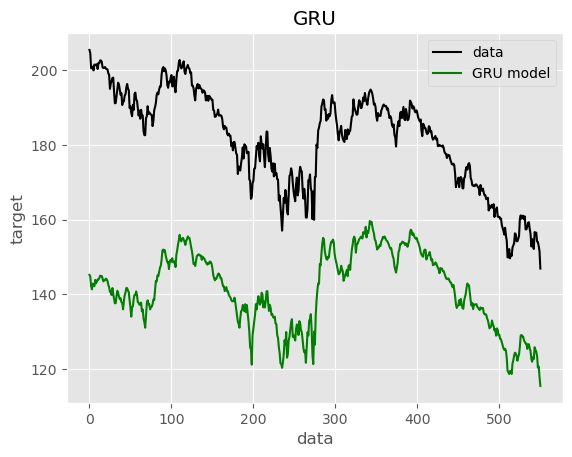

In [16]:
plt.plot(mean_actual,c='k',label='data')
plt.plot(mean_pre,c='g',label='GRU model')
plt.xlabel('data')
plt.ylabel('target')
plt.title('GRU')
plt.legend()
plt.show()


In [45]:
# 傻瓜算法
stupid_actual = mean_actual
stupid_predict = [stupid_actual[0]]
stupid_predict[1:len(stupid_actual)] = stupid_actual[0:len(stupid_actual)-1]
print(len(stupid_actual))
print(len(stupid_predict))
print(stupid_actual)
print(stupid_predict)

476
476
[36.29222277777777, 36.17777844444444, 35.705556222222214, 34.83999977777778, 34.50555422222223, 35.16999988888889, 34.34444511111111, 33.50444544444444, 33.797776999999996, 31.019999222222225, 28.64222211111112, 29.570000555555552, 28.053332888888892, 29.725555444444442, 31.88222244444445, 33.968889, 33.25555422222222, 32.18444488888889, 33.855556888888884, 33.43666588888889, 32.67555411111111, 33.37111066666667, 32.356665666666665, 31.965555777777784, 32.59444511111112, 33.34222077777778, 32.24888777777778, 31.485554999999994, 31.495554555555557, 31.187777999999998, 31.720001222222223, 32.67555411111111, 32.65555488888889, 33.32444588888889, 33.461110444444444, 31.60555688888889, 32.676666222222224, 33.64110988888889, 33.552222333333326, 34.09444511111112, 33.89110988888889, 33.4511108888889, 32.441111222222226, 31.575554777777782, 31.831112333333333, 31.615556555555557, 30.757778555555554, 31.609998888888892, 30.55666777777778, 31.007778555555554, 30.87222288888889, 30.98333

In [46]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("mean_absolute_error:", mean_absolute_error(stupid_actual, stupid_predict))
print("mean_squared_error:", mean_squared_error(stupid_actual, stupid_predict))
print("rmse:", sqrt(mean_squared_error(stupid_actual, stupid_predict)))
print("r2 score:", r2_score(stupid_actual, stupid_predict))

mean_absolute_error: 0.8485317514005603
mean_squared_error: 1.9052874866537448
rmse: 1.3803215156816708
r2 score: 0.9704824903890008


In [19]:
trend_actual = []

for i in range(1, len(mean_actual)):
    tmp = mean_actual[i] - mean_actual[i-1]
    if tmp < 0: # down
        trend_actual.append(2)
    elif tmp > 0: # up
        trend_actual.append(0)
    else:
        trend_actual.append(1)

print(len(trend_actual))
trend_actual

550


[2,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,


In [27]:
mean_pre[1]

array([27.56467], dtype=float32)

In [20]:
trend_predict = []

for i in range(1, len(mean_pre)):
    tmp = mean_pre[i] - mean_pre[i-1]
    if tmp < 0: # down
        trend_predict.append(2)
    elif tmp > 0: # up
        trend_predict.append(0)
    else:
        trend_predict.append(1)

trend_predict

[2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,


In [52]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("mean_absolute_error:", mean_absolute_error(trend_actual, trend_predict))
print("mean_squared_error:", mean_squared_error(trend_actual, trend_predict))
print("rmse:", sqrt(mean_squared_error(trend_actual, trend_predict)))
print("r2 score:", r2_score(trend_actual, trend_predict))

mean_absolute_error: 0.7536842105263157
mean_squared_error: 1.5073684210526315
rmse: 1.2277493315219647
r2 score: -0.5075354609929084


In [21]:
same = 0
for i in range(0, len(trend_actual)):
    if trend_actual[i] == trend_predict[i]:
        same = same + 1
        
ratio = same/len(trend_actual)
ratio

0.6654545454545454